In [1]:
%reload_ext autoreload
%autoreload 2
import bmxobs
from bmxobs.SingleFreqGeometry import SingleFreqGeometry
from bmxobs.TheoryPredictor import TheoryPredictor
import fitsio
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import j1
from scipy.optimize import least_squares
import copy
from numba import jit
import multiprocessing
import time
import random
from scipy.signal import find_peaks

In [2]:
bmxobs.__path__

['/direct/astro+u/wcook/bmxobs/bmxobs']

In [3]:
BMX = bmxobs.BMXObs("pas/211107_1900", channels='all')

In [4]:
D=bmxobs.BMXSingleFreqObs("pas/211107_1900", freq_bins=(440,460))
print(D.freq)

1220.8496287465096


In [70]:
print(BMX.freq[0][300])

1180.7007074207067


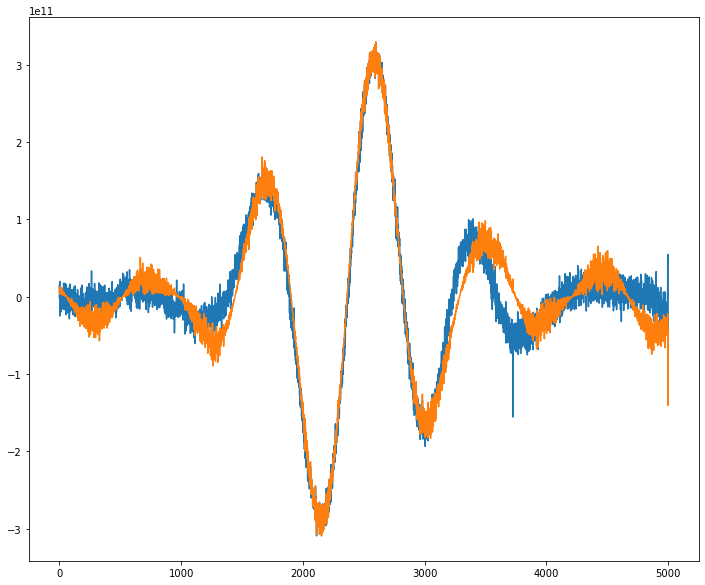

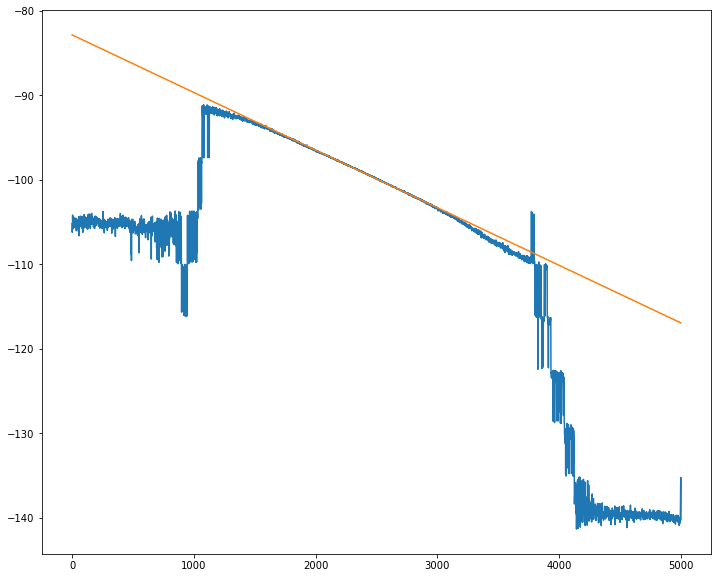

-921.9689085217972


In [33]:
cut = [93000,98000]
fitCut = [95000,96000]
freq = 930
ratio = BMX.freq[0][freq]/BMX.freq[0][300]

plt.figure(figsize=(12,10))
#plt.yscale('log')
data = BMX[120][:,freq]
data = data - (data[cut[0]:cut[1]]).mean()
real = data.real
phase = np.arccos(real/abs(data)) * (2*(data.imag>0)-1)

for i in range(len(phase)-1):
    if phase[i]-phase[i+1]>=6:
        phase[i+1:] += 2*np.pi
    elif phase[i]-phase[i+1]<=-6:
        phase[i+1:] += -2*np.pi

poly = np.polyfit(np.arange(fitCut[0],fitCut[1]),phase[fitCut[0]:fitCut[1]],1)
polyfit = poly[1] + np.arange(len(data))*poly[0]
cosFit = np.cos(polyfit)*abs(data)

plt.plot(real[cut[0]:cut[1]])
#plt.plot(fit[cut[0]:cut[1]])
plt.plot(cosFit[cut[0]:cut[1]])
plt.show()
plt.figure(figsize=(12,10))
plt.plot(phase[cut[0]:cut[1]])
plt.plot(polyfit[cut[0]:cut[1]])
plt.show()

print(2*np.pi/poly[0])

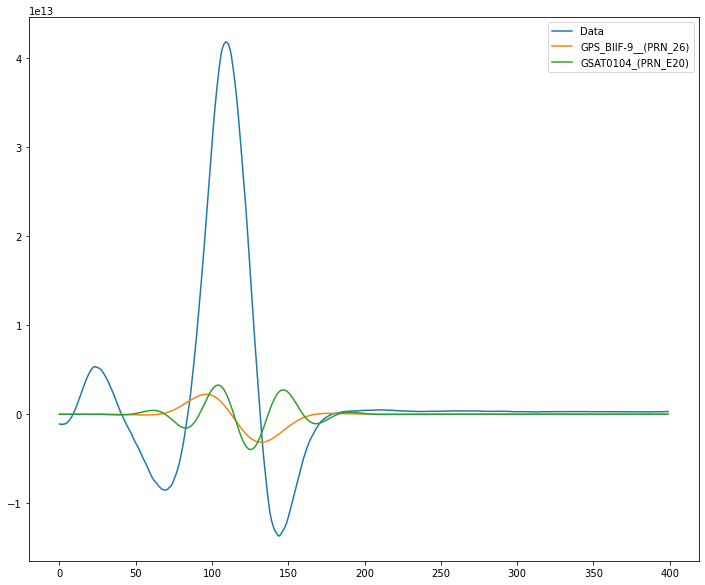

[9709]


In [11]:
cut = [9600,10000]
channel = 12

plt.figure(figsize=(12,10))
plt.plot(D[channel][cut[0]:cut[1]].real,label='Data')

tracks = {}
sats = {}
for n,s in zip(D.sat_id,D.sat):
    if "COS" not in n:
        #dx= np.exp(-np.cos(s['alt'])**2/(2*0.05**2))
        track = np.array([np.cos(s['alt'])*np.cos(s['az']),np.cos(s['alt'])*np.sin(s['az'])]).T
        dx = SingleFreqGeometry(1,freq=D.freq).point_source(channel,4e12,track,0).real
        if max(dx[cut[0]:cut[1]])>1e12:
            plt.plot(dx[cut[0]:cut[1]],label=n)
            tracks[n] = track
            sats[n] = dx
        
plt.legend()
plt.show()
print(np.arange(cut[0],cut[1])[D[channel][cut[0]:cut[1]].real==max(D[channel][cut[0]:cut[1]].real)])

In [5]:
def getTemplate(D, BMX, freq, cut):
    scale = 10*D.freq/BMX.freq[0][freq]
    prange = (np.arange(cut[0],cut[1])-np.mean(cut))/scale+np.mean(cut)/10
    pastebase = prange.astype(np.int)
    pastemix = prange%1
    paste = (D[12][pastebase]*(1-pastemix)+D[12][pastebase+1]*pastemix)
    return paste - np.mean(paste)

In [44]:
cut = [94000,97000]
freq = 800

paste = getTemplate(D,BMX,freq,cut)

def fitTemplate(params):
    A,phi = params[0], params[1]
    fit = paste*A*np.exp(1j*phi) - BMX[120][cut[0]:cut[1],freq]*((-1)**(np.arange(cut[0],cut[1])))
    #out = abs(sum(fit * np.conj(BMX[120][cut[0]:cut[1],freq]))/sum(abs(fit)**2)-1)
    out = fit.real
    out = np.append(out,fit.imag)
    return out


1950
[-6.73919092e-06  9.71357005e-01]
2.114531787527736e+17


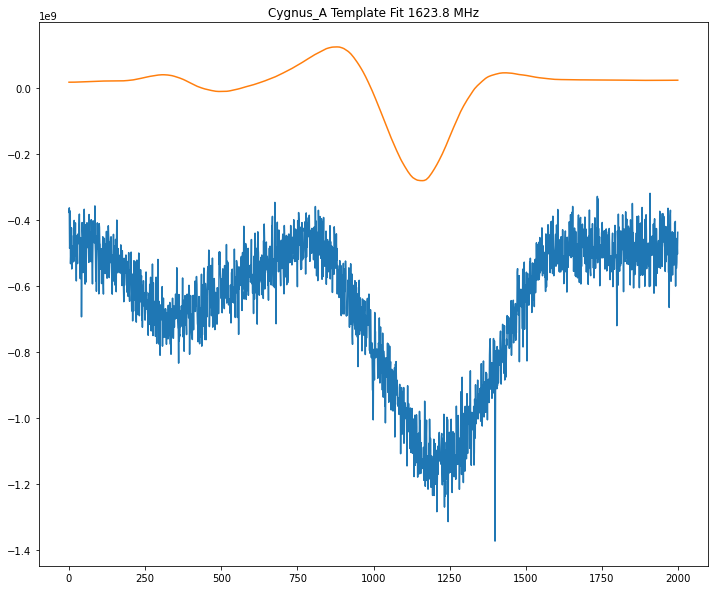

In [34]:
cut = [96000,98000]
freq = 1950

paste = getTemplate(D,BMX,freq,cut)

params = least_squares(fitTemplate,[1,0],bounds=([-100,-np.pi],[100,np.pi]))
print(freq)
print(params.x)
print(params.optimality)

A,phi = params.x[0], params.x[1]

fit = paste*A*np.exp(1j*phi)

plt.figure(figsize=(12,10))
plt.title('Cygnus_A Template Fit {:.1f} MHz'.format(BMX.freq[0][freq]))
plt.plot(BMX[120][cut[0]:cut[1],freq].real)
plt.plot(fit.real)
plt.show()

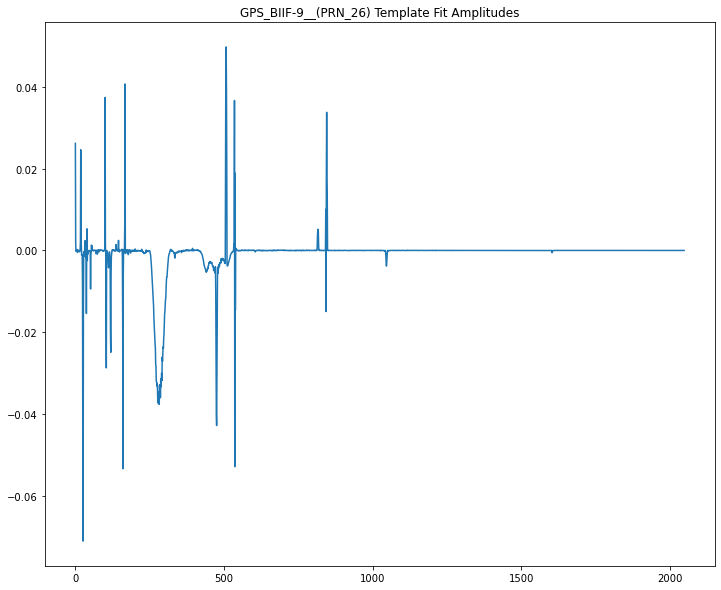

In [45]:
amp = []

for freq in range(len(BMX[120][0])):
    paste = getTemplate(D,BMX,freq,cut)

    params = least_squares(fitTemplate,[0,0],bounds=([-100,-np.pi],[100,np.pi]))
    
    amp.append(params.x[0])
    
    #if freq%100==0:
        #print(freq)
        #print(params.x)
        #print(params.optimality)

        #A,phi = params.x[0], params.x[1]

        #fit = paste*A*np.exp(1j*phi)

        #plt.figure(figsize=(12,10))
        #plt.title('Cygnus_A Template Fit {:.1f} MHz'.format(BMX.freq[0][freq]))
        #plt.plot(BMX[120][cut[0]:cut[1],freq].real)
        #plt.plot(fit.real)
        #plt.show()
    
plt.figure(figsize=(12,10))
plt.title('GPS_BIIF-9__(PRN_26) Template Fit Amplitudes')
plt.plot(amp)
plt.show()

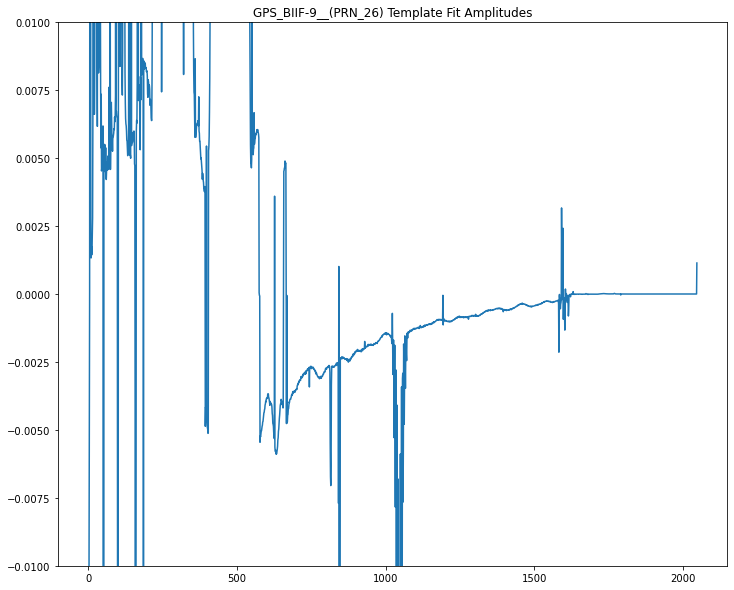

In [37]:
plt.figure(figsize=(12,10))
plt.title('GPS_BIIF-9__(PRN_26) Template Fit Amplitudes')
plt.plot(amp)
plt.ylim(-.01,0.01)
plt.show()

In [11]:
def getSatFreq(BMX, freq, fitCut = [37000,37500]):
    data = BMX[120][:,freq]
    data = data - (data[fitCut[0]-1000:fitCut[1]+1000]).mean()
    phase = np.arccos(data.real/abs(data)) * (2*(data.imag>0)-1)

    for i in range(len(phase)-1):
        if phase[i]-phase[i+1]>=6:
            phase[i+1:] += 2*np.pi
        elif phase[i]-phase[i+1]<=-6:
            phase[i+1:] += -2*np.pi

    poly = np.polyfit(np.arange(fitCut[0],fitCut[1]),phase[fitCut[0]:fitCut[1]],1)
    return abs(poly[0])

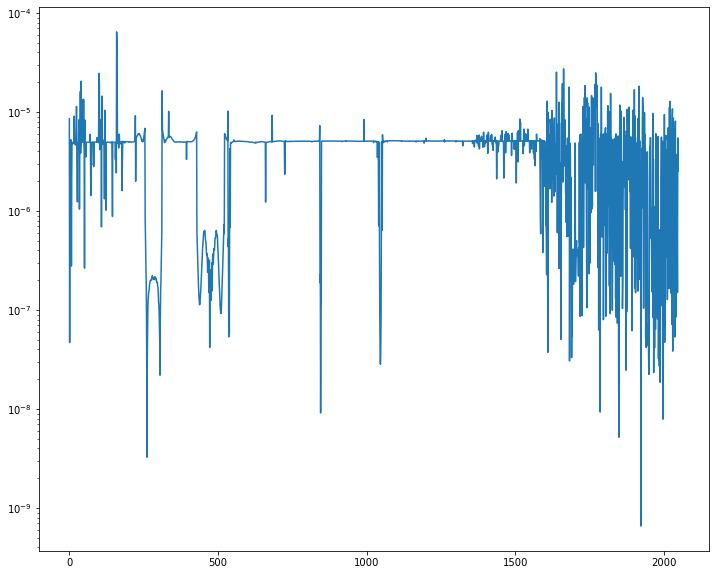

In [19]:
fitCut = [95000,96000]

satDiff = []
for freq in range(len(BMX[120][0])):
    satDiff.append(getSatFreq(BMX,freq, fitCut=fitCut)/BMX.freq[0][freq])
    
plt.figure(figsize=(12,10))
plt.yscale('log')
plt.plot(satDiff)
plt.show()

In [48]:
find_peaks(abs(D[12]),height=1e12)
for n,s in zip(D.sat_id,D.sat):
    if "COS" not in n:
        cos2 = np.cos(s['alt'])**(-2)
        print(n,find_peaks(cos2,height=10))

GPS_BIII-4__(PRN_14) (array([ 521, 3720, 9347]), {'peak_heights': array([2.07678833e+01, 2.75205400e+06, 2.07568359e+01])})
BEIDOU-3_M4_(C28) (array([3125, 6575]), {'peak_heights': array([6.45803906e+04, 1.02029209e+01])})
BEIDOU-3_M6_(C22) (array([5207, 8661]), {'peak_heights': array([1.06061220e+01, 3.85791094e+04])})
GPS_BIIF-11_(PRN_10) (array([4932, 8157]), {'peak_heights': array([  28.56850052, 1478.63574219])})
GSAT0210_(PRN_E01) (array([757]), {'peak_heights': array([685.41729736])})
GPS_BIIRM-4_(PRN_15) (array([1172, 6789, 9998]), {'peak_heights': array([ 18.87561035, 661.90673828,  18.87334824])})
GSAT0201_(PRN_E18) (array([5150]), {'peak_heights': array([527.60144043])})
GSAT0101_(PRN_E11) (array([3824]), {'peak_heights': array([373.2460022])})
GSAT0207_(PRN_E07) (array([9199]), {'peak_heights': array([306.12329102])})
GSAT0212_(PRN_E03) (array([6904]), {'peak_heights': array([218.38861084])})
BEIDOU-3_M10_(C24) (array([355]), {'peak_heights': array([206.11064148])})
GPS_BII

In [28]:
zeroSats = []
for n,s in zip(D.sat_id,D.sat):
    if "COS" not in n:
        cos2 = np.cos(s['alt'])**2
        peak = np.arange(len(cos2))[cos2==min(cos2)][0]
        print(n,peak)

GPS_BIII-4__(PRN_14) [3720]
BEIDOU-3_M4_(C28) [3125]
BEIDOU-3_M6_(C22) [8661]
GPS_BIIF-11_(PRN_10) [8157]
GSAT0210_(PRN_E01) [757]
GPS_BIIRM-4_(PRN_15) [6789]
GSAT0201_(PRN_E18) [5150]
GSAT0101_(PRN_E11) [3824]
GSAT0207_(PRN_E07) [9199]
GSAT0212_(PRN_E03) [6904]
BEIDOU-3_M10_(C24) [355]
GPS_BIIF-9__(PRN_26) [908]
BEIDOU-3_M2_(C20) [5882]
GPS_BIIF-10_(PRN_08) [2308]
GPS_BIIR-8__(PRN_16) [1425]
GPS_BIIR-4__(PRN_20) [5600]
BEIDOU_15_(C14) [6208]
BEIDOU-3_M7_(C29) [5935]
GSAT0217_(PRN_E27) [3081]
BEIDOU-3_M9_(C23) [2403]
BEIDOU-3_M11_(C25) [9370]
BEIDOU_18_(C57) [2778]
GPS_BIII-3__(PRN_23) [7674]
GSAT0213_(PRN_E04) [840]
GSAT0205_(PRN_E24) [9909]
BEIDOU-3_M18_(C37) [9313]
BEIDOU-3_M8_(C30) [5124]
GSAT0204_(PRN_E22) [4248]
GSAT0216_(PRN_E25) [3893]
BEIDOU-3_M24_(C46) [2413]
GPS_BIIRM-8_(PRN_05) [6069]
BEIDOU-3_M1_(C19) [417 418]
GPS_BIIRM-2_(PRN_31) [9169]
GPS_BIII-2__(PRN_18) [3906]
GSAT0221_(PRN_E15) [3070]
GPS_BIIRM-6_(PRN_07) [8269]
GSAT0103_(PRN_E19) [6797]
GPS_BIIF-6__(PRN_06) [4658]


In [30]:
def getPhaseFit(Theory):
    detectors = [2,3,4,6,7,8]
    channelSet = [[12],[13,23],[14,24,34],
                  [56],[57,67],[58,68,78]]

    params = []
        
    for i,d in enumerate(detectors):
        ch = channelSet[i]
        names = ['D{}_pos_x'.format(d),
                 'D{}_pos_y'.format(d)]
        names += ['D{}_phi_{}'.format(d,j) for j in range(len(Theory.data))]

        params.append(Theory.fit(names, mode = 'phase', channels = ch, plot=False))
    
    return np.array(params)

In [31]:
def getBeamFit(Theory):
    detectors = [1,2,3,4,5,6,7,8]
    channelSet = [[11],[12,22],[13,23,33],[14,24,34,44],
                  [55],[56,66],[57,67,77],[58,68,78,88]]
    params = []

    for i,d in enumerate(detectors):
        ch = channelSet[i]
        names = ['D{}_beam_center_x'.format(d),
                'D{}_beam_center_y'.format(d),
                'D{}_beam_smooth_x'.format(d),
                'D{}_beam_smooth_y'.format(d)
                ]
        if Theory.geometry.ant_beam[d-1].airy:
            names += ['D{}_beam_sigma_x'.format(d),
                'D{}_beam_sigma_y'.format(d),]


        params.append(Theory.fit(names, mode = 'amp', channels = ch, plot=False))
    
    return np.array(params)

In [32]:
def getAmpFit(Theory, mode='amp'):
    detectors = [1,2,3,4,5,6,7,8]
    channelSet = [[11],[12,22],[13,23,33],[14,24,34,44],
                  [55],[56,66],[57,67,77],[58,68,78,88]]
    
    TASKS = []
    for i,d in enumerate(detectors):
        ch = channelSet[i]
        for j in range(len(Theory.data)):
            names = ["A{}_{}_{}".format(d,n,j) for n in Theory.satNames[j]]
            #names += ["CH{}_offset_r".format(channel) for channel in ch]
            #for channel in ch:
                #if channel%11 != 0:
                    #names += ["CH{}_offset_i".format(channel)]
            if len(names)>0:
                TASKS.append((names, mode, ch, [j]))
    
    with multiprocessing.Pool(len(TASKS)) as pool:
        imap_it = pool.imap(Theory.fit_parallel, TASKS, chunksize=10)
        
        print('Ordered results using pool.imap():')
        for x in imap_it:
            print('\t', x)
        print()
    return

In [33]:
Data_ids = [["pas/210904_2300"#,
            #"pas/210905_2300",
            #"pas/210906_2300",
            #"pas/210907_2300",
            #"pas/210908_2300",
            #"pas/210909_2300",
            #"pas/210910_2300",
            #"pas/210911_2300",
            #"pas/210912_2300",
            #"pas/210913_2300"
            ]
           ]
bins = (280,300) #1178 MHz
#bins = (1760,1780) #1575 MHz
DataSets = [[bmxobs.BMXSingleFreqObs(ids, freq_bins=bins) for ids in Data_id] for Data_id in Data_ids]

In [34]:
astroObj = { #'name':[RA in radians, DEC in radians]
    'Cygnus_A':[5.233686582997465, 0.7109409436737796]
}

In [35]:
#params1178 = [
    #{'A1_GPS_BIIR-8__(PRN_16)_0': -31896.401772967365, 'A1_GPS_BIIR-8__(PRN_16)_1': -124664.34166527528, 'A2_GPS_BIIR-8__(PRN_16)_0': -200492.99937518477, 'A2_GPS_BIIR-8__(PRN_16)_1': 2777.2770556270593, 'A3_GPS_BIIR-8__(PRN_16)_0': 31197.1853452285, 'A3_GPS_BIIR-8__(PRN_16)_1': -103048.58626038571, 'A4_GPS_BIIR-8__(PRN_16)_0': -985199.8601079399, 'A4_GPS_BIIR-8__(PRN_16)_1': 27025.2715334839, 'A5_GPS_BIIR-8__(PRN_16)_0': 137358.42953228278, 'A5_GPS_BIIR-8__(PRN_16)_1': 1301286.8244088206, 'A6_GPS_BIIR-8__(PRN_16)_0': 1066515.1944678307, 'A6_GPS_BIIR-8__(PRN_16)_1': -5813.759575912249, 'A7_GPS_BIIR-8__(PRN_16)_0': 1808397.104839363, 'A7_GPS_BIIR-8__(PRN_16)_1': 1167398.648276579, 'A8_GPS_BIIR-8__(PRN_16)_0': -3169.5666325365146, 'A8_GPS_BIIR-8__(PRN_16)_1': -184684.27959335127, 'GPS_BIIR-8__(PRN_16)_track_offset_x': 0.0, 'GPS_BIIR-8__(PRN_16)_track_offset_y': 0.0, 'GPS_BIIR-8__(PRN_16)_time_offset': 0, 'A1_GSAT0212_(PRN_E03)_0': 22189725.641581856, 'A1_GSAT0212_(PRN_E03)_1': 4647271.547899511, 'A2_GSAT0212_(PRN_E03)_0': 3477050772515.2114, 'A2_GSAT0212_(PRN_E03)_1': 2656686.520544912, 'A3_GSAT0212_(PRN_E03)_0': -14219878412796.982, 'A3_GSAT0212_(PRN_E03)_1': 6931780.6830908405, 'A4_GSAT0212_(PRN_E03)_0': -2500970596633507.5, 'A4_GSAT0212_(PRN_E03)_1': 23113576.97767496, 'A5_GSAT0212_(PRN_E03)_0': 5455725.40320662, 'A5_GSAT0212_(PRN_E03)_1': 3795945.7761696763, 'A6_GSAT0212_(PRN_E03)_0': 4960198.725026493, 'A6_GSAT0212_(PRN_E03)_1': 3191150.7413497507, 'A7_GSAT0212_(PRN_E03)_0': 8616381.81038711, 'A7_GSAT0212_(PRN_E03)_1': 5912113.966558098, 'A8_GSAT0212_(PRN_E03)_0': 15297400.968024453, 'A8_GSAT0212_(PRN_E03)_1': 15043829.530371334, 'GSAT0212_(PRN_E03)_track_offset_x': 0.0, 'GSAT0212_(PRN_E03)_track_offset_y': 0.0, 'GSAT0212_(PRN_E03)_time_offset': 0, 'A1_GSAT0205_(PRN_E24)_0': -494483.20851546276, 'A1_GSAT0205_(PRN_E24)_1': 1218881.6625347217, 'A2_GSAT0205_(PRN_E24)_0': -1615412.9742002496, 'A2_GSAT0205_(PRN_E24)_1': -69591.61923974135, 'A3_GSAT0205_(PRN_E24)_0': 20933.265743031472, 'A3_GSAT0205_(PRN_E24)_1': -211127.65797267837, 'A4_GSAT0205_(PRN_E24)_0': -5856835.708547618, 'A4_GSAT0205_(PRN_E24)_1': 1206643.5456594815, 'A5_GSAT0205_(PRN_E24)_0': 51546.85099956047, 'A5_GSAT0205_(PRN_E24)_1': 468643.06202547887, 'A6_GSAT0205_(PRN_E24)_0': -17112.94907664945, 'A6_GSAT0205_(PRN_E24)_1': -1426993.5092727353, 'A7_GSAT0205_(PRN_E24)_0': -119880.86521481755, 'A7_GSAT0205_(PRN_E24)_1': 3263613.5639450336, 'A8_GSAT0205_(PRN_E24)_0': 989948.8726973848, 'A8_GSAT0205_(PRN_E24)_1': 6867821.408992297, 'GSAT0205_(PRN_E24)_track_offset_x': 0.0, 'GSAT0205_(PRN_E24)_track_offset_y': 0.0, 'GSAT0205_(PRN_E24)_time_offset': 0, 'A1_GPS_BIIRM-6_(PRN_07)_0': 2576120.291015752, 'A1_GPS_BIIRM-6_(PRN_07)_1': 3548236.4403462503, 'A2_GPS_BIIRM-6_(PRN_07)_0': 4506224.27235558, 'A2_GPS_BIIRM-6_(PRN_07)_1': 3795555.19761619, 'A3_GPS_BIIRM-6_(PRN_07)_0': 6272335.061781259, 'A3_GPS_BIIRM-6_(PRN_07)_1': 5838950.451416291, 'A4_GPS_BIIRM-6_(PRN_07)_0': 3098336.6497928966, 'A4_GPS_BIIRM-6_(PRN_07)_1': -961663.0805832614, 'A5_GPS_BIIRM-6_(PRN_07)_0': -1477.8438037169396, 'A5_GPS_BIIRM-6_(PRN_07)_1': 255949.57556044115, 'A6_GPS_BIIRM-6_(PRN_07)_0': -2547107.9978921814, 'A6_GPS_BIIRM-6_(PRN_07)_1': -3361.9541383254277, 'A7_GPS_BIIRM-6_(PRN_07)_0': -437560.8693453897, 'A7_GPS_BIIRM-6_(PRN_07)_1': -19919.268888469822, 'A8_GPS_BIIRM-6_(PRN_07)_0': -947.3143957427455, 'A8_GPS_BIIRM-6_(PRN_07)_1': 710214.7606181224, 'GPS_BIIRM-6_(PRN_07)_track_offset_x': 0.0, 'GPS_BIIRM-6_(PRN_07)_track_offset_y': 0.0, 'GPS_BIIRM-6_(PRN_07)_time_offset': 0, 'A1_GSAT0202_(PRN_E14)_0': -2383527.8067835667, 'A1_GSAT0202_(PRN_E14)_1': -31320638.146935057, 'A2_GSAT0202_(PRN_E14)_0': 551211.7702470762, 'A2_GSAT0202_(PRN_E14)_1': 29564248.961123355, 'A3_GSAT0202_(PRN_E14)_0': 245180.66958366177, 'A3_GSAT0202_(PRN_E14)_1': 36131210.01774544, 'A4_GSAT0202_(PRN_E14)_0': -247.3581844113586, 'A4_GSAT0202_(PRN_E14)_1': -37357390.78514338, 'A5_GSAT0202_(PRN_E14)_0': 447.4599925151388, 'A5_GSAT0202_(PRN_E14)_1': -25101760.86862091, 'A6_GSAT0202_(PRN_E14)_0': 193359.28235784388, 'A6_GSAT0202_(PRN_E14)_1': 27535584.33304123, 'A7_GSAT0202_(PRN_E14)_0': 1143359.3279285799, 'A7_GSAT0202_(PRN_E14)_1': 30495802.490586426, 'A8_GSAT0202_(PRN_E14)_0': -3305630.627324822, 'A8_GSAT0202_(PRN_E14)_1': -21302707.409800738, 'GSAT0202_(PRN_E14)_track_offset_x': 0.0, 'GSAT0202_(PRN_E14)_track_offset_y': 0.0, 'GSAT0202_(PRN_E14)_time_offset': 0, 'A1_GPS_BIIRM-4_(PRN_15)_0': -257236.97163260882, 'A1_GPS_BIIRM-4_(PRN_15)_1': 57360.050391254445, 'A2_GPS_BIIRM-4_(PRN_15)_0': 130641.33310690276, 'A2_GPS_BIIRM-4_(PRN_15)_1': 299539.5345903275, 'A3_GPS_BIIRM-4_(PRN_15)_0': 24288.65651730475, 'A3_GPS_BIIRM-4_(PRN_15)_1': 162712.8025944049, 'A4_GPS_BIIRM-4_(PRN_15)_0': 1298984.1520251366, 'A4_GPS_BIIRM-4_(PRN_15)_1': 718834.835628115, 'A5_GPS_BIIRM-4_(PRN_15)_0': 224781.24336690435, 'A5_GPS_BIIRM-4_(PRN_15)_1': 2230616.0950597576, 'A6_GPS_BIIRM-4_(PRN_15)_0': 1240902.3002345108, 'A6_GPS_BIIRM-4_(PRN_15)_1': 1550576.3474878906, 'A7_GPS_BIIRM-4_(PRN_15)_0': 1636322.0272981266, 'A7_GPS_BIIRM-4_(PRN_15)_1': -442914.1940090615, 'A8_GPS_BIIRM-4_(PRN_15)_0': 27766.249958169883, 'A8_GPS_BIIRM-4_(PRN_15)_1': 258182.42733133258, 'GPS_BIIRM-4_(PRN_15)_track_offset_x': 0.0, 'GPS_BIIRM-4_(PRN_15)_track_offset_y': 0.0, 'GPS_BIIRM-4_(PRN_15)_time_offset': 0, 'A1_BEIDOU-3_M9_(C23)_0': 29124388.76140927, 'A1_BEIDOU-3_M9_(C23)_1': -180684.55008271424, 'A2_BEIDOU-3_M9_(C23)_0': 27927873.345074695, 'A2_BEIDOU-3_M9_(C23)_1': -841454.4749502542, 'A3_BEIDOU-3_M9_(C23)_0': 29371672.631158028, 'A3_BEIDOU-3_M9_(C23)_1': 394713.1294476269, 'A4_BEIDOU-3_M9_(C23)_0': 8898650.6873464, 'A4_BEIDOU-3_M9_(C23)_1': 42776.32127052704, 'A5_BEIDOU-3_M9_(C23)_0': 24880266.14561324, 'A5_BEIDOU-3_M9_(C23)_1': -166.74623938964447, 'A6_BEIDOU-3_M9_(C23)_0': 23637677.827938415, 'A6_BEIDOU-3_M9_(C23)_1': 57355.1765388211, 'A7_BEIDOU-3_M9_(C23)_0': 26739901.621387996, 'A7_BEIDOU-3_M9_(C23)_1': 1044470.3104767057, 'A8_BEIDOU-3_M9_(C23)_0': 9018036.924719281, 'A8_BEIDOU-3_M9_(C23)_1': 4327780.839482682, 'BEIDOU-3_M9_(C23)_track_offset_x': 0.0, 'BEIDOU-3_M9_(C23)_track_offset_y': 0.0, 'BEIDOU-3_M9_(C23)_time_offset': 0, 'A1_GSAT0101_(PRN_E11)_0': 5462576.10275619, 'A1_GSAT0101_(PRN_E11)_1': 4540823.139197065, 'A2_GSAT0101_(PRN_E11)_0': 4708524281481.239, 'A2_GSAT0101_(PRN_E11)_1': -6079230.846471119, 'A3_GSAT0101_(PRN_E11)_0': 1791846348562.9553, 'A3_GSAT0101_(PRN_E11)_1': 11710321.710790798, 'A4_GSAT0101_(PRN_E11)_0': 4.3740001549512936e+16, 'A4_GSAT0101_(PRN_E11)_1': 16776512.27800133, 'A5_GSAT0101_(PRN_E11)_0': 9172.394260619123, 'A5_GSAT0101_(PRN_E11)_1': -44324.13838436307, 'A6_GSAT0101_(PRN_E11)_0': -2315.23182231674, 'A6_GSAT0101_(PRN_E11)_1': -905.2030161390192, 'A7_GSAT0101_(PRN_E11)_0': -8376.16624347639, 'A7_GSAT0101_(PRN_E11)_1': -109604.53175444239, 'A8_GSAT0101_(PRN_E11)_0': -8613708.71153827, 'A8_GSAT0101_(PRN_E11)_1': -9265625.707572555, 'GSAT0101_(PRN_E11)_track_offset_x': 0.0, 'GSAT0101_(PRN_E11)_track_offset_y': 0.0, 'GSAT0101_(PRN_E11)_time_offset': 0, 'A1_GSAT0206_(PRN_E30)_0': 18041554.00262744, 'A1_GSAT0206_(PRN_E30)_1': 77940.88844014826, 'A2_GSAT0206_(PRN_E30)_0': 17431019.473077204, 'A2_GSAT0206_(PRN_E30)_1': 92418.60140255973, 'A3_GSAT0206_(PRN_E30)_0': 23835471.544845592, 'A3_GSAT0206_(PRN_E30)_1': 57554.066158511734, 'A4_GSAT0206_(PRN_E30)_0': 28368029.20088002, 'A4_GSAT0206_(PRN_E30)_1': -1503.8113533023666, 'A5_GSAT0206_(PRN_E30)_0': 14534760.801667651, 'A5_GSAT0206_(PRN_E30)_1': -7125.322495659434, 'A6_GSAT0206_(PRN_E30)_0': 16492180.079850147, 'A6_GSAT0206_(PRN_E30)_1': 942053.9952406435, 'A7_GSAT0206_(PRN_E30)_0': 20945015.30906845, 'A7_GSAT0206_(PRN_E30)_1': 1081473.4330212595, 'A8_GSAT0206_(PRN_E30)_0': 17639024.999527864, 'A8_GSAT0206_(PRN_E30)_1': 1355784.3236985796, 'GSAT0206_(PRN_E30)_track_offset_x': 0.0, 'GSAT0206_(PRN_E30)_track_offset_y': 0.0, 'GSAT0206_(PRN_E30)_time_offset': 0, 'A1_BEIDOU-3_M14_(C33)_0': 77992.65388465337, 'A1_BEIDOU-3_M14_(C33)_1': 2403031.2754954686, 'A2_BEIDOU-3_M14_(C33)_0': 168115.45418194734, 'A2_BEIDOU-3_M14_(C33)_1': 167620.47547888823, 'A3_BEIDOU-3_M14_(C33)_0': 175828.82481152646, 'A3_BEIDOU-3_M14_(C33)_1': -114041.48627083906, 'A4_BEIDOU-3_M14_(C33)_0': -167880.0809218287, 'A4_BEIDOU-3_M14_(C33)_1': 660051.6201524509, 'A5_BEIDOU-3_M14_(C33)_0': 4251556.090439499, 'A5_BEIDOU-3_M14_(C33)_1': 5041840.121974459, 'A6_BEIDOU-3_M14_(C33)_0': 4632975.812822929, 'A6_BEIDOU-3_M14_(C33)_1': 4957087.777969249, 'A7_BEIDOU-3_M14_(C33)_0': 6296889.711510094, 'A7_BEIDOU-3_M14_(C33)_1': 7211028.692847793, 'A8_BEIDOU-3_M14_(C33)_0': 3779046.1825344637, 'A8_BEIDOU-3_M14_(C33)_1': 42632.105049572245, 'BEIDOU-3_M14_(C33)_track_offset_x': 0.0, 'BEIDOU-3_M14_(C33)_track_offset_y': 0.0, 'BEIDOU-3_M14_(C33)_time_offset': 0, 'A1_BEIDOU-3_M17_(C36)_0': 5540749.185357011, 'A1_BEIDOU-3_M17_(C36)_1': 4168715.4527465994, 'A2_BEIDOU-3_M17_(C36)_0': 4299941.985766352, 'A2_BEIDOU-3_M17_(C36)_1': 70395112583107.97, 'A3_BEIDOU-3_M17_(C36)_0': 8072743.516822706, 'A3_BEIDOU-3_M17_(C36)_1': 129516304959286.06, 'A4_BEIDOU-3_M17_(C36)_0': 15213458.116406815, 'A4_BEIDOU-3_M17_(C36)_1': -24006141656193.62, 'A5_BEIDOU-3_M17_(C36)_0': 4041317.67606377, 'A5_BEIDOU-3_M17_(C36)_1': 3011051.901130076, 'A6_BEIDOU-3_M17_(C36)_0': 3037295.775400319, 'A6_BEIDOU-3_M17_(C36)_1': 2632400.4913488394, 'A7_BEIDOU-3_M17_(C36)_0': 5079385.140655097, 'A7_BEIDOU-3_M17_(C36)_1': 3735345.6341633387, 'A8_BEIDOU-3_M17_(C36)_0': 4092139.492342313, 'A8_BEIDOU-3_M17_(C36)_1': 6354376973620.017, 'BEIDOU-3_M17_(C36)_track_offset_x': 0.0, 'BEIDOU-3_M17_(C36)_track_offset_y': 0.0, 'BEIDOU-3_M17_(C36)_time_offset': 0, 'A1_GPS_BIIF-9__(PRN_26)_0': 18267211.548381258, 'A1_GPS_BIIF-9__(PRN_26)_1': 18112564.279891152, 'A2_GPS_BIIF-9__(PRN_26)_0': 19683886.14680761, 'A2_GPS_BIIF-9__(PRN_26)_1': 19375563.794636663, 'A3_GPS_BIIF-9__(PRN_26)_0': 14841443.09378015, 'A3_GPS_BIIF-9__(PRN_26)_1': 14699240.503565324, 'A4_GPS_BIIF-9__(PRN_26)_0': 1196874.929298314, 'A4_GPS_BIIF-9__(PRN_26)_1': 739780.2589148465, 'A5_GPS_BIIF-9__(PRN_26)_0': 13195351.490684023, 'A5_GPS_BIIF-9__(PRN_26)_1': 13091844.563305672, 'A6_GPS_BIIF-9__(PRN_26)_0': 15975721.601065896, 'A6_GPS_BIIF-9__(PRN_26)_1': 15796464.509130664, 'A7_GPS_BIIF-9__(PRN_26)_0': 14075505.59858979, 'A7_GPS_BIIF-9__(PRN_26)_1': 13847840.122287637, 'A8_GPS_BIIF-9__(PRN_26)_0': 3627628.8024903834, 'A8_GPS_BIIF-9__(PRN_26)_1': 3529532.8756994805, 'GPS_BIIF-9__(PRN_26)_track_offset_x': 0.0, 'GPS_BIIF-9__(PRN_26)_track_offset_y': 0.0, 'GPS_BIIF-9__(PRN_26)_time_offset': 0, 'A1_GPS_BIIF-4__(PRN_27)_0': -30648.48209402329, 'A1_GPS_BIIF-4__(PRN_27)_1': 992406.5350767293, 'A2_GPS_BIIF-4__(PRN_27)_0': 22286.359774676966, 'A2_GPS_BIIF-4__(PRN_27)_1': 2480129.943325714, 'A3_GPS_BIIF-4__(PRN_27)_0': -2352.6124611510204, 'A3_GPS_BIIF-4__(PRN_27)_1': -820972.6328283435, 'A4_GPS_BIIF-4__(PRN_27)_0': 170078.60581811238, 'A4_GPS_BIIF-4__(PRN_27)_1': 30819.538507894875, 'A5_GPS_BIIF-4__(PRN_27)_0': 4.022460589552435, 'A5_GPS_BIIF-4__(PRN_27)_1': -10.262347833571017, 'A6_GPS_BIIF-4__(PRN_27)_0': -1779924.759446196, 'A6_GPS_BIIF-4__(PRN_27)_1': -80629.70407961507, 'A7_GPS_BIIF-4__(PRN_27)_0': 222193.9290428102, 'A7_GPS_BIIF-4__(PRN_27)_1': 21736.471646208694, 'A8_GPS_BIIF-4__(PRN_27)_0': -37044.2229464825, 'A8_GPS_BIIF-4__(PRN_27)_1': -2602721.3371873144, 'GPS_BIIF-4__(PRN_27)_track_offset_x': 0.0, 'GPS_BIIF-4__(PRN_27)_track_offset_y': 0.0, 'GPS_BIIF-4__(PRN_27)_time_offset': 0, 'A1_BEIDOU-3_M20_0': -2009541.6617184628, 'A1_BEIDOU-3_M20_1': -16574517.32485519, 'A2_BEIDOU-3_M20_0': -2072683.7919544983, 'A2_BEIDOU-3_M20_1': -15394320.222836573, 'A3_BEIDOU-3_M20_0': -1161.991291114311, 'A3_BEIDOU-3_M20_1': -13579764.25711255, 'A4_BEIDOU-3_M20_0': 220040.9146184246, 'A4_BEIDOU-3_M20_1': 5530776.195059211, 'A5_BEIDOU-3_M20_0': 489090.12431350345, 'A5_BEIDOU-3_M20_1': 13432838.298256166, 'A6_BEIDOU-3_M20_0': -2398530.866248852, 'A6_BEIDOU-3_M20_1': -11959009.028671987, 'A7_BEIDOU-3_M20_0': 60539.227912160975, 'A7_BEIDOU-3_M20_1': -11650326.670879666, 'A8_BEIDOU-3_M20_0': 11135.119898907797, 'A8_BEIDOU-3_M20_1': -7616921.718327889, 'BEIDOU-3_M20_track_offset_x': 0.0, 'BEIDOU-3_M20_track_offset_y': 0.0, 'BEIDOU-3_M20_time_offset': 0, 'A1_BEIDOU-3_M3_(C27)_0': 19766759.975418184, 'A1_BEIDOU-3_M3_(C27)_1': 16180882.881494747, 'A2_BEIDOU-3_M3_(C27)_0': 173747622703.64682, 'A2_BEIDOU-3_M3_(C27)_1': 17708837.175772075, 'A3_BEIDOU-3_M3_(C27)_0': -69541556246823.25, 'A3_BEIDOU-3_M3_(C27)_1': 14614273.331999658, 'A4_BEIDOU-3_M3_(C27)_0': 6510488724828992.0, 'A4_BEIDOU-3_M3_(C27)_1': -1643261.8438175549, 'A5_BEIDOU-3_M3_(C27)_0': 14813242.38740307, 'A5_BEIDOU-3_M3_(C27)_1': 13188337.394444201, 'A6_BEIDOU-3_M3_(C27)_0': 16215165.72099592, 'A6_BEIDOU-3_M3_(C27)_1': 15061136.59383066, 'A7_BEIDOU-3_M3_(C27)_0': 15611758.547226422, 'A7_BEIDOU-3_M3_(C27)_1': 13984064.343418667, 'A8_BEIDOU-3_M3_(C27)_0': 803731.3775013717, 'A8_BEIDOU-3_M3_(C27)_1': 519174.2568600692, 'BEIDOU-3_M3_(C27)_track_offset_x': 0.0, 'BEIDOU-3_M3_(C27)_track_offset_y': 0.0, 'BEIDOU-3_M3_(C27)_time_offset': 0, 'A1_BEIDOU-3_M10_(C24)_0': 30179333.49600659, 'A1_BEIDOU-3_M10_(C24)_1': 6687069.766468654, 'A2_BEIDOU-3_M10_(C24)_0': 8011270681638.304, 'A2_BEIDOU-3_M10_(C24)_1': 3589071.239524392, 'A3_BEIDOU-3_M10_(C24)_0': 17167190820819.152, 'A3_BEIDOU-3_M10_(C24)_1': 6827773.18506257, 'A4_BEIDOU-3_M10_(C24)_0': -5.14420477341004e+16, 'A4_BEIDOU-3_M10_(C24)_1': 26276911.47492161, 'A5_BEIDOU-3_M10_(C24)_0': 11760008.277235225, 'A5_BEIDOU-3_M10_(C24)_1': 7669499.10068358, 'A6_BEIDOU-3_M10_(C24)_0': 7460698.094020618, 'A6_BEIDOU-3_M10_(C24)_1': 4405657.128486525, 'A7_BEIDOU-3_M10_(C24)_0': 10986719.348298136, 'A7_BEIDOU-3_M10_(C24)_1': 7336394.980968545, 'A8_BEIDOU-3_M10_(C24)_0': 17989740.965813924, 'A8_BEIDOU-3_M10_(C24)_1': 17989268.225818202, 'BEIDOU-3_M10_(C24)_track_offset_x': 0.0, 'BEIDOU-3_M10_(C24)_track_offset_y': 0.0, 'BEIDOU-3_M10_(C24)_time_offset': 0, 'A1_BEIDOU-3_M11_(C25)_0': 35118339.6894941, 'A1_BEIDOU-3_M11_(C25)_1': 5099432.552313857, 'A2_BEIDOU-3_M11_(C25)_0': -6425810218790.399, 'A2_BEIDOU-3_M11_(C25)_1': 5712032.913295797, 'A3_BEIDOU-3_M11_(C25)_0': -4893033884541.005, 'A3_BEIDOU-3_M11_(C25)_1': 4391308.630224403, 'A4_BEIDOU-3_M11_(C25)_0': 7.4202510914812e+16, 'A4_BEIDOU-3_M11_(C25)_1': 5877.459582986346, 'A5_BEIDOU-3_M11_(C25)_0': 9100927.073877674, 'A5_BEIDOU-3_M11_(C25)_1': 4793020.468087905, 'A6_BEIDOU-3_M11_(C25)_0': 11118727.39829711, 'A6_BEIDOU-3_M11_(C25)_1': 6617683.313936573, 'A7_BEIDOU-3_M11_(C25)_0': 9101704.254643654, 'A7_BEIDOU-3_M11_(C25)_1': 5299102.926784603, 'A8_BEIDOU-3_M11_(C25)_0': 2898220.602756965, 'A8_BEIDOU-3_M11_(C25)_1': 1888260.823982927, 'BEIDOU-3_M11_(C25)_track_offset_x': 0.0, 'BEIDOU-3_M11_(C25)_track_offset_y': 0.0, 'BEIDOU-3_M11_(C25)_time_offset': 0, 'A1_GSAT0103_(PRN_E19)_0': 2581.9878989750027, 'A1_GSAT0103_(PRN_E19)_1': -41367.190939501794, 'A2_GSAT0103_(PRN_E19)_0': 54782.01131499832, 'A2_GSAT0103_(PRN_E19)_1': 76380.17991139958, 'A3_GSAT0103_(PRN_E19)_0': 3388.4544972891235, 'A3_GSAT0103_(PRN_E19)_1': 1540016.1431369074, 'A4_GSAT0103_(PRN_E19)_0': 200799.89503790904, 'A4_GSAT0103_(PRN_E19)_1': 446136.80009510217, 'A5_GSAT0103_(PRN_E19)_0': -3765.0025742839007, 'A5_GSAT0103_(PRN_E19)_1': -868298.3236947486, 'A6_GSAT0103_(PRN_E19)_0': 343887.1448492248, 'A6_GSAT0103_(PRN_E19)_1': 1054208.9574651897, 'A7_GSAT0103_(PRN_E19)_0': -1816843.9369620609, 'A7_GSAT0103_(PRN_E19)_1': -2264300.388864393, 'A8_GSAT0103_(PRN_E19)_0': 55818.987241881296, 'A8_GSAT0103_(PRN_E19)_1': 100514.7390121758, 'GSAT0103_(PRN_E19)_track_offset_x': 0.0, 'GSAT0103_(PRN_E19)_track_offset_y': 0.0, 'GSAT0103_(PRN_E19)_time_offset': 0, 'A1_GPS_BIIF-11_(PRN_10)_0': 24871205.83282315, 'A1_GPS_BIIF-11_(PRN_10)_1': 24157090.721232627, 'A2_GPS_BIIF-11_(PRN_10)_0': 24068511.11505022, 'A2_GPS_BIIF-11_(PRN_10)_1': 23034932.840084855, 'A3_GPS_BIIF-11_(PRN_10)_0': 31353738.832485504, 'A3_GPS_BIIF-11_(PRN_10)_1': 29582359.969136957, 'A4_GPS_BIIF-11_(PRN_10)_0': 34817456.65529602, 'A4_GPS_BIIF-11_(PRN_10)_1': 32674159.092135027, 'A5_GPS_BIIF-11_(PRN_10)_0': 20962168.271241818, 'A5_GPS_BIIF-11_(PRN_10)_1': 19841055.659792, 'A6_GPS_BIIF-11_(PRN_10)_0': 22843083.16571538, 'A6_GPS_BIIF-11_(PRN_10)_1': 21877238.807336394, 'A7_GPS_BIIF-11_(PRN_10)_0': 27840973.280413397, 'A7_GPS_BIIF-11_(PRN_10)_1': 26433023.91953073, 'A8_GPS_BIIF-11_(PRN_10)_0': 21222531.572851904, 'A8_GPS_BIIF-11_(PRN_10)_1': 20783670.72064274, 'GPS_BIIF-11_(PRN_10)_track_offset_x': 0.0, 'GPS_BIIF-11_(PRN_10)_track_offset_y': 0.0, 'GPS_BIIF-11_(PRN_10)_time_offset': 0, 'A1_BEIDOU-3_M15_(C34)_0': 1538317.8314697936, 'A1_BEIDOU-3_M15_(C34)_1': 7296998.702416014, 'A2_BEIDOU-3_M15_(C34)_0': -1853909.2689729088, 'A2_BEIDOU-3_M15_(C34)_1': -6397875.662845204, 'A3_BEIDOU-3_M15_(C34)_0': 2058.7694427381757, 'A3_BEIDOU-3_M15_(C34)_1': 10889501.23925476, 'A4_BEIDOU-3_M15_(C34)_0': 808789.0403382573, 'A4_BEIDOU-3_M15_(C34)_1': -20161981.739549845, 'A5_BEIDOU-3_M15_(C34)_0': 2235.8300295843483, 'A5_BEIDOU-3_M15_(C34)_1': -2179870.2057665717, 'A6_BEIDOU-3_M15_(C34)_0': -1195278.4016025055, 'A6_BEIDOU-3_M15_(C34)_1': -4884445.228703351, 'A7_BEIDOU-3_M15_(C34)_0': 945363.7781468725, 'A7_BEIDOU-3_M15_(C34)_1': 5404917.411192612, 'A8_BEIDOU-3_M15_(C34)_0': -3227.524252681693, 'A8_BEIDOU-3_M15_(C34)_1': 14015274.804511175, 'BEIDOU-3_M15_(C34)_track_offset_x': 0.0, 'BEIDOU-3_M15_(C34)_track_offset_y': 0.0, 'BEIDOU-3_M15_(C34)_time_offset': 0, 'A1_BEIDOU-3_M21_0': 22390866.06805396, 'A1_BEIDOU-3_M21_1': 25198909.807532296, 'A2_BEIDOU-3_M21_0': 21043234.08186252, 'A2_BEIDOU-3_M21_1': 48155928742452.27, 'A3_BEIDOU-3_M21_0': 26544151.262536097, 'A3_BEIDOU-3_M21_1': 16114809166864.615, 'A4_BEIDOU-3_M21_0': 27151366.32824899, 'A4_BEIDOU-3_M21_1': -160521518104844.28, 'A5_BEIDOU-3_M21_0': 18244035.6055877, 'A5_BEIDOU-3_M21_1': 18493365.497531444, 'A6_BEIDOU-3_M21_0': 19506852.160782933, 'A6_BEIDOU-3_M21_1': 19643436.20433766, 'A7_BEIDOU-3_M21_0': 23070930.081204787, 'A7_BEIDOU-3_M21_1': 23192469.956393544, 'A8_BEIDOU-3_M21_0': 16633274.230187926, 'A8_BEIDOU-3_M21_1': 14082283520216.48, 'BEIDOU-3_M21_track_offset_x': 0.0, 'BEIDOU-3_M21_track_offset_y': 0.0, 'BEIDOU-3_M21_time_offset': 0, 'A1_GSAT0207_(PRN_E07)_0': 7597160.169036166, 'A1_GSAT0207_(PRN_E07)_1': 12427664.671551183, 'A2_GSAT0207_(PRN_E07)_0': 8265370.009072024, 'A2_GSAT0207_(PRN_E07)_1': 11270601.40349068, 'A3_GSAT0207_(PRN_E07)_0': 5239706.2181955585, 'A3_GSAT0207_(PRN_E07)_1': 10578558.375640506, 'A4_GSAT0207_(PRN_E07)_0': 222963.36481255633, 'A4_GSAT0207_(PRN_E07)_1': 15751047.560878597, 'A5_GSAT0207_(PRN_E07)_0': 5741925.865761978, 'A5_GSAT0207_(PRN_E07)_1': 10306866.528742475, 'A6_GSAT0207_(PRN_E07)_0': 8408786.746280141, 'A6_GSAT0207_(PRN_E07)_1': 8775072.167219423, 'A7_GSAT0207_(PRN_E07)_0': 7521814.9943381315, 'A7_GSAT0207_(PRN_E07)_1': 9512952.961318683, 'A8_GSAT0207_(PRN_E07)_0': 6848109.590733618, 'A8_GSAT0207_(PRN_E07)_1': 6386907.882568575, 'GSAT0207_(PRN_E07)_track_offset_x': 0.0, 'GSAT0207_(PRN_E07)_track_offset_y': 0.0, 'GSAT0207_(PRN_E07)_time_offset': 0, 'A1_GSAT0211_(PRN_E02)_0': 5779740.853544668, 'A1_GSAT0211_(PRN_E02)_1': 6732109.259635742, 'A2_GSAT0211_(PRN_E02)_0': -32463.06843728712, 'A2_GSAT0211_(PRN_E02)_1': 36176919173161.65, 'A3_GSAT0211_(PRN_E02)_0': 852293.3866750969, 'A3_GSAT0211_(PRN_E02)_1': 58084682985047.84, 'A4_GSAT0211_(PRN_E02)_0': -1988574.9137592164, 'A4_GSAT0211_(PRN_E02)_1': 7669457793949.857, 'A5_GSAT0211_(PRN_E02)_0': 15.799532782299725, 'A5_GSAT0211_(PRN_E02)_1': 15.798312110829473, 'A6_GSAT0211_(PRN_E02)_0': -2.4888013042634753, 'A6_GSAT0211_(PRN_E02)_1': -2.4887491483182136, 'A7_GSAT0211_(PRN_E02)_0': 25350.59605225309, 'A7_GSAT0211_(PRN_E02)_1': -2.0852785838192993, 'A8_GSAT0211_(PRN_E02)_0': -594883.6833691291, 'A8_GSAT0211_(PRN_E02)_1': 8511253770947.293, 'GSAT0211_(PRN_E02)_track_offset_x': 0.0, 'GSAT0211_(PRN_E02)_track_offset_y': 0.0, 'GSAT0211_(PRN_E02)_time_offset': 0, 'A1_BEIDOU-3_M8_(C30)_0': 7936287.171721705, 'A1_BEIDOU-3_M8_(C30)_1': 4767275.640325234, 'A2_BEIDOU-3_M8_(C30)_0': 9673475.631466491, 'A2_BEIDOU-3_M8_(C30)_1': 4770739.850142094, 'A3_BEIDOU-3_M8_(C30)_0': 6495251.680602316, 'A3_BEIDOU-3_M8_(C30)_1': 502519.2862182326, 'A4_BEIDOU-3_M8_(C30)_0': 8874.019567617594, 'A4_BEIDOU-3_M8_(C30)_1': 6883617.965039755, 'A5_BEIDOU-3_M8_(C30)_0': 5727180.019984781, 'A5_BEIDOU-3_M8_(C30)_1': 84887.4417121352, 'A6_BEIDOU-3_M8_(C30)_0': 8490466.881519465, 'A6_BEIDOU-3_M8_(C30)_1': 1320090.7512575265, 'A7_BEIDOU-3_M8_(C30)_0': 7733629.711875936, 'A7_BEIDOU-3_M8_(C30)_1': 648351.0928790271, 'A8_BEIDOU-3_M8_(C30)_0': 6770176.487855434, 'A8_BEIDOU-3_M8_(C30)_1': 7356478.072797118, 'BEIDOU-3_M8_(C30)_track_offset_x': 0.0, 'BEIDOU-3_M8_(C30)_track_offset_y': 0.0, 'BEIDOU-3_M8_(C30)_time_offset': 0, 'A1_GSAT0214_(PRN_E05)_0': 22343981.16801877, 'A1_GSAT0214_(PRN_E05)_1': 24574873.578845933, 'A2_GSAT0214_(PRN_E05)_0': 21042447.305039182, 'A2_GSAT0214_(PRN_E05)_1': -23888305467303.81, 'A3_GSAT0214_(PRN_E05)_0': 26732113.824297972, 'A3_GSAT0214_(PRN_E05)_1': 17016121865755.848, 'A4_GSAT0214_(PRN_E05)_0': 25200072.817932043, 'A4_GSAT0214_(PRN_E05)_1': -118186877231136.89, 'A5_GSAT0214_(PRN_E05)_0': 18273404.006541763, 'A5_GSAT0214_(PRN_E05)_1': 18449344.192458175, 'A6_GSAT0214_(PRN_E05)_0': 20104388.30668685, 'A6_GSAT0214_(PRN_E05)_1': 20137932.07381084, 'A7_GSAT0214_(PRN_E05)_0': 23720316.48395025, 'A7_GSAT0214_(PRN_E05)_1': 23774554.940838996, 'A8_GSAT0214_(PRN_E05)_0': 16205369.363062372, 'A8_GSAT0214_(PRN_E05)_1': 8561001415701.168, 'GSAT0214_(PRN_E05)_track_offset_x': 0.0, 'GSAT0214_(PRN_E05)_track_offset_y': 0.0, 'GSAT0214_(PRN_E05)_time_offset': 0, 'A1_GPS_BIII-2__(PRN_18)_0': 277632.66103028285, 'A1_GPS_BIII-2__(PRN_18)_1': 2060747.2694545188, 'A2_GPS_BIII-2__(PRN_18)_0': -39567.14205759546, 'A2_GPS_BIII-2__(PRN_18)_1': 158897.7195402099, 'A3_GPS_BIII-2__(PRN_18)_0': -9434.552003988501, 'A3_GPS_BIII-2__(PRN_18)_1': 1075778.657079306, 'A4_GPS_BIII-2__(PRN_18)_0': -383416.3304503786, 'A4_GPS_BIII-2__(PRN_18)_1': -88914.13206472486, 'A5_GPS_BIII-2__(PRN_18)_0': 9.463068161597311, 'A5_GPS_BIII-2__(PRN_18)_1': 9.463466116697607, 'A6_GPS_BIII-2__(PRN_18)_0': 957332.8247311766, 'A6_GPS_BIII-2__(PRN_18)_1': 654065.05122813, 'A7_GPS_BIII-2__(PRN_18)_0': 355070.3908336117, 'A7_GPS_BIII-2__(PRN_18)_1': -860403.290417288, 'A8_GPS_BIII-2__(PRN_18)_0': 1503.0442890762101, 'A8_GPS_BIII-2__(PRN_18)_1': 232240.0032795386, 'GPS_BIII-2__(PRN_18)_track_offset_x': 0.0, 'GPS_BIII-2__(PRN_18)_track_offset_y': 0.0, 'GPS_BIII-2__(PRN_18)_time_offset': 0, 'A1_GPS_BIII-4__(PRN_14)_0': 40992972.7592407, 'A1_GPS_BIII-4__(PRN_14)_1': 39964126.42154571, 'A2_GPS_BIII-4__(PRN_14)_0': 40399992.87083684, 'A2_GPS_BIII-4__(PRN_14)_1': 39310563.87560973, 'A3_GPS_BIII-4__(PRN_14)_0': 47355183.26633, 'A3_GPS_BIII-4__(PRN_14)_1': 45317410.475445606, 'A4_GPS_BIII-4__(PRN_14)_0': 40330271.17954789, 'A4_GPS_BIII-4__(PRN_14)_1': 38681268.49739487, 'A5_GPS_BIII-4__(PRN_14)_0': 35926750.27829697, 'A5_GPS_BIII-4__(PRN_14)_1': 34506032.87761769, 'A6_GPS_BIII-4__(PRN_14)_0': 34971166.39568972, 'A6_GPS_BIII-4__(PRN_14)_1': 33833730.21508263, 'A7_GPS_BIII-4__(PRN_14)_0': 39973457.457408324, 'A7_GPS_BIII-4__(PRN_14)_1': 38562361.520278424, 'A8_GPS_BIII-4__(PRN_14)_0': 24566116.173752487, 'A8_GPS_BIII-4__(PRN_14)_1': 23445697.037065387, 'GPS_BIII-4__(PRN_14)_track_offset_x': 0.0, 'GPS_BIII-4__(PRN_14)_track_offset_y': 0.0, 'GPS_BIII-4__(PRN_14)_time_offset': 0, 'A1_BEIDOU-3_M23_(C45)_0': 4891455.50796329, 'A1_BEIDOU-3_M23_(C45)_1': 4790187.398711607, 'A2_BEIDOU-3_M23_(C45)_0': 2334616.5039377133, 'A2_BEIDOU-3_M23_(C45)_1': 5575816.658903607, 'A3_BEIDOU-3_M23_(C45)_0': 44879.50537798508, 'A3_BEIDOU-3_M23_(C45)_1': 5489283.472526915, 'A4_BEIDOU-3_M23_(C45)_0': -8703.104200982698, 'A4_BEIDOU-3_M23_(C45)_1': -402216.55903101503, 'A5_BEIDOU-3_M23_(C45)_0': -1515776.570601042, 'A5_BEIDOU-3_M23_(C45)_1': 307010.2306548979, 'A6_BEIDOU-3_M23_(C45)_0': -1144335.0196133505, 'A6_BEIDOU-3_M23_(C45)_1': -4229372.990597183, 'A7_BEIDOU-3_M23_(C45)_0': 189731.9114499363, 'A7_BEIDOU-3_M23_(C45)_1': -3019677.42958726, 'A8_BEIDOU-3_M23_(C45)_0': -605035.2864284972, 'A8_BEIDOU-3_M23_(C45)_1': -3754247.264297985, 'BEIDOU-3_M23_(C45)_track_offset_x': 0.0, 'BEIDOU-3_M23_(C45)_track_offset_y': 0.0, 'BEIDOU-3_M23_(C45)_time_offset': 0, 'A1_BEIDOU-3_M12_(C26)_0': 3082994.7980289836, 'A1_BEIDOU-3_M12_(C26)_1': 7181053.708422317, 'A2_BEIDOU-3_M12_(C26)_0': 775945.8545210008, 'A2_BEIDOU-3_M12_(C26)_1': 4398358.880888539, 'A3_BEIDOU-3_M12_(C26)_0': 3077568.2601808393, 'A3_BEIDOU-3_M12_(C26)_1': 9641122.958815021, 'A4_BEIDOU-3_M12_(C26)_0': -20151251.51550828, 'A4_BEIDOU-3_M12_(C26)_1': 25040498.543909613, 'A5_BEIDOU-3_M12_(C26)_0': 4060445.700302022, 'A5_BEIDOU-3_M12_(C26)_1': 5473785.046752858, 'A6_BEIDOU-3_M12_(C26)_0': 4201639.3005784275, 'A6_BEIDOU-3_M12_(C26)_1': 5113471.714207687, 'A7_BEIDOU-3_M12_(C26)_0': 6911072.74346555, 'A7_BEIDOU-3_M12_(C26)_1': 8069515.99092289, 'A8_BEIDOU-3_M12_(C26)_0': 15551567.285121178, 'A8_BEIDOU-3_M12_(C26)_1': 17201696.37649812, 'BEIDOU-3_M12_(C26)_track_offset_x': 0.0, 'BEIDOU-3_M12_(C26)_track_offset_y': 0.0, 'BEIDOU-3_M12_(C26)_time_offset': 0, 'A1_GSAT0210_(PRN_E01)_0': 20743670.604776498, 'A1_GSAT0210_(PRN_E01)_1': 21564133.705204632, 'A2_GSAT0210_(PRN_E01)_0': 21921971.272257265, 'A2_GSAT0210_(PRN_E01)_1': 21791905.657041013, 'A3_GSAT0210_(PRN_E01)_0': 19926836.23685319, 'A3_GSAT0210_(PRN_E01)_1': 19975514.612933896, 'A4_GSAT0210_(PRN_E01)_0': 4343254.676517626, 'A4_GSAT0210_(PRN_E01)_1': 4076210.616667035, 'A5_GSAT0210_(PRN_E01)_0': 19130845.19726473, 'A5_GSAT0210_(PRN_E01)_1': 19173813.606058262, 'A6_GSAT0210_(PRN_E01)_0': 19039988.67135768, 'A6_GSAT0210_(PRN_E01)_1': 18990626.78481854, 'A7_GSAT0210_(PRN_E01)_0': 18992318.757645626, 'A7_GSAT0210_(PRN_E01)_1': 18971532.641959116, 'A8_GSAT0210_(PRN_E01)_0': 5825225.747880061, 'A8_GSAT0210_(PRN_E01)_1': 5840478.76965657, 'GSAT0210_(PRN_E01)_track_offset_x': 0.0, 'GSAT0210_(PRN_E01)_track_offset_y': 0.0, 'GSAT0210_(PRN_E01)_time_offset': 0, 'A1_Cygnus_A_0': 43776.91309068017, 'A1_Cygnus_A_1': 78092.55796374414, 'A2_Cygnus_A_0': 43776.91309068017, 'A2_Cygnus_A_1': 78092.55796374414, 'A3_Cygnus_A_0': 43776.91309068017, 'A3_Cygnus_A_1': 78092.55796374414, 'A4_Cygnus_A_0': 43776.91309068017, 'A4_Cygnus_A_1': 78092.55796374414, 'A5_Cygnus_A_0': 43776.91309068017, 'A5_Cygnus_A_1': 78092.55796374414, 'A6_Cygnus_A_0': 43776.91309068017, 'A6_Cygnus_A_1': 78092.55796374414, 'A7_Cygnus_A_0': 43776.91309068017, 'A7_Cygnus_A_1': 78092.55796374414, 'A8_Cygnus_A_0': 43776.91309068017, 'A8_Cygnus_A_1': 78092.55796374414, 'freq': 1205.0, 'time_offset_all': 0, 'D1_pos_x': 0.0, 'D1_pos_y': 4.4248027, 'D1_phi': 0.0, 'D1_beam_center_x': 0.014074368976802549, 'D1_beam_center_y': -0.01829209543313745, 'D1_beam_sigma_x': 1.9798529888825644, 'D1_beam_sigma_y': 2.7173858414802368, 'D1_beam_smooth_x': 0.05172094231038457, 'D1_beam_smooth_y': 0.04698002212931284, 'D2_pos_x': 4.4093599701169826, 'D2_pos_y': -0.049674970266514316, 'D2_phi': -0.2423606756136261, 'D2_beam_center_x': 0.013651849332459958, 'D2_beam_center_y': -0.01925138183234807, 'D2_beam_sigma_x': 7.874425772458936, 'D2_beam_sigma_y': 13.497848573648454, 'D2_beam_smooth_x': 0.04596166825180247, 'D2_beam_smooth_y': 0.04388233814250241, 'D3_pos_x': 0.24803377281597347, 'D3_pos_y': -4.304977578272119, 'D3_phi': 2.3545359633910063, 'D3_beam_center_x': -0.001599007351449404, 'D3_beam_center_y': -0.010445208818360885, 'D3_beam_sigma_x': 3.643757136511408, 'D3_beam_sigma_y': 4.133951956697728, 'D3_beam_smooth_x': 0.044375818796036755, 'D3_beam_smooth_y': 0.05154254113222848, 'D4_pos_x': -4.092955334159885, 'D4_pos_y': 0.2486376225078711, 'D4_phi': -0.3768064113134565, 'D4_beam_center_x': -0.04506599072521995, 'D4_beam_center_y': 0.017579972401952335, 'D4_beam_sigma_x': 0.029626560047392784, 'D4_beam_sigma_y': 0.047645245625455725, 'D4_beam_smooth_x': 0.09035685675065518, 'D4_beam_smooth_y': 0.045813882912918366, 'D5_pos_x': 0.0, 'D5_pos_y': 4.0, 'D5_phi': 0.0, 'D5_beam_center_x': 0.004123007159934062, 'D5_beam_center_y': -0.017665679455424226, 'D5_beam_sigma_x': 0.04664882825626863, 'D5_beam_sigma_y': 0.031046275765901167, 'D5_beam_smooth_x': 21.7860986038692, 'D5_beam_smooth_y': 18.7817657738378, 'D6_pos_x': 4.251473589169464, 'D6_pos_y': -0.21049256747476958, 'D6_phi': 2.817590441291437, 'D6_beam_center_x': 0.0031569787047124286, 'D6_beam_center_y': -0.027058126992859945, 'D6_beam_sigma_x': 0.051887116355148234, 'D6_beam_sigma_y': 7.52789936869711, 'D6_beam_smooth_x': 144.89002001972966, 'D6_beam_smooth_y': 0.055988127685290885, 'D7_pos_x': -0.11073514718410188, 'D7_pos_y': -4.6258598911358355, 'D7_phi': -1.4538975385285817, 'D7_beam_center_x': 0.0007419657720366052, 'D7_beam_center_y': -0.021212078698162013, 'D7_beam_sigma_x': 0.33584613319720996, 'D7_beam_sigma_y': 0.029437153626429808, 'D7_beam_smooth_x': 0.09667093806104585, 'D7_beam_smooth_y': 1.4105003730280459, 'D8_pos_x': -4.897034360348342, 'D8_pos_y': -0.726503642533125, 'D8_phi': 2.9379476053025337, 'D8_beam_center_x': -0.024552595288448567, 'D8_beam_center_y': 0.017828765221000333, 'D8_beam_sigma_x': 0.051491263957721675, 'D8_beam_sigma_y': 0.031647675464193704, 'D8_beam_smooth_x': 6649.639116856263, 'D8_beam_smooth_y': 4133.749617077049, 'CH11_offset_r': 18690783501673.094, 'CH11_offset_i': 203.24158097208667, 'CH12_offset_r': -868756304140.7913, 'CH12_offset_i': 1092651665417.654, 'CH13_offset_r': -848059701181.8857, 'CH13_offset_i': 3138959994557.5747, 'CH14_offset_r': 2107975824907.5361, 'CH14_offset_i': 477299891687.34686, 'CH22_offset_r': 18977156261481.223, 'CH22_offset_i': 1542768540895.4307, 'CH23_offset_r': 1222726185199.9412, 'CH23_offset_i': -1332734466931.9072, 'CH24_offset_r': 1755130352017.8801, 'CH24_offset_i': 1121694349613.2297, 'CH33_offset_r': 24803097705960.656, 'CH33_offset_i': -9044702503940.582, 'CH34_offset_r': 1874716855817.0845, 'CH34_offset_i': 3329032982799.431, 'CH44_offset_r': 46873994425064.02, 'CH44_offset_i': 90293527174125.66, 'CH55_offset_r': 12763515862592.387, 'CH55_offset_i': -0.00047181588560381223, 'CH56_offset_r': -2262828817247.23, 'CH56_offset_i': 2088813476396.9358, 'CH57_offset_r': -671406036299.9657, 'CH57_offset_i': -500162178032.03516, 'CH58_offset_r': -2496685557161.043, 'CH58_offset_i': 2157022920951.0576, 'CH66_offset_r': 13794953257414.795, 'CH66_offset_i': 5.649797425047816e-05, 'CH67_offset_r': 1826858172609.5098, 'CH67_offset_i': 387968362453.88684, 'CH68_offset_r': -501698838315.8475, 'CH68_offset_i': -180735203643.29572, 'CH77_offset_r': 15840922664677.836, 'CH77_offset_i': 582.7671766488828, 'CH78_offset_r': 593857447753.0265, 'CH78_offset_i': 1181467986812.0918, 'CH88_offset_r': -10508447171684.219, 'CH88_offset_i': -13376514965578.78}
#]*len(DataSets)

In [36]:
#params1178 = [
    #{'D2_pos_x': 4.496720655923967, 'D2_pos_y': -0.6287600000433483, 'D2_phi': -0.2162769382554462, 'D3_pos_x': 0.3001220480458651, 'D3_pos_y': -5.027992542650962, 'D3_phi': 2.4221178826730054, 'D4_pos_x': -4.205341249150452, 'D4_pos_y': -0.8634242563413563, 'D4_phi': -0.360279571400098, 'D6_pos_x': 4.302920183195884, 'D6_pos_y': -0.30173473558525316, 'D6_phi': 2.7941999397976307, 'D7_pos_x': -0.11910451531087028, 'D7_pos_y': -4.367339677477533, 'D7_phi': -1.749506910188624, 'D8_pos_x': -5.115882137283665, 'D8_pos_y': -1.1103425854390399, 'D8_phi': 2.8637630024124805,
     #'D1_beam_center_x': 0.01749635983762062, 'D1_beam_center_y': -0.012373568675064233, 'D1_beam_sigma_x': 0.046229835063531566, 'D1_beam_sigma_y': 2.5855930335831183, 'D1_beam_smooth_x': 0.05108013644194418, 'D1_beam_smooth_y': 0.05447353098406783, 'D2_beam_center_x': 0.015057139633920634, 'D2_beam_center_y': -0.017828822755548254, 'D2_beam_sigma_x': -603.9867845730674, 'D2_beam_sigma_y': -260.41041041197315, 'D2_beam_smooth_x': 0.04665942661591509, 'D2_beam_smooth_y': 0.0481010865926077, 'D3_beam_center_x': 0.007639744030000907, 'D3_beam_center_y': 0.007512873713030796, 'D3_beam_sigma_x': 0.020441968538857172, 'D3_beam_sigma_y': -0.2460829848790449, 'D3_beam_smooth_x': -11.512069894113507, 'D3_beam_smooth_y': 0.07429916889840309, 'D4_beam_center_x': -0.047881632878266994, 'D4_beam_center_y': 0.02106248487059875, 'D4_beam_sigma_x': 0.034698065651445106, 'D4_beam_sigma_y': 0.023887398983064773, 'D4_beam_smooth_x': 940717.7106833917, 'D4_beam_smooth_y': 1684706.2811076841, 'D5_beam_center_x': 0.012062337891249978, 'D5_beam_center_y': -0.013355149346370547, 'D5_beam_sigma_x': 0.024316967864202205, 'D5_beam_sigma_y': 0.025010283828254078, 'D5_beam_smooth_x': -1077641.8742468602, 'D5_beam_smooth_y': 753785.546358706, 'D6_beam_center_x': 0.005324033941432069, 'D6_beam_center_y': -0.026549849868700653, 'D6_beam_sigma_x': 0.03436222352551767, 'D6_beam_sigma_y': -3756.4365347514167, 'D6_beam_smooth_x': -6626.1727797933645, 'D6_beam_smooth_y': 0.04750305112583341, 'D7_beam_center_x': 0.005457892120875577, 'D7_beam_center_y': -0.021818798787514016, 'D7_beam_sigma_x': 0.023258983449163714, 'D7_beam_sigma_y': 0.026284832944583614, 'D7_beam_smooth_x': 0.10591867687099832, 'D7_beam_smooth_y': 16.327186433744693, 'D8_beam_center_x': -0.03601356017291175, 'D8_beam_center_y': 0.02082528825637791, 'D8_beam_sigma_x': 0.042588702081136826, 'D8_beam_sigma_y': 0.02491853592947365, 'D8_beam_smooth_x': 545398.8945094788, 'D8_beam_smooth_y': -1172898.3444874086,
      #'A1_GSAT0210_(PRN_E01)_0': 21352730.184285194, 'A1_GPS_BIIRM-4_(PRN_15)_0': 2047367.636627525, 'A1_BEIDOU-3_M14_(C33)_0': 5446761.316249563, 'A1_BEIDOU-3_M11_(C25)_0': 551643370.879749, 'A1_BEIDOU-3_M20_0': 1737725.5341790644, 'A1_GPS_BIIRM-6_(PRN_07)_0': 12302437.079401169, 'A1_GPS_BIII-4__(PRN_14)_0': 40346008.60644977, 'A1_GSAT0206_(PRN_E30)_0': 17684081.57037287, 'A1_GSAT0207_(PRN_E07)_0': 7683267.1913972, 'A1_GSAT0211_(PRN_E02)_0':  87549.61597051851, 'A1_BEIDOU-3_M9_(C23)_0': 28536267.730479874, 'A1_GSAT0205_(PRN_E24)_0': 255.35806547466814, 'A1_GPS_BIIF-4__(PRN_27)_0': 1761309.6253948458, 'A1_BEIDOU-3_M15_(C34)_0': 1507344.7742333366, 'A1_BEIDOU-3_M10_(C24)_0': 669222855.891195, 'A1_BEIDOU-3_M12_(C26)_0': 6202017.097089589, 'A1_GSAT0202_(PRN_E14)_0': 2313744.9111621734, 'A1_BEIDOU-3_M8_(C30)_0': 7751460.250165686, 'A1_BEIDOU-3_M3_(C27)_0':  1682889942.2804165, 'A1_GSAT0101_(PRN_E11)_0': 1963489445.342886, 'A1_BEIDOU-3_M21_0': 22056319.82527228, 'A1_GPS_BIIR-8__(PRN_16)_0': 1859793.3528232237, 'A1_GSAT0214_(PRN_E05)_0': 21988360.454194, 'A1_GSAT0212_(PRN_E03)_0': 5686762340.338292, 'A1_BEIDOU-3_M23_(C45)_0': 2862322.826378444, 'A1_GSAT0103_(PRN_E19)_0': 2043414.4528585447, 'A1_GPS_BIII-2__(PRN_18)_0': 2426773.439461068, 'A1_GPS_BIIF-9__(PRN_26)_0': 18065990.37689104, 'A1_GSAT0210_(PRN_E01)_1': 21352000.62480016, 'A1_GPS_BIIRM-4_(PRN_15)_1':  4292.916924491588, 'A1_BEIDOU-3_M14_(C33)_1': 3100469.762758063, 'A1_BEIDOU-3_M11_(C25)_1': 4745993.382801333, 'A1_BEIDOU-3_M20_1': 16200611.865568278, 'A1_GPS_BIIRM-6_(PRN_07)_1': 12570101.652525865, 'A1_GPS_BIII-4__(PRN_14)_1': 39474359.20118908, 'A1_GSAT0206_(PRN_E30)_1': 1415851.1211093254, 'A1_GSAT0207_(PRN_E07)_1': 11919894.991008459, 'A1_GSAT0211_(PRN_E02)_1': 113772881.9033773, 'A1_BEIDOU-3_M9_(C23)_1': 1345592.4001169722, 'A1_GSAT0205_(PRN_E24)_1': 2434765.037450542, 'A1_GPS_BIIF-4__(PRN_27)_1':  21652.223012355375, 'A1_BEIDOU-3_M15_(C34)_1': 7196818.677480051, 'A1_BEIDOU-3_M10_(C24)_1':  181916.92786476153, 'A1_BEIDOU-3_M12_(C26)_1': 6944996.897216333, 'A1_GSAT0202_(PRN_E14)_1': 31386255.21653341, 'A1_BEIDOU-3_M8_(C30)_1':  38752.26512717988, 'A1_BEIDOU-3_M3_(C27)_1': 17417324.340856917, 'A1_GSAT0101_(PRN_E11)_1': 9284.330846270424, 'A1_BEIDOU-3_M21_1':  595624425.0785837, 'A1_GPS_BIIR-8__(PRN_16)_1': 1577670.3112238164, 'A1_GSAT0214_(PRN_E05)_1': 240480653.226287, 'A1_GSAT0212_(PRN_E03)_1': 4557916.641408645, 'A1_BEIDOU-3_M23_(C45)_1': 7582436.359071551, 'A1_GSAT0103_(PRN_E19)_1': 2292302.3626870345, 'A1_GPS_BIII-2__(PRN_18)_1': 3558702.3039718224, 'A1_GPS_BIIF-9__(PRN_26)_1': 17877759.06359762, 'A2_GSAT0210_(PRN_E01)_0': 21475213.297532633, 'A2_GPS_BIIRM-4_(PRN_15)_0': 1162610.082442165, 'A2_BEIDOU-3_M14_(C33)_0': 2744656.6359871062, 'A2_BEIDOU-3_M11_(C25)_0': 845243733.578482, 'A2_BEIDOU-3_M20_0': 202.51850936451387, 'A2_GPS_BIIRM-6_(PRN_07)_0': 8701758.213548819, 'A2_GPS_BIII-4__(PRN_14)_0': 39707196.639107846, 'A2_GSAT0206_(PRN_E30)_0': 17172428.55826031, 'A2_GSAT0207_(PRN_E07)_0': 8359062.546313717, 'A2_GSAT0211_(PRN_E02)_0': 395066.19623527786, 'A2_BEIDOU-3_M9_(C23)_0': 27426692.23277325, 'A2_GSAT0205_(PRN_E24)_0': 2467896.515421164, 'A2_GPS_BIIF-4__(PRN_27)_0': 33410.68784639841, 'A2_BEIDOU-3_M15_(C34)_0': 1160815.0704712318, 'A2_BEIDOU-3_M10_(C24)_0':  8158989026.862058, 'A2_BEIDOU-3_M12_(C26)_0': 4453506.862720343, 'A2_GSAT0202_(PRN_E14)_0': 244417.66699485612, 'A2_BEIDOU-3_M8_(C30)_0': 9407939.547974946, 'A2_BEIDOU-3_M3_(C27)_0':  2293630155.8799524, 'A2_GSAT0101_(PRN_E11)_0':  160108715.43861642, 'A2_BEIDOU-3_M21_0': 20735887.643408157, 'A2_GPS_BIIR-8__(PRN_16)_0': 9.70686948340822, 'A2_GSAT0214_(PRN_E05)_0': 20722192.692097604, 'A2_GSAT0212_(PRN_E03)_0': 1230322502.3853815, 'A2_BEIDOU-3_M23_(C45)_0': 1905444.7456443338, 'A2_GSAT0103_(PRN_E19)_0': 1250442.6264932642, 'A2_GPS_BIII-2__(PRN_18)_0': 1525437.159789689, 'A2_GPS_BIIF-9__(PRN_26)_0': 19390693.609543186, 'A2_GSAT0210_(PRN_E01)_1': 21477684.826079566, 'A2_GPS_BIIRM-4_(PRN_15)_1': 288120.0197557653, 'A2_BEIDOU-3_M14_(C33)_1': 1189437.9569319047, 'A2_BEIDOU-3_M11_(C25)_1': 5883441.876750607, 'A2_BEIDOU-3_M20_1': 15227206.618207548, 'A2_GPS_BIIRM-6_(PRN_07)_1': 8271863.0732544465, 'A2_GPS_BIII-4__(PRN_14)_1': 38742064.86242529, 'A2_GSAT0206_(PRN_E30)_1': 1034206.8102050683, 'A2_GSAT0207_(PRN_E07)_1': 10268691.135672616, 'A2_GSAT0211_(PRN_E02)_1':  864186389.7695918, 'A2_BEIDOU-3_M9_(C23)_1': 1842608.872107528, 'A2_GSAT0205_(PRN_E24)_1':  15.030823391667198, 'A2_GPS_BIIF-4__(PRN_27)_1':  2254897.5816134466, 'A2_BEIDOU-3_M15_(C34)_1': 6649242.93593061, 'A2_BEIDOU-3_M10_(C24)_1':  239149.16098818698, 'A2_BEIDOU-3_M12_(C26)_1': 4911489.277013096, 'A2_GSAT0202_(PRN_E14)_1': 29237660.34493614, 'A2_BEIDOU-3_M8_(C30)_1': 4459566.357949516, 'A2_BEIDOU-3_M3_(C27)_1': 17740029.031175517, 'A2_GSAT0101_(PRN_E11)_1': 4151380.436953615, 'A2_BEIDOU-3_M21_1': 379476854.91465795, 'A2_GPS_BIIR-8__(PRN_16)_1':  33.90027176596246, 'A2_GSAT0214_(PRN_E05)_1':  76779907.04494502, 'A2_GSAT0212_(PRN_E03)_1': 3453374.51996671, 'A2_BEIDOU-3_M23_(C45)_1': 7560929.626641137, 'A2_GSAT0103_(PRN_E19)_1': 1724996.4943756168, 'A2_GPS_BIII-2__(PRN_18)_1': 259030.4819435911, 'A2_GPS_BIIF-9__(PRN_26)_1': 19144940.097700372, 'A3_GSAT0210_(PRN_E01)_0': 18702883.5694231, 'A3_GPS_BIIRM-4_(PRN_15)_0':  33013.781293285836, 'A3_BEIDOU-3_M14_(C33)_0':  16436.91054802094, 'A3_BEIDOU-3_M11_(C25)_0': 7353109426.5331745, 'A3_BEIDOU-3_M20_0': 3560049.172997285, 'A3_GPS_BIIRM-6_(PRN_07)_0': 27188962.03189575, 'A3_GPS_BIII-4__(PRN_14)_0': 45513833.68634892, 'A3_GSAT0206_(PRN_E30)_0': 22765548.651098963, 'A3_GSAT0207_(PRN_E07)_0': 4001434.5503925434, 'A3_GSAT0211_(PRN_E02)_0': 4945460.847070535, 'A3_BEIDOU-3_M9_(C23)_0': 28022640.4262692, 'A3_GSAT0205_(PRN_E24)_0': 3195405.7949093925, 'A3_GPS_BIIF-4__(PRN_27)_0': 32506.246897965237, 'A3_BEIDOU-3_M15_(C34)_0': 1496387.0683928353, 'A3_BEIDOU-3_M10_(C24)_0':  9619385571.994339, 'A3_BEIDOU-3_M12_(C26)_0': 7944640.300110393, 'A3_GSAT0202_(PRN_E14)_0':  75112.0653256909, 'A3_BEIDOU-3_M8_(C30)_0': 6819834.588492099, 'A3_BEIDOU-3_M3_(C27)_0': 16782723329.926079, 'A3_GSAT0101_(PRN_E11)_0': 2339679691.892709, 'A3_BEIDOU-3_M21_0': 25421823.871266376, 'A3_GPS_BIIR-8__(PRN_16)_0': 1762011.0662443938, 'A3_GSAT0214_(PRN_E05)_0': 25355062.83602233, 'A3_GSAT0212_(PRN_E03)_0':  5805714677.745558, 'A3_BEIDOU-3_M23_(C45)_0': 2900909.6134120454, 'A3_GSAT0103_(PRN_E19)_0': 1429361.5526653263, 'A3_GPS_BIII-2__(PRN_18)_0': 2205949.777115734, 'A3_GPS_BIIF-9__(PRN_26)_0': 14867191.185047697, 'A3_GSAT0210_(PRN_E01)_1': 19179138.660601817, 'A3_GPS_BIIRM-4_(PRN_15)_1':  8828.462523111319, 'A3_BEIDOU-3_M14_(C33)_1': 1514415.0956667077, 'A3_BEIDOU-3_M11_(C25)_1': 3025355.096770713, 'A3_BEIDOU-3_M20_1': 12432286.931343205, 'A3_GPS_BIIRM-6_(PRN_07)_1': 25607093.426581968, 'A3_GPS_BIII-4__(PRN_14)_1': 43811607.14836013, 'A3_GSAT0206_(PRN_E30)_1': 1418594.6456638917, 'A3_GSAT0207_(PRN_E07)_1': 10997403.0628708, 'A3_GSAT0211_(PRN_E02)_1': 2379219847.4932704, 'A3_BEIDOU-3_M9_(C23)_1':  124756.2717630729, 'A3_GSAT0205_(PRN_E24)_1': 2350335.311672206, 'A3_GPS_BIIF-4__(PRN_27)_1':  11.17202825633571, 'A3_BEIDOU-3_M15_(C34)_1': 9175722.631836163, 'A3_BEIDOU-3_M10_(C24)_1': 9045023.21996265, 'A3_BEIDOU-3_M12_(C26)_1': 7656833.283889674, 'A3_GSAT0202_(PRN_E14)_1': 35308521.60712482, 'A3_BEIDOU-3_M8_(C30)_1':  1471.62287552703, 'A3_BEIDOU-3_M3_(C27)_1': 14025743.147331024, 'A3_GSAT0101_(PRN_E11)_1': 7183508.980297707, 'A3_BEIDOU-3_M21_1':  786053492.0388106, 'A3_GPS_BIIR-8__(PRN_16)_1': 834390.2918806797, 'A3_GSAT0214_(PRN_E05)_1':  441306056.5731575, 'A3_GSAT0212_(PRN_E03)_1': 5749520.395240153, 'A3_BEIDOU-3_M23_(C45)_1': 5579664.883510353, 'A3_GSAT0103_(PRN_E19)_1': 3609860.666650484, 'A3_GPS_BIII-2__(PRN_18)_1': 1370521.6241387457, 'A3_GPS_BIIF-9__(PRN_26)_1': 14923130.524485137, 'A4_GSAT0210_(PRN_E01)_0': 4840776.211541069, 'A4_GPS_BIIRM-4_(PRN_15)_0':  3047.252250159261, 'A4_BEIDOU-3_M14_(C33)_0': 2747303.3965847334, 'A4_BEIDOU-3_M11_(C25)_0': 9412766495.325222, 'A4_BEIDOU-3_M20_0': 7496852.874267092, 'A4_GPS_BIIRM-6_(PRN_07)_0': 6004599.54259292, 'A4_GPS_BIII-4__(PRN_14)_0': 38156813.390794754, 'A4_GSAT0206_(PRN_E30)_0': 27644099.898704384, 'A4_GSAT0207_(PRN_E07)_0': 2034552.8216978677, 'A4_GSAT0211_(PRN_E02)_0':  1844570.563844312, 'A4_BEIDOU-3_M9_(C23)_0': 8866419.001485094, 'A4_GSAT0205_(PRN_E24)_0': 4955196.902871205, 'A4_GPS_BIIF-4__(PRN_27)_0': 1750.7067810213512, 'A4_BEIDOU-3_M15_(C34)_0': 1438.1328053694415, 'A4_BEIDOU-3_M10_(C24)_0': 1623043275.6199994, 'A4_BEIDOU-3_M12_(C26)_0': 25093072.07328384, 'A4_GSAT0202_(PRN_E14)_0': 8850.290117933087, 'A4_BEIDOU-3_M8_(C30)_0': 2397009.1361061735, 'A4_BEIDOU-3_M3_(C27)_0': 1810297536.0830507, 'A4_GSAT0101_(PRN_E11)_0':  5760222016.191277, 'A4_BEIDOU-3_M21_0': 26329339.02622715, 'A4_GPS_BIIR-8__(PRN_16)_0': 516.2966507394975, 'A4_GSAT0214_(PRN_E05)_0': 23802033.254007377, 'A4_GSAT0212_(PRN_E03)_0': 143926676.8832307, 'A4_BEIDOU-3_M23_(C45)_0':  100717.59406899226, 'A4_GSAT0103_(PRN_E19)_0': 4485618.861545611, 'A4_GPS_BIII-2__(PRN_18)_0': 12184.50476348162, 'A4_GPS_BIIF-9__(PRN_26)_0': 1291445.8171152219, 'A4_GSAT0210_(PRN_E01)_1': 4745483.00580543, 'A4_GPS_BIIRM-4_(PRN_15)_1': 1992910.0209276555, 'A4_BEIDOU-3_M14_(C33)_1': 1.305871054754796, 'A4_BEIDOU-3_M11_(C25)_1': 1764876.9674286323, 'A4_BEIDOU-3_M20_1': 5907393.342382075, 'A4_GPS_BIIRM-6_(PRN_07)_1': 5513201.604425819, 'A4_GPS_BIII-4__(PRN_14)_1': 36925788.74418224, 'A4_GSAT0206_(PRN_E30)_1':  186104.39557265388, 'A4_GSAT0207_(PRN_E07)_1': 15182765.108972788, 'A4_GSAT0211_(PRN_E02)_1': 3752801432.944467, 'A4_BEIDOU-3_M9_(C23)_1': 4439217.561029288, 'A4_GSAT0205_(PRN_E24)_1': 1748149.82775014, 'A4_GPS_BIIF-4__(PRN_27)_1': -553432.3370892853, 'A4_BEIDOU-3_M15_(C34)_1': 20673363.05644924, 'A4_BEIDOU-3_M10_(C24)_1': 26104359.92486295, 'A4_BEIDOU-3_M12_(C26)_1': 24789712.961296137, 'A4_GSAT0202_(PRN_E14)_1': 36408075.996228315, 'A4_BEIDOU-3_M8_(C30)_1': 4273009.452195264, 'A4_BEIDOU-3_M3_(C27)_1': 2426379.413014342,
     #'A4_GSAT0101_(PRN_E11)_1': 17060477.778803032, 'A4_BEIDOU-3_M21_1': 3394576828.439411, 'A4_GPS_BIIR-8__(PRN_16)_1': -66927.91424520551, 'A4_GSAT0214_(PRN_E05)_1': 2021623059.7612808, 'A4_GSAT0212_(PRN_E03)_1': 23311193.76376332, 'A4_BEIDOU-3_M23_(C45)_1': -303844.0764739076, 'A4_GSAT0103_(PRN_E19)_1': 220.72989554789518, 'A4_GPS_BIII-2__(PRN_18)_1': 235656.08937742002, 'A4_GPS_BIIF-9__(PRN_26)_1': 1197215.1582056766, 'A5_GSAT0210_(PRN_E01)_0': 20028289.17174446, 'A5_GPS_BIIRM-4_(PRN_15)_0': 222141.72521408377, 'A5_BEIDOU-3_M14_(C33)_0':  927.5844420930027, 'A5_BEIDOU-3_M11_(C25)_0':  3464128403.984929, 'A5_BEIDOU-3_M20_0':  1903372.8292112094, 'A5_GPS_BIIRM-6_(PRN_07)_0': 8555623.127762496, 'A5_GPS_BIII-4__(PRN_14)_0': 39128244.39363257, 'A5_GSAT0206_(PRN_E30)_0': 16036939.926391587, 'A5_GSAT0207_(PRN_E07)_0': 5215493.710126996, 'A5_GSAT0211_(PRN_E02)_0':  5008181.310435673, 'A5_BEIDOU-3_M9_(C23)_0': 26910916.342420164, 'A5_GSAT0205_(PRN_E24)_0': -2669279.5923091224, 'A5_GPS_BIIF-4__(PRN_27)_0': 461493.61965500785, 'A5_BEIDOU-3_M15_(C34)_0': 3.7516741011991077, 'A5_BEIDOU-3_M10_(C24)_0': 271866656.7888805, 'A5_BEIDOU-3_M12_(C26)_0': 5212802.50743779, 'A5_GSAT0202_(PRN_E14)_0': 10219.664627299495, 'A5_BEIDOU-3_M8_(C30)_0': 6564372.535831937, 'A5_BEIDOU-3_M3_(C27)_0':  245404177.66769433, 'A5_GSAT0101_(PRN_E11)_0':  1336200181.392933, 'A5_BEIDOU-3_M21_0': 19857246.67897109, 'A5_GPS_BIIR-8__(PRN_16)_0': 399255.1994716355, 'A5_GSAT0214_(PRN_E05)_0': 20457188.66660391, 'A5_GSAT0212_(PRN_E03)_0': 961814035.0718125, 'A5_BEIDOU-3_M23_(C45)_0': 787.8208283778445, 'A5_GSAT0103_(PRN_E19)_0': 0.5323282603986679, 'A5_GPS_BIII-2__(PRN_18)_0':  3644.7408587306827, 'A5_GPS_BIIF-9__(PRN_26)_0': 14606739.43553115, 'A5_GSAT0210_(PRN_E01)_1': 20640641.740748435, 'A5_GPS_BIIRM-4_(PRN_15)_1':  352056.57748819026, 'A5_BEIDOU-3_M14_(C33)_1': 1473150.0024052705, 'A5_BEIDOU-3_M11_(C25)_1': 36728.424814928985, 'A5_BEIDOU-3_M20_1': 14835638.762569362, 'A5_GPS_BIIRM-6_(PRN_07)_1': 8135608.037045737, 'A5_GPS_BIII-4__(PRN_14)_1': 37372292.256521896, 'A5_GSAT0206_(PRN_E30)_1': 2170443.845951656, 'A5_GSAT0207_(PRN_E07)_1': 12646326.212649409, 'A5_GSAT0211_(PRN_E02)_1': 2125774965.2880886, 'A5_BEIDOU-3_M9_(C23)_1': 2231269.1855715024, 'A5_GSAT0205_(PRN_E24)_1': 1570936.4501578182, 'A5_GPS_BIIF-4__(PRN_27)_1': 2005.3885457757474, 'A5_BEIDOU-3_M15_(C34)_1': 4720963.444073392, 'A5_BEIDOU-3_M10_(C24)_1': 1913385.6537184967, 'A5_BEIDOU-3_M12_(C26)_1': 5853554.709316277, 'A5_GSAT0202_(PRN_E14)_1': 28587327.29155849, 'A5_BEIDOU-3_M8_(C30)_1': 10101.315531995486, 'A5_BEIDOU-3_M3_(C27)_1': 15749857.785898348, 'A5_GSAT0101_(PRN_E11)_1': 7229290.386841518, 'A5_BEIDOU-3_M21_1': 1063941749.5683749, 'A5_GPS_BIIR-8__(PRN_16)_1': 15.21830793364399, 'A5_GSAT0214_(PRN_E05)_1':  263020069.41898346, 'A5_GSAT0212_(PRN_E03)_1': 847956.2900480824, 'A5_BEIDOU-3_M23_(C45)_1':  31242.538934191492, 'A5_GSAT0103_(PRN_E19)_1': 3083871.5664426642, 'A5_GPS_BIII-2__(PRN_18)_1': 38342.584274853936, 'A5_GPS_BIIF-9__(PRN_26)_1': 14432102.015721023, 'A6_GSAT0210_(PRN_E01)_0': 20265809.54307465, 'A6_GPS_BIIRM-4_(PRN_15)_0': 734534.9009666087, 'A6_BEIDOU-3_M14_(C33)_0': 2682411.886046859, 'A6_BEIDOU-3_M11_(C25)_0': 3547658151.7538147, 'A6_BEIDOU-3_M20_0': 1223986.3112185618, 'A6_GPS_BIIRM-6_(PRN_07)_0': 5403625.6962226555, 'A6_GPS_BIII-4__(PRN_14)_0': 37023979.28815726, 'A6_GSAT0206_(PRN_E30)_0': 17381463.201446272, 'A6_GSAT0207_(PRN_E07)_0': 8810216.234517721, 'A6_GSAT0211_(PRN_E02)_0':  57.483538994019824, 'A6_BEIDOU-3_M9_(C23)_0': 25046888.938575175, 'A6_GSAT0205_(PRN_E24)_0': 132621.44461203736, 'A6_GPS_BIIF-4__(PRN_27)_0':  774203.5000556626, 'A6_BEIDOU-3_M15_(C34)_0': 424103.95507348963, 'A6_BEIDOU-3_M10_(C24)_0': 23281256912.42115, 'A6_BEIDOU-3_M12_(C26)_0': 6241215.908042357, 'A6_GSAT0202_(PRN_E14)_0':  1894162.1897745547, 'A6_BEIDOU-3_M8_(C30)_0': 9209814.120055519, 'A6_BEIDOU-3_M3_(C27)_0': 16224394583.672836, 'A6_GSAT0101_(PRN_E11)_0': 12540764549.17202, 'A6_BEIDOU-3_M21_0': 20623258.859110374, 'A6_GPS_BIIR-8__(PRN_16)_0': 1477213.0537860752, 'A6_GSAT0214_(PRN_E05)_0': 21128931.77243023, 'A6_GSAT0212_(PRN_E03)_0':  23831053616.590958, 'A6_BEIDOU-3_M23_(C45)_0': 6747948.871476492, 'A6_GSAT0103_(PRN_E19)_0': 1814010.7529575753, 'A6_GPS_BIII-2__(PRN_18)_0':  1575972.9481358165, 'A6_GPS_BIIF-9__(PRN_26)_0': 16953298.6411454, 'A6_GSAT0210_(PRN_E01)_1': 19884029.507217877, 'A6_GPS_BIIRM-4_(PRN_15)_1':  9206.540659718354, 'A6_BEIDOU-3_M14_(C33)_1': 3371451.7150429334, 'A6_BEIDOU-3_M11_(C25)_1': 7415134.889812543, 'A6_BEIDOU-3_M20_1': 12886581.644206973, 'A6_GPS_BIIRM-6_(PRN_07)_1': 4898508.488565747, 'A6_GPS_BIII-4__(PRN_14)_1': 35830881.799846664, 'A6_GSAT0206_(PRN_E30)_1': 2329564.7604334517, 'A6_GSAT0207_(PRN_E07)_1': 8943969.5595901, 'A6_GSAT0211_(PRN_E02)_1': 3723979741.197736, 'A6_BEIDOU-3_M9_(C23)_1':  3742322.02079698, 'A6_GSAT0205_(PRN_E24)_1': 1909910.8094193148, 'A6_GPS_BIIF-4__(PRN_27)_1': -55001.71589195097, 'A6_BEIDOU-3_M15_(C34)_1': 7275136.4830693435, 'A6_BEIDOU-3_M10_(C24)_1': 5815518.120819063, 'A6_BEIDOU-3_M12_(C26)_1': 5625196.289736674, 'A6_GSAT0202_(PRN_E14)_1': 29588765.403802138, 'A6_BEIDOU-3_M8_(C30)_1': 762303.5638805924, 'A6_BEIDOU-3_M3_(C27)_1': 15674446.669142095, 'A6_GSAT0101_(PRN_E11)_1':  747480.2214881283, 'A6_BEIDOU-3_M21_1': -3822995208.7414618, 'A6_GPS_BIIR-8__(PRN_16)_1': 824520.9499791748, 'A6_GSAT0214_(PRN_E05)_1': 2375922497.9442925, 'A6_GSAT0212_(PRN_E03)_1':  2436892.523749476, 'A6_BEIDOU-3_M23_(C45)_1': 4830691.69553982, 'A6_GSAT0103_(PRN_E19)_1': 3034609.46022571, 'A6_GPS_BIII-2__(PRN_18)_1':  1368739.6364718778, 'A6_GPS_BIIF-9__(PRN_26)_1': 16767592.79469462, 'A7_GSAT0210_(PRN_E01)_0': 20213570.32532093, 'A7_GPS_BIIRM-4_(PRN_15)_0': 1317733.7827942001, 'A7_BEIDOU-3_M14_(C33)_0': 43272.95549660633, 'A7_BEIDOU-3_M11_(C25)_0':  1058241734.3684638, 'A7_BEIDOU-3_M20_0':  47205.20708593418, 'A7_GPS_BIIRM-6_(PRN_07)_0': 13214134.65050273, 'A7_GPS_BIII-4__(PRN_14)_0': 42949908.22705228, 'A7_GSAT0206_(PRN_E30)_0': 22429379.461696498, 'A7_GSAT0207_(PRN_E07)_0': 3766125.0064340057, 'A7_GSAT0211_(PRN_E02)_0':  3132629.442876389, 'A7_BEIDOU-3_M9_(C23)_0': 28674037.82583921, 'A7_GSAT0205_(PRN_E24)_0':  1799821.8051547692, 'A7_GPS_BIIF-4__(PRN_27)_0': 360783.10960052855, 'A7_BEIDOU-3_M15_(C34)_0': 504209.2344558937, 'A7_BEIDOU-3_M10_(C24)_0':  66954437.63173342, 'A7_BEIDOU-3_M12_(C26)_0': 6717563.513480929, 'A7_GSAT0202_(PRN_E14)_0': 1913212.76397635, 'A7_BEIDOU-3_M8_(C30)_0': 7847589.418744958, 'A7_BEIDOU-3_M3_(C27)_0':  1713080541.907466, 'A7_GSAT0101_(PRN_E11)_0': 523656070.9549019, 'A7_BEIDOU-3_M21_0': 24627873.252236634, 'A7_GPS_BIIR-8__(PRN_16)_0': 771557.1618895052, 'A7_GSAT0214_(PRN_E05)_0': 25179278.4372423, 'A7_GSAT0212_(PRN_E03)_0':  1729747157.1728349, 'A7_BEIDOU-3_M23_(C45)_0': 1848356.306787302, 'A7_GSAT0103_(PRN_E19)_0': 785337.7390391723, 'A7_GPS_BIII-2__(PRN_18)_0':  63929.79682811932, 'A7_GPS_BIIF-9__(PRN_26)_0': 15102829.897653768, 'A7_GSAT0210_(PRN_E01)_1': 20311430.63620688, 'A7_GPS_BIIRM-4_(PRN_15)_1': 4847.038900422711, 'A7_BEIDOU-3_M14_(C33)_1': 1716647.499120132, 'A7_BEIDOU-3_M11_(C25)_1': 1906489.5277474448, 'A7_BEIDOU-3_M20_1': 12685394.195013141, 'A7_GPS_BIIRM-6_(PRN_07)_1': 12515104.781164035, 'A7_GPS_BIII-4__(PRN_14)_1': 41421701.110559694, 'A7_GSAT0206_(PRN_E30)_1': 10592.036312172331, 'A7_GSAT0207_(PRN_E07)_1': 10224240.825431067, 'A7_GSAT0211_(PRN_E02)_1': 944783930.7337332, 'A7_BEIDOU-3_M9_(C23)_1': 18394.56198767996, 'A7_GSAT0205_(PRN_E24)_1': 3055637.8001493756, 'A7_GPS_BIIF-4__(PRN_27)_1': 12551.19817747976, 'A7_BEIDOU-3_M15_(C34)_1': 10141896.730299637, 'A7_BEIDOU-3_M10_(C24)_1': 3526067.6403373475, 'A7_BEIDOU-3_M12_(C26)_1': 7492719.66499224, 'A7_GSAT0202_(PRN_E14)_1': 34347363.316294365, 'A7_BEIDOU-3_M8_(C30)_1': 344838.66554174735, 'A7_BEIDOU-3_M3_(C27)_1': 15667040.80202531, 'A7_GSAT0101_(PRN_E11)_1': 1561910.812368567, 'A7_BEIDOU-3_M21_1':  426316304.8150673, 'A7_GPS_BIIR-8__(PRN_16)_1': 663632.4509545788, 'A7_GSAT0214_(PRN_E05)_1':  187321793.63971072, 'A7_GSAT0212_(PRN_E03)_1': 1286576.7954719244, 'A7_BEIDOU-3_M23_(C45)_1': 5451760.386687898, 'A7_GSAT0103_(PRN_E19)_1': 5507071.456534872, 'A7_GPS_BIII-2__(PRN_18)_1':  80746.02138185829, 'A7_GPS_BIIF-9__(PRN_26)_1': 14870616.874341441, 'A8_GSAT0210_(PRN_E01)_0': 6993833.961097225, 'A8_GPS_BIIRM-4_(PRN_15)_0':  187643.71165025985, 'A8_BEIDOU-3_M14_(C33)_0': 2928999.697089922, 'A8_BEIDOU-3_M11_(C25)_0': 1057312112.8754594, 'A8_BEIDOU-3_M20_0': 2570919.621233711, 'A8_GPS_BIIRM-6_(PRN_07)_0': 6859646.01964058, 'A8_GPS_BIII-4__(PRN_14)_0': 28726372.74148869, 'A8_GSAT0206_(PRN_E30)_0': 20096870.731106084, 'A8_GSAT0207_(PRN_E07)_0': 5207865.809686556, 'A8_GSAT0211_(PRN_E02)_0': 3081.3537409307864, 'A8_BEIDOU-3_M9_(C23)_0': 10112023.638335705, 'A8_GSAT0205_(PRN_E24)_0': 15.21096180249424, 'A8_GPS_BIIF-4__(PRN_27)_0': 573407.7338733799, 'A8_BEIDOU-3_M15_(C34)_0': 2750608.9024144663, 'A8_BEIDOU-3_M10_(C24)_0': 2558019934.5887713, 'A8_BEIDOU-3_M12_(C26)_0': 17688365.821061816, 'A8_GSAT0202_(PRN_E14)_0':  4909.798816479053, 'A8_BEIDOU-3_M8_(C30)_0': 7991441.030336793, 'A8_BEIDOU-3_M3_(C27)_0': 8092429756.911462, 'A8_GSAT0101_(PRN_E11)_0': 3919720942.362178, 'A8_BEIDOU-3_M21_0': 19295602.614434, 'A8_GPS_BIIR-8__(PRN_16)_0': 59540.421297277084, 'A8_GSAT0214_(PRN_E05)_0': 18651370.878123153, 'A8_GSAT0212_(PRN_E03)_0': 802519156.6147511, 'A8_BEIDOU-3_M23_(C45)_0': 1182083.7120446484, 'A8_GSAT0103_(PRN_E19)_0': 2691600.1146204574, 'A8_GPS_BIII-2__(PRN_18)_0': 25052.79925123788, 'A8_GPS_BIIF-9__(PRN_26)_0': 4413283.400388496, 'A8_GSAT0210_(PRN_E01)_1': 6893360.99708796, 'A8_GPS_BIIRM-4_(PRN_15)_1': 4337.4177367408, 'A8_BEIDOU-3_M14_(C33)_1': 1404001.4638436965, 'A8_BEIDOU-3_M11_(C25)_1': 2105001.884831274, 'A8_BEIDOU-3_M20_1': 7539822.003637058, 'A8_GPS_BIIRM-6_(PRN_07)_1': 6510484.03720889, 'A8_GPS_BIII-4__(PRN_14)_1': 28129276.29214539, 'A8_GSAT0206_(PRN_E30)_1': 57786.81826956605, 'A8_GSAT0207_(PRN_E07)_1': 8265313.253442901,
     #'A8_GSAT0211_(PRN_E02)_1':  3556616518.6229143, 'A8_BEIDOU-3_M9_(C23)_1': 3200060.9177221404, 'A8_GSAT0205_(PRN_E24)_1': 4943553.049081659, 'A8_GPS_BIIF-4__(PRN_27)_1': 192177.8901986826, 'A8_BEIDOU-3_M15_(C34)_1': 13470190.52410198, 'A8_BEIDOU-3_M10_(C24)_1': 18915057.990001146, 'A8_BEIDOU-3_M12_(C26)_1': 17645142.55854905, 'A8_GSAT0202_(PRN_E14)_1': 25274305.24404245, 'A8_BEIDOU-3_M8_(C30)_1':  31.57183277470881, 'A8_BEIDOU-3_M3_(C27)_1': 4678661.660173814, 'A8_GSAT0101_(PRN_E11)_1': 10791399.880978467, 'A8_BEIDOU-3_M21_1':  2006925344.3729372, 'A8_GPS_BIIR-8__(PRN_16)_1': 4067.075664099685, 'A8_GSAT0214_(PRN_E05)_1': 857940853.8619094, 'A8_GSAT0212_(PRN_E03)_1': 15412589.446519988, 'A8_BEIDOU-3_M23_(C45)_1': 1948964.9572259989, 'A8_GSAT0103_(PRN_E19)_1': 3097005.8703752737, 'A8_GPS_BIII-2__(PRN_18)_1': 46450.72753492975, 'A8_GPS_BIIF-9__(PRN_26)_1': 4167851.4559536497}
#]*len(DataSets)

In [44]:
params1178 = [
    {'A1_GSAT0207_(PRN_E07)_0': 7811132.194367903, 'A2_GSAT0207_(PRN_E07)_0': 8337560.910041831, 'A3_GSAT0207_(PRN_E07)_0': 5559546.014797594, 'A4_GSAT0207_(PRN_E07)_0': 1335536.7802754492, 'A5_GSAT0207_(PRN_E07)_0': 5515942.358409666, 'A6_GSAT0207_(PRN_E07)_0': 8417147.39392825, 'A7_GSAT0207_(PRN_E07)_0': 6821567.6820422, 'A8_GSAT0207_(PRN_E07)_0': 1.1435458532590062, 'GSAT0207_(PRN_E07)_track_offset_x': 0.0, 'GSAT0207_(PRN_E07)_track_offset_y': 0.0, 'GSAT0207_(PRN_E07)_time_offset': 0, 'A1_GPS_BIIF-4__(PRN_27)_0': 145794.24548820034, 'A2_GPS_BIIF-4__(PRN_27)_0': 159308.13116774498, 'A3_GPS_BIIF-4__(PRN_27)_0': 274115.2286818648, 'A4_GPS_BIIF-4__(PRN_27)_0': 2029.3742600155674, 'A5_GPS_BIIF-4__(PRN_27)_0': 11222.909488820238, 'A6_GPS_BIIF-4__(PRN_27)_0': 956754.2055071815, 'A7_GPS_BIIF-4__(PRN_27)_0': 61431.24942290096, 'A8_GPS_BIIF-4__(PRN_27)_0': 582244.2514597626, 'GPS_BIIF-4__(PRN_27)_track_offset_x': 0.0, 'GPS_BIIF-4__(PRN_27)_track_offset_y': 0.0, 'GPS_BIIF-4__(PRN_27)_time_offset': 0, 'A1_BEIDOU-3_M12_(C26)_0': 6830210.135916384, 'A2_BEIDOU-3_M12_(C26)_0': 6099622.037615033, 'A3_BEIDOU-3_M12_(C26)_0': 9857671.46888162, 'A4_BEIDOU-3_M12_(C26)_0': 26207348.022760913, 'A5_BEIDOU-3_M12_(C26)_0': 6919433.359701875, 'A6_BEIDOU-3_M12_(C26)_0': 7469032.075179984, 'A7_BEIDOU-3_M12_(C26)_0': 8161771.877064557, 'A8_BEIDOU-3_M12_(C26)_0': 18235027.378992427, 'BEIDOU-3_M12_(C26)_track_offset_x': 0.0, 'BEIDOU-3_M12_(C26)_track_offset_y': 0.0, 'BEIDOU-3_M12_(C26)_time_offset': 0, 'A1_GPS_BIIF-11_(PRN_10)_0': 25127959.471041545, 'A2_GPS_BIIF-11_(PRN_10)_0': 24049345.762831397, 'A3_GPS_BIIF-11_(PRN_10)_0': 31783398.80854761, 'A4_GPS_BIIF-11_(PRN_10)_0': 35259920.60434624, 'A5_GPS_BIIF-11_(PRN_10)_0': 22898502.39874882, 'A6_GPS_BIIF-11_(PRN_10)_0': 24627575.60653691, 'A7_GPS_BIIF-11_(PRN_10)_0': 30239220.349882577, 'A8_GPS_BIIF-11_(PRN_10)_0': 25412089.477239523, 'GPS_BIIF-11_(PRN_10)_track_offset_x': 0.0, 'GPS_BIIF-11_(PRN_10)_track_offset_y': 0.0, 'GPS_BIIF-11_(PRN_10)_time_offset': 0, 'A1_GPS_BIII-4__(PRN_14)_0': 41350852.83229, 'A2_GPS_BIII-4__(PRN_14)_0': 40595543.16146451, 'A3_GPS_BIII-4__(PRN_14)_0': 47890914.49717745, 'A4_GPS_BIII-4__(PRN_14)_0': 41022754.74182079, 'A5_GPS_BIII-4__(PRN_14)_0': 39278450.84284276, 'A6_GPS_BIII-4__(PRN_14)_0': 38017403.92525036, 'A7_GPS_BIII-4__(PRN_14)_0': 43684554.87450426, 'A8_GPS_BIII-4__(PRN_14)_0': 30857701.923306946, 'GPS_BIII-4__(PRN_14)_track_offset_x': 0.0, 'GPS_BIII-4__(PRN_14)_track_offset_y': 0.0, 'GPS_BIII-4__(PRN_14)_time_offset': 0, 'A1_GSAT0214_(PRN_E05)_0': 22583930.400892332, 'A2_GSAT0214_(PRN_E05)_0': 21160435.451329015, 'A3_GSAT0214_(PRN_E05)_0': 27112934.566670302, 'A4_GSAT0214_(PRN_E05)_0': 26009957.99603265, 'A5_GSAT0214_(PRN_E05)_0': 20549068.704394292, 'A6_GSAT0214_(PRN_E05)_0': 21587085.64510212, 'A7_GSAT0214_(PRN_E05)_0': 25554431.470297, 'A8_GSAT0214_(PRN_E05)_0': 19636140.37878597, 'GSAT0214_(PRN_E05)_track_offset_x': 0.0, 'GSAT0214_(PRN_E05)_track_offset_y': 0.0, 'GSAT0214_(PRN_E05)_time_offset': 0, 'A1_BEIDOU-3_M21_0': 22620660.42334613, 'A2_BEIDOU-3_M21_0': 21117800.577559557, 'A3_BEIDOU-3_M21_0': 26889707.086215317, 'A4_BEIDOU-3_M21_0': 27524175.166993506, 'A5_BEIDOU-3_M21_0': 19763041.85501553, 'A6_BEIDOU-3_M21_0': 21071860.075160354, 'A7_BEIDOU-3_M21_0': 24971662.791792374, 'A8_BEIDOU-3_M21_0': 20031861.14585895, 'BEIDOU-3_M21_track_offset_x': 0.0, 'BEIDOU-3_M21_track_offset_y': 0.0, 'BEIDOU-3_M21_time_offset': 0, 'A1_GPS_BIII-2__(PRN_18)_0': 1515819.2904767909, 'A2_GPS_BIII-2__(PRN_18)_0': 465584.04119124846, 'A3_GPS_BIII-2__(PRN_18)_0': 1218270.7304889164, 'A4_GPS_BIII-2__(PRN_18)_0': 959.6015513427317, 'A5_GPS_BIII-2__(PRN_18)_0': 1041747.0097781667, 'A6_GPS_BIII-2__(PRN_18)_0': 1481957.545072715, 'A7_GPS_BIII-2__(PRN_18)_0': 3696.777915768147, 'A8_GPS_BIII-2__(PRN_18)_0': 146836.8040800923, 'GPS_BIII-2__(PRN_18)_track_offset_x': 0.0, 'GPS_BIII-2__(PRN_18)_track_offset_y': 0.0, 'GPS_BIII-2__(PRN_18)_time_offset': 0, 'A1_BEIDOU-3_M9_(C23)_0': 29385988.54851661, 'A2_BEIDOU-3_M9_(C23)_0': 27845245.68879618, 'A3_BEIDOU-3_M9_(C23)_0': 29634010.469298854, 'A4_BEIDOU-3_M9_(C23)_0': 8695124.91328025, 'A5_BEIDOU-3_M9_(C23)_0': 27024857.107628673, 'A6_BEIDOU-3_M9_(C23)_0': 25516880.864070084, 'A7_BEIDOU-3_M9_(C23)_0': 28974915.444401413, 'A8_BEIDOU-3_M9_(C23)_0': 9371987.23803091, 'BEIDOU-3_M9_(C23)_track_offset_x': 0.0, 'BEIDOU-3_M9_(C23)_track_offset_y': 0.0, 'BEIDOU-3_M9_(C23)_time_offset': 0, 'A1_GSAT0210_(PRN_E01)_0': 22005554.741083883, 'A2_GSAT0210_(PRN_E01)_0': 21823132.519615952, 'A3_GSAT0210_(PRN_E01)_0': 20268921.156019937, 'A4_GSAT0210_(PRN_E01)_0': 4155684.527280249, 'A5_GSAT0210_(PRN_E01)_0': 20648274.493021637, 'A6_GSAT0210_(PRN_E01)_0': 20527965.81774613, 'A7_GSAT0210_(PRN_E01)_0': 20370432.305025954, 'A8_GSAT0210_(PRN_E01)_0': 5999996.8857369, 'GSAT0210_(PRN_E01)_track_offset_x': 0.0, 'GSAT0210_(PRN_E01)_track_offset_y': 0.0, 'GSAT0210_(PRN_E01)_time_offset': 0, 'A1_GPS_BIIR-8__(PRN_16)_0': 8035.045234438146, 'A2_GPS_BIIR-8__(PRN_16)_0': 88281.95107876966, 'A3_GPS_BIIR-8__(PRN_16)_0': 778064.4759659077, 'A4_GPS_BIIR-8__(PRN_16)_0': 12007.566569443094, 'A5_GPS_BIIR-8__(PRN_16)_0': 533435.9599952073, 'A6_GPS_BIIR-8__(PRN_16)_0': 1360665.0391261857, 'A7_GPS_BIIR-8__(PRN_16)_0': 2581.289800625086, 'A8_GPS_BIIR-8__(PRN_16)_0': 308155.29567656014, 'GPS_BIIR-8__(PRN_16)_track_offset_x': 0.0, 'GPS_BIIR-8__(PRN_16)_track_offset_y': 0.0, 'GPS_BIIR-8__(PRN_16)_time_offset': 0, 'A1_GSAT0206_(PRN_E30)_0': 18251158.306196854, 'A2_GSAT0206_(PRN_E30)_0': 17320110.18039723, 'A3_GSAT0206_(PRN_E30)_0': 24106866.954362895, 'A4_GSAT0206_(PRN_E30)_0': 28656306.14227397, 'A5_GSAT0206_(PRN_E30)_0': 15899879.723272104, 'A6_GSAT0206_(PRN_E30)_0': 17726607.445372593, 'A7_GSAT0206_(PRN_E30)_0': 22561850.756628525, 'A8_GSAT0206_(PRN_E30)_0': 20621059.545877255, 'GSAT0206_(PRN_E30)_track_offset_x': 0.0, 'GSAT0206_(PRN_E30)_track_offset_y': 0.0, 'GSAT0206_(PRN_E30)_time_offset': 0, 'A1_GPS_BIIF-9__(PRN_26)_0': 18479897.320326447, 'A2_GPS_BIIF-9__(PRN_26)_0': 19655550.511673402, 'A3_GPS_BIIF-9__(PRN_26)_0': 14948433.64320145, 'A4_GPS_BIIF-9__(PRN_26)_0': 968377.3658985441, 'A5_GPS_BIIF-9__(PRN_26)_0': 14481312.350805836, 'A6_GPS_BIIF-9__(PRN_26)_0': 16824111.797895342, 'A7_GPS_BIIF-9__(PRN_26)_0': 14668911.304938197, 'A8_GPS_BIIF-9__(PRN_26)_0': 2316893.2527720393, 'GPS_BIIF-9__(PRN_26)_track_offset_x': 0.0, 'GPS_BIIF-9__(PRN_26)_track_offset_y': 0.0, 'GPS_BIIF-9__(PRN_26)_time_offset': 0, 'A1_Cygnus_A_0': 0.0, 'A2_Cygnus_A_0': 0.0, 'A3_Cygnus_A_0': 0.0, 'A4_Cygnus_A_0': 0.0, 'A5_Cygnus_A_0': 0.0, 'A6_Cygnus_A_0': 0.0, 'A7_Cygnus_A_0': 0.0, 'A8_Cygnus_A_0': 0.0, 'freq': 1177.8808835148811, 'airy': False, 'fix_amplitude': True, 'time_offset_all': 0, 'D1_pos_x': 0.0, 'D1_pos_y': 4.0, 'D1_phi_0': 0.0, 'D1_beam_center_x': 0.015372021366992238, 'D1_beam_center_y': -0.017957237148543616, 'D1_beam_sigma_x': 0.05, 'D1_beam_sigma_y': 0.05, 'D1_beam_smooth_x': 0.0502983033608641, 'D1_beam_smooth_y': 0.045469094777206, 'D2_pos_x': 4.518530355262371, 'D2_pos_y': -0.5675777194917917, 'D2_phi_0': -0.23167257957037482, 'D2_beam_center_x': 0.014062073064744095, 'D2_beam_center_y': -0.019532178552770497, 'D2_beam_sigma_x': 0.05, 'D2_beam_sigma_y': 0.05, 'D2_beam_smooth_x': 0.0457799537590874, 'D2_beam_smooth_y': 0.042871828405632716, 'D3_pos_x': 0.25402982959302256, 'D3_pos_y': -4.930860516543797, 'D3_phi_0': 2.3655494305695326, 'D3_beam_center_x': -0.00301813644224245, 'D3_beam_center_y': -0.011432868771212813, 'D3_beam_sigma_x': 0.05, 'D3_beam_sigma_y': 0.05, 'D3_beam_smooth_x': 0.043689282102453715, 'D3_beam_smooth_y': 0.04892401963994162, 'D4_pos_x': -4.234598505256559, 'D4_pos_y': -0.3220397958043332, 'D4_phi_0': -0.3554964349766069, 'D4_beam_center_x': -0.05014578043509247, 'D4_beam_center_y': 0.0158685658665472, 'D4_beam_sigma_x': 0.05, 'D4_beam_sigma_y': 0.05, 'D4_beam_smooth_x': 0.04617671645088604, 'D4_beam_smooth_y': 0.03972326453912008, 'D5_pos_x': 0.0, 'D5_pos_y': 4.0, 'D5_phi_0': 0.0, 'D5_beam_center_x': 0.011186000546988486, 'D5_beam_center_y': -0.009949767188537356, 'D5_beam_sigma_x': 0.05, 'D5_beam_sigma_y': 0.05, 'D5_beam_smooth_x': 0.04173487380458516, 'D5_beam_smooth_y': 0.050091346988889174, 'D6_pos_x': 4.36406787331792, 'D6_pos_y': -0.3227264803938347, 'D6_phi_0': 2.8279775427597182, 'D6_beam_center_x': 0.007218040484671332, 'D6_beam_center_y': -0.02619531022472418, 'D6_beam_sigma_x': 0.05, 'D6_beam_sigma_y': 0.05, 'D6_beam_smooth_x': 0.05568767672734272, 'D6_beam_smooth_y': 0.04363819149960366, 'D7_pos_x': -0.10178021281120257, 'D7_pos_y': -4.824719841087661, 'D7_phi_0': -1.4553120453471653, 'D7_beam_center_x': -0.0003604184757539212, 'D7_beam_center_y': -0.019700232212781076, 'D7_beam_sigma_x': 0.05, 'D7_beam_sigma_y': 0.05, 'D7_beam_smooth_x': 0.044903203983911524, 'D7_beam_smooth_y': 0.0457220199819722, 'D8_pos_x': -5.0480482568704925, 'D8_pos_y': -0.8630018437361706, 'D8_phi_0': 2.953870119979808, 'D8_beam_center_x': -0.04039205428636955, 'D8_beam_center_y': 0.016668129375729614, 'D8_beam_sigma_x': 0.05, 'D8_beam_sigma_y': 0.05, 'D8_beam_smooth_x': 0.04698547422390188, 'D8_beam_smooth_y': 0.04345569776138584, 'CH11_offset_r0': 17800528617401.207, 'CH11_offset_i0': 0, 'CH12_offset_r0': 0, 'CH12_offset_i0': 0, 'CH13_offset_r0': 0, 'CH13_offset_i0': 0, 'CH14_offset_r0': 0, 'CH14_offset_i0': 0, 'CH22_offset_r0': 13998698883358.549, 'CH22_offset_i0': 0, 'CH23_offset_r0': 0, 'CH23_offset_i0': 0, 'CH24_offset_r0': 0, 'CH24_offset_i0': 0, 'CH33_offset_r0': 22020614969269.03, 'CH33_offset_i0': 0, 'CH34_offset_r0': 0, 'CH34_offset_i0': 0, 'CH44_offset_r0': 21535448439187.87, 'CH44_offset_i0': 0, 'CH55_offset_r0': 13928305354733.11, 'CH55_offset_i0': 0, 'CH56_offset_r0': 0, 'CH56_offset_i0': 0, 'CH57_offset_r0': 0, 'CH57_offset_i0': 0, 'CH58_offset_r0': 0, 'CH58_offset_i0': 0, 'CH66_offset_r0': 13875704540976.793, 'CH66_offset_i0': 0, 'CH67_offset_r0': 0, 'CH67_offset_i0': 0, 'CH68_offset_r0': 0, 'CH68_offset_i0': 0, 'CH77_offset_r0': 18667915401716.914,
     'CH77_offset_i0': 0, 'CH78_offset_r0': 0, 'CH78_offset_i0': 0, 'CH88_offset_r0': 15056928333078.693, 'CH88_offset_i0': 0}
]*len(DataSets)

In [38]:
params1178 = [
    {'GPS_BIII-4__(PRN_14)_track_offset_x0': 0.0, 'GPS_BIII-4__(PRN_14)_track_offset_y0': 0.0, 'GPS_BIII-4__(PRN_14)_time_offset_0': 0, 'A1_GPS_BIII-4__(PRN_14)_0': 40568345.967538476, 'A2_GPS_BIII-4__(PRN_14)_0': 31839667.91287869, 'A3_GPS_BIII-4__(PRN_14)_0': 44262876.67229289, 'A4_GPS_BIII-4__(PRN_14)_0': 27910729.917534377, 'A5_GPS_BIII-4__(PRN_14)_0': 38948741.367653295, 'A6_GPS_BIII-4__(PRN_14)_0': 40590231.20307349, 'A7_GPS_BIII-4__(PRN_14)_0': 31989306.38508151, 'A8_GPS_BIII-4__(PRN_14)_0': 22342104.782327164, 'GSAT0214_(PRN_E05)_track_offset_x0': 0.0, 'GSAT0214_(PRN_E05)_track_offset_y0': 0.0, 'GSAT0214_(PRN_E05)_time_offset_0': 0, 'A1_GSAT0214_(PRN_E05)_0': 21229953.887134507, 'A2_GSAT0214_(PRN_E05)_0': 18561393.82130252, 'A3_GSAT0214_(PRN_E05)_0': 27010895.32959416, 'A4_GSAT0214_(PRN_E05)_0': 16346113.846033521, 'A5_GSAT0214_(PRN_E05)_0': 20251017.03154332, 'A6_GSAT0214_(PRN_E05)_0': 22271820.531688277, 'A7_GSAT0214_(PRN_E05)_0': 19361605.185377497, 'A8_GSAT0214_(PRN_E05)_0': 14794913.104561925, 'BEIDOU-3_M21_track_offset_x0': 0.0, 'BEIDOU-3_M21_track_offset_y0': 0.0, 'BEIDOU-3_M21_time_offset_0': 0, 'A1_BEIDOU-3_M21_0': 20786808.425415494, 'A2_BEIDOU-3_M21_0': 17413215.657827742, 'A3_BEIDOU-3_M21_0': 26993407.89985954, 'A4_BEIDOU-3_M21_0': 17861385.452570405, 'A5_BEIDOU-3_M21_0': 19213420.730872583, 'A6_BEIDOU-3_M21_0': 20968878.241559908, 'A7_BEIDOU-3_M21_0': 18488956.93473041, 'A8_BEIDOU-3_M21_0': 6236.464077325871, 'BEIDOU-3_M9_(C23)_track_offset_x0': 0.0, 'BEIDOU-3_M9_(C23)_track_offset_y0': 0.0, 'BEIDOU-3_M9_(C23)_time_offset_0': 0, 'A1_BEIDOU-3_M9_(C23)_0': 27177861.905829437, 'A2_BEIDOU-3_M9_(C23)_0': 24685861.498266578, 'A3_BEIDOU-3_M9_(C23)_0': 29233814.644607212, 'A4_BEIDOU-3_M9_(C23)_0': 9526916.684157394, 'A5_BEIDOU-3_M9_(C23)_0': 24360199.93810485, 'A6_BEIDOU-3_M9_(C23)_0': 24790846.72150679, 'A7_BEIDOU-3_M9_(C23)_0': 28967709.5847627, 'A8_BEIDOU-3_M9_(C23)_0': 6373469.663486238, 'GPS_BIIF-11_(PRN_10)_track_offset_x0': 0.0, 'GPS_BIIF-11_(PRN_10)_track_offset_y0': 0.0, 'GPS_BIIF-11_(PRN_10)_time_offset_0': 0, 'A1_GPS_BIIF-11_(PRN_10)_0': 24286643.334852256, 'A2_GPS_BIIF-11_(PRN_10)_0': 20957810.248478673, 'A3_GPS_BIIF-11_(PRN_10)_0': 31410440.22501269, 'A4_GPS_BIIF-11_(PRN_10)_0': 23607607.326616894, 'A5_GPS_BIIF-11_(PRN_10)_0': 22669305.985759832, 'A6_GPS_BIIF-11_(PRN_10)_0': 24444175.91430046, 'A7_GPS_BIIF-11_(PRN_10)_0': 22032871.490572676, 'A8_GPS_BIIF-11_(PRN_10)_0': 20158439.767942443, 'GSAT0206_(PRN_E30)_track_offset_x0': 0.0, 'GSAT0206_(PRN_E30)_track_offset_y0': 0.0, 'GSAT0206_(PRN_E30)_time_offset_0': 0, 'A1_GSAT0206_(PRN_E30)_0': 17637447.895683166, 'A2_GSAT0206_(PRN_E30)_0': 15185317.89177714, 'A3_GSAT0206_(PRN_E30)_0': 24033504.014809735, 'A4_GSAT0206_(PRN_E30)_0': 19721639.029007494, 'A5_GSAT0206_(PRN_E30)_0': 15618655.344019346, 'A6_GSAT0206_(PRN_E30)_0': 17744377.205824796, 'A7_GSAT0206_(PRN_E30)_0': 17336324.28246291, 'A8_GSAT0206_(PRN_E30)_0': 17597553.957573872, 'GSAT0210_(PRN_E01)_track_offset_x0': 0.0, 'GSAT0210_(PRN_E01)_track_offset_y0': 0.0, 'GSAT0210_(PRN_E01)_time_offset_0': 0, 'A1_GSAT0210_(PRN_E01)_0': 21050729.762699775, 'A2_GSAT0210_(PRN_E01)_0': 19725750.70676069, 'A3_GSAT0210_(PRN_E01)_0': 14557258.29052477, 'A4_GSAT0210_(PRN_E01)_0': 6647808.078424064, 'A5_GSAT0210_(PRN_E01)_0': 17739649.719694275, 'A6_GSAT0210_(PRN_E01)_0': 20067182.663380962, 'A7_GSAT0210_(PRN_E01)_0': 20305071.5003137, 'A8_GSAT0210_(PRN_E01)_0': 2660865.421245299, 'GPS_BIIRM-4_(PRN_15)_track_offset_x0': 0.0, 'GPS_BIIRM-4_(PRN_15)_track_offset_y0': 0.0, 'GPS_BIIRM-4_(PRN_15)_time_offset_0': 0, 'A1_GPS_BIIRM-4_(PRN_15)_0': 1180140.2908725333, 'A2_GPS_BIIRM-4_(PRN_15)_0': 1192383.9779125245, 'A3_GPS_BIIRM-4_(PRN_15)_0': 102603.90420705812, 'A4_GPS_BIIRM-4_(PRN_15)_0': 14535.176165090357, 'A5_GPS_BIIRM-4_(PRN_15)_0': 377591.641524392, 'A6_GPS_BIIRM-4_(PRN_15)_0': 1039460.8438363705, 'A7_GPS_BIIRM-4_(PRN_15)_0': 667937.8156739589, 'A8_GPS_BIIRM-4_(PRN_15)_0': 21659.010897220953, 'BEIDOU-3_M12_(C26)_track_offset_x0': 0.0, 'BEIDOU-3_M12_(C26)_track_offset_y0': 0.0, 'BEIDOU-3_M12_(C26)_time_offset_0': 0, 'A1_BEIDOU-3_M12_(C26)_0': 3408907.535835849, 'A2_BEIDOU-3_M12_(C26)_0': 2367217.718022938, 'A3_BEIDOU-3_M12_(C26)_0': 7505873.43408761, 'A4_BEIDOU-3_M12_(C26)_0': 7211755.772457952, 'A5_BEIDOU-3_M12_(C26)_0': 3952496.4796510953, 'A6_BEIDOU-3_M12_(C26)_0': 7201969.685505753, 'A7_BEIDOU-3_M12_(C26)_0': 7411438.737441789, 'A8_BEIDOU-3_M12_(C26)_0': 11943848.7749987, 'GPS_BIIF-9__(PRN_26)_track_offset_x0': 0.0, 'GPS_BIIF-9__(PRN_26)_track_offset_y0': 0.0, 'GPS_BIIF-9__(PRN_26)_time_offset_0': 0, 'A1_GPS_BIIF-9__(PRN_26)_0': 19535553.781357754, 'A2_GPS_BIIF-9__(PRN_26)_0': 15329596.368705852, 'A3_GPS_BIIF-9__(PRN_26)_0': 12665628.303275516, 'A4_GPS_BIIF-9__(PRN_26)_0': 4149398.403770318, 'A5_GPS_BIIF-9__(PRN_26)_0': 13311077.924101118, 'A6_GPS_BIIF-9__(PRN_26)_0': 17498937.636475105, 'A7_GPS_BIIF-9__(PRN_26)_0': 13056908.831086665, 'A8_GPS_BIIF-9__(PRN_26)_0': 1506188.372429358, 'BEIDOU-3_M8_(C30)_track_offset_x0': 0.0, 'BEIDOU-3_M8_(C30)_track_offset_y0': 0.0, 'BEIDOU-3_M8_(C30)_time_offset_0': 0, 'A1_BEIDOU-3_M8_(C30)_0': 9694091.900436549, 'A2_BEIDOU-3_M8_(C30)_0': 10102742.574252788, 'A3_BEIDOU-3_M8_(C30)_0': 6799436.161845302, 'A4_BEIDOU-3_M8_(C30)_0': 10382278.537927978, 'A5_BEIDOU-3_M8_(C30)_0': 6142473.428378318, 'A6_BEIDOU-3_M8_(C30)_0': 7643190.143110767, 'A7_BEIDOU-3_M8_(C30)_0': 6913938.392499518, 'A8_BEIDOU-3_M8_(C30)_0': 8314304.866714723, 'GSAT0207_(PRN_E07)_track_offset_x0': 0.0, 'GSAT0207_(PRN_E07)_track_offset_y0': 0.0, 'GSAT0207_(PRN_E07)_time_offset_0': 0, 'A1_GSAT0207_(PRN_E07)_0': 8471584.898104813, 'A2_GSAT0207_(PRN_E07)_0': 8831799.554099191, 'A3_GSAT0207_(PRN_E07)_0': 5715259.130789121, 'A4_GSAT0207_(PRN_E07)_0': 7503383.74628869, 'A5_GSAT0207_(PRN_E07)_0': 4570012.611437571, 'A6_GSAT0207_(PRN_E07)_0': 7346032.609192021, 'A7_GSAT0207_(PRN_E07)_0': 6665557.308285077, 'A8_GSAT0207_(PRN_E07)_0': 4186926.81578072, 'BEIDOU-3_M14_(C33)_track_offset_x0': 0.0, 'BEIDOU-3_M14_(C33)_track_offset_y0': 0.0, 'BEIDOU-3_M14_(C33)_time_offset_0': 0, 'A1_BEIDOU-3_M14_(C33)_0': 13159.008384917106, 'A2_BEIDOU-3_M14_(C33)_0': 162022.7953790064, 'A3_BEIDOU-3_M14_(C33)_0': 2283918.0046953144, 'A4_BEIDOU-3_M14_(C33)_0': 3150398.0906170625, 'A5_BEIDOU-3_M14_(C33)_0': 458782.17118584696, 'A6_BEIDOU-3_M14_(C33)_0': 7279.570896186221, 'A7_BEIDOU-3_M14_(C33)_0': 113.50652650099121, 'A8_BEIDOU-3_M14_(C33)_0': 10860.507900339726, 'GPS_BIIR-8__(PRN_16)_track_offset_x0': 0.0, 'GPS_BIIR-8__(PRN_16)_track_offset_y0': 0.0, 'GPS_BIIR-8__(PRN_16)_time_offset_0': 0, 'A1_GPS_BIIR-8__(PRN_16)_0': 146132.85528779295, 'A2_GPS_BIIR-8__(PRN_16)_0': 1381401.1794740548, 'A3_GPS_BIIR-8__(PRN_16)_0': 698268.8855248743, 'A4_GPS_BIIR-8__(PRN_16)_0': 11228.296740051479, 'A5_GPS_BIIR-8__(PRN_16)_0': 432173.9444455069, 'A6_GPS_BIIR-8__(PRN_16)_0': 345367.61702603265, 'A7_GPS_BIIR-8__(PRN_16)_0': 408255.7358405818, 'A8_GPS_BIIR-8__(PRN_16)_0': 1662.5395911530359, 'GPS_BIIF-10_(PRN_08)_track_offset_x0': 0.0, 'GPS_BIIF-10_(PRN_08)_track_offset_y0': 0.0, 'GPS_BIIF-10_(PRN_08)_time_offset_0': 0, 'A1_GPS_BIIF-10_(PRN_08)_0': 8280164.361691134, 'A2_GPS_BIIF-10_(PRN_08)_0': 9898848.388880383, 'A3_GPS_BIIF-10_(PRN_08)_0': 6012116.36690223, 'A4_GPS_BIIF-10_(PRN_08)_0': 1214009.0942573783, 'A5_GPS_BIIF-10_(PRN_08)_0': 3973506.982401683, 'A6_GPS_BIIF-10_(PRN_08)_0': 6784549.396956657, 'A7_GPS_BIIF-10_(PRN_08)_0': 6496943.771454865, 'A8_GPS_BIIF-10_(PRN_08)_0': 39800.00799450906, 'BEIDOU-3_M17_(C36)_track_offset_x0': 0.0, 'BEIDOU-3_M17_(C36)_track_offset_y0': 0.0, 'BEIDOU-3_M17_(C36)_time_offset_0': 0, 'A1_BEIDOU-3_M17_(C36)_0': 3965276.61779408, 'A2_BEIDOU-3_M17_(C36)_0': 4654230.087393717, 'A3_BEIDOU-3_M17_(C36)_0': 6285921.468670887, 'A4_BEIDOU-3_M17_(C36)_0': 11709913.731857931, 'A5_BEIDOU-3_M17_(C36)_0': 4829940.973822067, 'A6_BEIDOU-3_M17_(C36)_0': 5128243.30152164, 'A7_BEIDOU-3_M17_(C36)_0': 9712514.919411805, 'A8_BEIDOU-3_M17_(C36)_0': 51.962497205948196, 'GSAT0203_(PRN_E26)_track_offset_x0': 0.0, 'GSAT0203_(PRN_E26)_track_offset_y0': 0.0, 'GSAT0203_(PRN_E26)_time_offset_0': 0, 'A1_GSAT0203_(PRN_E26)_0': 1965403.9742229476, 'A2_GSAT0203_(PRN_E26)_0': 2877386.0188190565, 'A3_GSAT0203_(PRN_E26)_0': 2591813.225695089, 'A4_GSAT0203_(PRN_E26)_0': 6913266.412522303, 'A5_GSAT0203_(PRN_E26)_0': 3821071.2862333707, 'A6_GSAT0203_(PRN_E26)_0': 1860273.9952761726, 'A7_GSAT0203_(PRN_E26)_0': 7289671.506280682, 'A8_GSAT0203_(PRN_E26)_0': 6049287.545260357, 'GPS_BIIR-4__(PRN_20)_track_offset_x0': 0.0, 'GPS_BIIR-4__(PRN_20)_track_offset_y0': 0.0, 'GPS_BIIR-4__(PRN_20)_time_offset_0': 0, 'A1_GPS_BIIR-4__(PRN_20)_0': 10263.427124556483, 'A2_GPS_BIIR-4__(PRN_20)_0': 157383.63200537895, 'A3_GPS_BIIR-4__(PRN_20)_0': 30.968683240882154, 'A4_GPS_BIIR-4__(PRN_20)_0': 35.09451180204832, 'A5_GPS_BIIR-4__(PRN_20)_0': 10.681248878881071, 'A6_GPS_BIIR-4__(PRN_20)_0': 78330.60121905014, 'A7_GPS_BIIR-4__(PRN_20)_0': 137625.05503754778, 'A8_GPS_BIIR-4__(PRN_20)_0': 84.16709059660032, 'BEIDOU-3_M6_(C22)_track_offset_x0': 0.0, 'BEIDOU-3_M6_(C22)_track_offset_y0': 0.0, 'BEIDOU-3_M6_(C22)_time_offset_0': 0, 'A1_BEIDOU-3_M6_(C22)_0': 8675093.101046626, 'A2_BEIDOU-3_M6_(C22)_0': 57.47034784126561, 'A3_BEIDOU-3_M6_(C22)_0': 10303.940718360307, 'A4_BEIDOU-3_M6_(C22)_0': 71.06971929407273, 'A5_BEIDOU-3_M6_(C22)_0': 12092689.130844852, 'A6_BEIDOU-3_M6_(C22)_0': 16338391.033726772, 'A7_BEIDOU-3_M6_(C22)_0': 1309941.3216910374, 'A8_BEIDOU-3_M6_(C22)_0': 6162984.271930442, 'BEIDOU_13_(C12)_track_offset_x0': 0.0, 'BEIDOU_13_(C12)_track_offset_y0': 0.0, 'BEIDOU_13_(C12)_time_offset_0': 0, 'A1_BEIDOU_13_(C12)_0': 433.0276687485433, 'A2_BEIDOU_13_(C12)_0': 985189.4580771049, 'A3_BEIDOU_13_(C12)_0': 222865.8337651466, 'A4_BEIDOU_13_(C12)_0': 1292.7299372655368, 'A5_BEIDOU_13_(C12)_0': 46554.58569970531, 'A6_BEIDOU_13_(C12)_0': 459.467023032863, 'A7_BEIDOU_13_(C12)_0': 251912.11119615065, 'A8_BEIDOU_13_(C12)_0': 439.630468832922, 'GPS_BIII-3__(PRN_23)_track_offset_x0': 0.0, 'GPS_BIII-3__(PRN_23)_track_offset_y0': 0.0, 'GPS_BIII-3__(PRN_23)_time_offset_0': 0, 'A1_GPS_BIII-3__(PRN_23)_0': 1155344.5222243571, 'A2_GPS_BIII-3__(PRN_23)_0': 1506252.9791362348, 'A3_GPS_BIII-3__(PRN_23)_0': 646583.7497800983, 'A4_GPS_BIII-3__(PRN_23)_0': 15762.251181467695, 'A5_GPS_BIII-3__(PRN_23)_0': 990072.7701512325, 'A6_GPS_BIII-3__(PRN_23)_0': 1251964.5478452495, 'A7_GPS_BIII-3__(PRN_23)_0': 679568.8496158236, 'A8_GPS_BIII-3__(PRN_23)_0': 990.3047320581093, 'BEIDOU_19_(C58)_track_offset_x0': 0.0, 'BEIDOU_19_(C58)_track_offset_y0': 0.0, 'BEIDOU_19_(C58)_time_offset_0': 0, 'A1_BEIDOU_19_(C58)_0': 6082.557807457435, 'A2_BEIDOU_19_(C58)_0': 809845.5190382084, 'A3_BEIDOU_19_(C58)_0': 246979.62596211283, 'A4_BEIDOU_19_(C58)_0': 3950.0311520781697, 'A5_BEIDOU_19_(C58)_0': 105878.15594370225, 'A6_BEIDOU_19_(C58)_0': 167147.2540937182, 'A7_BEIDOU_19_(C58)_0': 177363.7212843214, 'A8_BEIDOU_19_(C58)_0': 60.46658349661279, 'GSAT0213_(PRN_E04)_track_offset_x0': 0.0, 'GSAT0213_(PRN_E04)_track_offset_y0': 0.0, 'GSAT0213_(PRN_E04)_time_offset_0': 0, 'A1_GSAT0213_(PRN_E04)_0': 1861242.2066471684, 'A2_GSAT0213_(PRN_E04)_0': 52.40735377522918, 'A3_GSAT0213_(PRN_E04)_0': 4567553.275615358, 'A4_GSAT0213_(PRN_E04)_0': 738711.667430114, 'A5_GSAT0213_(PRN_E04)_0': 13415.758442532655, 'A6_GSAT0213_(PRN_E04)_0': 11845.038929453482, 'A7_GSAT0213_(PRN_E04)_0': 217492.61389867286, 'A8_GSAT0213_(PRN_E04)_0': 265747.036126907, 'GSAT0216_(PRN_E25)_track_offset_x0': 0.0, 'GSAT0216_(PRN_E25)_track_offset_y0': 0.0, 'GSAT0216_(PRN_E25)_time_offset_0': 0, 'A1_GSAT0216_(PRN_E25)_0': 748792.7969741765, 'A2_GSAT0216_(PRN_E25)_0': 1383499.1686841582, 'A3_GSAT0216_(PRN_E25)_0': 1013615.5083503048, 'A4_GSAT0216_(PRN_E25)_0': 238858.7846916879, 'A5_GSAT0216_(PRN_E25)_0': 745306.1744027503, 'A6_GSAT0216_(PRN_E25)_0': 1042329.2159979853, 'A7_GSAT0216_(PRN_E25)_0': 537804.0488925581, 'A8_GSAT0216_(PRN_E25)_0': 10531.085076219468, 'BEIDOU-3_M5_(C21)_track_offset_x0': 0.0, 'BEIDOU-3_M5_(C21)_track_offset_y0': 0.0, 'BEIDOU-3_M5_(C21)_time_offset_0': 0, 'A1_BEIDOU-3_M5_(C21)_0': 38758.591776987436, 'A2_BEIDOU-3_M5_(C21)_0': 178449.77253614384, 'A3_BEIDOU-3_M5_(C21)_0': 3785.313198871525, 'A4_BEIDOU-3_M5_(C21)_0': 10011969.198259234, 'A5_BEIDOU-3_M5_(C21)_0': 448945.8112777694, 'A6_BEIDOU-3_M5_(C21)_0': 12.656107409704244, 'A7_BEIDOU-3_M5_(C21)_0': 209633.99244349735, 'A8_BEIDOU-3_M5_(C21)_0': 21455851.038652718, 'GSAT0205_(PRN_E24)_track_offset_x0': 0.0, 'GSAT0205_(PRN_E24)_track_offset_y0': 0.0, 'GSAT0205_(PRN_E24)_time_offset_0': 0, 'A1_GSAT0205_(PRN_E24)_0': 2785466.210395328, 'A2_GSAT0205_(PRN_E24)_0': 1817.5706300877227, 'A3_GSAT0205_(PRN_E24)_0': 27.796579823700394, 'A4_GSAT0205_(PRN_E24)_0': 13803302.551188875, 'A5_GSAT0205_(PRN_E24)_0': 2003416.208631518, 'A6_GSAT0205_(PRN_E24)_0': 2568977.9963942743, 'A7_GSAT0205_(PRN_E24)_0': 12.904255709722422, 'A8_GSAT0205_(PRN_E24)_0': 12700948.875940785, 'BEIDOU-3_M23_(C45)_track_offset_x0': 0.0, 'BEIDOU-3_M23_(C45)_track_offset_y0': 0.0, 'BEIDOU-3_M23_(C45)_time_offset_0': 0, 'A1_BEIDOU-3_M23_(C45)_0': 2950528.5306785633, 'A2_BEIDOU-3_M23_(C45)_0': 4723974.37983105, 'A3_BEIDOU-3_M23_(C45)_0': 1223969.410329763, 'A4_BEIDOU-3_M23_(C45)_0': 194047.80938028437, 'A5_BEIDOU-3_M23_(C45)_0': 4159724.276942774, 'A6_BEIDOU-3_M23_(C45)_0': 4856629.156041189, 'A7_BEIDOU-3_M23_(C45)_0': 4042879.153597864, 'A8_BEIDOU-3_M23_(C45)_0': 2828.008390002241, 'GSAT0202_(PRN_E14)_track_offset_x0': 0.0, 'GSAT0202_(PRN_E14)_track_offset_y0': 0.0, 'GSAT0202_(PRN_E14)_time_offset_0': 0, 'A1_GSAT0202_(PRN_E14)_0': 721539.0622537909, 'A2_GSAT0202_(PRN_E14)_0': 1593280.8529230033, 'A3_GSAT0202_(PRN_E14)_0': 1802588.540591634, 'A4_GSAT0202_(PRN_E14)_0': 26719.025995690117, 'A5_GSAT0202_(PRN_E14)_0': 950570.7178627567, 'A6_GSAT0202_(PRN_E14)_0': 1376671.6048136738, 'A7_GSAT0202_(PRN_E14)_0': 772072.769370623, 'A8_GSAT0202_(PRN_E14)_0': 1185502.967882211, 'BEIDOU-3_M13_(C32)_track_offset_x0': 0.0, 'BEIDOU-3_M13_(C32)_track_offset_y0': 0.0, 'BEIDOU-3_M13_(C32)_time_offset_0': 0, 'A1_BEIDOU-3_M13_(C32)_0': 1970996.9912387668, 'A2_BEIDOU-3_M13_(C32)_0': 1510715.1595663498, 'A3_BEIDOU-3_M13_(C32)_0': 2006507.2211966368, 'A4_BEIDOU-3_M13_(C32)_0': 3807362.7204770306, 'A5_BEIDOU-3_M13_(C32)_0': 3.290933598950044, 'A6_BEIDOU-3_M13_(C32)_0': 2478214.315055363, 'A7_BEIDOU-3_M13_(C32)_0': 8873.202458487282, 'A8_BEIDOU-3_M13_(C32)_0': 3177998.651816157, 'GSAT0103_(PRN_E19)_track_offset_x0': 0.0, 'GSAT0103_(PRN_E19)_track_offset_y0': 0.0, 'GSAT0103_(PRN_E19)_time_offset_0': 0, 'A1_GSAT0103_(PRN_E19)_0': 819663.4734317628, 'A2_GSAT0103_(PRN_E19)_0': 1622906.263832045, 'A3_GSAT0103_(PRN_E19)_0': 540764.1756104057, 'A4_GSAT0103_(PRN_E19)_0': 3007.966430385765, 'A5_GSAT0103_(PRN_E19)_0': 365803.01432302914, 'A6_GSAT0103_(PRN_E19)_0': 1220287.0341350671, 'A7_GSAT0103_(PRN_E19)_0': 4496036.936452289, 'A8_GSAT0103_(PRN_E19)_0': 15595.284743078693, 'GPS_BIIRM-8_(PRN_05)_track_offset_x0': 0.0, 'GPS_BIIRM-8_(PRN_05)_track_offset_y0': 0.0, 'GPS_BIIRM-8_(PRN_05)_time_offset_0': 0, 'A1_GPS_BIIRM-8_(PRN_05)_0': 2005.069976489454, 'A2_GPS_BIIRM-8_(PRN_05)_0': 407461.0470862198, 'A3_GPS_BIIRM-8_(PRN_05)_0': 235814.46071118777, 'A4_GPS_BIIRM-8_(PRN_05)_0': 367.12183760544445, 'A5_GPS_BIIRM-8_(PRN_05)_0': 42429.87592567542, 'A6_GPS_BIIRM-8_(PRN_05)_0': 844233.4558654688, 'A7_GPS_BIIRM-8_(PRN_05)_0': 104018.71157491971, 'A8_GPS_BIIRM-8_(PRN_05)_0': 10018.834627349788, 'BEIDOU-3_M7_(C29)_track_offset_x0': 0.0, 'BEIDOU-3_M7_(C29)_track_offset_y0': 0.0, 'BEIDOU-3_M7_(C29)_time_offset_0': 0, 'A1_BEIDOU-3_M7_(C29)_0': 9480531.378635975, 'A2_BEIDOU-3_M7_(C29)_0': 8958.420203541069, 'A3_BEIDOU-3_M7_(C29)_0': 19962434.270612177, 'A4_BEIDOU-3_M7_(C29)_0': 12848.067177463166, 'A5_BEIDOU-3_M7_(C29)_0': 84.875432117624, 'A6_BEIDOU-3_M7_(C29)_0': 5389551.769308777, 'A7_BEIDOU-3_M7_(C29)_0': 3745.18714938212, 'A8_BEIDOU-3_M7_(C29)_0': 7856023.307024793, 'BEIDOU_15_(C14)_track_offset_x0': 0.0, 'BEIDOU_15_(C14)_track_offset_y0': 0.0, 'BEIDOU_15_(C14)_time_offset_0': 0, 'A1_BEIDOU_15_(C14)_0': 28980.85037244585, 'A2_BEIDOU_15_(C14)_0': 884013.8774427199, 'A3_BEIDOU_15_(C14)_0': 284722.03704825754, 'A4_BEIDOU_15_(C14)_0': 48228.78826363833, 'A5_BEIDOU_15_(C14)_0': 793328.1762118109, 'A6_BEIDOU_15_(C14)_0': 577389.98501706, 'A7_BEIDOU_15_(C14)_0': 124507.53406114117, 'A8_BEIDOU_15_(C14)_0': 4589676.182916355, 'GPS_BIIRM-2_(PRN_31)_track_offset_x0': 0.0, 'GPS_BIIRM-2_(PRN_31)_track_offset_y0': 0.0, 'GPS_BIIRM-2_(PRN_31)_time_offset_0': 0, 'A1_GPS_BIIRM-2_(PRN_31)_0': 6018039.220853005, 'A2_GPS_BIIRM-2_(PRN_31)_0': 82278.48612567993, 'A3_GPS_BIIRM-2_(PRN_31)_0': 1956257.0414651285, 'A4_GPS_BIIRM-2_(PRN_31)_0': 32.31524776813067, 'A5_GPS_BIIRM-2_(PRN_31)_0': 137.8984904658792, 'A6_GPS_BIIRM-2_(PRN_31)_0': 5340593.868769409, 'A7_GPS_BIIRM-2_(PRN_31)_0': 291401.54804357653, 'A8_GPS_BIIRM-2_(PRN_31)_0': 23571981.86519709, 'GPS_BIIRM-6_(PRN_07)_track_offset_x0': 0.0, 'GPS_BIIRM-6_(PRN_07)_track_offset_y0': 0.0, 'GPS_BIIRM-6_(PRN_07)_time_offset_0': 0, 'A1_GPS_BIIRM-6_(PRN_07)_0': 4324059.026732959, 'A2_GPS_BIIRM-6_(PRN_07)_0': 6017827.935934108, 'A3_GPS_BIIRM-6_(PRN_07)_0': 10200864.13975589, 'A4_GPS_BIIRM-6_(PRN_07)_0': 6.200831532789239, 'A5_GPS_BIIRM-6_(PRN_07)_0': 4585.19898153607, 'A6_GPS_BIIRM-6_(PRN_07)_0': 2807877.2730368534, 'A7_GPS_BIIRM-6_(PRN_07)_0': 4792698.100215491, 'A8_GPS_BIIRM-6_(PRN_07)_0': 2467972.5538993697, 'GSAT0221_(PRN_E15)_track_offset_x0': 0.0, 'GSAT0221_(PRN_E15)_track_offset_y0': 0.0, 'GSAT0221_(PRN_E15)_time_offset_0': 0, 'A1_GSAT0221_(PRN_E15)_0': 571051.9552832498, 'A2_GSAT0221_(PRN_E15)_0': 1496629.4348226914, 'A3_GSAT0221_(PRN_E15)_0': 738309.6014668699, 'A4_GSAT0221_(PRN_E15)_0': 278.36028062871856, 'A5_GSAT0221_(PRN_E15)_0': 627773.7719223818, 'A6_GSAT0221_(PRN_E15)_0': 480193.45629574783, 'A7_GSAT0221_(PRN_E15)_0': 415893.49667443323, 'A8_GSAT0221_(PRN_E15)_0': 708.2324256364186, 'GPS_BIII-2__(PRN_18)_track_offset_x0': 0.0, 'GPS_BIII-2__(PRN_18)_track_offset_y0': 0.0, 'GPS_BIII-2__(PRN_18)_time_offset_0': 0, 'A1_GPS_BIII-2__(PRN_18)_0': 799115.1950391296, 'A2_GPS_BIII-2__(PRN_18)_0': 1782274.6228974028, 'A3_GPS_BIII-2__(PRN_18)_0': 694500.4468974228, 'A4_GPS_BIII-2__(PRN_18)_0': 167603.56735132518, 'A5_GPS_BIII-2__(PRN_18)_0': 846114.7270120465, 'A6_GPS_BIII-2__(PRN_18)_0': 1230305.109162326, 'A7_GPS_BIII-2__(PRN_18)_0': 712710.5696013352, 'A8_GPS_BIII-2__(PRN_18)_0': 2156.1433782184495, 'BEIDOU-3_M18_(C37)_track_offset_x0': 0.0, 'BEIDOU-3_M18_(C37)_track_offset_y0': 0.0, 'BEIDOU-3_M18_(C37)_time_offset_0': 0, 'A1_BEIDOU-3_M18_(C37)_0': 1883516.186826151, 'A2_BEIDOU-3_M18_(C37)_0': 7627609.0480859615, 'A3_BEIDOU-3_M18_(C37)_0': 111724.74348236906, 'A4_BEIDOU-3_M18_(C37)_0': 2337586.405475989, 'A5_BEIDOU-3_M18_(C37)_0': 4165081.0256115873, 'A6_BEIDOU-3_M18_(C37)_0': 3338683.6417365028, 'A7_BEIDOU-3_M18_(C37)_0': 9792090.699149175, 'A8_BEIDOU-3_M18_(C37)_0': 780302.5615594093, 'BEIDOU-3_M19_track_offset_x0': 0.0, 'BEIDOU-3_M19_track_offset_y0': 0.0, 'BEIDOU-3_M19_time_offset_0': 0, 'A1_BEIDOU-3_M19_0': 3505808.216964013, 'A2_BEIDOU-3_M19_0': 11295.177429346777, 'A3_BEIDOU-3_M19_0': 54.060525449174435, 'A4_BEIDOU-3_M19_0': 9876165.97231892, 'A5_BEIDOU-3_M19_0': 5559376.24358415, 'A6_BEIDOU-3_M19_0': 9177497.502089188, 'A7_BEIDOU-3_M19_0': 43.97662028399127, 'A8_BEIDOU-3_M19_0': 24454356.780880336, 'GPS_BIIF-6__(PRN_06)_track_offset_x0': 0.0, 'GPS_BIIF-6__(PRN_06)_track_offset_y0': 0.0, 'GPS_BIIF-6__(PRN_06)_time_offset_0': 0, 'A1_GPS_BIIF-6__(PRN_06)_0': 39514.48091671068, 'A2_GPS_BIIF-6__(PRN_06)_0': 1274915.7069595016, 'A3_GPS_BIIF-6__(PRN_06)_0': 365520.8782754462, 'A4_GPS_BIIF-6__(PRN_06)_0': 5753.584568219532, 'A5_GPS_BIIF-6__(PRN_06)_0': 267148.9931610338, 'A6_GPS_BIIF-6__(PRN_06)_0': 13342.481265621978, 'A7_GPS_BIIF-6__(PRN_06)_0': 78919.03534154671, 'A8_GPS_BIIF-6__(PRN_06)_0': 6396.764847091963, 'BEIDOU-3_M15_(C34)_track_offset_x0': 0.0, 'BEIDOU-3_M15_(C34)_track_offset_y0': 0.0, 'BEIDOU-3_M15_(C34)_time_offset_0': 0, 'A1_BEIDOU-3_M15_(C34)_0': 753624.2043101684, 'A2_BEIDOU-3_M15_(C34)_0': 2782272.321183855, 'A3_BEIDOU-3_M15_(C34)_0': 165197.87495268928, 'A4_BEIDOU-3_M15_(C34)_0': 2607.574002292939, 'A5_BEIDOU-3_M15_(C34)_0': 170548.47484130348, 'A6_BEIDOU-3_M15_(C34)_0': 242758.4325053056, 'A7_BEIDOU-3_M15_(C34)_0': 3080.380503055652, 'A8_BEIDOU-3_M15_(C34)_0': 93212.4704239876, 'GSAT0220_(PRN_E13)_track_offset_x0': 0.0, 'GSAT0220_(PRN_E13)_track_offset_y0': 0.0, 'GSAT0220_(PRN_E13)_time_offset_0': 0, 'A1_GSAT0220_(PRN_E13)_0': 4194671.486053284, 'A2_GSAT0220_(PRN_E13)_0': 10585172.709496647, 'A3_GSAT0220_(PRN_E13)_0': 1889.268297530602, 'A4_GSAT0220_(PRN_E13)_0': 2.9477712959605133, 'A5_GSAT0220_(PRN_E13)_0': 65933.02218608765, 'A6_GSAT0220_(PRN_E13)_0': 294391.0249118137, 'A7_GSAT0220_(PRN_E13)_0': 2.908775178279804, 'A8_GSAT0220_(PRN_E13)_0': 1064251.0715891244, 'GPS_BIIF-12_(PRN_32)_track_offset_x0': 0.0, 'GPS_BIIF-12_(PRN_32)_track_offset_y0': 0.0, 'GPS_BIIF-12_(PRN_32)_time_offset_0': 0, 'A1_GPS_BIIF-12_(PRN_32)_0': 43141.175111056844, 'A2_GPS_BIIF-12_(PRN_32)_0': 595474.3032105892, 'A3_GPS_BIIF-12_(PRN_32)_0': 31598.960539791948, 'A4_GPS_BIIF-12_(PRN_32)_0': 19578.76664073523, 'A5_GPS_BIIF-12_(PRN_32)_0': 170383.43725863216, 'A6_GPS_BIIF-12_(PRN_32)_0': 495228.00516784005, 'A7_GPS_BIIF-12_(PRN_32)_0': 2645.1073431519276, 'A8_GPS_BIIF-12_(PRN_32)_0': 21.165421250774546, 'GSAT0211_(PRN_E02)_track_offset_x0': 0.0, 'GSAT0211_(PRN_E02)_track_offset_y0': 0.0, 'GSAT0211_(PRN_E02)_time_offset_0': 0, 'A1_GSAT0211_(PRN_E02)_0': 7753854.8558415575, 'A2_GSAT0211_(PRN_E02)_0': 71.59735754021587, 'A3_GSAT0211_(PRN_E02)_0': 12509923.976407893, 'A4_GSAT0211_(PRN_E02)_0': 1774688.1088501033, 'A5_GSAT0211_(PRN_E02)_0': 10881575.069451323, 'A6_GSAT0211_(PRN_E02)_0': 10269026.127256574, 'A7_GSAT0211_(PRN_E02)_0': 6357829.142762079, 'A8_GSAT0211_(PRN_E02)_0': 4448747.44619721, 'GPS_BIIR-11_(PRN_19)_track_offset_x0': 0.0, 'GPS_BIIR-11_(PRN_19)_track_offset_y0': 0.0, 'GPS_BIIR-11_(PRN_19)_time_offset_0': 0, 'A1_GPS_BIIR-11_(PRN_19)_0': 515609.794243921, 'A2_GPS_BIIR-11_(PRN_19)_0': 1887631.2950544287, 'A3_GPS_BIIR-11_(PRN_19)_0': 667253.5792291152, 'A4_GPS_BIIR-11_(PRN_19)_0': 7783.977501227441, 'A5_GPS_BIIR-11_(PRN_19)_0': 314599.12508355617, 'A6_GPS_BIIR-11_(PRN_19)_0': 99807.23879124131, 'A7_GPS_BIIR-11_(PRN_19)_0': 94664.38096170008, 'A8_GPS_BIIR-11_(PRN_19)_0': 21138.79880319408, 'GSAT0104_(PRN_E20)_track_offset_x0': 0.0, 'GSAT0104_(PRN_E20)_track_offset_y0': 0.0, 'GSAT0104_(PRN_E20)_time_offset_0': 0, 'A1_GSAT0104_(PRN_E20)_0': 4786736.373634112, 'A2_GSAT0104_(PRN_E20)_0': 5150459.838612989, 'A3_GSAT0104_(PRN_E20)_0': 10018295.883016076, 'A4_GSAT0104_(PRN_E20)_0': 1233229.0949304367, 'A5_GSAT0104_(PRN_E20)_0': 1691735.5069884984, 'A6_GSAT0104_(PRN_E20)_0': 3062154.798793775, 'A7_GSAT0104_(PRN_E20)_0': 63.18517127727006, 'A8_GSAT0104_(PRN_E20)_0': 3420500.127867476, 'GPS_BIIR-13_(PRN_02)_track_offset_x0': 0.0, 'GPS_BIIR-13_(PRN_02)_track_offset_y0': 0.0, 'GPS_BIIR-13_(PRN_02)_time_offset_0': 0, 'A1_GPS_BIIR-13_(PRN_02)_0': 411180.12453126715, 'A2_GPS_BIIR-13_(PRN_02)_0': 819430.5176636862, 'A3_GPS_BIIR-13_(PRN_02)_0': 283442.60807759373, 'A4_GPS_BIIR-13_(PRN_02)_0': 536494.9484062279, 'A5_GPS_BIIR-13_(PRN_02)_0': 145882.23755647085, 'A6_GPS_BIIR-13_(PRN_02)_0': 393789.6193309605, 'A7_GPS_BIIR-13_(PRN_02)_0': 61238.167356332, 'A8_GPS_BIIR-13_(PRN_02)_0': 34699.004988662986, 'BEIDOU-3_M20_track_offset_x0': 0.0, 'BEIDOU-3_M20_track_offset_y0': 0.0, 'BEIDOU-3_M20_time_offset_0': 0, 'A1_BEIDOU-3_M20_0': 1522079.5044629185, 'A2_BEIDOU-3_M20_0': 694314.9325908938, 'A3_BEIDOU-3_M20_0': 345260.3621057411, 'A4_BEIDOU-3_M20_0': 568.6666966590425, 'A5_BEIDOU-3_M20_0': 110072.7686019508, 'A6_BEIDOU-3_M20_0': 320704.54170657357, 'A7_BEIDOU-3_M20_0': 25252.969835260512, 'A8_BEIDOU-3_M20_0': 46281.73427045331, 'GPS_BIIF-4__(PRN_27)_track_offset_x0': 0.0, 'GPS_BIIF-4__(PRN_27)_track_offset_y0': 0.0, 'GPS_BIIF-4__(PRN_27)_time_offset_0': 0, 'A1_GPS_BIIF-4__(PRN_27)_0': 5237.353738371879, 'A2_GPS_BIIF-4__(PRN_27)_0': 867219.2828614274, 'A3_GPS_BIIF-4__(PRN_27)_0': 183984.51860915008, 'A4_GPS_BIIF-4__(PRN_27)_0': 922.0611176162789, 'A5_GPS_BIIF-4__(PRN_27)_0': 67459.32285603772, 'A6_GPS_BIIF-4__(PRN_27)_0': 187160.72725992877, 'A7_GPS_BIIF-4__(PRN_27)_0': 22196.37089629687, 'A8_GPS_BIIF-4__(PRN_27)_0': 85.72043480544043, 'freq': 1177.8808835148811, 'airy': False, 'fix_amplitude': True, 'time_offset_all': 0, 'D1_pos_x': 0.0, 'D1_pos_y': 4.0, 'D1_phi_0': 0.0, 'D1_beam_center_x': 0.0045507373031097, 'D1_beam_center_y': -0.03564355822294978, 'D1_beam_sigma_x': 0.05, 'D1_beam_sigma_y': 0.05, 'D1_beam_smooth_x': 0.0502983033608641, 'D1_beam_smooth_y': 0.045469094777206, 'D2_pos_x': 4.51947834092261, 'D2_pos_y': -0.5746539683243556, 'D2_phi_0': -0.2272204789792339, 'D2_beam_center_x': 0.007277171612855664, 'D2_beam_center_y': -0.025698847145590693, 'D2_beam_sigma_x': 0.05, 'D2_beam_sigma_y': 0.05, 'D2_beam_smooth_x': 0.0457799537590874, 'D2_beam_smooth_y': 0.042871828405632716, 'D3_pos_x': -0.08544876056031644, 'D3_pos_y': -4.827837732900509, 'D3_phi_0': -1.450905420521745, 'D3_beam_center_x': 0.0033823866454162897, 'D3_beam_center_y': 0.002270135500145363, 'D3_beam_sigma_x': 0.05, 'D3_beam_sigma_y': 0.05, 'D3_beam_smooth_x': 0.043689282102453715, 'D3_beam_smooth_y': 0.04892401963994162, 'D4_pos_x': 4.355158700210759, 'D4_pos_y': -0.3150354405411094, 'D4_phi_0': 2.8249687646233346, 'D4_beam_center_x': 0.0019438944582395121, 'D4_beam_center_y': -0.030872570607552188, 'D4_beam_sigma_x': 0.05, 'D4_beam_sigma_y': 0.05, 'D4_beam_smooth_x': 0.04617671645088604, 'D4_beam_smooth_y': 0.03972326453912008, 'D5_pos_x': 0.0, 'D5_pos_y': 4.0, 'D5_phi_0': 0.0, 'D5_beam_center_x': -0.0039058786818561607, 'D5_beam_center_y': -0.031637598199284044, 'D5_beam_sigma_x': 0.05, 'D5_beam_sigma_y': 0.05, 'D5_beam_smooth_x': 0.04173487380458516, 'D5_beam_smooth_y': 0.050091346988889174, 'D6_pos_x': 0.2861326550296927, 'D6_pos_y': -4.94704737714935, 'D6_phi_0': 2.381443904237295, 'D6_beam_center_x': -0.024329135800204325, 'D6_beam_center_y': 0.003016227607102964, 'D6_beam_sigma_x': 0.05, 'D6_beam_sigma_y': 0.05, 'D6_beam_smooth_x': 0.05568767672734272, 'D6_beam_smooth_y': 0.04363819149960366, 'D7_pos_x': -4.186533685936835, 'D7_pos_y': -0.38890384658525656, 'D7_phi_0': -0.30708674178376716, 'D7_beam_center_x': -0.06451925596139367, 'D7_beam_center_y': 0.000694308769007458, 'D7_beam_sigma_x': 0.05, 'D7_beam_sigma_y': 0.05, 'D7_beam_smooth_x': 0.044903203983911524, 'D7_beam_smooth_y': 0.0457220199819722, 'D8_pos_x': -5.645134250929943, 'D8_pos_y': -1.1465227656925074, 'D8_phi_0': 3.122758701948938, 'D8_beam_center_x': 0.021661137558523107, 'D8_beam_center_y': 0.01640243794950652, 'D8_beam_sigma_x': 0.05, 'D8_beam_sigma_y': 0.05, 'D8_beam_smooth_x': 0.04698547422390188, 'D8_beam_smooth_y': 0.04345569776138584, 'CH11_offset_r0': 17800528617401.207, 'CH11_offset_i0': 0, 'CH12_offset_r0': 0, 'CH12_offset_i0': 0, 'CH13_offset_r0': 0, 'CH13_offset_i0': 0, 'CH14_offset_r0': 0, 'CH14_offset_i0': 0, 'CH22_offset_r0': 13998698883358.549, 'CH22_offset_i0': 0, 'CH23_offset_r0': 0, 'CH23_offset_i0': 0, 'CH24_offset_r0': 0, 'CH24_offset_i0': 0, 'CH33_offset_r0': 22020614969269.03, 'CH33_offset_i0': 0, 'CH34_offset_r0': 0, 'CH34_offset_i0': 0, 'CH44_offset_r0': 21535448439187.87, 'CH44_offset_i0': 0, 'CH55_offset_r0': 13928305354733.11, 'CH55_offset_i0': 0, 'CH56_offset_r0': 0, 'CH56_offset_i0': 0, 'CH57_offset_r0': 0, 'CH57_offset_i0': 0, 'CH58_offset_r0': 0, 'CH58_offset_i0': 0, 'CH66_offset_r0': 13875704540976.793, 'CH66_offset_i0': 0, 'CH67_offset_r0': 0, 'CH67_offset_i0': 0, 'CH68_offset_r0': 0, 'CH68_offset_i0': 0, 'CH77_offset_r0': 18667915401716.914, 'CH77_offset_i0': 0, 'CH78_offset_r0': 0, 'CH78_offset_i0': 0, 'CH88_offset_r0': 15056928333078.693, 'CH88_offset_i0': 0}
]

In [39]:
params1178_10 = [
    {'D1_beam_center_x': 0.004926879453424912, 'D1_beam_center_y': -0.029279090753745757, 'D2_beam_center_x': 0.054256723866403775, 'D2_beam_center_y': -0.0018227140365801575, 'D3_beam_center_x': -0.0034978627387676027, 'D3_beam_center_y': -0.012565520535675593, 'D4_beam_center_x': -0.10211522938939306, 'D4_beam_center_y': -0.004526776278756008, 'D5_beam_center_x': 0.009480805927013333, 'D5_beam_center_y': -0.014509932429716788, 'D6_beam_center_x': -0.009504181074548965, 'D6_beam_center_y': -0.03543534737683725, 'D7_beam_center_x': -0.008530690105373521, 'D7_beam_center_y': -0.022403024714504213, 'D8_beam_center_x': -0.04225468695821444, 'D8_beam_center_y': 0.0443972914491383,
     'D1_beam_smooth_x': 0.0502983033608641, 'D1_beam_smooth_y': 0.045469094777206, 'D2_beam_smooth_x': 0.0457799537590874, 'D2_beam_smooth_y': 0.042871828405632716, 'D3_beam_smooth_x': 0.043689282102453715, 'D3_beam_smooth_y': 0.04892401963994162, 'D4_beam_smooth_x': 0.04617671645088604, 'D4_beam_smooth_y': 0.03972326453912008, 'D5_beam_smooth_x': 0.04173487380458516, 'D5_beam_smooth_y': 0.050091346988889174, 'D6_beam_smooth_x': 0.05568767672734272, 'D6_beam_smooth_y': 0.04363819149960366, 'D7_beam_smooth_x': 0.044903203983911524, 'D7_beam_smooth_y': 0.0457220199819722, 'D8_beam_smooth_x': 0.04698547422390188, 'D8_beam_smooth_y': 0.04345569776138584,
     'D2_pos_x': 4.533620547452001, 'D2_pos_y': -0.6712093291610272, 'D2_phi_0': -0.16625183734163002, 'D2_phi_1': -0.20229060679320318, 'D2_phi_2': -0.2024121163910248, 'D2_phi_3': -0.11355670128562913, 'D2_phi_4': -0.24650635112038785, 'D2_phi_5': -0.19277376708016133, 'D2_phi_6': -0.25173544651245355, 'D2_phi_7': -0.23424952262513998, 'D2_phi_8': -0.22508162255411193, 'D2_phi_9': -0.19546498932226458, 'D3_pos_x': 0.14622579461314247, 'D3_pos_y': -5.026643962775885, 'D3_phi_0': 2.4145547329475274, 'D3_phi_1': 2.3787344732386373, 'D3_phi_2': 2.1573115625163513, 'D3_phi_3': 0.562380462217856, 'D3_phi_4': 0.6450936524389035, 'D3_phi_5': 0.6520595968645119, 'D3_phi_6': 0.6483319481886044, 'D3_phi_7': 0.6273327889144025, 'D3_phi_8': 0.6460935460930127, 'D3_phi_9': 0.6491084098492449, 'D4_pos_x': -4.361971658740487, 'D4_pos_y': -0.26260273164307035, 'D4_phi_0': -0.2859981763533325, 'D4_phi_1': -0.2977605339157829, 'D4_phi_2': -0.5681260864302541, 'D4_phi_3': -2.554230718188932, 'D4_phi_4': -2.093731001410441, 'D4_phi_5': -2.087494634594497, 'D4_phi_6': -2.031659720203408, 'D4_phi_7': -2.0672006846692397, 'D4_phi_8': -2.035159130658755, 'D4_phi_9': -2.048708660136202, 'D6_pos_x': 4.3716793728258025, 'D6_pos_y': -0.3695772120104191, 'D6_phi_0': 2.8827170747439936, 'D6_phi_1': 2.85464184594948, 'D6_phi_2': 2.843749741676192, 'D6_phi_3': 3.0063855859813655, 'D6_phi_4': 2.8914664607095895, 'D6_phi_5': 2.8576917575285705, 'D6_phi_6': 2.821125920727834, 'D6_phi_7': 2.8570364376780626, 'D6_phi_8': 2.8404860425774974, 'D6_phi_9': 2.8316455580690723, 'D7_pos_x': -0.15174575207030652, 'D7_pos_y': -4.913944114451025, 'D7_phi_0': -1.3831706869147928, 'D7_phi_1': -1.4130166762017178, 'D7_phi_2': -1.4529025124293244, 'D7_phi_3': 2.8010610214210607, 'D7_phi_4': 2.536295254083314, 'D7_phi_5': 2.5801117782609864, 'D7_phi_6': 2.5314126571778663, 'D7_phi_7': 2.6004482788267786, 'D7_phi_8': 2.562012372942476, 'D7_phi_9': 2.5695312203373875, 'D8_pos_x': -5.0489776705467575, 'D8_pos_y': -0.8621337806147, 'D8_phi_0': 2.9542817327073267, 'D8_phi_1': 2.9782898292221343, 'D8_phi_2': 2.9566245002407454, 'D8_phi_3': 1.008242636762439, 'D8_phi_4': 0.46568802961240624, 'D8_phi_5': 0.8133211878455722, 'D8_phi_6': 0.6179660152329668, 'D8_phi_7': 0.645231379625091, 'D8_phi_8': 0.6573662057843936, 'D8_phi_9': 0.6892794490423662,
     'A1_GPS_BIII-4__(PRN_14)_0': 41097446.8446105, 'A1_GSAT0214_(PRN_E05)_0': 22509076.24666564, 'A1_BEIDOU-3_M21_0': 21947489.393891547, 'A1_BEIDOU-3_M9_(C23)_0': 26743702.07087104, 'A1_GPS_BIIF-11_(PRN_10)_0': 24862364.383605618, 'A1_GSAT0206_(PRN_E30)_0': 18049169.192796547, 'A1_GSAT0210_(PRN_E01)_0': 21529551.694369525, 'A1_BEIDOU-3_M12_(C26)_0': 8490224.967743218, 'A1_GPS_BIIF-9__(PRN_26)_0': 17965053.39601003, 'A1_GSAT0207_(PRN_E07)_0': 7557395.7390558915, 'A1_GPS_BIIR-8__(PRN_16)_0': 258702.012253553, 'A1_GPS_BIIF-10_(PRN_08)_0': 6965545.867680824, 'A1_GSAT0203_(PRN_E26)_0': 1998614.789960658, 'A1_GPS_BIIR-4__(PRN_20)_0': -36483.73783282132, 'A1_BEIDOU-3_M6_(C22)_0': 13388731.598092172, 'A1_BEIDOU_13_(C12)_0': 4882.958744262426, 'A1_GPS_BIII-3__(PRN_23)_0': 1253381.1154878384, 'A1_BEIDOU_19_(C58)_0': 22709.01726569017, 'A1_GSAT0213_(PRN_E04)_0': 5088625.170156731, 'A1_GSAT0216_(PRN_E25)_0': 1090243.7872164194, 'A1_BEIDOU-3_M5_(C21)_0': 53640.366670454096, 'A1_GSAT0202_(PRN_E14)_0': 1394320.4896101996, 'A1_BEIDOU-3_M13_(C32)_0': 2601183.849659224, 'A1_GPS_BIIRM-8_(PRN_05)_0': 508712.93703013513, 'A1_BEIDOU-3_M7_(C29)_0': 8270613.023149335, 'A1_BEIDOU_15_(C14)_0': -7412.254229488666, 'A1_GPS_BIIRM-2_(PRN_31)_0': 4939591.864465782, 'A1_GSAT0221_(PRN_E15)_0': 398119.051057549, 'A1_GPS_BIII-2__(PRN_18)_0': 1263274.4815219217, 'A1_BEIDOU-3_M18_(C37)_0': 2272513.1753337053, 'A1_BEIDOU-3_M19_0': 6366165.983602971, 'A1_GPS_BIIF-6__(PRN_06)_0': -483.3788617413776, 'A1_BEIDOU-3_M15_(C34)_0': 235792.0272771136, 'A1_GSAT0220_(PRN_E13)_0': 109411.11645199393, 'A1_GPS_BIIF-12_(PRN_32)_0': 483834.66000233294, 'A1_GPS_BIIR-11_(PRN_19)_0': -63678.65859961916, 'A1_GSAT0104_(PRN_E20)_0': 3802646.805770123, 'A1_GPS_BIIR-13_(PRN_02)_0': 369471.8658646388, 'A1_BEIDOU-3_M20_0': 329711.08222455316, 'A1_GPS_BIIF-4__(PRN_27)_0': 51642.47993966437, 'A1_GPS_BIII-4__(PRN_14)_1': 46262238.78080417, 'A1_GSAT0202_(PRN_E14)_1': 24327404.80867447, 'A1_GPS_BIIF-11_(PRN_10)_1': 29905163.429627676, 'A1_GSAT0210_(PRN_E01)_1': 21783538.647246517, 'A1_BEIDOU-3_M20_1': 13437289.100081319, 'A1_BEIDOU-3_M3_(C27)_1': 13551653.375787051, 'A1_BEIDOU-3_M12_(C26)_1': 14908159.28128114, 'A1_GSAT0207_(PRN_E07)_1': 9410222.861354765, 'A1_BEIDOU-3_M10_(C24)_1': 8626612.897976529, 'A1_BEIDOU-3_M15_(C34)_1': 10364656.679720966, 'A1_GSAT0212_(PRN_E03)_1': 13571203.958363743, 'A1_GPS_BIIF-9__(PRN_26)_1': 11437259.79370457, 'A1_GPS_BIIR-8__(PRN_16)_1': -8959.482845474435, 'A1_GPS_BIIF-10_(PRN_08)_1': 4362482.735806674, 'A1_GPS_BIIR-4__(PRN_20)_1': 3131.4237857229527, 'A1_BEIDOU_15_(C14)_1': -65381.64874228495, 'A1_GSAT0217_(PRN_E27)_1': -1092.756898161609, 'A1_BEIDOU-3_M1_(C19)_1': 195142.20630849764, 'A1_GPS_BIII-3__(PRN_23)_1': 429173.90927479934, 'A1_GSAT0213_(PRN_E04)_1': 768437.3826984359, 'A1_BEIDOU-3_M18_(C37)_1': -475.43875963121206, 'A1_BEIDOU-3_M5_(C21)_1': 1657016.1293229787, 'A1_GSAT0204_(PRN_E22)_1': 213895.052031022, 'A1_GSAT0216_(PRN_E25)_1': 5148340.587246402, 'A1_BEIDOU_19_(C58)_1': 1752707.1147503175, 'A1_GPS_BIIRM-8_(PRN_05)_1': -5680.024655364583, 'A1_BEIDOU-3_M7_(C29)_1': 43033.4510117653, 'A1_GPS_BIIRM-2_(PRN_31)_1': 21413.120526846607, 'A1_GSAT0221_(PRN_E15)_1': 4030904.5367927453, 'A1_BEIDOU-3_M11_(C25)_1': -169.2562320358835, 'A1_GPS_BIII-2__(PRN_18)_1': 2710567.8246188816, 'A1_BEIDOU-3_M19_1': 366970.1075585302, 'A1_GPS_BIIF-6__(PRN_06)_1': 2711119.420905734, 'A1_GPS_BIIF-12_(PRN_32)_1': 92296.59279611384, 'A1_BEIDOU-3_M9_(C23)_1': 2702831.6680382676, 'A1_GPS_BIIR-11_(PRN_19)_1': 1172937.7120510368, 'A1_GSAT0206_(PRN_E30)_1': 125433.81676504103, 'A1_GSAT0218_(PRN_E31)_1': 3781456.1246743216, 'A1_BEIDOU-3_M6_(C22)_1': 67470.05261426876, 'A1_GPS_BIIR-13_(PRN_02)_1': -35058.32385268915, 'A1_GSAT0208_(PRN_E08)_1': 22.73442195022388, 'A1_GPS_BIIF-4__(PRN_27)_1': -22324.82970425907, 'A1_BEIDOU-3_M6_(C22)_2': 40362520.19705007, 'A1_BEIDOU-3_M4_(C28)_2': 25554084.25815215, 'A1_GPS_BIII-4__(PRN_14)_2': 26761770.608022977, 'A1_GSAT0201_(PRN_E18)_2': 7284109.908647105, 'A1_GPS_BIIF-11_(PRN_10)_2': 34012650.8862011, 'A1_GSAT0210_(PRN_E01)_2': 28384075.194826625, 'A1_GSAT0207_(PRN_E07)_2': 3772402.3396267365, 'A1_BEIDOU-3_M10_(C24)_2': 19978569.49914635, 'A1_GPS_BIIF-9__(PRN_26)_2': 1613355.333865906, 'A1_BEIDOU-3_M2_(C20)_2': 2906424.8632086813, 'A1_GPS_BIIR-8__(PRN_16)_2': -81087.6735225356, 'A1_GSAT0212_(PRN_E03)_2': 104318.97190252034, 'A1_GSAT0216_(PRN_E25)_2': 9809300.081508473, 'A1_GPS_BIIF-10_(PRN_08)_2': 28138.33570422727, 'A1_GPS_BIIR-4__(PRN_20)_2': 1283155.9126015613, 'A1_BEIDOU_15_(C14)_2': -3886.820582638221, 'A1_BEIDOU-3_M7_(C29)_2': 1115270.2282434844, 'A1_GSAT0217_(PRN_E27)_2': 9754.283571060909, 'A1_BEIDOU-3_M9_(C23)_2': 4582820.13991022, 'A1_BEIDOU-3_M11_(C25)_2': 181449.35638394288, 'A1_BEIDOU_18_(C57)_2': 15720195.548714356, 'A1_GPS_BIII-3__(PRN_23)_2': 1166207.829590667, 'A1_GSAT0213_(PRN_E04)_2': 5402132.706569599, 'A1_GSAT0222_(PRN_E33)_2': -234066.67925303473, 'A1_GSAT0203_(PRN_E26)_2': 6834671.668984958, 'A1_BEIDOU-3_M18_(C37)_2': -98454.35563462514, 'A1_GSAT0209_(PRN_E09)_2': 8013972.4221777255, 'A1_GSAT0204_(PRN_E22)_2': -165726.27859882498, 'A1_BEIDOU-3_M24_(C46)_2': 15933.054852812676, 'A1_BEIDOU-3_M1_(C19)_2': 3523656.469082706, 'A1_GPS_BIIRM-8_(PRN_05)_2': -1054802.7696597583, 'A1_GPS_BIIRM-2_(PRN_31)_2': -166121.1396070818, 'A1_GSAT0214_(PRN_E05)_2': 28740.343840402755, 'A1_GPS_BIII-2__(PRN_18)_2': 5066008.745487942, 'A1_GPS_BIIF-6__(PRN_06)_2': 2872038.3431180064, 'A1_GPS_BIIF-12_(PRN_32)_2': -134601.3666114357, 'A1_BEIDOU-3_M5_(C21)_2': 62070.84544450922, 'A1_BEIDOU-3_M3_(C27)_2': 9024.319532572961, 'A1_GPS_BIIR-11_(PRN_19)_2': -139958.42270464246, 'A1_BEIDOU-3_M12_(C26)_2': 6147.266052975651, 'A1_GPS_BIII-4__(PRN_14)_3': 37629137.70100433, 'A1_GPS_BIIF-11_(PRN_10)_3': 28842998.250535052, 'A1_BEIDOU-3_M13_(C32)_3': 21641916.051799398, 'A1_GSAT0221_(PRN_E15)_3': 20505677.151814733, 'A1_BEIDOU-3_M5_(C21)_3': 15281131.463964462, 'A1_GSAT0218_(PRN_E31)_3': 14544277.9302559, 'A1_BEIDOU-3_M22_3': 5730300.099125628, 'A1_GPS_BIIF-9__(PRN_26)_3': 11033122.2087738, 'A1_BEIDOU-3_M12_(C26)_3': -835.0110876688123, 'A1_GPS_BIIR-8__(PRN_16)_3': 5423109.877532586, 'A1_GSAT0212_(PRN_E03)_3': 4005285.2901624707, 'A1_GSAT0216_(PRN_E25)_3': 14150419.30789543, 'A1_GPS_BIIF-10_(PRN_08)_3': 724039.026298672, 'A1_GPS_BIIR-4__(PRN_20)_3': 4885189.061874816, 'A1_BEIDOU_12_(C11)_3': 40072.14296975347, 'A1_GSAT0213_(PRN_E04)_3': 537538.2288067979, 'A1_GSAT0217_(PRN_E27)_3': 4991537.58941444, 'A1_BEIDOU-3_M11_(C25)_3': 4134005.982945311, 'A1_GPS_BIII-3__(PRN_23)_3': 548757.0291650367, 'A1_GSAT0222_(PRN_E33)_3': 44232.636236779916, 'A1_GSAT0104_(PRN_E20)_3': 101539.97979292873, 'A1_BEIDOU-3_M6_(C22)_3': 2852774.1087433677, 'A1_BEIDOU-3_M24_(C46)_3': 472414.6211384922, 'A1_BEIDOU-3_M3_(C27)_3': -77680.16828899499, 'A1_GSAT0203_(PRN_E26)_3': 64262.84258628779, 'A1_GSAT0201_(PRN_E18)_3': 66066.35617034353, 'A1_BEIDOU_18_(C57)_3': 658283.9880240954, 'A1_GPS_BIIRM-8_(PRN_05)_3': 2406262.8397559356, 'A1_GPS_BIIRM-2_(PRN_31)_3': 2245357.2610971658, 'A1_GSAT0206_(PRN_E30)_3': 131280.2060595929, 'A1_GPS_BIII-2__(PRN_18)_3': 2066415.261076861, 'A1_BEIDOU-3_M1_(C19)_3': 98012.50098652072, 'A1_BEIDOU-3_M9_(C23)_3': 241356.10736280348, 'A1_GSAT0209_(PRN_E09)_3': 3259007.844124803, 'A1_GPS_BIIF-6__(PRN_06)_3': 553872.0397438665, 'A1_BEIDOU-3_M2_(C20)_3': -18048.35862215759, 'A1_GPS_BIIF-12_(PRN_32)_3': 845556.2577541091, 'A1_BEIDOU-3_M16_(C35)_3': 6428073.545906575, 'A1_BEIDOU-3_M10_(C24)_3': 165216.66592728876, 'A1_GPS_BIIR-11_(PRN_19)_3': -136169.74302503935, 'A1_GSAT0214_(PRN_E05)_3': 4769078.610869398, 'A1_BEIDOU-3_M4_(C28)_3': 421611.413998284, 'A1_GPS_BIII-4__(PRN_14)_4': 37982666.81325404, 'A1_BEIDOU-3_M19_4': 21522408.607258175, 'A1_GPS_BIIF-11_(PRN_10)_4': 19889654.498411257, 'A1_BEIDOU_13_(C12)_4': 23086283.072531793, 'A1_BEIDOU-3_M10_(C24)_4': 24672023.365143433, 'A1_GSAT0218_(PRN_E31)_4': 17811315.906517852, 'A1_BEIDOU-3_M5_(C21)_4': 20160418.45998854, 'A1_GPS_BIIF-9__(PRN_26)_4': 6354659.173678988, 'A1_GSAT0201_(PRN_E18)_4': 17191296.364609703, 'A1_GSAT0221_(PRN_E15)_4': 8446032.526468027, 'A1_GSAT0204_(PRN_E22)_4': 1374237.3135720482, 'A1_GPS_BIIR-8__(PRN_16)_4': 8884352.08333204, 'A1_GSAT0216_(PRN_E25)_4': 4122696.8311587474, 'A1_GPS_BIIF-10_(PRN_08)_4': 682476.760521529, 'A1_BEIDOU-3_M1_(C19)_4': 12100470.590238398, 'A1_GPS_BIIR-4__(PRN_20)_4': 472006.91164521873, 'A1_GSAT0219_(PRN_E36)_4': 3623802.335628678, 'A1_BEIDOU-3_M16_(C35)_4': 944976.451010823, 'A1_GSAT0213_(PRN_E04)_4': 2396955.6431411384, 'A1_GSAT0208_(PRN_E08)_4': 1719729.736142356, 'A1_BEIDOU-3_M4_(C28)_4': -24115.12075541506, 'A1_GPS_BIII-3__(PRN_23)_4': 1587565.8299629644, 'A1_BEIDOU-3_M24_(C46)_4': 96726.21725966445, 'A1_GSAT0217_(PRN_E27)_4': 367996.63592508057, 'A1_BEIDOU-3_M3_(C27)_4': 1598619.0078274142, 'A1_GSAT0215_(PRN_E21)_4': 1180464.9235149636, 'A1_GSAT0104_(PRN_E20)_4': 2675896.389156158, 'A1_BEIDOU-3_M2_(C20)_4': 1494332.2735697527, 'A1_GPS_BIIRM-8_(PRN_05)_4': 1606517.6751004173, 'A1_BEIDOU-3_M21_4': 1789168.3932728902, 'A1_GPS_BIIRM-2_(PRN_31)_4': 7071336.900798131, 'A1_GPS_BIII-2__(PRN_18)_4': 2443111.1945725526, 'A1_GSAT0212_(PRN_E03)_4': 1074943.347267681, 'A1_BEIDOU_12_(C11)_4': 1298412.3903869558, 'A1_GSAT0209_(PRN_E09)_4': 958545.5176581374, 'A1_GPS_BIIF-6__(PRN_06)_4': 1165636.2595693716, 'A1_GPS_BIIF-12_(PRN_32)_4': -710.3351590228123, 'A1_BEIDOU-3_M11_(C25)_4': 115644.50526456733, 'A1_BEIDOU_18_(C57)_4': 645698.5863969252, 'A1_GSAT0207_(PRN_E07)_4': 963647.4293568139, 'A1_GPS_BIII-4__(PRN_14)_5': 40349901.33535351, 'A1_BEIDOU_19_(C58)_5': 21277729.720072616, 'A1_GPS_BIIF-11_(PRN_10)_5': 23679641.271764718,
     'A1_BEIDOU-3_M11_(C25)_5': 678570.698679021, 'A1_GSAT0218_(PRN_E31)_5': 13623923.338780593, 'A1_GPS_BIIF-9__(PRN_26)_5': 10408553.732097223, 'A1_BEIDOU_18_(C57)_5': 4160.750076859411, 'A1_BEIDOU-3_M18_(C37)_5': 12632483.53149964, 'A1_GSAT0209_(PRN_E09)_5': 14655838.895117057, 'A1_GSAT0219_(PRN_E36)_5': 7910512.092962092, 'A1_BEIDOU-3_M22_5': 800393.6802165731, 'A1_GPS_BIIR-8__(PRN_16)_5': -16561.393957272798, 'A1_GPS_BIIF-10_(PRN_08)_5': 1221005.5300822475, 'A1_BEIDOU-3_M1_(C19)_5': 6601758.961289688, 'A1_GPS_BIIR-4__(PRN_20)_5': 1571236.8175037708, 'A1_GSAT0204_(PRN_E22)_5': 193253.68438006478, 'A1_GSAT0222_(PRN_E33)_5': 1268637.849599842, 'A1_BEIDOU_15_(C14)_5': 2586140.4182625883, 'A1_BEIDOU-3_M21_5': 540438.3127403056, 'A1_GPS_BIII-3__(PRN_23)_5': 2772212.878691564, 'A1_BEIDOU-3_M2_(C20)_5': 1085271.232677236, 'A1_GSAT0202_(PRN_E14)_5': 1293257.729091527, 'A1_BEIDOU-3_M13_(C32)_5': 1025676.8892920117, 'A1_GSAT0208_(PRN_E08)_5': 1396163.0885368814, 'A1_GSAT0217_(PRN_E27)_5': 60864.67123886137, 'A1_GSAT0212_(PRN_E03)_5': 3585225.0810941616, 'A1_BEIDOU-3_M15_(C34)_5': 12568383.717591362, 'A1_GSAT0215_(PRN_E21)_5': 7966532.697992252, 'A1_GSAT0104_(PRN_E20)_5': 12560935.837575845, 'A1_GPS_BIIRM-8_(PRN_05)_5': -7507.528188226017, 'A1_GPS_BIIRM-2_(PRN_31)_5': 554779.965450673, 'A1_GSAT0102_(PRN_E12)_5': 330260.5680876401, 'A1_GSAT0214_(PRN_E05)_5': 4850873.3256143, 'A1_GPS_BIII-2__(PRN_18)_5': 7727526.582512582, 'A1_BEIDOU-3_M4_(C28)_5': 2320325.8888766975, 'A1_GPS_BIIF-6__(PRN_06)_5': 298543.44633215567, 'A1_BEIDOU-3_M24_(C46)_5': 2018552.5171621349, 'A1_GPS_BIIF-12_(PRN_32)_5': 252434.98928294348, 'A1_BEIDOU_12_(C11)_5': 792011.7989065845, 'A1_GSAT0210_(PRN_E01)_5': 9071379.124343777, 'A1_GPS_BIIR-11_(PRN_19)_5': 96288.92044036649, 'A1_BEIDOU_13_(C12)_5': -20863.561012685055, 'A1_BEIDOU-3_M19_5': 335547.2281721501, 'A1_GPS_BIIR-13_(PRN_02)_5': 30584.91646712265, 'A1_BEIDOU-3_M16_(C35)_5': 97660.78647938994, 'A1_GPS_BIII-4__(PRN_14)_6': 29170129.475587294, 'A1_BEIDOU-3_M9_(C23)_6': 25338957.340326227, 'A1_BEIDOU-3_M16_(C35)_6': 48222703.44634397, 'A1_GPS_BIIF-11_(PRN_10)_6': 33386959.715729818, 'A1_GSAT0220_(PRN_E13)_6': 30351451.278209183, 'A1_BEIDOU-3_M24_(C46)_6': 16647148.410502855, 'A1_GSAT0209_(PRN_E09)_6': 5690693.865609011, 'A1_GPS_BIIF-9__(PRN_26)_6': 1613157.98494048, 'A1_BEIDOU-3_M18_(C37)_6': 15295871.212263418, 'A1_BEIDOU_12_(C11)_6': -1194733.434608294, 'A1_GPS_BIIR-8__(PRN_16)_6': 34577.173237563526, 'A1_GPS_BIIF-10_(PRN_08)_6': 4605359.772544246, 'A1_BEIDOU-3_M20_6': 4275536.544143779, 'A1_GPS_BIIR-4__(PRN_20)_6': 6264391.284404434, 'A1_BEIDOU-3_M7_(C29)_6': 12298.482738051003, 'A1_GSAT0104_(PRN_E20)_6': -9332.22960702527, 'A1_BEIDOU-3_M19_6': -3127.3471291698424, 'A1_GSAT0222_(PRN_E33)_6': 942823.8347758793, 'A1_GPS_BIII-3__(PRN_23)_6': 1939401.7918385915, 'A1_GSAT0202_(PRN_E14)_6': 2528748.4055755977, 'A1_GSAT0217_(PRN_E27)_6': 4462374.631306024, 'A1_BEIDOU-3_M2_(C20)_6': 63752.77319099098, 'A1_GSAT0208_(PRN_E08)_6': 3687059.1293227132, 'A1_GSAT0212_(PRN_E03)_6': 285762.24624857283, 'A1_BEIDOU-3_M15_(C34)_6': -56637.597813157336, 'A1_BEIDOU-3_M13_(C32)_6': 393990.6182266569, 'A1_GSAT0215_(PRN_E21)_6': 10547102.690770382, 'A1_GPS_BIIRM-8_(PRN_05)_6': 44998.01981052196, 'A1_BEIDOU_13_(C12)_6': 250545.27214238583, 'A1_BEIDOU_15_(C14)_6': 3975982.8475838355, 'A1_GPS_BIIRM-2_(PRN_31)_6': -55291.66362361246, 'A1_GSAT0102_(PRN_E12)_6': 155020.57505472537, 'A1_GPS_BIII-2__(PRN_18)_6': 1044224.6530065412, 'A1_BEIDOU-3_M6_(C22)_6': 1517937.1073228219, 'A1_GSAT0218_(PRN_E31)_6': 111483.08963322589, 'A1_GPS_BIIF-6__(PRN_06)_6': 5611364.016224337, 'A1_GPS_BIIF-12_(PRN_32)_6': -78803.08427911239, 'A1_GSAT0206_(PRN_E30)_6': -596897.0134840232, 'A1_BEIDOU-3_M21_6': -71695.31488149367, 'A1_GPS_BIIR-11_(PRN_19)_6': 24944.00795562549, 'A1_GSAT0213_(PRN_E04)_6': 721509.1121727804, 'A1_GPS_BIIR-13_(PRN_02)_6': 1094011.216152377, 'A1_BEIDOU_19_(C58)_6': 7729394.92607139, 'A1_GPS_BIIF-4__(PRN_27)_6': 1550395.0575991282, 'A1_BEIDOU-3_M22_6': 28633.63740572493, 'A1_GSAT0203_(PRN_E26)_6': 598.0684247501257, 'A1_GPS_BIII-4__(PRN_14)_7': 46417458.46684107, 'A1_GSAT0220_(PRN_E13)_7': 30815898.825799264, 'A1_BEIDOU-3_M21_7': 19747370.38859989, 'A1_BEIDOU-3_M9_(C23)_7': 20827188.796924915, 'A1_GPS_BIIF-11_(PRN_10)_7': 16797271.27807591, 'A1_GSAT0209_(PRN_E09)_7': 1960.11401881402, 'A1_BEIDOU-3_M12_(C26)_7': 9721344.026125873, 'A1_GPS_BIIF-9__(PRN_26)_7': 14472176.588670937, 'A1_GPS_BIIR-8__(PRN_16)_7': 5759077.138894023, 'A1_GSAT0215_(PRN_E21)_7': 44513.544947682356, 'A1_GPS_BIIF-10_(PRN_08)_7': 4786519.965948274, 'A1_GSAT0104_(PRN_E20)_7': 4572416.983223395, 'A1_GPS_BIIR-4__(PRN_20)_7': 6009352.905713836, 'A1_BEIDOU-3_M6_(C22)_7': -15959.6668278713, 'A1_BEIDOU_13_(C12)_7': 133671.14530033566, 'A1_GPS_BIII-3__(PRN_23)_7': 716035.2361651204, 'A1_GSAT0208_(PRN_E08)_7': 8988135.915878003, 'A1_BEIDOU_19_(C58)_7': 2387279.4416751647, 'A1_GSAT0202_(PRN_E14)_7': -34042.26266933736, 'A1_GSAT0207_(PRN_E07)_7': 7424.092567436795, 'A1_BEIDOU-3_M5_(C21)_7': -7199.534018929615, 'A1_GSAT0219_(PRN_E36)_7': 5093.383418474641, 'A1_BEIDOU-3_M13_(C32)_7': 1877952.5626170144, 'A1_GPS_BIIRM-8_(PRN_05)_7': 6724.994346867777, 'A1_BEIDOU-3_M7_(C29)_7': 11355153.464541884, 'A1_BEIDOU_15_(C14)_7': 14101675.429791106, 'A1_GPS_BIIRM-2_(PRN_31)_7': 2514958.600266131, 'A1_GSAT0210_(PRN_E01)_7': -7765.918451599306, 'A1_GPS_BIII-2__(PRN_18)_7': -11756.95359425453, 'A1_BEIDOU-3_M18_(C37)_7': 9683879.648024326, 'A1_GSAT0218_(PRN_E31)_7': 810985.0304235672, 'A1_GPS_BIIF-6__(PRN_06)_7': 1900.649885361417, 'A1_BEIDOU-3_M19_7': -42085.00168550509, 'A1_BEIDOU-3_M15_(C34)_7': 573865.8675510228, 'A1_GPS_BIIF-12_(PRN_32)_7': -8421.870000483836, 'A1_GPS_BIIR-11_(PRN_19)_7': -1246.8825865622832, 'A1_GPS_BIIR-13_(PRN_02)_7': -57921.15256426248, 'A1_BEIDOU-3_M20_7': 8546.163329625357, 'A1_GPS_BIIF-4__(PRN_27)_7': 463607.98863006115, 'A1_GSAT0216_(PRN_E25)_7': -27821.587427614817, 'A1_GSAT0221_(PRN_E15)_7': -5870.016353789273, 'A1_GPS_BIIRM-1_(PRN_17)_7': -2525.476010576316, 'A1_GPS_BIII-4__(PRN_14)_8': 36577851.646501906, 'A1_GSAT0214_(PRN_E05)_8': 19356188.112224042, 'A1_GPS_BIIF-11_(PRN_10)_8': 23380427.49061833, 'A1_GSAT0206_(PRN_E30)_8': 10356249.616823062, 'A1_GSAT0102_(PRN_E12)_8': 12832130.69838582, 'A1_BEIDOU-3_M20_8': 11786600.535062864, 'A1_BEIDOU-3_M3_(C27)_8': 16618460.516384086, 'A1_BEIDOU-3_M12_(C26)_8': 2396795.3552627726, 'A1_BEIDOU-3_M10_(C24)_8': 4604756.833915261, 'A1_BEIDOU-3_M15_(C34)_8': 7431232.834051806, 'A1_GPS_BIIF-9__(PRN_26)_8': 17688933.225869566, 'A1_GSAT0215_(PRN_E21)_8': 7473131.471385642, 'A1_GPS_BIIR-8__(PRN_16)_8': 1129124.7177872653, 'A1_GPS_BIIF-10_(PRN_08)_8': 2372729.580698433, 'A1_GSAT0104_(PRN_E20)_8': 71635.28802414247, 'A1_GPS_BIIR-4__(PRN_20)_8': 434195.8769163748, 'A1_BEIDOU_15_(C14)_8': 1079814.8077476332, 'A1_GSAT0208_(PRN_E08)_8': 3601878.750787691, 'A1_BEIDOU-3_M1_(C19)_8': 3394063.4230343876, 'A1_GSAT0202_(PRN_E14)_8': 3407479.8072207565, 'A1_GPS_BIII-3__(PRN_23)_8': 1424026.0961592519, 'A1_BEIDOU-3_M18_(C37)_8': 7105981.7146175215, 'A1_BEIDOU-3_M5_(C21)_8': 4485248.254675948, 'A1_GSAT0219_(PRN_E36)_8': 508745.55491645157, 'A1_GSAT0218_(PRN_E31)_8': 6381227.086727668, 'A1_GPS_BIIRM-8_(PRN_05)_8': -438359.0172456014, 'A1_BEIDOU_19_(C58)_8': 800098.8285044715, 'A1_BEIDOU-3_M7_(C29)_8': 1036238.0187131074, 'A1_GPS_BIIRM-2_(PRN_31)_8': 2346335.8885879954, 'A1_GSAT0210_(PRN_E01)_8': 1176325.4725094382, 'A1_BEIDOU-3_M11_(C25)_8': 7245928.536679992, 'A1_GPS_BIII-2__(PRN_18)_8': 1218816.8001306895, 'A1_GSAT0207_(PRN_E07)_8': 17178.523095557815, 'A1_GPS_BIIF-6__(PRN_06)_8': 956457.5874341585, 'A1_BEIDOU-3_M19_8': -6020.184393031538, 'A1_GPS_BIIF-12_(PRN_32)_8': 840702.9986945676, 'A1_BEIDOU-3_M9_(C23)_8': 866064.744015244, 'A1_GSAT0212_(PRN_E03)_8': 7647177.709916463, 'A1_GPS_BIIR-11_(PRN_19)_8': 815924.3776826528, 'A1_GSAT0201_(PRN_E18)_8': 570900.375278022, 'A1_BEIDOU-3_M6_(C22)_8': 100388.50989783969, 'A1_GPS_BIIR-13_(PRN_02)_8': 1453589.337940247, 'A1_GPS_BIIF-4__(PRN_27)_8': 911344.8924604366, 'A1_GSAT0204_(PRN_E22)_8': 1829449.352089053, 'A1_GPS_BIIRM-1_(PRN_17)_8': 640706.6014249867, 'A1_BEIDOU-3_M4_(C28)_9': 37626531.40185746, 'A1_BEIDOU-3_M6_(C22)_9': 21651007.03569553, 'A1_GPS_BIII-4__(PRN_14)_9': 21458523.942282595, 'A1_GSAT0214_(PRN_E05)_9': 12722876.062871771, 'A1_GPS_BIIF-11_(PRN_10)_9': 12722259.658455458, 'A1_GSAT0206_(PRN_E30)_9': 15301746.345395988, 'A1_BEIDOU-3_M10_(C24)_9': 15508642.910388775, 'A1_GPS_BIIF-9__(PRN_26)_9': 5211995.585173071, 'A1_GSAT0102_(PRN_E12)_9': 6251782.116366646, 'A1_BEIDOU-3_M2_(C20)_9': 5175770.26540854, 'A1_GSAT0201_(PRN_E18)_9': 13523603.37528801, 'A1_GSAT0215_(PRN_E21)_9': 6789051.118020672, 'A1_GPS_BIIR-8__(PRN_16)_9': -72902.95144790939, 'A1_GPS_BIIF-10_(PRN_08)_9': 4722706.502293739, 'A1_GPS_BIIR-4__(PRN_20)_9': -16502.240821884312, 'A1_BEIDOU_15_(C14)_9': -84147.3439290711, 'A1_BEIDOU-3_M7_(C29)_9': -47762.379852523, 'A1_GSAT0208_(PRN_E08)_9': 1746389.3673485457, 'A1_GSAT0203_(PRN_E26)_9': 3956722.8462033286, 'A1_GSAT0213_(PRN_E04)_9': 1334735.5577477096, 'A1_BEIDOU-3_M9_(C23)_9': -234343.57946733056, 'A1_BEIDOU-3_M11_(C25)_9': -10141.248571206093, 'A1_BEIDOU_18_(C57)_9': 3045650.1542733833, 'A1_GPS_BIII-3__(PRN_23)_9': 10651.362122157658, 'A1_GSAT0216_(PRN_E25)_9': 5580730.852175488, 'A1_BEIDOU-3_M18_(C37)_9': 104088.65126024892, 'A1_BEIDOU-3_M24_(C46)_9': 121444.88291353063, 'A1_BEIDOU-3_M1_(C19)_9': 200306.9964575471, 'A1_GPS_BIIRM-8_(PRN_05)_9': 1440542.3238191183, 'A1_GPS_BIIRM-2_(PRN_31)_9': 95275.02487509853, 'A1_GPS_BIII-2__(PRN_18)_9': 174962.80715899658, 'A1_GSAT0207_(PRN_E07)_9': 212120.3963735868, 'A1_GPS_BIIF-6__(PRN_06)_9': -40109.2402127354, 'A1_GPS_BIIF-12_(PRN_32)_9': 174887.11459703243, 'A1_BEIDOU-3_M5_(C21)_9': -8366.688134800206, 'A1_BEIDOU-3_M3_(C27)_9': 1493764.3283067676, 'A1_GSAT0220_(PRN_E13)_9': -26714.734111841208,
     'A1_GSAT0210_(PRN_E01)_9': 3783825.97071515, 'A1_GSAT0209_(PRN_E09)_9': 282964.22797401954, 'A1_GPS_BIIR-11_(PRN_19)_9': -45.32488207549356, 'A1_BEIDOU-3_M12_(C26)_9': -91587.8290322773, 'A1_GPS_BIIR-13_(PRN_02)_9': -62093.765347843975, 'A1_BEIDOU-3_M20_9': 73493.16042959894, 'A1_GPS_BIIF-4__(PRN_27)_9': 44205.626092853345, 'A1_GSAT0217_(PRN_E27)_9': 179508.439258708, 'A2_GPS_BIII-4__(PRN_14)_0': 46692847.410922855, 'A2_GSAT0214_(PRN_E05)_0': 27200753.223204892, 'A2_BEIDOU-3_M21_0': 27150311.502110533, 'A2_BEIDOU-3_M9_(C23)_0': 29749952.834841926, 'A2_GPS_BIIF-11_(PRN_10)_0': 31886254.855741788, 'A2_GSAT0206_(PRN_E30)_0': 24253762.155448813, 'A2_GSAT0210_(PRN_E01)_0': 20387942.307998687, 'A2_BEIDOU-3_M12_(C26)_0': 9823855.982854296, 'A2_GPS_BIIF-9__(PRN_26)_0': 13336835.26452531, 'A2_GSAT0207_(PRN_E07)_0': 5901393.722240141, 'A2_GPS_BIIR-8__(PRN_16)_0': 669661.5083829701, 'A2_GPS_BIIF-10_(PRN_08)_0': 6225893.100142383, 'A2_GSAT0203_(PRN_E26)_0': 2977230.859272356, 'A2_GPS_BIIR-4__(PRN_20)_0': 562142.4300116993, 'A2_BEIDOU-3_M6_(C22)_0': 3203483.607806351, 'A2_BEIDOU_13_(C12)_0': 750.0103477940938, 'A2_GPS_BIII-3__(PRN_23)_0': 365972.3384717338, 'A2_BEIDOU_19_(C58)_0': 980.2464724080746, 'A2_GSAT0213_(PRN_E04)_0': 9130847.912511565, 'A2_GSAT0216_(PRN_E25)_0': 1030709.5284874643, 'A2_BEIDOU-3_M5_(C21)_0': 1850978.4172146765, 'A2_GSAT0202_(PRN_E14)_0': 1815968.697624375, 'A2_BEIDOU-3_M13_(C32)_0': 2042430.5289645037, 'A2_GPS_BIIRM-8_(PRN_05)_0': 1747.2843559463618, 'A2_BEIDOU-3_M7_(C29)_0': 10374985.045413824, 'A2_BEIDOU_15_(C14)_0': -14360.31650652003, 'A2_GPS_BIIRM-2_(PRN_31)_0': 2572985.9809864364, 'A2_GSAT0221_(PRN_E15)_0': 756443.7678776368, 'A2_GPS_BIII-2__(PRN_18)_0': 1616270.4708192502, 'A2_BEIDOU-3_M18_(C37)_0': 858067.159753521, 'A2_BEIDOU-3_M19_0': 2368.5945897220645, 'A2_GPS_BIIF-6__(PRN_06)_0': 373556.8410832122, 'A2_BEIDOU-3_M15_(C34)_0': -180608.58459241342, 'A2_GSAT0220_(PRN_E13)_0': 1097351.9154835986, 'A2_GPS_BIIF-12_(PRN_32)_0': -46408.36573487698, 'A2_GPS_BIIR-11_(PRN_19)_0': 724961.0402885161, 'A2_GSAT0104_(PRN_E20)_0': 9438919.065665985, 'A2_GPS_BIIR-13_(PRN_02)_0': 2193.0662793860756, 'A2_BEIDOU-3_M20_0': 54372.88361735293, 'A2_GPS_BIIF-4__(PRN_27)_0': -267.4526909677588, 'A2_GPS_BIII-4__(PRN_14)_1': 46239737.59782232, 'A2_GSAT0202_(PRN_E14)_1': 36581615.88350099, 'A2_GPS_BIIF-11_(PRN_10)_1': 30061625.403415, 'A2_GSAT0210_(PRN_E01)_1': 20206176.045034193, 'A2_BEIDOU-3_M20_1': 13572769.31619419, 'A2_BEIDOU-3_M3_(C27)_1': 14165230.515368916, 'A2_BEIDOU-3_M12_(C26)_1': 9849862.270049015, 'A2_GSAT0207_(PRN_E07)_1': 8426946.915847193, 'A2_BEIDOU-3_M10_(C24)_1': -208.62360489116008, 'A2_BEIDOU-3_M15_(C34)_1': 11073098.751152098, 'A2_GSAT0212_(PRN_E03)_1': 7246510.515094568, 'A2_GPS_BIIF-9__(PRN_26)_1': 14699322.781004606, 'A2_GPS_BIIR-8__(PRN_16)_1': 417228.4676275918, 'A2_GPS_BIIF-10_(PRN_08)_1': 4705652.747465202, 'A2_GPS_BIIR-4__(PRN_20)_1': 47698.444612946194, 'A2_BEIDOU_15_(C14)_1': -154586.84568734144, 'A2_GSAT0217_(PRN_E27)_1': 3750760.319965194, 'A2_BEIDOU-3_M1_(C19)_1': 528746.3025721794, 'A2_GPS_BIII-3__(PRN_23)_1': -353.3881236963839, 'A2_GSAT0213_(PRN_E04)_1': 438237.3127820095, 'A2_BEIDOU-3_M18_(C37)_1': 2347260.6450987803, 'A2_BEIDOU-3_M5_(C21)_1': 190912.3764171049, 'A2_GSAT0204_(PRN_E22)_1': 150726.5413800679, 'A2_GSAT0216_(PRN_E25)_1': 4121820.0106525226, 'A2_BEIDOU_19_(C58)_1': -71939.0612513203, 'A2_GPS_BIIRM-8_(PRN_05)_1': 69.49961688555086, 'A2_BEIDOU-3_M7_(C29)_1': 1026252.3577334299, 'A2_GPS_BIIRM-2_(PRN_31)_1': 4546428.285784699, 'A2_GSAT0221_(PRN_E15)_1': 95016.13821567225, 'A2_BEIDOU-3_M11_(C25)_1': 2853843.3512021923, 'A2_GPS_BIII-2__(PRN_18)_1': -4827.851591771431, 'A2_BEIDOU-3_M19_1': 46.75850858804303, 'A2_GPS_BIIF-6__(PRN_06)_1': -114950.77928698438, 'A2_GPS_BIIF-12_(PRN_32)_1': 5804457.752109253, 'A2_BEIDOU-3_M9_(C23)_1': 280768.77372333145, 'A2_GPS_BIIR-11_(PRN_19)_1': 191919.22455467845, 'A2_GSAT0206_(PRN_E30)_1': 154816.95557507616, 'A2_GSAT0218_(PRN_E31)_1': 9269953.55025088, 'A2_BEIDOU-3_M6_(C22)_1': 1031587.1862106672, 'A2_GPS_BIIR-13_(PRN_02)_1': 3215.5209588128746, 'A2_GSAT0208_(PRN_E08)_1': 7640480.056606226, 'A2_GPS_BIIF-4__(PRN_27)_1': 2976970.6709214184, 'A2_BEIDOU-3_M6_(C22)_2': 24209909.190139078, 'A2_BEIDOU-3_M4_(C28)_2': 28862185.66148826, 'A2_GPS_BIII-4__(PRN_14)_2': 47158084.09442939, 'A2_GSAT0201_(PRN_E18)_2': 25022939.591207363, 'A2_GPS_BIIF-11_(PRN_10)_2': 31338791.41668842, 'A2_GSAT0210_(PRN_E01)_2': 21703235.49663614, 'A2_GSAT0207_(PRN_E07)_2': 8501615.639375944, 'A2_BEIDOU-3_M10_(C24)_2': 13638217.9672824, 'A2_GPS_BIIF-9__(PRN_26)_2': 2373123.795995396, 'A2_BEIDOU-3_M2_(C20)_2': 1879566.7032157811, 'A2_GPS_BIIR-8__(PRN_16)_2': 6779488.649409807, 'A2_GSAT0212_(PRN_E03)_2': -108698.39528242787, 'A2_GSAT0216_(PRN_E25)_2': -28.300112309368263, 'A2_GPS_BIIF-10_(PRN_08)_2': 5776459.101040123, 'A2_GPS_BIIR-4__(PRN_20)_2': -8.61811602518804, 'A2_BEIDOU_15_(C14)_2': 33339.76608130173, 'A2_BEIDOU-3_M7_(C29)_2': 1980.1785531219189, 'A2_GSAT0217_(PRN_E27)_2': -46.499426713521245, 'A2_BEIDOU-3_M9_(C23)_2': -218573.97259896816, 'A2_BEIDOU-3_M11_(C25)_2': 31539.743966177044, 'A2_BEIDOU_18_(C57)_2': 962507.3761350103, 'A2_GPS_BIII-3__(PRN_23)_2': 7728528.187857862, 'A2_GSAT0213_(PRN_E04)_2': 375521.5884633702, 'A2_GSAT0222_(PRN_E33)_2': -7.388763271014832, 'A2_GSAT0203_(PRN_E26)_2': 3309878.488135024, 'A2_BEIDOU-3_M18_(C37)_2': 4271402.525722293, 'A2_GSAT0209_(PRN_E09)_2': 468242.09451515425, 'A2_GSAT0204_(PRN_E22)_2': 4452333.634681814, 'A2_BEIDOU-3_M24_(C46)_2': 29.592423884596453, 'A2_BEIDOU-3_M1_(C19)_2': 14.192140125291607, 'A2_GPS_BIIRM-8_(PRN_05)_2': 708222.2298692004, 'A2_GPS_BIIRM-2_(PRN_31)_2': 4007256.8353461227, 'A2_GSAT0214_(PRN_E05)_2': -39.015125950915085, 'A2_GPS_BIII-2__(PRN_18)_2': 6809343.398809812, 'A2_GPS_BIIF-6__(PRN_06)_2': -483420.1914636955, 'A2_GPS_BIIF-12_(PRN_32)_2': 562937.4434569417, 'A2_BEIDOU-3_M5_(C21)_2': -28.78505426239443, 'A2_BEIDOU-3_M3_(C27)_2': 86717.36792156119, 'A2_GPS_BIIR-11_(PRN_19)_2': 3018787.351667835, 'A2_BEIDOU-3_M12_(C26)_2': 2.1903718804901553, 'A2_GSAT0206_(PRN_E30)_2': -26.586895808820127, 'A2_GPS_BIIR-13_(PRN_02)_2': -33.11355567910275, 'A2_BEIDOU-3_M20_2': 7802821.146408664, 'A2_GSAT0215_(PRN_E21)_2': 9.365954149127777, 'A2_GPS_BIIF-4__(PRN_27)_2': -151.35321016619216, 'A2_GSAT0102_(PRN_E12)_2': 86504.66564064457, 'A2_GPS_BIII-4__(PRN_14)_3': 41380726.11357808, 'A2_GPS_BIIF-11_(PRN_10)_3': 22092500.743462183, 'A2_BEIDOU-3_M13_(C32)_3': 24262048.46238267, 'A2_GSAT0221_(PRN_E15)_3': 12023410.024889097, 'A2_BEIDOU-3_M5_(C21)_3': 15819948.669900645, 'A2_GSAT0218_(PRN_E31)_3': 15608946.559653444, 'A2_BEIDOU-3_M22_3': 18666624.382829703, 'A2_GPS_BIIF-9__(PRN_26)_3': 3615946.147585026, 'A2_BEIDOU-3_M12_(C26)_3': 5614295.934269944, 'A2_GPS_BIIR-8__(PRN_16)_3': 7282974.834695933, 'A2_GSAT0212_(PRN_E03)_3': 18852381.099735238, 'A2_GSAT0216_(PRN_E25)_3': 9423060.698359733, 'A2_GPS_BIIF-10_(PRN_08)_3': 71720.03134393525, 'A2_GPS_BIIR-4__(PRN_20)_3': 4876695.488884923, 'A2_BEIDOU_12_(C11)_3': 1294.3783469682548, 'A2_GSAT0213_(PRN_E04)_3': 131999.68207230704, 'A2_GSAT0217_(PRN_E27)_3': 1087678.7715915516, 'A2_BEIDOU-3_M11_(C25)_3': 228256.57565931225, 'A2_GPS_BIII-3__(PRN_23)_3': 1906316.2720834638, 'A2_GSAT0222_(PRN_E33)_3': 386000.7031895297, 'A2_GSAT0104_(PRN_E20)_3': 58672.0750775869, 'A2_BEIDOU-3_M6_(C22)_3': 6636120.435333995, 'A2_BEIDOU-3_M24_(C46)_3': 4794762.699495072, 'A2_BEIDOU-3_M3_(C27)_3': 1308427.081854458, 'A2_GSAT0203_(PRN_E26)_3': 7392072.065441042, 'A2_GSAT0201_(PRN_E18)_3': 35474.72813436499, 'A2_BEIDOU_18_(C57)_3': 145610.74511496158, 'A2_GPS_BIIRM-8_(PRN_05)_3': 15037.220979169542, 'A2_GPS_BIIRM-2_(PRN_31)_3': 3435160.1051819865, 'A2_GSAT0206_(PRN_E30)_3': 1636144.4170617375, 'A2_GPS_BIII-2__(PRN_18)_3': 3486216.7535829665, 'A2_BEIDOU-3_M1_(C19)_3': 1209431.1087707977, 'A2_BEIDOU-3_M9_(C23)_3': 30063.057859521534, 'A2_GSAT0209_(PRN_E09)_3': -1351192.7636790813, 'A2_GPS_BIIF-6__(PRN_06)_3': 1461.9534349159424, 'A2_BEIDOU-3_M2_(C20)_3': 531558.380216965, 'A2_GPS_BIIF-12_(PRN_32)_3': 93429.83082866542, 'A2_BEIDOU-3_M16_(C35)_3': 3764057.393506691, 'A2_BEIDOU-3_M10_(C24)_3': 167146.4564907763, 'A2_GPS_BIIR-11_(PRN_19)_3': 1137252.354179585, 'A2_GSAT0214_(PRN_E05)_3': 200277.89397636784, 'A2_BEIDOU-3_M4_(C28)_3': 1147189.180089366, 'A2_GPS_BIIR-13_(PRN_02)_3': 6446.758721443227, 'A2_GSAT0220_(PRN_E13)_3': -15845.782290564077, 'A2_GPS_BIIF-4__(PRN_27)_3': 266224.25705799146, 'A2_GPS_BIII-4__(PRN_14)_4': 45216470.97983208, 'A2_BEIDOU-3_M19_4': 30681128.44668865, 'A2_GPS_BIIF-11_(PRN_10)_4': 31548259.43543699, 'A2_BEIDOU_13_(C12)_4': -2093.913194845534, 'A2_BEIDOU-3_M10_(C24)_4': 7861851.841560302, 'A2_GSAT0218_(PRN_E31)_4': 9618294.84253129, 'A2_BEIDOU-3_M5_(C21)_4': 4923301.242692374, 'A2_GPS_BIIF-9__(PRN_26)_4': 14100453.795366434, 'A2_GSAT0201_(PRN_E18)_4': 6979774.895353362, 'A2_GSAT0221_(PRN_E15)_4': 4786813.854841364, 'A2_GSAT0204_(PRN_E22)_4': 20065.184840682876, 'A2_GPS_BIIR-8__(PRN_16)_4': -385.7980219924094, 'A2_GSAT0216_(PRN_E25)_4': -31255.081889752008, 'A2_GPS_BIIF-10_(PRN_08)_4': 5431172.960725562, 'A2_BEIDOU-3_M1_(C19)_4': 4041023.1874683537, 'A2_GPS_BIIR-4__(PRN_20)_4': 40813.588951296544, 'A2_GSAT0219_(PRN_E36)_4': -42748.34820942185, 'A2_BEIDOU-3_M16_(C35)_4': 1740488.5946179559, 'A2_GSAT0213_(PRN_E04)_4': -15274.547734573789, 'A2_GSAT0208_(PRN_E08)_4': 881419.0658167623, 'A2_BEIDOU-3_M4_(C28)_4': -70740.1808857083, 'A2_GPS_BIII-3__(PRN_23)_4': 497.4612360917581, 'A2_BEIDOU-3_M24_(C46)_4': 504334.9042329415, 'A2_GSAT0217_(PRN_E27)_4': -623.15380900186, 'A2_BEIDOU-3_M3_(C27)_4': 6711393.443721497, 'A2_GSAT0215_(PRN_E21)_4': 1456887.9258351626, 'A2_GSAT0104_(PRN_E20)_4': 4836289.693947697, 'A2_BEIDOU-3_M2_(C20)_4': 1174746.1387664627, 'A2_GPS_BIIRM-8_(PRN_05)_4': 107618.68959976047, 'A2_BEIDOU-3_M21_4': 32478.932746564475, 'A2_GPS_BIIRM-2_(PRN_31)_4': -1160.7889345291403,
     'A2_GPS_BIII-2__(PRN_18)_4': 740573.1081959319, 'A2_GSAT0212_(PRN_E03)_4': 7156.420141704255, 'A2_BEIDOU_12_(C11)_4': 7396819.58536226, 'A2_GSAT0209_(PRN_E09)_4': 3284602.479895148, 'A2_GPS_BIIF-6__(PRN_06)_4': 119013.08828454159, 'A2_GPS_BIIF-12_(PRN_32)_4': -4649.459299475806, 'A2_BEIDOU-3_M11_(C25)_4': 278588.33229224547, 'A2_BEIDOU_18_(C57)_4': 1533356.4092994202, 'A2_GSAT0207_(PRN_E07)_4': 2843164.0384609103, 'A2_BEIDOU-3_M13_(C32)_4': -71141.3875763046, 'A2_GPS_BIIR-11_(PRN_19)_4': 71489.4308059146, 'A2_GPS_BIIR-13_(PRN_02)_4': -2283.715736495904, 'A2_BEIDOU-3_M22_4': 193220.366298183, 'A2_GPS_BIIF-4__(PRN_27)_4': -71124.80944683563, 'A2_GPS_BIII-4__(PRN_14)_5': 10627672.120584548, 'A2_BEIDOU_19_(C58)_5': 12193240.754858982, 'A2_GPS_BIIF-11_(PRN_10)_5': 28107618.236383878, 'A2_BEIDOU-3_M11_(C25)_5': 9637411.037057519, 'A2_GSAT0218_(PRN_E31)_5': 22016374.743345894, 'A2_GPS_BIIF-9__(PRN_26)_5': 5380329.813548924, 'A2_BEIDOU_18_(C57)_5': 13755614.273266938, 'A2_BEIDOU-3_M18_(C37)_5': 17403195.421203118, 'A2_GSAT0209_(PRN_E09)_5': 2559430.8544151043, 'A2_GSAT0219_(PRN_E36)_5': 74556.75127913622, 'A2_BEIDOU-3_M22_5': -128.8721432392471, 'A2_GPS_BIIR-8__(PRN_16)_5': 5074796.2635744335, 'A2_GPS_BIIF-10_(PRN_08)_5': 9015121.387204383, 'A2_BEIDOU-3_M1_(C19)_5': -634.484847570674, 'A2_GPS_BIIR-4__(PRN_20)_5': -10400.09702690778, 'A2_GSAT0204_(PRN_E22)_5': 7786.086986204835, 'A2_GSAT0222_(PRN_E33)_5': 6493900.083280422, 'A2_BEIDOU_15_(C14)_5': 4673413.785704903, 'A2_BEIDOU-3_M21_5': -971.8584946602505, 'A2_GPS_BIII-3__(PRN_23)_5': 674023.0968203865, 'A2_BEIDOU-3_M2_(C20)_5': 6309103.630731962, 'A2_GSAT0202_(PRN_E14)_5': -8098.763315999628, 'A2_BEIDOU-3_M13_(C32)_5': 10096013.097614206, 'A2_GSAT0208_(PRN_E08)_5': 3674.4478825599585, 'A2_GSAT0217_(PRN_E27)_5': 6594842.916400856, 'A2_GSAT0212_(PRN_E03)_5': 14337.36032777853, 'A2_BEIDOU-3_M15_(C34)_5': -240.40561233319386, 'A2_GSAT0215_(PRN_E21)_5': -451.42459953440425, 'A2_GSAT0104_(PRN_E20)_5': 23.528250130462954, 'A2_GPS_BIIRM-8_(PRN_05)_5': 1104.719145214664, 'A2_GPS_BIIRM-2_(PRN_31)_5': -5251.746985516034, 'A2_GSAT0102_(PRN_E12)_5': 2386668.6279999916, 'A2_GSAT0214_(PRN_E05)_5': 833977.4160002911, 'A2_GPS_BIII-2__(PRN_18)_5': 3471.1850295352233, 'A2_BEIDOU-3_M4_(C28)_5': -3798.2779946530873, 'A2_GPS_BIIF-6__(PRN_06)_5': 15106704.648377476, 'A2_BEIDOU-3_M24_(C46)_5': 40.84540147572272, 'A2_GPS_BIIF-12_(PRN_32)_5': 4034.9742977577353, 'A2_BEIDOU_12_(C11)_5': -1019.8016031556094, 'A2_GSAT0210_(PRN_E01)_5': -162.4977165258237, 'A2_GPS_BIIR-11_(PRN_19)_5': -3691.511899104602, 'A2_BEIDOU_13_(C12)_5': -98.56583821316926, 'A2_BEIDOU-3_M19_5': 688.2417607574356, 'A2_GPS_BIIR-13_(PRN_02)_5': 2150418.5824658074, 'A2_BEIDOU-3_M16_(C35)_5': 37.74707374522936, 'A2_GPS_BIIF-4__(PRN_27)_5': 4255.687156168322, 'A2_GPS_BIII-4__(PRN_14)_6': 37016948.16028991, 'A2_BEIDOU-3_M9_(C23)_6': 23818553.76079927, 'A2_BEIDOU-3_M16_(C35)_6': 21128828.145244587, 'A2_GPS_BIIF-11_(PRN_10)_6': 960442.7765865342, 'A2_GSAT0220_(PRN_E13)_6': 11067120.201817634, 'A2_BEIDOU-3_M24_(C46)_6': 7765768.485194116, 'A2_GSAT0209_(PRN_E09)_6': 9377952.222818697, 'A2_GPS_BIIF-9__(PRN_26)_6': 12207757.378666798, 'A2_BEIDOU-3_M18_(C37)_6': 7752977.874729547, 'A2_BEIDOU_12_(C11)_6': 6528177.103660624, 'A2_GPS_BIIR-8__(PRN_16)_6': 775907.5617031491, 'A2_GPS_BIIF-10_(PRN_08)_6': 6326.505511517162, 'A2_BEIDOU-3_M20_6': 2963427.9921764927, 'A2_GPS_BIIR-4__(PRN_20)_6': 4659445.765750374, 'A2_BEIDOU-3_M7_(C29)_6': 4906856.833850556, 'A2_GSAT0104_(PRN_E20)_6': 768129.5137433719, 'A2_BEIDOU-3_M19_6': -12674.15151145165, 'A2_GSAT0222_(PRN_E33)_6': 3571008.8254053085, 'A2_GPS_BIII-3__(PRN_23)_6': 657389.8020590378, 'A2_GSAT0202_(PRN_E14)_6': 1716300.6568558079, 'A2_GSAT0217_(PRN_E27)_6': 1086184.6578685553, 'A2_BEIDOU-3_M2_(C20)_6': 1290054.3133380786, 'A2_GSAT0208_(PRN_E08)_6': 1116647.4195123278, 'A2_GSAT0212_(PRN_E03)_6': 775160.4711941517, 'A2_BEIDOU-3_M15_(C34)_6': 5931215.617142505, 'A2_BEIDOU-3_M13_(C32)_6': 1835017.3955631983, 'A2_GSAT0215_(PRN_E21)_6': 5764130.806878821, 'A2_GPS_BIIRM-8_(PRN_05)_6': 1234543.7987120135, 'A2_BEIDOU_13_(C12)_6': -11311.098406578207, 'A2_BEIDOU_15_(C14)_6': 10.868762048785314, 'A2_GPS_BIIRM-2_(PRN_31)_6': 1102735.724672263, 'A2_GSAT0102_(PRN_E12)_6': 2477085.301191218, 'A2_GPS_BIII-2__(PRN_18)_6': 1269058.186628706, 'A2_BEIDOU-3_M6_(C22)_6': -36309.39344319378, 'A2_GSAT0218_(PRN_E31)_6': 2498969.8632514267, 'A2_GPS_BIIF-6__(PRN_06)_6': 815035.3879039763, 'A2_GPS_BIIF-12_(PRN_32)_6': 811799.2443246007, 'A2_GSAT0206_(PRN_E30)_6': 426953.06623532134, 'A2_BEIDOU-3_M21_6': 5696380.165459693, 'A2_GPS_BIIR-11_(PRN_19)_6': 2129473.329160314, 'A2_GSAT0213_(PRN_E04)_6': 1316785.0020452193, 'A2_GPS_BIIR-13_(PRN_02)_6': 818325.4530865768, 'A2_BEIDOU_19_(C58)_6': 1471228.3196193331, 'A2_GPS_BIIF-4__(PRN_27)_6': 1797292.4427611497, 'A2_BEIDOU-3_M22_6': 791044.6521462757, 'A2_GPS_BIII-4__(PRN_14)_7': 42261121.470471464, 'A2_GSAT0220_(PRN_E13)_7': 34532961.44802518, 'A2_BEIDOU-3_M21_7': 28719711.723032318, 'A2_BEIDOU-3_M9_(C23)_7': 20461497.996857453, 'A2_GPS_BIIF-11_(PRN_10)_7': 12318318.522825714, 'A2_GSAT0209_(PRN_E09)_7': 14908382.426909398, 'A2_BEIDOU-3_M12_(C26)_7': 7326713.623708192, 'A2_GPS_BIIF-9__(PRN_26)_7': 135674.12571691824, 'A2_GPS_BIIR-8__(PRN_16)_7': 881666.2526994958, 'A2_GSAT0215_(PRN_E21)_7': 10220520.59651961, 'A2_GPS_BIIF-10_(PRN_08)_7': 6280076.771455814, 'A2_GSAT0104_(PRN_E20)_7': 14470411.652124844, 'A2_GPS_BIIR-4__(PRN_20)_7': 437331.7928725385, 'A2_BEIDOU-3_M6_(C22)_7': 2856377.082128086, 'A2_BEIDOU_13_(C12)_7': -23761.765484283424, 'A2_GPS_BIII-3__(PRN_23)_7': 51515.07636354105, 'A2_GSAT0208_(PRN_E08)_7': 5502323.178120816, 'A2_BEIDOU_19_(C58)_7': 3295976.973414492, 'A2_GSAT0202_(PRN_E14)_7': 307124.71234270325, 'A2_GSAT0207_(PRN_E07)_7': 26385.477006902933, 'A2_BEIDOU-3_M5_(C21)_7': 3954.7772992940395, 'A2_GSAT0219_(PRN_E36)_7': 4124779.778154827, 'A2_BEIDOU-3_M13_(C32)_7': 46436.24423544555, 'A2_GPS_BIIRM-8_(PRN_05)_7': 2268109.369501813, 'A2_BEIDOU-3_M7_(C29)_7': 178806.08533525167, 'A2_BEIDOU_15_(C14)_7': 4962.253864124948, 'A2_GPS_BIIRM-2_(PRN_31)_7': 664.4343326189, 'A2_GSAT0210_(PRN_E01)_7': 55051.969781579246, 'A2_GPS_BIII-2__(PRN_18)_7': 75426.60008467801, 'A2_BEIDOU-3_M18_(C37)_7': 4990634.6911138585, 'A2_GSAT0218_(PRN_E31)_7': 17157.85856393881, 'A2_GPS_BIIF-6__(PRN_06)_7': 20.875005434146892, 'A2_BEIDOU-3_M19_7': -8140.781823343635, 'A2_BEIDOU-3_M15_(C34)_7': 6709849.833145448, 'A2_GPS_BIIF-12_(PRN_32)_7': 762588.6146130916, 'A2_GPS_BIIR-11_(PRN_19)_7': 15457.96838265802, 'A2_GPS_BIIR-13_(PRN_02)_7': 550297.6980001661, 'A2_BEIDOU-3_M20_7': 11073375.002138054, 'A2_GPS_BIIF-4__(PRN_27)_7': 10.83790073756235, 'A2_GSAT0216_(PRN_E25)_7': 79742.6546306, 'A2_GSAT0221_(PRN_E15)_7': 4312220.605024649, 'A2_GPS_BIIRM-1_(PRN_17)_7': 2655074.059783969, 'A2_GPS_BIII-4__(PRN_14)_8': 43711785.325340606, 'A2_GSAT0214_(PRN_E05)_8': 25555808.909066536, 'A2_GPS_BIIF-11_(PRN_10)_8': 24958887.437476754, 'A2_GSAT0206_(PRN_E30)_8': 28877009.51814339, 'A2_GSAT0102_(PRN_E12)_8': 30237628.469950244, 'A2_BEIDOU-3_M20_8': 22598225.342055876, 'A2_BEIDOU-3_M3_(C27)_8': 20537053.625775438, 'A2_BEIDOU-3_M12_(C26)_8': 8119106.308963156, 'A2_BEIDOU-3_M10_(C24)_8': 14632099.628661975, 'A2_BEIDOU-3_M15_(C34)_8': 6875424.546839, 'A2_GPS_BIIF-9__(PRN_26)_8': -44090.24556907103, 'A2_GSAT0215_(PRN_E21)_8': 6527591.749506652, 'A2_GPS_BIIR-8__(PRN_16)_8': 6285332.406175378, 'A2_GPS_BIIF-10_(PRN_08)_8': 8510.89588037212, 'A2_GSAT0104_(PRN_E20)_8': 5985483.551526378, 'A2_GPS_BIIR-4__(PRN_20)_8': 7828.173995890979, 'A2_BEIDOU_15_(C14)_8': 1610911.9886817872, 'A2_GSAT0208_(PRN_E08)_8': -68287.7177535396, 'A2_BEIDOU-3_M1_(C19)_8': 3166792.7996105347, 'A2_GSAT0202_(PRN_E14)_8': 526444.9420713292, 'A2_GPS_BIII-3__(PRN_23)_8': 2616412.4248602693, 'A2_BEIDOU-3_M18_(C37)_8': 837138.166103925, 'A2_BEIDOU-3_M5_(C21)_8': -3.7569557005326635, 'A2_GSAT0219_(PRN_E36)_8': -1134.4478823221439, 'A2_GSAT0218_(PRN_E31)_8': 88.33775568117649, 'A2_GPS_BIIRM-8_(PRN_05)_8': -835965.6406924907, 'A2_BEIDOU_19_(C58)_8': 1917825.492624584, 'A2_BEIDOU-3_M7_(C29)_8': -389256.67589413695, 'A2_GPS_BIIRM-2_(PRN_31)_8': 285388.79440914764, 'A2_GSAT0210_(PRN_E01)_8': 12776642.744324533, 'A2_BEIDOU-3_M11_(C25)_8': -48059.09197152303, 'A2_GPS_BIII-2__(PRN_18)_8': -1927.5913866005221, 'A2_GSAT0207_(PRN_E07)_8': 148282.50493627033, 'A2_GPS_BIIF-6__(PRN_06)_8': -5606.271979609049, 'A2_BEIDOU-3_M19_8': -80688.77620346483, 'A2_GPS_BIIF-12_(PRN_32)_8': -175554.70797644096, 'A2_BEIDOU-3_M9_(C23)_8': 1738753.997365593, 'A2_GSAT0212_(PRN_E03)_8': -786698.0235843989, 'A2_GPS_BIIR-11_(PRN_19)_8': 3248098.363529529, 'A2_GSAT0201_(PRN_E18)_8': -1202.3287607175942, 'A2_BEIDOU-3_M4_(C28)_9': 15956443.37795185, 'A2_BEIDOU-3_M6_(C22)_9': 26515749.47122662, 'A2_GPS_BIII-4__(PRN_14)_9': 41626165.71946748, 'A2_GSAT0214_(PRN_E05)_9': 20638306.30176358, 'A2_GPS_BIIF-11_(PRN_10)_9': 25060552.01188981, 'A2_GSAT0206_(PRN_E30)_9': 11689016.96707765, 'A2_BEIDOU-3_M10_(C24)_9': 4943976.214194982, 'A2_GPS_BIIF-9__(PRN_26)_9': 18071784.63595813, 'A2_GSAT0102_(PRN_E12)_9': 5178817.206762348, 'A2_BEIDOU-3_M2_(C20)_9': 8769294.463521142, 'A2_GSAT0201_(PRN_E18)_9': 5795967.915580549, 'A2_GSAT0215_(PRN_E21)_9': 2792692.8718467783, 'A2_GPS_BIIR-8__(PRN_16)_9': 117.84377881605661, 'A2_GPS_BIIF-10_(PRN_08)_9': 6752306.295671487, 'A2_GPS_BIIR-4__(PRN_20)_9': 13127.4704320505, 'A2_BEIDOU_15_(C14)_9': 2531449.5871321363, 'A2_BEIDOU-3_M7_(C29)_9': -74478.3803300322, 'A2_GSAT0208_(PRN_E08)_9': 3609.363852424739, 'A2_GSAT0203_(PRN_E26)_9': 17067.048871354727, 'A2_GSAT0213_(PRN_E04)_9': 1762503.5677459845, 'A2_BEIDOU-3_M9_(C23)_9': 4146340.641039406, 'A2_BEIDOU-3_M11_(C25)_9': 11406560.62905058, 'A2_BEIDOU_18_(C57)_9': 1503369.8437816314, 'A2_GPS_BIII-3__(PRN_23)_9': 110860.4841629844, 'A2_GSAT0216_(PRN_E25)_9': 2705028.533026907, 'A2_BEIDOU-3_M18_(C37)_9': 18.736189328708157,
     'A2_BEIDOU-3_M24_(C46)_9': 1445478.3354544167, 'A2_BEIDOU-3_M1_(C19)_9': 4196626.45296488, 'A2_GPS_BIIRM-8_(PRN_05)_9': -58912.38537485122, 'A2_GPS_BIIRM-2_(PRN_31)_9': 2411594.9216865436, 'A2_GPS_BIII-2__(PRN_18)_9': 1147297.6739606461, 'A2_GSAT0207_(PRN_E07)_9': 1800107.1879345926, 'A2_GPS_BIIF-6__(PRN_06)_9': 4520.613752579545, 'A2_GPS_BIIF-12_(PRN_32)_9': 2487521.6431099763, 'A2_BEIDOU-3_M5_(C21)_9': 471839.355767307, 'A2_BEIDOU-3_M3_(C27)_9': 1416814.947088452, 'A2_GSAT0220_(PRN_E13)_9': -5.963858385604731, 'A2_GSAT0210_(PRN_E01)_9': 951627.1843842055, 'A2_GSAT0209_(PRN_E09)_9': 9214910.901242241, 'A2_GPS_BIIR-11_(PRN_19)_9': 89864.8839047059, 'A2_BEIDOU-3_M12_(C26)_9': 736494.2783727661, 'A2_GPS_BIIR-13_(PRN_02)_9': -359.5228833087513, 'A2_BEIDOU-3_M20_9': 7089046.453218237, 'A2_GPS_BIIF-4__(PRN_27)_9': -1744.4979766103029, 'A2_GSAT0217_(PRN_E27)_9': 7119501.065468471, 'A2_GPS_BIIRM-1_(PRN_17)_9': 786456.5495451426, 'A3_GPS_BIII-4__(PRN_14)_0': 39237098.64615986, 'A3_GSAT0214_(PRN_E05)_0': 20518756.873798694, 'A3_BEIDOU-3_M21_0': 19583254.53872227, 'A3_BEIDOU-3_M9_(C23)_0': 26796542.228617713, 'A3_GPS_BIIF-11_(PRN_10)_0': 22876403.287649702, 'A3_GSAT0206_(PRN_E30)_0': 15872305.841805097, 'A3_GSAT0210_(PRN_E01)_0': 20597375.467491765, 'A3_BEIDOU-3_M12_(C26)_0': 6999163.194182005, 'A3_GPS_BIIF-9__(PRN_26)_0': 14129405.355368128, 'A3_GSAT0207_(PRN_E07)_0': 5341054.819947197, 'A3_GPS_BIIR-8__(PRN_16)_0': 356659.61868004483, 'A3_GPS_BIIF-10_(PRN_08)_0': 4920377.453867131, 'A3_GSAT0203_(PRN_E26)_0': 4151094.9362726826, 'A3_GPS_BIIR-4__(PRN_20)_0': -443.36900838431563, 'A3_BEIDOU-3_M6_(C22)_0': 5353633.677594961, 'A3_BEIDOU_13_(C12)_0': -267802.392715183, 'A3_GPS_BIII-3__(PRN_23)_0': 997519.2389860116, 'A3_BEIDOU_19_(C58)_0': 345650.5463272466, 'A3_GSAT0213_(PRN_E04)_0': 4583932.168342698, 'A3_GSAT0216_(PRN_E25)_0': 706751.6126479122, 'A3_BEIDOU-3_M5_(C21)_0': 5638.758242871576, 'A3_GSAT0202_(PRN_E14)_0': 951530.4342553788, 'A3_BEIDOU-3_M13_(C32)_0': 163007.53328976926, 'A3_GPS_BIIRM-8_(PRN_05)_0': -265953.7015226348, 'A3_BEIDOU-3_M7_(C29)_0': 36339.10464857172, 'A3_BEIDOU_15_(C14)_0': 389054.76170027815, 'A3_GPS_BIIRM-2_(PRN_31)_0': 1471929.1812393623, 'A3_GSAT0221_(PRN_E15)_0': 190540.30296371438, 'A3_GPS_BIII-2__(PRN_18)_0': 963075.5912332227, 'A3_BEIDOU-3_M18_(C37)_0': 2483322.261379324, 'A3_BEIDOU-3_M19_0': 211.00664586411608, 'A3_GPS_BIIF-6__(PRN_06)_0': 157830.57345617717, 'A3_BEIDOU-3_M15_(C34)_0': -355605.9255860701, 'A3_GSAT0220_(PRN_E13)_0': 3632126.885787387, 'A3_GPS_BIIF-12_(PRN_32)_0': -151931.3987227045, 'A3_GPS_BIIR-11_(PRN_19)_0': 371910.1160010793, 'A3_GSAT0104_(PRN_E20)_0': 3443373.8449393506, 'A3_GPS_BIIR-13_(PRN_02)_0': 334002.768629797, 'A3_BEIDOU-3_M20_0': 373358.3214675545, 'A3_GPS_BIIF-4__(PRN_27)_0': -302953.9368175807, 'A3_GPS_BIII-4__(PRN_14)_1': 36801669.09400835, 'A3_GSAT0202_(PRN_E14)_1': 30522493.241920844, 'A3_GPS_BIIF-11_(PRN_10)_1': 23584274.622377485, 'A3_GSAT0210_(PRN_E01)_1': 19279773.831655316, 'A3_BEIDOU-3_M20_1': 11279366.766290547, 'A3_BEIDOU-3_M3_(C27)_1': 15579712.546587108, 'A3_BEIDOU-3_M12_(C26)_1': 2359736.773430761, 'A3_GSAT0207_(PRN_E07)_1': 473492.6839741401, 'A3_BEIDOU-3_M10_(C24)_1': 5288250.72411958, 'A3_BEIDOU-3_M15_(C34)_1': 7713698.241754319, 'A3_GSAT0212_(PRN_E03)_1': 3814940.379559378, 'A3_GPS_BIIF-9__(PRN_26)_1': 16980393.101999335, 'A3_GPS_BIIR-8__(PRN_16)_1': 1250026.2141801242, 'A3_GPS_BIIF-10_(PRN_08)_1': 2508792.845323085, 'A3_GPS_BIIR-4__(PRN_20)_1': 515491.97249473206, 'A3_BEIDOU_15_(C14)_1': 1032650.8424825249, 'A3_GSAT0217_(PRN_E27)_1': 5812139.373886062, 'A3_BEIDOU-3_M1_(C19)_1': 3307660.743482181, 'A3_GPS_BIII-3__(PRN_23)_1': 2662145.49304026, 'A3_GSAT0213_(PRN_E04)_1': -27653.42932512379, 'A3_BEIDOU-3_M18_(C37)_1': 6954411.27898862, 'A3_BEIDOU-3_M5_(C21)_1': 4876694.879851187, 'A3_GSAT0204_(PRN_E22)_1': 1131232.2322509424, 'A3_GSAT0216_(PRN_E25)_1': 2346021.0143859815, 'A3_BEIDOU_19_(C58)_1': 837892.5938111264, 'A3_GPS_BIIRM-8_(PRN_05)_1': 653357.929433586, 'A3_BEIDOU-3_M7_(C29)_1': 234518.39182771344, 'A3_GPS_BIIRM-2_(PRN_31)_1': 1818204.6139998843, 'A3_GSAT0221_(PRN_E15)_1': 8.944427102432966, 'A3_BEIDOU-3_M11_(C25)_1': 7139890.708410395, 'A3_GPS_BIII-2__(PRN_18)_1': 847352.8762139137, 'A3_BEIDOU-3_M19_1': 305503.26017655194, 'A3_GPS_BIIF-6__(PRN_06)_1': 1162874.1931750067, 'A3_GPS_BIIF-12_(PRN_32)_1': 4940887.648674863, 'A3_BEIDOU-3_M9_(C23)_1': 3047543.6574736624, 'A3_GPS_BIIR-11_(PRN_19)_1': 391965.8884061599, 'A3_GSAT0206_(PRN_E30)_1': 1221407.373265366, 'A3_GSAT0218_(PRN_E31)_1': 9970244.975803498, 'A3_BEIDOU-3_M6_(C22)_1': -1561866.839397837, 'A3_GPS_BIIR-13_(PRN_02)_1': 675117.2831395677, 'A3_GSAT0208_(PRN_E08)_1': 8234779.672873624, 'A3_GPS_BIIF-4__(PRN_27)_1': 2131892.1539360313, 'A3_BEIDOU-3_M6_(C22)_2': 17607494.54454641, 'A3_BEIDOU-3_M4_(C28)_2': 7375037.57250394, 'A3_GPS_BIII-4__(PRN_14)_2': 22935774.372447696, 'A3_GSAT0201_(PRN_E18)_2': 20.10319994921108, 'A3_GPS_BIIF-11_(PRN_10)_2': -118.53760627417176, 'A3_GSAT0210_(PRN_E01)_2': 14659541.724408254, 'A3_GSAT0207_(PRN_E07)_2': 14276917.38420577, 'A3_BEIDOU-3_M10_(C24)_2': 7424675.619696972, 'A3_GPS_BIIF-9__(PRN_26)_2': 1395813.2336134573, 'A3_BEIDOU-3_M2_(C20)_2': -2.6068220585010664, 'A3_GPS_BIIR-8__(PRN_16)_2': -24.036129321202136, 'A3_GSAT0212_(PRN_E03)_2': -427.35497459328735, 'A3_GSAT0216_(PRN_E25)_2': -17.68182068307403, 'A3_GPS_BIIF-10_(PRN_08)_2': -18.848985346789334, 'A3_GPS_BIIR-4__(PRN_20)_2': 9537884.311132122, 'A3_BEIDOU_15_(C14)_2': 4.96735054948334, 'A3_BEIDOU-3_M7_(C29)_2': 4634967.129722189, 'A3_GSAT0217_(PRN_E27)_2': 2051.3729555012806, 'A3_BEIDOU-3_M9_(C23)_2': -112.09395152572182, 'A3_BEIDOU-3_M11_(C25)_2': 3014.7023443048347, 'A3_BEIDOU_18_(C57)_2': 58.82662098634967, 'A3_GPS_BIII-3__(PRN_23)_2': -3.8693207601755417, 'A3_GSAT0213_(PRN_E04)_2': -4.177866264945525, 'A3_GSAT0222_(PRN_E33)_2': 7.212688210878456, 'A3_GSAT0203_(PRN_E26)_2': 2691275.9993936224, 'A3_BEIDOU-3_M18_(C37)_2': 4803214.794555364, 'A3_GSAT0209_(PRN_E09)_2': 0.9398686006545143, 'A3_GSAT0204_(PRN_E22)_2': -253.62650613962433, 'A3_BEIDOU-3_M24_(C46)_2': 135269.59427754307, 'A3_BEIDOU-3_M1_(C19)_2': -548.2815046833523, 'A3_GPS_BIIRM-8_(PRN_05)_2': -1762.4668168440269, 'A3_GPS_BIIRM-2_(PRN_31)_2': 4880165.779767454, 'A3_GSAT0214_(PRN_E05)_2': -352.4804692481964, 'A3_GPS_BIII-2__(PRN_18)_2': 22537734.07397018, 'A3_GPS_BIIF-6__(PRN_06)_2': 14478.225210386268, 'A3_GPS_BIIF-12_(PRN_32)_2': 11.691239735687539, 'A3_BEIDOU-3_M5_(C21)_2': -7.671168277736081, 'A3_BEIDOU-3_M3_(C27)_2': -4214.485919730486, 'A3_GPS_BIIR-11_(PRN_19)_2': 1401305.3014817685, 'A3_BEIDOU-3_M12_(C26)_2': 19052.499746554175, 'A3_GSAT0206_(PRN_E30)_2': 21.221553943480814, 'A3_GPS_BIIR-13_(PRN_02)_2': -109.35717138994103, 'A3_BEIDOU-3_M20_2': 175.77563430319972, 'A3_GSAT0215_(PRN_E21)_2': 42.04887398586145, 'A3_GPS_BIIF-4__(PRN_27)_2': 259.6853861116711, 'A3_GPS_BIII-4__(PRN_14)_3': 9508165.030517878, 'A3_GPS_BIIF-11_(PRN_10)_3': 10965880.429504866, 'A3_BEIDOU-3_M13_(C32)_3': 17795245.64999381, 'A3_GSAT0221_(PRN_E15)_3': 8368912.715742939, 'A3_BEIDOU-3_M5_(C21)_3': 21735160.80086063, 'A3_GSAT0218_(PRN_E31)_3': 46025.30383297421, 'A3_BEIDOU-3_M22_3': 16095351.656478254, 'A3_GPS_BIIF-9__(PRN_26)_3': -25.103385452992548, 'A3_BEIDOU-3_M12_(C26)_3': -26.503057479308023, 'A3_GPS_BIIR-8__(PRN_16)_3': 52.29535636802627, 'A3_GSAT0212_(PRN_E03)_3': 1.3214259150475085, 'A3_GSAT0216_(PRN_E25)_3': 3886715.0766297816, 'A3_GPS_BIIF-10_(PRN_08)_3': 179.58576003673556, 'A3_GPS_BIIR-4__(PRN_20)_3': -99326.54641648445, 'A3_BEIDOU_12_(C11)_3': 49.31889787944911, 'A3_GSAT0213_(PRN_E04)_3': 9.21541451126173, 'A3_GSAT0217_(PRN_E27)_3': 12670824.515799461, 'A3_BEIDOU-3_M11_(C25)_3': 1.7535341184834332, 'A3_GPS_BIII-3__(PRN_23)_3': -28.602309762582273, 'A3_GSAT0222_(PRN_E33)_3': 9.92523480308985, 'A3_GSAT0104_(PRN_E20)_3': 1684.8206929403345, 'A3_BEIDOU-3_M6_(C22)_3': 7115417.443837497, 'A3_BEIDOU-3_M24_(C46)_3': -477.37034817443026, 'A3_BEIDOU-3_M3_(C27)_3': 12.510370113284967, 'A3_GSAT0203_(PRN_E26)_3': 25803251.97924701, 'A3_GSAT0201_(PRN_E18)_3': -20.3105369546831, 'A3_BEIDOU_18_(C57)_3': -4128.79416422857, 'A3_GPS_BIIRM-8_(PRN_05)_3': 9.276543386087997, 'A3_GPS_BIIRM-2_(PRN_31)_3': 4.342083118508131, 'A3_GSAT0206_(PRN_E30)_3': 4876965.226593693, 'A3_GPS_BIII-2__(PRN_18)_3': -26.193984684772104, 'A3_BEIDOU-3_M1_(C19)_3': 34.3785791385297, 'A3_BEIDOU-3_M9_(C23)_3': 13177.62821350048, 'A3_GSAT0209_(PRN_E09)_3': 17.471710182737954, 'A3_GPS_BIIF-6__(PRN_06)_3': -9.151804957655365, 'A3_BEIDOU-3_M2_(C20)_3': -17.481877073661607, 'A3_GPS_BIIF-12_(PRN_32)_3': 1.235576022946323, 'A3_BEIDOU-3_M16_(C35)_3': 5.255957194755339, 'A3_BEIDOU-3_M10_(C24)_3': -3.532645036025295, 'A3_GPS_BIIR-11_(PRN_19)_3': 7827955.290067728, 'A3_GSAT0214_(PRN_E05)_3': -14.730364181827687, 'A3_BEIDOU-3_M4_(C28)_3': 160.51684874587585, 'A3_GPS_BIII-4__(PRN_14)_4': 39953509.69176104, 'A3_BEIDOU-3_M19_4': 27428739.223026697, 'A3_GPS_BIIF-11_(PRN_10)_4': 23365730.864957754, 'A3_BEIDOU_13_(C12)_4': 19550190.504512735, 'A3_BEIDOU-3_M10_(C24)_4': 15804660.127868356, 'A3_GSAT0218_(PRN_E31)_4': 6374123.94651982, 'A3_BEIDOU-3_M5_(C21)_4': 3185121.0012085247, 'A3_GPS_BIIF-9__(PRN_26)_4': 12615157.338117851, 'A3_GSAT0201_(PRN_E18)_4': 14996095.592678754, 'A3_GSAT0221_(PRN_E15)_4': 6793332.52517086, 'A3_GSAT0204_(PRN_E22)_4': 3740718.6208174317, 'A3_GPS_BIIR-8__(PRN_16)_4': 17043567.198302194, 'A3_GSAT0216_(PRN_E25)_4': 193946.1870893921, 'A3_GPS_BIIF-10_(PRN_08)_4': 3906969.3447887287, 'A3_BEIDOU-3_M1_(C19)_4': 340894.84269733675, 'A3_GPS_BIIR-4__(PRN_20)_4': 290664.6882852982, 'A3_GSAT0219_(PRN_E36)_4': -94.41897296331354, 'A3_BEIDOU-3_M16_(C35)_4': 1404692.545915827, 'A3_GSAT0213_(PRN_E04)_4': 272111.54160651466, 'A3_GSAT0208_(PRN_E08)_4': 43445.0437665489, 'A3_BEIDOU-3_M4_(C28)_4': 6408562.4890419, 'A3_GPS_BIII-3__(PRN_23)_4': 4996815.586596904, 'A3_BEIDOU-3_M24_(C46)_4': 70174.29828118747,
     'A3_GSAT0217_(PRN_E27)_4': 1716473.0781154484, 'A3_BEIDOU-3_M3_(C27)_4': 379375.29609996325, 'A3_GSAT0215_(PRN_E21)_4': 52771.75988994774, 'A3_GSAT0104_(PRN_E20)_4': 11203726.112891369, 'A3_BEIDOU-3_M2_(C20)_4': 3251993.241458181, 'A3_GPS_BIIRM-8_(PRN_05)_4': 14326.100229223779, 'A3_BEIDOU-3_M21_4': 2138289.963289445, 'A3_GPS_BIIRM-2_(PRN_31)_4': 3884615.1605975125, 'A3_GPS_BIII-2__(PRN_18)_4': 30335.892603034587, 'A3_GSAT0212_(PRN_E03)_4': 164525.95753580492, 'A3_BEIDOU_12_(C11)_4': 578289.7653727472, 'A3_GSAT0209_(PRN_E09)_4': 227898.1056474215, 'A3_GPS_BIIF-6__(PRN_06)_4': 926.00452516851, 'A3_GPS_BIIF-12_(PRN_32)_4': 317582.5566957741, 'A3_BEIDOU-3_M11_(C25)_4': 4525244.814419477, 'A3_BEIDOU_18_(C57)_4': 135073.26282655055, 'A3_GSAT0207_(PRN_E07)_4': 37644.192850699095, 'A3_BEIDOU-3_M13_(C32)_4': -17790.947542891394, 'A3_GPS_BIIR-11_(PRN_19)_4': 407.305519240693, 'A3_GPS_BIII-4__(PRN_14)_5': 38517098.741985984, 'A3_BEIDOU_19_(C58)_5': 21670267.357117675, 'A3_GPS_BIIF-11_(PRN_10)_5': 20973557.959270984, 'A3_BEIDOU-3_M11_(C25)_5': 20441171.567327403, 'A3_GSAT0218_(PRN_E31)_5': 8457824.606442269, 'A3_GPS_BIIF-9__(PRN_26)_5': 6331448.921428234, 'A3_BEIDOU_18_(C57)_5': 5207045.019031942, 'A3_BEIDOU-3_M18_(C37)_5': 13507261.4518716, 'A3_GSAT0209_(PRN_E09)_5': 7905256.6293191, 'A3_GSAT0219_(PRN_E36)_5': 759520.0400496741, 'A3_BEIDOU-3_M22_5': 4863912.786512696, 'A3_GPS_BIIR-8__(PRN_16)_5': 5202540.842052225, 'A3_GPS_BIIF-10_(PRN_08)_5': 4898826.38528203, 'A3_BEIDOU-3_M1_(C19)_5': 448.39873859734183, 'A3_GPS_BIIR-4__(PRN_20)_5': 1144766.1127112824, 'A3_GSAT0204_(PRN_E22)_5': 1607560.9391757639, 'A3_GSAT0222_(PRN_E33)_5': 67775.43837874016, 'A3_BEIDOU_15_(C14)_5': -88539.6121810819, 'A3_BEIDOU-3_M21_5': 726768.6701466098, 'A3_GPS_BIII-3__(PRN_23)_5': 884314.9473827075, 'A3_BEIDOU-3_M2_(C20)_5': 687664.8770573094, 'A3_GSAT0202_(PRN_E14)_5': 7298200.495871435, 'A3_BEIDOU-3_M13_(C32)_5': 3462345.7271073046, 'A3_GSAT0208_(PRN_E08)_5': -17792.210444286604, 'A3_GSAT0217_(PRN_E27)_5': -664494.754694382, 'A3_GSAT0212_(PRN_E03)_5': 3870516.7826114506, 'A3_BEIDOU-3_M15_(C34)_5': 9286480.121017272, 'A3_GSAT0215_(PRN_E21)_5': -0.7115694074276906, 'A3_GSAT0104_(PRN_E20)_5': 939778.0898287457, 'A3_GPS_BIIRM-8_(PRN_05)_5': 2113860.2827048963, 'A3_GPS_BIIRM-2_(PRN_31)_5': 1307635.1063750149, 'A3_GSAT0102_(PRN_E12)_5': 6268.689185248438, 'A3_GSAT0214_(PRN_E05)_5': -2704.2822713739474, 'A3_GPS_BIII-2__(PRN_18)_5': 2853858.0396858323, 'A3_BEIDOU-3_M4_(C28)_5': 501914.47800129495, 'A3_GPS_BIIF-6__(PRN_06)_5': 182.5450608842905, 'A3_BEIDOU-3_M24_(C46)_5': 3084167.3130327994, 'A3_GPS_BIIF-12_(PRN_32)_5': 43150.8780087889, 'A3_BEIDOU_12_(C11)_5': 1014686.6705822084, 'A3_GSAT0210_(PRN_E01)_5': 706429.2770105937, 'A3_GPS_BIIR-11_(PRN_19)_5': 42933.27054130622, 'A3_BEIDOU_13_(C12)_5': 1191302.0727027939, 'A3_BEIDOU-3_M19_5': -1599.831300665774, 'A3_GPS_BIIR-13_(PRN_02)_5': 644897.7196896429, 'A3_BEIDOU-3_M16_(C35)_5': -14416.296824754334, 'A3_GPS_BIII-4__(PRN_14)_6': 27742827.005283687, 'A3_BEIDOU-3_M9_(C23)_6': 24238520.220603533, 'A3_BEIDOU-3_M16_(C35)_6': 43811794.76046216, 'A3_GPS_BIIF-11_(PRN_10)_6': 31989453.55426657, 'A3_GSAT0220_(PRN_E13)_6': 28747432.998741195, 'A3_BEIDOU-3_M24_(C46)_6': 13878756.138888888, 'A3_GSAT0209_(PRN_E09)_6': 524.137128073401, 'A3_GPS_BIIF-9__(PRN_26)_6': 165499.37765867056, 'A3_BEIDOU-3_M18_(C37)_6': 14058799.44938134, 'A3_BEIDOU_12_(C11)_6': -13489.749094861398, 'A3_GPS_BIIR-8__(PRN_16)_6': 6374.515292066495, 'A3_GPS_BIIF-10_(PRN_08)_6': 707163.9906527642, 'A3_BEIDOU-3_M20_6': 1336716.0345240177, 'A3_GPS_BIIR-4__(PRN_20)_6': 4775733.517940554, 'A3_BEIDOU-3_M7_(C29)_6': -24.51689425057579, 'A3_GSAT0104_(PRN_E20)_6': 25476.051876053396, 'A3_BEIDOU-3_M19_6': 286.72246494511387, 'A3_GSAT0222_(PRN_E33)_6': -41.69452410308779, 'A3_GPS_BIII-3__(PRN_23)_6': -25.205269955126383, 'A3_GSAT0202_(PRN_E14)_6': -15.694024783311377, 'A3_GSAT0217_(PRN_E27)_6': 3699.949198946344, 'A3_BEIDOU-3_M2_(C20)_6': 14.694070132549935, 'A3_GSAT0208_(PRN_E08)_6': 16.171643809630798, 'A3_GSAT0212_(PRN_E03)_6': 0.37921444481325645, 'A3_BEIDOU-3_M15_(C34)_6': 769.9253825723515, 'A3_BEIDOU-3_M13_(C32)_6': 14.784892261505943, 'A3_GSAT0215_(PRN_E21)_6': 7970654.057765286, 'A3_GPS_BIIRM-8_(PRN_05)_6': -7.194553742795164, 'A3_BEIDOU_13_(C12)_6': 2203369.9159428007, 'A3_BEIDOU_15_(C14)_6': 6873760.414500574, 'A3_GPS_BIIRM-2_(PRN_31)_6': 5.50838996625331, 'A3_GSAT0102_(PRN_E12)_6': -173087.1255751252, 'A3_GPS_BIII-2__(PRN_18)_6': 34.89620649508374, 'A3_BEIDOU-3_M6_(C22)_6': 12.801824497168724, 'A3_GSAT0218_(PRN_E31)_6': 48.07350863931519, 'A3_GPS_BIIF-6__(PRN_06)_6': 1599213.4441311313, 'A3_GPS_BIIF-12_(PRN_32)_6': 58.02873426120166, 'A3_GSAT0206_(PRN_E30)_6': -43.662829399655635, 'A3_BEIDOU-3_M21_6': -14.912327239256122, 'A3_GPS_BIIR-11_(PRN_19)_6': 733734.5038069208, 'A3_GSAT0213_(PRN_E04)_6': 15.700456581203834, 'A3_GPS_BIIR-13_(PRN_02)_6': 15877.177703691377, 'A3_BEIDOU_19_(C58)_6': 7547369.62438569, 'A3_GPS_BIIF-4__(PRN_27)_6': 7277729.388082451, 'A3_BEIDOU-3_M22_6': 517.9255801261793, 'A3_GSAT0203_(PRN_E26)_6': -157294.01444901302, 'A3_GPS_BIII-4__(PRN_14)_7': 2243.0193164766306, 'A3_GSAT0220_(PRN_E13)_7': 18001746.206885632, 'A3_BEIDOU-3_M21_7': 18411681.735981107, 'A3_BEIDOU-3_M9_(C23)_7': 9633899.81754459, 'A3_GPS_BIIF-11_(PRN_10)_7': 23160964.927093443, 'A3_GSAT0209_(PRN_E09)_7': 18677895.00626436, 'A3_BEIDOU-3_M12_(C26)_7': 6832538.942818598, 'A3_GPS_BIIF-9__(PRN_26)_7': 17218335.002633248, 'A3_GPS_BIIR-8__(PRN_16)_7': 3622634.934061359, 'A3_GSAT0215_(PRN_E21)_7': -438563.27679099375, 'A3_GPS_BIIF-10_(PRN_08)_7': -31489.247071391103, 'A3_GSAT0104_(PRN_E20)_7': 39.917939052752914, 'A3_GPS_BIIR-4__(PRN_20)_7': 9328105.167851735, 'A3_BEIDOU-3_M6_(C22)_7': -106.18725863201303, 'A3_BEIDOU_13_(C12)_7': 284811.5518917945, 'A3_GPS_BIII-3__(PRN_23)_7': 6630.140757045776, 'A3_GSAT0208_(PRN_E08)_7': 195542.67330035006, 'A3_BEIDOU_19_(C58)_7': 74331.77571440888, 'A3_GSAT0202_(PRN_E14)_7': -545526.8103561016, 'A3_GSAT0207_(PRN_E07)_7': 304785.3664501731, 'A3_BEIDOU-3_M5_(C21)_7': 13.766543621261386, 'A3_GSAT0219_(PRN_E36)_7': -219740.62150998862, 'A3_BEIDOU-3_M13_(C32)_7': 3645713.234000104, 'A3_GPS_BIIRM-8_(PRN_05)_7': -15111.646204683288, 'A3_BEIDOU-3_M7_(C29)_7': 28253001.047834657, 'A3_BEIDOU_15_(C14)_7': 57695.41459960489, 'A3_GPS_BIIRM-2_(PRN_31)_7': 16935.381786506285, 'A3_GSAT0210_(PRN_E01)_7': -10494.214472148811, 'A3_GPS_BIII-2__(PRN_18)_7': 119155.70612947606, 'A3_BEIDOU-3_M18_(C37)_7': 3139458.9066423164, 'A3_GSAT0218_(PRN_E31)_7': -15921.66275068905, 'A3_GPS_BIIF-6__(PRN_06)_7': -15350.421863914076, 'A3_BEIDOU-3_M19_7': -4241.839936681964, 'A3_BEIDOU-3_M15_(C34)_7': 2434.564683705761, 'A3_GPS_BIIF-12_(PRN_32)_7': -18603.232423796733, 'A3_GPS_BIIR-11_(PRN_19)_7': 52269.437577548335, 'A3_GPS_BIIR-13_(PRN_02)_7': 476052.186521956, 'A3_BEIDOU-3_M20_7': -7300.805406097824, 'A3_GPS_BIIF-4__(PRN_27)_7': -10682.896708935488, 'A3_GSAT0216_(PRN_E25)_7': -2463.61715026365, 'A3_GPS_BIII-4__(PRN_14)_8': 36218285.940622926, 'A3_GSAT0214_(PRN_E05)_8': 17074375.303683408, 'A3_GPS_BIIF-11_(PRN_10)_8': 23282372.352626, 'A3_GSAT0206_(PRN_E30)_8': 1280837.9039418655, 'A3_GSAT0102_(PRN_E12)_8': 9704181.003823683, 'A3_BEIDOU-3_M20_8': 3882.662855602901, 'A3_BEIDOU-3_M3_(C27)_8': -20264.688202202986, 'A3_BEIDOU-3_M12_(C26)_8': 13162569.142536916, 'A3_BEIDOU-3_M10_(C24)_8': 6792028.389360975, 'A3_BEIDOU-3_M15_(C34)_8': 8137201.417859009, 'A3_GPS_BIIF-9__(PRN_26)_8': 1183297.1446996385, 'A3_GSAT0215_(PRN_E21)_8': 919928.4720647333, 'A3_GPS_BIIR-8__(PRN_16)_8': 1316342.8735697707, 'A3_GPS_BIIF-10_(PRN_08)_8': 8365157.649610207, 'A3_GSAT0104_(PRN_E20)_8': 553.1370048410893, 'A3_GPS_BIIR-4__(PRN_20)_8': 1139899.7420520987, 'A3_BEIDOU_15_(C14)_8': 3365700.0138048492, 'A3_GSAT0208_(PRN_E08)_8': 6090832.169175658, 'A3_BEIDOU-3_M1_(C19)_8': 1860965.5745578844, 'A3_GSAT0202_(PRN_E14)_8': 2219723.5067058513, 'A3_GPS_BIII-3__(PRN_23)_8': 1893472.740149733, 'A3_BEIDOU-3_M18_(C37)_8': 4143411.418859719, 'A3_BEIDOU-3_M5_(C21)_8': -771034.5820616871, 'A3_GSAT0219_(PRN_E36)_8': 1855956.4228704972, 'A3_GSAT0218_(PRN_E31)_8': 4090717.0593864843, 'A3_GPS_BIIRM-8_(PRN_05)_8': 1650539.4742143522, 'A3_BEIDOU_19_(C58)_8': 10115460.86662747, 'A3_BEIDOU-3_M7_(C29)_8': 8067732.260587751, 'A3_GPS_BIIRM-2_(PRN_31)_8': -1394.35983171263, 'A3_GSAT0210_(PRN_E01)_8': 14999682.836390644, 'A3_BEIDOU-3_M11_(C25)_8': 884724.4559023825, 'A3_GPS_BIII-2__(PRN_18)_8': 852727.4464086232, 'A3_GSAT0207_(PRN_E07)_8': 2204608.1824155166, 'A3_GPS_BIIF-6__(PRN_06)_8': 2093202.5072067843, 'A3_BEIDOU-3_M19_8': 1391251.5323287619, 'A3_GPS_BIIF-12_(PRN_32)_8': 190097.5264614152, 'A3_BEIDOU-3_M9_(C23)_8': 3243595.413789113, 'A3_GSAT0212_(PRN_E03)_8': -472.75147859386743, 'A3_GPS_BIIR-11_(PRN_19)_8': 1438321.4764628806, 'A3_GSAT0201_(PRN_E18)_8': 10189518.11291223, 'A3_BEIDOU-3_M6_(C22)_8': 1417237.5911669964, 'A3_GPS_BIIR-13_(PRN_02)_8': 1442397.133226519, 'A3_GPS_BIIF-4__(PRN_27)_8': 752513.9312866945, 'A3_GSAT0204_(PRN_E22)_8': 1108291.9112132797, 'A3_GPS_BIIRM-1_(PRN_17)_8': 1345384.561153351, 'A3_BEIDOU-3_M4_(C28)_9': 26700298.153788786, 'A3_BEIDOU-3_M6_(C22)_9': 17168123.04543236, 'A3_GPS_BIII-4__(PRN_14)_9': 41804528.32346653, 'A3_GSAT0214_(PRN_E05)_9': 30362912.057350274, 'A3_GPS_BIIF-11_(PRN_10)_9': 24646023.14223604, 'A3_GSAT0206_(PRN_E30)_9': 18221267.56161321, 'A3_BEIDOU-3_M10_(C24)_9': 10901278.606591346, 'A3_GPS_BIIF-9__(PRN_26)_9': 3616877.569383531, 'A3_GSAT0102_(PRN_E12)_9': 18946535.239444803, 'A3_BEIDOU-3_M2_(C20)_9': 8578054.26547266, 'A3_GSAT0201_(PRN_E18)_9': 792550.227329174, 'A3_GSAT0215_(PRN_E21)_9': 634825.1337201932, 'A3_GPS_BIIR-8__(PRN_16)_9': 5461751.48928683, 'A3_GPS_BIIF-10_(PRN_08)_9': 7204289.13093975, 'A3_GPS_BIIR-4__(PRN_20)_9': 169058.54312319, 'A3_BEIDOU_15_(C14)_9': -2255.364080370038, 'A3_BEIDOU-3_M7_(C29)_9': 816.0953728030438, 'A3_GSAT0208_(PRN_E08)_9': -478193.04485812195, 'A3_GSAT0203_(PRN_E26)_9': 4557109.281478042, 'A3_GSAT0213_(PRN_E04)_9': 10923833.084463537,
     'A3_BEIDOU-3_M9_(C23)_9': -13643.871414354744, 'A3_BEIDOU-3_M11_(C25)_9': 389682.47815659404, 'A3_BEIDOU_18_(C57)_9': 2587077.3859848278, 'A3_GPS_BIII-3__(PRN_23)_9': -142794.19559894584, 'A3_GSAT0216_(PRN_E25)_9': 7610168.149806075, 'A3_BEIDOU-3_M18_(C37)_9': 163338.64509649298, 'A3_BEIDOU-3_M24_(C46)_9': 5537489.878636107, 'A3_BEIDOU-3_M1_(C19)_9': -31809.507977862933, 'A3_GPS_BIIRM-8_(PRN_05)_9': 1569350.3424523969, 'A3_GPS_BIIRM-2_(PRN_31)_9': 7363910.246388362, 'A3_GPS_BIII-2__(PRN_18)_9': 588528.4530468358, 'A3_GSAT0207_(PRN_E07)_9': 2730442.9214631813, 'A3_GPS_BIIF-6__(PRN_06)_9': 1581435.7510384775, 'A3_GPS_BIIF-12_(PRN_32)_9': 1357437.903592476, 'A3_BEIDOU-3_M5_(C21)_9': -484583.20649402466, 'A3_BEIDOU-3_M3_(C27)_9': -48.78885856702919, 'A3_GSAT0220_(PRN_E13)_9': 524793.5019271391, 'A3_GSAT0210_(PRN_E01)_9': 892499.799450792, 'A3_GSAT0209_(PRN_E09)_9': 53889.00846091572, 'A3_GPS_BIIR-11_(PRN_19)_9': 603939.579884457, 'A3_BEIDOU-3_M12_(C26)_9': 1001134.2851815906, 'A3_GPS_BIIR-13_(PRN_02)_9': 175293.5795857568, 'A3_BEIDOU-3_M20_9': 6893621.417933263, 'A3_GPS_BIIF-4__(PRN_27)_9': 3709435.505770432, 'A3_GSAT0217_(PRN_E27)_9': -31134.76128851089, 'A3_GPS_BIIRM-1_(PRN_17)_9': 410885.14870926575, 'A4_GPS_BIII-4__(PRN_14)_0': 39452284.31069035, 'A4_GSAT0214_(PRN_E05)_0': 3140567.2383665037, 'A4_BEIDOU-3_M21_0': 23297988.68426288, 'A4_BEIDOU-3_M9_(C23)_0': 683208.589439287, 'A4_GPS_BIIF-11_(PRN_10)_0': 9943797.209850525, 'A4_GSAT0206_(PRN_E30)_0': 3587.579429616857, 'A4_GSAT0210_(PRN_E01)_0': 19784545.958039436, 'A4_BEIDOU-3_M12_(C26)_0': 14686357.069060149, 'A4_GPS_BIIF-9__(PRN_26)_0': 4631382.749799751, 'A4_GSAT0207_(PRN_E07)_0': 6925403.746382848, 'A4_GPS_BIIR-8__(PRN_16)_0': 1110458.259255897, 'A4_GPS_BIIF-10_(PRN_08)_0': 541680.3724569724, 'A4_GSAT0203_(PRN_E26)_0': 1448154.4822986196, 'A4_GPS_BIIR-4__(PRN_20)_0': 6879804.330064863, 'A4_BEIDOU-3_M6_(C22)_0': 3029051.24053221, 'A4_BEIDOU_13_(C12)_0': 324268.09086506435, 'A4_GPS_BIII-3__(PRN_23)_0': 1322852.1980730132, 'A4_BEIDOU_19_(C58)_0': 3070088.7177926158, 'A4_GSAT0213_(PRN_E04)_0': 696311.0309767672, 'A4_GSAT0216_(PRN_E25)_0': 2104033.033515139, 'A4_BEIDOU-3_M5_(C21)_0': 473744.8600350036, 'A4_GSAT0202_(PRN_E14)_0': 1376410.5590713825, 'A4_BEIDOU-3_M13_(C32)_0': 1366034.123064021, 'A4_GPS_BIIRM-8_(PRN_05)_0': 901954.0149798827, 'A4_BEIDOU-3_M7_(C29)_0': 6710785.382546714, 'A4_BEIDOU_15_(C14)_0': 2437047.125915764, 'A4_GPS_BIIRM-2_(PRN_31)_0': 14179282.915239757, 'A4_GSAT0221_(PRN_E15)_0': 813.022556309634, 'A4_GPS_BIII-2__(PRN_18)_0': -23.262664758653763, 'A4_BEIDOU-3_M18_(C37)_0': -24471.985665672582, 'A4_BEIDOU-3_M19_0': 440119.905653312, 'A4_GPS_BIIF-6__(PRN_06)_0': 2021832.861424307, 'A4_BEIDOU-3_M15_(C34)_0': 98239.45409238033, 'A4_GSAT0220_(PRN_E13)_0': 1030673.0628959334, 'A4_GPS_BIIF-12_(PRN_32)_0': 5219076.737153768, 'A4_GPS_BIIR-11_(PRN_19)_0': 6871765.537764239, 'A4_GSAT0104_(PRN_E20)_0': 5894683.647289077, 'A4_GPS_BIIR-13_(PRN_02)_0': 429452.4002292332, 'A4_BEIDOU-3_M20_0': 775252.3629676227, 'A4_GPS_BIIF-4__(PRN_27)_0': 6649372.092670707, 'A4_GPS_BIII-4__(PRN_14)_1': 22613662.83910511, 'A4_GSAT0202_(PRN_E14)_1': 27399.21987990196, 'A4_GPS_BIIF-11_(PRN_10)_1': 40264607.30598198, 'A4_GSAT0210_(PRN_E01)_1': 9734606.049325876, 'A4_BEIDOU-3_M20_1': 32656845.5940492, 'A4_BEIDOU-3_M3_(C27)_1': 2953674.5851017786, 'A4_BEIDOU-3_M12_(C26)_1': 29792861.100941584, 'A4_GSAT0207_(PRN_E07)_1': 12591.566808550335, 'A4_BEIDOU-3_M10_(C24)_1': 1446657.521790965, 'A4_BEIDOU-3_M15_(C34)_1': 827370.27961274, 'A4_GSAT0212_(PRN_E03)_1': -1938.1054316231582, 'A4_GPS_BIIF-9__(PRN_26)_1': 12507053.60633304, 'A4_GPS_BIIR-8__(PRN_16)_1': 9072.095506385842, 'A4_GPS_BIIF-10_(PRN_08)_1': 1566685.9933844036, 'A4_GPS_BIIR-4__(PRN_20)_1': -1914.525069741129, 'A4_BEIDOU_15_(C14)_1': 277.19201457793923, 'A4_GSAT0217_(PRN_E27)_1': 4069780.7402026425, 'A4_BEIDOU-3_M1_(C19)_1': 4914105.621322826, 'A4_GPS_BIII-3__(PRN_23)_1': 4939084.706267727, 'A4_GSAT0213_(PRN_E04)_1': 347966.78259359126, 'A4_BEIDOU-3_M18_(C37)_1': 2644427.6742039016, 'A4_BEIDOU-3_M5_(C21)_1': 907518.4730966437, 'A4_GSAT0204_(PRN_E22)_1': 8822990.394945776, 'A4_GSAT0216_(PRN_E25)_1': -11145.819447827582, 'A4_BEIDOU_19_(C58)_1': 7713330.855903969, 'A4_GPS_BIIRM-8_(PRN_05)_1': 14126194.706516229, 'A4_BEIDOU-3_M7_(C29)_1': 1764459.967847473, 'A4_GPS_BIIRM-2_(PRN_31)_1': -1741.206098259051, 'A4_GSAT0221_(PRN_E15)_1': -2154.769467996213, 'A4_BEIDOU-3_M11_(C25)_1': 1267757.6863292435, 'A4_GPS_BIII-2__(PRN_18)_1': -20528.87231871773, 'A4_BEIDOU-3_M19_1': -3.550659621818873, 'A4_GPS_BIIF-6__(PRN_06)_1': 1799823.3499501813, 'A4_GPS_BIIF-12_(PRN_32)_1': -1261.1356351322456, 'A4_BEIDOU-3_M9_(C23)_1': -554.3164021739417, 'A4_GPS_BIIR-11_(PRN_19)_1': 17450.959166222245, 'A4_GSAT0206_(PRN_E30)_1': -773.7671021083007, 'A4_GSAT0218_(PRN_E31)_1': 898380.815820942, 'A4_BEIDOU-3_M6_(C22)_1': -1085.739453780815, 'A4_GPS_BIIR-13_(PRN_02)_1': 143931.23310742143, 'A4_GSAT0208_(PRN_E08)_1': 40.30094115449709, 'A4_GPS_BIIF-4__(PRN_27)_1': -202822.6835778699, 'A4_BEIDOU-3_M6_(C22)_2': 26036422.793839343, 'A4_BEIDOU-3_M4_(C28)_2': 16730667.038705576, 'A4_GPS_BIII-4__(PRN_14)_2': 41055535.61967636, 'A4_GSAT0201_(PRN_E18)_2': 23920570.476246215, 'A4_GPS_BIIF-11_(PRN_10)_2': 23734874.448348586, 'A4_GSAT0210_(PRN_E01)_2': 18397056.27941366, 'A4_GSAT0207_(PRN_E07)_2': -107952.88797693352, 'A4_BEIDOU-3_M10_(C24)_2': 3517469.531649131, 'A4_GPS_BIIF-9__(PRN_26)_2': 17154938.945786152, 'A4_BEIDOU-3_M2_(C20)_2': 9235522.062462084, 'A4_GPS_BIIR-8__(PRN_16)_2': -117323.54516008029, 'A4_GSAT0212_(PRN_E03)_2': 1658276.8425992946, 'A4_GSAT0216_(PRN_E25)_2': 26546.793070175816, 'A4_GPS_BIIF-10_(PRN_08)_2': 7093271.052032671, 'A4_GPS_BIIR-4__(PRN_20)_2': -3154464.295031833, 'A4_BEIDOU_15_(C14)_2': 2.3210357671073663, 'A4_BEIDOU-3_M7_(C29)_2': -12.333320373624552, 'A4_GSAT0217_(PRN_E27)_2': 1294962.3131318241, 'A4_BEIDOU-3_M9_(C23)_2': 136976.81617310081, 'A4_BEIDOU-3_M11_(C25)_2': 29403.464910152084, 'A4_BEIDOU_18_(C57)_2': 18013574.2293204, 'A4_GPS_BIII-3__(PRN_23)_2': -19823.428193051433, 'A4_GSAT0213_(PRN_E04)_2': 5062629.546895117, 'A4_GSAT0222_(PRN_E33)_2': 518103.0737221464, 'A4_GSAT0203_(PRN_E26)_2': -28.328893057319117, 'A4_BEIDOU-3_M18_(C37)_2': 730522.8811895824, 'A4_GSAT0209_(PRN_E09)_2': 4240505.262565894, 'A4_GSAT0204_(PRN_E22)_2': -221593.77649058224, 'A4_BEIDOU-3_M24_(C46)_2': 2097900.4153995016, 'A4_BEIDOU-3_M1_(C19)_2': 12018137.707060995, 'A4_GPS_BIIRM-8_(PRN_05)_2': 348955.9629693493, 'A4_GPS_BIIRM-2_(PRN_31)_2': 687442.7484384008, 'A4_GSAT0214_(PRN_E05)_2': 466792.37301359157, 'A4_GPS_BIII-2__(PRN_18)_2': 1976829.578861233, 'A4_GPS_BIIF-6__(PRN_06)_2': -263517.78925715736, 'A4_GPS_BIIF-12_(PRN_32)_2': 4507179.913176329, 'A4_BEIDOU-3_M5_(C21)_2': -2712874.1946527553, 'A4_BEIDOU-3_M3_(C27)_2': 777178.6630602358, 'A4_GPS_BIIR-11_(PRN_19)_2': 250693.31986856027, 'A4_BEIDOU-3_M12_(C26)_2': -81859.82056912147, 'A4_GSAT0206_(PRN_E30)_2': 1080933.6905016368, 'A4_GPS_BIIR-13_(PRN_02)_2': 17.75012018799202, 'A4_BEIDOU-3_M20_2': 8169969.388377045, 'A4_GSAT0215_(PRN_E21)_2': 5914437.562807547, 'A4_GPS_BIIF-4__(PRN_27)_2': 81137.66153480308, 'A4_GSAT0102_(PRN_E12)_2': -16.65981863159772, 'A4_GPS_BIII-4__(PRN_14)_3': 23579982.959830772, 'A4_GPS_BIIF-11_(PRN_10)_3': 16078308.862906232, 'A4_BEIDOU-3_M13_(C32)_3': 38124580.57923217, 'A4_GSAT0221_(PRN_E15)_3': 25060081.09411976, 'A4_BEIDOU-3_M5_(C21)_3': 23886218.559555065, 'A4_GSAT0218_(PRN_E31)_3': 14667605.389238274, 'A4_BEIDOU-3_M22_3': 9337701.185053045, 'A4_GPS_BIIF-9__(PRN_26)_3': 1899188.950186841, 'A4_BEIDOU-3_M12_(C26)_3': 17108259.53520257, 'A4_GPS_BIIR-8__(PRN_16)_3': 9255859.619966686, 'A4_GSAT0212_(PRN_E03)_3': 1538683.5836702068, 'A4_GSAT0216_(PRN_E25)_3': 1521.4071470316007, 'A4_GPS_BIIF-10_(PRN_08)_3': 7442035.281676697, 'A4_GPS_BIIR-4__(PRN_20)_3': 8571619.062186802, 'A4_BEIDOU_12_(C11)_3': 467242.7627883608, 'A4_GSAT0213_(PRN_E04)_3': 127435.42756199771, 'A4_GSAT0217_(PRN_E27)_3': 13828.538152822863, 'A4_BEIDOU-3_M11_(C25)_3': -533852.3317387074, 'A4_GPS_BIII-3__(PRN_23)_3': 7999678.1394448485, 'A4_GSAT0222_(PRN_E33)_3': 11081899.014926787, 'A4_GSAT0104_(PRN_E20)_3': 1436.228255200105, 'A4_BEIDOU-3_M6_(C22)_3': 3301552.418900466, 'A4_BEIDOU-3_M24_(C46)_3': 2383293.920533964, 'A4_BEIDOU-3_M3_(C27)_3': 745593.639462403, 'A4_GSAT0203_(PRN_E26)_3': 6828753.102667129, 'A4_GSAT0201_(PRN_E18)_3': 12163.78307509033, 'A4_BEIDOU_18_(C57)_3': 6326663.451304364, 'A4_GPS_BIIRM-8_(PRN_05)_3': 98236.32078966366, 'A4_GPS_BIIRM-2_(PRN_31)_3': 4659317.820671202, 'A4_GSAT0206_(PRN_E30)_3': 285711.1277663749, 'A4_GPS_BIII-2__(PRN_18)_3': -1068598.4596817596, 'A4_BEIDOU-3_M1_(C19)_3': 2424690.404747483, 'A4_BEIDOU-3_M9_(C23)_3': 3071387.7095624856, 'A4_GSAT0209_(PRN_E09)_3': 1799309.9713972139, 'A4_GPS_BIIF-6__(PRN_06)_3': -185095.4722332713, 'A4_BEIDOU-3_M2_(C20)_3': 1078670.4868174081, 'A4_GPS_BIIF-12_(PRN_32)_3': 1128945.6171191465, 'A4_BEIDOU-3_M16_(C35)_3': 939775.0478782713, 'A4_BEIDOU-3_M10_(C24)_3': 1548950.1971188984, 'A4_GPS_BIIR-11_(PRN_19)_3': 1243377.3165504953, 'A4_GSAT0214_(PRN_E05)_3': 1743175.879041143, 'A4_BEIDOU-3_M4_(C28)_3': 753871.9022816032, 'A4_GPS_BIIR-13_(PRN_02)_3': 6871945.067215569, 'A4_GSAT0220_(PRN_E13)_3': 5508115.354128702, 'A4_GPS_BIIF-4__(PRN_27)_3': 1212275.9282435912, 'A4_GPS_BIII-4__(PRN_14)_4': 27470698.237564106, 'A4_BEIDOU-3_M19_4': 25950992.92755485, 'A4_GPS_BIIF-11_(PRN_10)_4': 22158647.677133746, 'A4_BEIDOU_13_(C12)_4': 6801925.609203025, 'A4_BEIDOU-3_M10_(C24)_4': 5901159.8075376665, 'A4_GSAT0218_(PRN_E31)_4': 4445720.880902167, 'A4_BEIDOU-3_M5_(C21)_4': 17201950.983960763, 'A4_GPS_BIIF-9__(PRN_26)_4': 14060294.78891533, 'A4_GSAT0201_(PRN_E18)_4': 17763309.270140238, 'A4_GSAT0221_(PRN_E15)_4': -572.1788639516571, 'A4_GSAT0204_(PRN_E22)_4': 14815377.059190223, 'A4_GPS_BIIR-8__(PRN_16)_4': 4085051.1002704427, 'A4_GSAT0216_(PRN_E25)_4': -0.16404426910265885, 'A4_GPS_BIIF-10_(PRN_08)_4': 1326434.10912257, 'A4_BEIDOU-3_M1_(C19)_4': 5.838138559131781,
     'A4_GPS_BIIR-4__(PRN_20)_4': 53.25725554548893, 'A4_GSAT0219_(PRN_E36)_4': 5642806.153095666, 'A4_BEIDOU-3_M16_(C35)_4': 13654365.26303454, 'A4_GSAT0213_(PRN_E04)_4': -35.129065004201045, 'A4_GSAT0208_(PRN_E08)_4': -131255.0790326037, 'A4_BEIDOU-3_M4_(C28)_4': 14.689107140517368, 'A4_GPS_BIII-3__(PRN_23)_4': 318.96086406328175, 'A4_BEIDOU-3_M24_(C46)_4': 7.0831344868916135, 'A4_GSAT0217_(PRN_E27)_4': 10616347.961061511, 'A4_BEIDOU-3_M3_(C27)_4': 0.5801864494503902, 'A4_GSAT0215_(PRN_E21)_4': -21.35823717064415, 'A4_GSAT0104_(PRN_E20)_4': 1534509.6145135951, 'A4_BEIDOU-3_M2_(C20)_4': 22580.554478281752, 'A4_GPS_BIIRM-8_(PRN_05)_4': 3004720.5017491104, 'A4_BEIDOU-3_M21_4': 479.842402822805, 'A4_GPS_BIIRM-2_(PRN_31)_4': 18.118102238078354, 'A4_GPS_BIII-2__(PRN_18)_4': 1.111806377168652, 'A4_GSAT0212_(PRN_E03)_4': 34.850339441057166, 'A4_BEIDOU_12_(C11)_4': 104.89484008924644, 'A4_GSAT0209_(PRN_E09)_4': 6.674466543736138, 'A4_GPS_BIIF-6__(PRN_06)_4': 15.688117881434676, 'A4_GPS_BIIF-12_(PRN_32)_4': -9.763366900912336, 'A4_BEIDOU-3_M11_(C25)_4': 59.62909596866602, 'A4_BEIDOU_18_(C57)_4': -3.7636126516836463, 'A4_GSAT0207_(PRN_E07)_4': -12142.945101584983, 'A4_BEIDOU-3_M13_(C32)_4': 171268.97852111174, 'A4_GPS_BIIR-11_(PRN_19)_4': 23.2332836426753, 'A4_GPS_BIII-4__(PRN_14)_5': 40288785.30557505, 'A4_BEIDOU_19_(C58)_5': 31259277.145916197, 'A4_GPS_BIIF-11_(PRN_10)_5': 24324162.03039568, 'A4_BEIDOU-3_M11_(C25)_5': 20565070.517506137, 'A4_GSAT0218_(PRN_E31)_5': 15688117.344891896, 'A4_GPS_BIIF-9__(PRN_26)_5': 16004912.25655066, 'A4_BEIDOU_18_(C57)_5': 71334.91361362365, 'A4_BEIDOU-3_M18_(C37)_5': 7680791.4775230065, 'A4_GSAT0209_(PRN_E09)_5': 3851669.2646551654, 'A4_GSAT0219_(PRN_E36)_5': 7520969.284820394, 'A4_BEIDOU-3_M22_5': 4727050.999339509, 'A4_GPS_BIIR-8__(PRN_16)_5': 17858471.479825266, 'A4_GPS_BIIF-10_(PRN_08)_5': 362510.40893371386, 'A4_BEIDOU-3_M1_(C19)_5': 4754014.764756456, 'A4_GPS_BIIR-4__(PRN_20)_5': 464691.77642934455, 'A4_GSAT0204_(PRN_E22)_5': 873732.8322417772, 'A4_GSAT0222_(PRN_E33)_5': 7079545.7742981985, 'A4_BEIDOU_15_(C14)_5': 2097034.1219379897, 'A4_BEIDOU-3_M21_5': 196836.2927111292, 'A4_GPS_BIII-3__(PRN_23)_5': 21351.411708073927, 'A4_BEIDOU-3_M2_(C20)_5': 6889042.219379259, 'A4_GSAT0202_(PRN_E14)_5': 6647070.457537866, 'A4_BEIDOU-3_M13_(C32)_5': 398447.5433340634, 'A4_GSAT0208_(PRN_E08)_5': 3466948.0159543925, 'A4_GSAT0217_(PRN_E27)_5': 80125.17700414192, 'A4_GSAT0212_(PRN_E03)_5': -102297.47781254852, 'A4_BEIDOU-3_M15_(C34)_5': 4602982.847630199, 'A4_GSAT0215_(PRN_E21)_5': 2748612.121116412, 'A4_GSAT0104_(PRN_E20)_5': 2.9269130400504966, 'A4_GPS_BIIRM-8_(PRN_05)_5': 3385053.715261813, 'A4_GPS_BIIRM-2_(PRN_31)_5': -50926.60427738252, 'A4_GSAT0102_(PRN_E12)_5': 6101.877757910773, 'A4_GSAT0214_(PRN_E05)_5': 113474.69907328644, 'A4_GPS_BIII-2__(PRN_18)_5': 1529208.04462261, 'A4_BEIDOU-3_M4_(C28)_5': -625455.2052150682, 'A4_GPS_BIIF-6__(PRN_06)_5': 504409.7723800739, 'A4_BEIDOU-3_M24_(C46)_5': -32934.12189999602, 'A4_GPS_BIIF-12_(PRN_32)_5': 11264593.3378101, 'A4_BEIDOU_12_(C11)_5': -328699.4893366828, 'A4_GSAT0210_(PRN_E01)_5': 243689.86077736435, 'A4_GPS_BIIR-11_(PRN_19)_5': 9609313.608843245, 'A4_BEIDOU_13_(C12)_5': 3.8971492197102133, 'A4_GPS_BIII-4__(PRN_14)_6': 38242241.23844939, 'A4_BEIDOU-3_M9_(C23)_6': 20590038.96001624, 'A4_BEIDOU-3_M16_(C35)_6': 19829618.282988835, 'A4_GPS_BIIF-11_(PRN_10)_6': 26760060.777152926, 'A4_GSAT0220_(PRN_E13)_6': 21920104.817668833, 'A4_BEIDOU-3_M24_(C46)_6': 11652825.899795443, 'A4_GSAT0209_(PRN_E09)_6': 6756964.1814577915, 'A4_GPS_BIIF-9__(PRN_26)_6': 13619827.274452047, 'A4_BEIDOU-3_M18_(C37)_6': 844951.599573755, 'A4_BEIDOU_12_(C11)_6': 3308733.0994080915, 'A4_GPS_BIIR-8__(PRN_16)_6': 5100981.483145232, 'A4_GPS_BIIF-10_(PRN_08)_6': 1856213.0301032814, 'A4_BEIDOU-3_M20_6': 141951.48419776466, 'A4_GPS_BIIR-4__(PRN_20)_6': 5541330.984119533, 'A4_BEIDOU-3_M7_(C29)_6': 52983.0851405708, 'A4_GSAT0104_(PRN_E20)_6': 748623.3499195905, 'A4_BEIDOU-3_M19_6': 6526.414780190609, 'A4_GSAT0222_(PRN_E33)_6': 664325.1340752242, 'A4_GPS_BIII-3__(PRN_23)_6': 850623.6935223141, 'A4_GSAT0202_(PRN_E14)_6': 670787.6921307956, 'A4_GSAT0217_(PRN_E27)_6': 61876.94965131983, 'A4_BEIDOU-3_M2_(C20)_6': 6658.804314005021, 'A4_GSAT0208_(PRN_E08)_6': 6820542.638322317, 'A4_GSAT0212_(PRN_E03)_6': 44756.64745671412, 'A4_BEIDOU-3_M15_(C34)_6': -181.35947153262094, 'A4_BEIDOU-3_M13_(C32)_6': -27256.186897812328, 'A4_GSAT0215_(PRN_E21)_6': 700652.9054054352, 'A4_GPS_BIIRM-8_(PRN_05)_6': 13335509.436362598, 'A4_BEIDOU_13_(C12)_6': 1228111.2269799244, 'A4_BEIDOU_15_(C14)_6': 2894807.310272886, 'A4_GPS_BIIRM-2_(PRN_31)_6': 1211270.4598628345, 'A4_GSAT0102_(PRN_E12)_6': 593263.859223321, 'A4_GPS_BIII-2__(PRN_18)_6': 2848798.229354244, 'A4_BEIDOU-3_M6_(C22)_6': 465382.5735182035, 'A4_GSAT0218_(PRN_E31)_6': 170846.38081771223, 'A4_GPS_BIIF-6__(PRN_06)_6': 1030732.1987966477, 'A4_GPS_BIIF-12_(PRN_32)_6': 84877.6854197162, 'A4_GSAT0206_(PRN_E30)_6': -43743.568860848434, 'A4_BEIDOU-3_M21_6': 517851.725866031, 'A4_GPS_BIIR-11_(PRN_19)_6': 6313706.633005649, 'A4_GSAT0213_(PRN_E04)_6': 555299.1561261828, 'A4_GPS_BIIR-13_(PRN_02)_6': 1133101.1475491172, 'A4_GPS_BIII-4__(PRN_14)_7': 39352309.15170606, 'A4_GSAT0220_(PRN_E13)_7': 19338151.754381668, 'A4_BEIDOU-3_M21_7': 25753601.95187296, 'A4_BEIDOU-3_M9_(C23)_7': 7654790.366710831, 'A4_GPS_BIIF-11_(PRN_10)_7': 33002024.779068947, 'A4_GSAT0209_(PRN_E09)_7': 2776151.3130674325, 'A4_BEIDOU-3_M12_(C26)_7': 15873834.375277216, 'A4_GPS_BIIF-9__(PRN_26)_7': 1490254.5316379564, 'A4_GPS_BIIR-8__(PRN_16)_7': 119082.64923681176, 'A4_GSAT0215_(PRN_E21)_7': 197428.363389277, 'A4_GPS_BIIF-10_(PRN_08)_7': 951771.3057045316, 'A4_GSAT0104_(PRN_E20)_7': -11565.885148792382, 'A4_GPS_BIIR-4__(PRN_20)_7': 796480.3508754185, 'A4_BEIDOU-3_M6_(C22)_7': 4932410.182345247, 'A4_BEIDOU_13_(C12)_7': 52956.86762882551, 'A4_GPS_BIII-3__(PRN_23)_7': -165142.2040049821, 'A4_GSAT0208_(PRN_E08)_7': 8001702.061686141, 'A4_BEIDOU_19_(C58)_7': 251027.6962628896, 'A4_GSAT0202_(PRN_E14)_7': 2385214.3972041984, 'A4_GSAT0207_(PRN_E07)_7': 1921873.7660880992, 'A4_BEIDOU-3_M5_(C21)_7': 14925566.796387441, 'A4_GSAT0219_(PRN_E36)_7': 6129967.518574125, 'A4_BEIDOU-3_M13_(C32)_7': 1984312.776771614, 'A4_GPS_BIIRM-8_(PRN_05)_7': -1275253.9804513752, 'A4_BEIDOU-3_M7_(C29)_7': 5805553.318816892, 'A4_BEIDOU_15_(C14)_7': 29304.874975668197, 'A4_GPS_BIIRM-2_(PRN_31)_7': 11978096.347085608, 'A4_GSAT0210_(PRN_E01)_7': 4478775.999162824, 'A4_GPS_BIII-2__(PRN_18)_7': -603175.1913056063, 'A4_BEIDOU-3_M18_(C37)_7': 3499451.940561974, 'A4_GSAT0218_(PRN_E31)_7': 234724.36299221372, 'A4_GPS_BIIF-6__(PRN_06)_7': 104664.04999416022, 'A4_BEIDOU-3_M19_7': 8001094.763723, 'A4_BEIDOU-3_M15_(C34)_7': -115300.29724754789, 'A4_GPS_BIIF-12_(PRN_32)_7': -3181517.004854175, 'A4_GPS_BIIR-11_(PRN_19)_7': 2802634.105380271, 'A4_GPS_BIIR-13_(PRN_02)_7': -92517.27318304872, 'A4_BEIDOU-3_M20_7': 9029.835029709213, 'A4_GPS_BIIF-4__(PRN_27)_7': 289510.61374533677, 'A4_GSAT0216_(PRN_E25)_7': 3557406.0514571187, 'A4_GSAT0221_(PRN_E15)_7': 3787.518530894141, 'A4_GPS_BIIRM-1_(PRN_17)_7': -350286.5334263477, 'A4_GPS_BIII-4__(PRN_14)_8': 28867886.012801223, 'A4_GSAT0214_(PRN_E05)_8': 13.789492761377236, 'A4_GPS_BIIF-11_(PRN_10)_8': 5494945.8012560075, 'A4_GSAT0206_(PRN_E30)_8': 21862118.01134653, 'A4_GSAT0102_(PRN_E12)_8': 18885376.470282875, 'A4_BEIDOU-3_M20_8': 12316532.991243316, 'A4_BEIDOU-3_M3_(C27)_8': 2731.2879266902023, 'A4_BEIDOU-3_M12_(C26)_8': 18.935658872717877, 'A4_BEIDOU-3_M10_(C24)_8': -14.848610282150274, 'A4_BEIDOU-3_M15_(C34)_8': -11.907029201853003, 'A4_GPS_BIIF-9__(PRN_26)_8': -10.67532364371088, 'A4_GSAT0215_(PRN_E21)_8': 37.2917013108678, 'A4_GPS_BIIR-8__(PRN_16)_8': 7227389.561232069, 'A4_GPS_BIIF-10_(PRN_08)_8': 8393377.256330302, 'A4_GSAT0104_(PRN_E20)_8': 18536932.323427133, 'A4_GPS_BIIR-4__(PRN_20)_8': -29.09973622694391, 'A4_BEIDOU_15_(C14)_8': -7.842357047538593, 'A4_GSAT0208_(PRN_E08)_8': 1.9445065230499705, 'A4_BEIDOU-3_M1_(C19)_8': -10.786115740790677, 'A4_GSAT0202_(PRN_E14)_8': 54.56628043034142, 'A4_GPS_BIII-3__(PRN_23)_8': 6412457.518217783, 'A4_BEIDOU-3_M18_(C37)_8': 3811369.604857064, 'A4_BEIDOU-3_M5_(C21)_8': 4455929.041235741, 'A4_GSAT0219_(PRN_E36)_8': 159280.08788562988, 'A4_GSAT0218_(PRN_E31)_8': -14.53436527101676, 'A4_GPS_BIIRM-8_(PRN_05)_8': 10.98056470243042, 'A4_BEIDOU_19_(C58)_8': -8135.031173517804, 'A4_BEIDOU-3_M7_(C29)_8': -7.436661158411529, 'A4_GPS_BIIRM-2_(PRN_31)_8': 13.390382241711421, 'A4_GSAT0210_(PRN_E01)_8': 10.37796044377023, 'A4_BEIDOU-3_M11_(C25)_8': -4.769900470918192, 'A4_GPS_BIII-2__(PRN_18)_8': -11.409627047605614, 'A4_GSAT0207_(PRN_E07)_8': -5.934680169154864, 'A4_GPS_BIIF-6__(PRN_06)_8': 5.597398014427868, 'A4_BEIDOU-3_M19_8': -10.59494723123694, 'A4_GPS_BIIF-12_(PRN_32)_8': 29.01081186501945, 'A4_BEIDOU-3_M9_(C23)_8': 4.086371238540479, 'A4_GSAT0212_(PRN_E03)_8': 7.620404713171343, 'A4_GPS_BIIR-11_(PRN_19)_8': -3.3926126649520985, 'A4_GSAT0201_(PRN_E18)_8': -181479.84171856064, 'A4_BEIDOU-3_M6_(C22)_8': -9.461456573316369, 'A4_GPS_BIIR-13_(PRN_02)_8': -3.2068502291080616, 'A4_GPS_BIIF-4__(PRN_27)_8': 12.231645909283266, 'A4_GSAT0204_(PRN_E22)_8': 12.9054181334105, 'A4_GPS_BIIRM-1_(PRN_17)_8': 3683438.6588925663, 'A4_BEIDOU-3_M4_(C28)_9': 40501406.45200837, 'A4_BEIDOU-3_M6_(C22)_9': 21181843.70040117, 'A4_GPS_BIII-4__(PRN_14)_9': 23850330.432797413, 'A4_GSAT0214_(PRN_E05)_9': 13261505.187566228, 'A4_GPS_BIIF-11_(PRN_10)_9': 9054805.962121056, 'A4_GSAT0206_(PRN_E30)_9': 17069453.57858518, 'A4_BEIDOU-3_M10_(C24)_9': 5656388.61847568, 'A4_GPS_BIIF-9__(PRN_26)_9': 21.39731035524692, 'A4_GSAT0102_(PRN_E12)_9': 10407024.326535808, 'A4_BEIDOU-3_M2_(C20)_9': -9.881481948431222, 'A4_GSAT0201_(PRN_E18)_9': 2975948.543493191, 'A4_GSAT0215_(PRN_E21)_9': 515564.40100924874, 'A4_GPS_BIIR-8__(PRN_16)_9': 7083996.173167107, 'A4_GPS_BIIF-10_(PRN_08)_9': 3282734.2109540165, 'A4_GPS_BIIR-4__(PRN_20)_9': 1756653.0080662065, 'A4_BEIDOU_15_(C14)_9': 4408532.892629897,
     'A4_BEIDOU-3_M7_(C29)_9': 3637994.8562656185, 'A4_GSAT0208_(PRN_E08)_9': 1047902.7470390481, 'A4_GSAT0203_(PRN_E26)_9': -474690.97180031636, 'A4_GSAT0213_(PRN_E04)_9': 885481.4714253617, 'A4_BEIDOU-3_M9_(C23)_9': 18849.90033514771, 'A4_BEIDOU-3_M11_(C25)_9': 934052.0891679273, 'A4_BEIDOU_18_(C57)_9': 6385277.172523792, 'A4_GPS_BIII-3__(PRN_23)_9': 8464902.80733533, 'A4_GSAT0216_(PRN_E25)_9': 438134.99138867366, 'A4_BEIDOU-3_M18_(C37)_9': 277.4692526371198, 'A4_BEIDOU-3_M24_(C46)_9': 2391518.0744004506, 'A4_BEIDOU-3_M1_(C19)_9': 244217.80550102307, 'A4_GPS_BIIRM-8_(PRN_05)_9': 716690.9298160009, 'A4_GPS_BIIRM-2_(PRN_31)_9': 2200961.2136562807, 'A4_GPS_BIII-2__(PRN_18)_9': 266130.5486745221, 'A4_GSAT0207_(PRN_E07)_9': 508753.560771868, 'A4_GPS_BIIF-6__(PRN_06)_9': 399325.65687409963, 'A4_GPS_BIIF-12_(PRN_32)_9': 8131890.351447301, 'A4_BEIDOU-3_M5_(C21)_9': 4328013.706071484, 'A4_BEIDOU-3_M3_(C27)_9': 230821.25492125397, 'A4_GSAT0220_(PRN_E13)_9': 159112.7903888625, 'A4_GSAT0210_(PRN_E01)_9': 5385998.813704041, 'A4_GSAT0209_(PRN_E09)_9': 196797.83426884716, 'A4_GPS_BIIR-11_(PRN_19)_9': 26821178.709181134, 'A4_BEIDOU-3_M12_(C26)_9': 361485.3856666524, 'A4_GPS_BIIR-13_(PRN_02)_9': 243457.51729754868, 'A4_BEIDOU-3_M20_9': 1062010.9901584913, 'A4_GPS_BIIF-4__(PRN_27)_9': 3618543.909350672, 'A4_GSAT0217_(PRN_E27)_9': 286732.703417618, 'A4_GPS_BIIRM-1_(PRN_17)_9': 172409.1552197543, 'A5_GPS_BIII-4__(PRN_14)_0': 14366188.04339787, 'A5_GSAT0214_(PRN_E05)_0': 23625897.125528157, 'A5_BEIDOU-3_M21_0': 37068239.82370567, 'A5_BEIDOU-3_M9_(C23)_0': 20650020.97510514, 'A5_GPS_BIIF-11_(PRN_10)_0': 24027740.514307804, 'A5_GSAT0206_(PRN_E30)_0': 9482697.775728887, 'A5_GSAT0210_(PRN_E01)_0': 4680581.761683583, 'A5_BEIDOU-3_M12_(C26)_0': 16652876.783429127, 'A5_GPS_BIIF-9__(PRN_26)_0': 5300395.56672132, 'A5_GSAT0207_(PRN_E07)_0': 9423491.085492872, 'A5_GPS_BIIR-8__(PRN_16)_0': 15523696.397888402, 'A5_GPS_BIIF-10_(PRN_08)_0': 3745067.043642069, 'A5_GSAT0203_(PRN_E26)_0': -0.46541834072457644, 'A5_GPS_BIIR-4__(PRN_20)_0': 8462697.62083369, 'A5_BEIDOU-3_M6_(C22)_0': 468746.3279062925, 'A5_BEIDOU_13_(C12)_0': 821990.3707135111, 'A5_GPS_BIII-3__(PRN_23)_0': -13.613395120784599, 'A5_BEIDOU_19_(C58)_0': 834476.0316541827, 'A5_GSAT0213_(PRN_E04)_0': 2393501.370709352, 'A5_GSAT0216_(PRN_E25)_0': 3797.755806406418, 'A5_BEIDOU-3_M5_(C21)_0': 7762971.898264673, 'A5_GSAT0202_(PRN_E14)_0': 11066210.159889396, 'A5_BEIDOU-3_M13_(C32)_0': 2538579.617750211, 'A5_GPS_BIIRM-8_(PRN_05)_0': 1932524.7470962747, 'A5_BEIDOU-3_M7_(C29)_0': 1546646.3919517146, 'A5_BEIDOU_15_(C14)_0': -23080.296425520522, 'A5_GPS_BIIRM-2_(PRN_31)_0': 4379372.214026452, 'A5_GSAT0221_(PRN_E15)_0': 2786123.953431597, 'A5_GPS_BIII-2__(PRN_18)_0': -470.0457222835661, 'A5_BEIDOU-3_M18_(C37)_0': 1721450.0444977751, 'A5_BEIDOU-3_M19_0': 1428032.7258359576, 'A5_GPS_BIIF-6__(PRN_06)_0': 818766.7497739492, 'A5_BEIDOU-3_M15_(C34)_0': 1343661.987281749, 'A5_GSAT0220_(PRN_E13)_0': 1733081.7607061716, 'A5_GPS_BIIF-12_(PRN_32)_0': 1137849.507333655, 'A5_GPS_BIIR-11_(PRN_19)_0': 1490179.0848542918, 'A5_GSAT0104_(PRN_E20)_0': 1756930.5466577632, 'A5_GPS_BIIR-13_(PRN_02)_0': 3321007.4406500817, 'A5_BEIDOU-3_M20_0': 9480857.945236912, 'A5_GPS_BIIF-4__(PRN_27)_0': 1035315.0404025817, 'A5_GPS_BIII-4__(PRN_14)_1': 27564232.20355844, 'A5_GSAT0202_(PRN_E14)_1': 12946358.923459254, 'A5_GPS_BIIF-11_(PRN_10)_1': 10664210.256413594, 'A5_GSAT0210_(PRN_E01)_1': 10833564.403697165, 'A5_BEIDOU-3_M20_1': 15017864.261167124, 'A5_BEIDOU-3_M3_(C27)_1': 10.558106092071275, 'A5_BEIDOU-3_M12_(C26)_1': 12766184.358205136, 'A5_GSAT0207_(PRN_E07)_1': 10403632.258381013, 'A5_BEIDOU-3_M10_(C24)_1': 8031400.087959342, 'A5_BEIDOU-3_M15_(C34)_1': 7360228.781675748, 'A5_GSAT0212_(PRN_E03)_1': 3.720581644378454, 'A5_GPS_BIIF-9__(PRN_26)_1': 14.383389230576649, 'A5_GPS_BIIR-8__(PRN_16)_1': 2.7447775571722652, 'A5_GPS_BIIF-10_(PRN_08)_1': 8721417.670139663, 'A5_GPS_BIIR-4__(PRN_20)_1': 42.404882769866276, 'A5_BEIDOU_15_(C14)_1': 17199772.583006814, 'A5_GSAT0217_(PRN_E27)_1': 1875.1988705576432, 'A5_BEIDOU-3_M1_(C19)_1': 19.56356761132566, 'A5_GPS_BIII-3__(PRN_23)_1': -1.3220298838894415, 'A5_GSAT0213_(PRN_E04)_1': 29.891210009030925, 'A5_BEIDOU-3_M18_(C37)_1': -0.35855307028363614, 'A5_BEIDOU-3_M5_(C21)_1': 0.13085509005695536, 'A5_GSAT0204_(PRN_E22)_1': 20565064.06886823, 'A5_GSAT0216_(PRN_E25)_1': 4336392.576121723, 'A5_BEIDOU_19_(C58)_1': -65.44052321045228, 'A5_GPS_BIIRM-8_(PRN_05)_1': -2.236259972685049, 'A5_BEIDOU-3_M7_(C29)_1': -15.594485826174429, 'A5_GPS_BIIRM-2_(PRN_31)_1': 11.818257426239308, 'A5_GSAT0221_(PRN_E15)_1': 7.083071952608801, 'A5_BEIDOU-3_M11_(C25)_1': 12005.43476471649, 'A5_GPS_BIII-2__(PRN_18)_1': -2143.565364326999, 'A5_BEIDOU-3_M19_1': -95.16994309885624, 'A5_GPS_BIIF-6__(PRN_06)_1': 22.368849373321353, 'A5_GPS_BIIF-12_(PRN_32)_1': -7.2205414049147, 'A5_BEIDOU-3_M9_(C23)_1': 4239804.372834689, 'A5_GPS_BIIR-11_(PRN_19)_1': 8.829460467723615, 'A5_GSAT0206_(PRN_E30)_1': 152.48726512463315, 'A5_GSAT0218_(PRN_E31)_1': 15.139973828214591, 'A5_BEIDOU-3_M6_(C22)_1': -370655.3552776694, 'A5_GPS_BIIR-13_(PRN_02)_1': -4.478544770383206, 'A5_GSAT0208_(PRN_E08)_1': -182868.55960764852, 'A5_GPS_BIIF-4__(PRN_27)_1': -3.6882411947419347, 'A5_BEIDOU-3_M6_(C22)_2': 40579416.22986468, 'A5_BEIDOU-3_M4_(C28)_2': 24829646.404118568, 'A5_GPS_BIII-4__(PRN_14)_2': 24025388.262746174, 'A5_GSAT0201_(PRN_E18)_2': 1554.046850703068, 'A5_GPS_BIIF-11_(PRN_10)_2': 11384444.58337716, 'A5_GSAT0210_(PRN_E01)_2': 28.184064855726795, 'A5_GSAT0207_(PRN_E07)_2': 2620832.052121927, 'A5_BEIDOU-3_M10_(C24)_2': 18266608.0709553, 'A5_GPS_BIIF-9__(PRN_26)_2': 8990443.781600354, 'A5_BEIDOU-3_M2_(C20)_2': 612893.3391490356, 'A5_GPS_BIIR-8__(PRN_16)_2': 3498380.2726223115, 'A5_GSAT0212_(PRN_E03)_2': 6070212.73162191, 'A5_GSAT0216_(PRN_E25)_2': 6769310.39223347, 'A5_GPS_BIIF-10_(PRN_08)_2': 252.4555758840211, 'A5_GPS_BIIR-4__(PRN_20)_2': 752067.1064883013, 'A5_BEIDOU_15_(C14)_2': 1890467.962255896, 'A5_BEIDOU-3_M7_(C29)_2': -25.354130679625772, 'A5_GSAT0217_(PRN_E27)_2': 1389718.2242537912, 'A5_BEIDOU-3_M9_(C23)_2': 666478.9228526955, 'A5_BEIDOU-3_M11_(C25)_2': 118302.60570909896, 'A5_BEIDOU_18_(C57)_2': 1027505.3937952359, 'A5_GPS_BIII-3__(PRN_23)_2': 10453966.525557341, 'A5_GSAT0213_(PRN_E04)_2': 5812720.571081469, 'A5_GSAT0222_(PRN_E33)_2': 514.7803605886102, 'A5_GSAT0203_(PRN_E26)_2': -14217.01057003935, 'A5_BEIDOU-3_M18_(C37)_2': 4584706.331677474, 'A5_GSAT0209_(PRN_E09)_2': 21221886.21188118, 'A5_GSAT0204_(PRN_E22)_2': 381380.3702133084, 'A5_BEIDOU-3_M24_(C46)_2': 1086172.1553103586, 'A5_BEIDOU-3_M1_(C19)_2': 7321895.792110694, 'A5_GPS_BIIRM-8_(PRN_05)_2': 977287.9044777303, 'A5_GPS_BIIRM-2_(PRN_31)_2': -255816.54052375225, 'A5_GSAT0214_(PRN_E05)_2': 1269404.8448541153, 'A5_GPS_BIII-2__(PRN_18)_2': 21176.53607323415, 'A5_GPS_BIIF-6__(PRN_06)_2': -1533.5976553979829, 'A5_GPS_BIIF-12_(PRN_32)_2': 2041775.8189881712, 'A5_BEIDOU-3_M5_(C21)_2': 3169217.995931624, 'A5_BEIDOU-3_M3_(C27)_2': 829.267095440709, 'A5_GPS_BIIR-11_(PRN_19)_2': 874540.0249737325, 'A5_BEIDOU-3_M12_(C26)_2': 11167.636159876765, 'A5_GSAT0206_(PRN_E30)_2': -5479.815038607255, 'A5_GPS_BIIR-13_(PRN_02)_2': 77712.98564173459, 'A5_BEIDOU-3_M20_2': -866470.9146406477, 'A5_GSAT0215_(PRN_E21)_2': 2050.066227892075, 'A5_GPS_BIIF-4__(PRN_27)_2': -3085.4516797672404, 'A5_GPS_BIII-4__(PRN_14)_3': 37166169.64170084, 'A5_GPS_BIIF-11_(PRN_10)_3': 20516505.68047671, 'A5_BEIDOU-3_M13_(C32)_3': 19836028.532044977, 'A5_GSAT0221_(PRN_E15)_3': 22912177.581086304, 'A5_BEIDOU-3_M5_(C21)_3': 23736659.528335884, 'A5_GSAT0218_(PRN_E31)_3': 10126784.263793422, 'A5_BEIDOU-3_M22_3': 5952734.514777275, 'A5_GPS_BIIF-9__(PRN_26)_3': 16574978.369561698, 'A5_BEIDOU-3_M12_(C26)_3': 1429483.2986805947, 'A5_GPS_BIIR-8__(PRN_16)_3': 10446305.46004566, 'A5_GSAT0212_(PRN_E03)_3': 8734098.316777436, 'A5_GSAT0216_(PRN_E25)_3': 2798727.655200382, 'A5_GPS_BIIF-10_(PRN_08)_3': 930291.6969964533, 'A5_GPS_BIIR-4__(PRN_20)_3': 12248536.519107038, 'A5_BEIDOU_12_(C11)_3': 692116.4081564167, 'A5_GSAT0213_(PRN_E04)_3': 1936364.28226015, 'A5_GSAT0217_(PRN_E27)_3': -259.0468848469525, 'A5_BEIDOU-3_M11_(C25)_3': 1202875.8418894883, 'A5_GPS_BIII-3__(PRN_23)_3': 1429235.9623520544, 'A5_GSAT0222_(PRN_E33)_3': 3516048.012190319, 'A5_GSAT0104_(PRN_E20)_3': -7.5071018455358685, 'A5_BEIDOU-3_M6_(C22)_3': 7107.067680690425, 'A5_BEIDOU-3_M24_(C46)_3': 6263751.285689184, 'A5_BEIDOU-3_M3_(C27)_3': 1539986.3700539148, 'A5_GSAT0203_(PRN_E26)_3': 2220007.6027958347, 'A5_GSAT0201_(PRN_E18)_3': 2133374.651204201, 'A5_BEIDOU_18_(C57)_3': 8.050239426024488, 'A5_GPS_BIIRM-8_(PRN_05)_3': 9365358.767536487, 'A5_GPS_BIIRM-2_(PRN_31)_3': 1433916.0869180178, 'A5_GSAT0206_(PRN_E30)_3': 3859308.6600466417, 'A5_GPS_BIII-2__(PRN_18)_3': 1634408.2399051334, 'A5_BEIDOU-3_M1_(C19)_3': 1405673.8460797565, 'A5_BEIDOU-3_M9_(C23)_3': 6866667.828120728, 'A5_GSAT0209_(PRN_E09)_3': 1386747.151238472, 'A5_GPS_BIIF-6__(PRN_06)_3': 988899.6098312035, 'A5_BEIDOU-3_M2_(C20)_3': 1175323.8257832343, 'A5_GPS_BIIF-12_(PRN_32)_3': 578097.0718766301, 'A5_BEIDOU-3_M16_(C35)_3': 1417819.3702196633, 'A5_BEIDOU-3_M10_(C24)_3': 1323015.8761798486, 'A5_GPS_BIIR-11_(PRN_19)_3': 5062909.817712452, 'A5_GSAT0214_(PRN_E05)_3': 942982.4538118524, 'A5_BEIDOU-3_M4_(C28)_3': 779711.9709220463, 'A5_GPS_BIII-4__(PRN_14)_4': 572.2837052804787, 'A5_BEIDOU-3_M19_4': 23170813.982659627, 'A5_GPS_BIIF-11_(PRN_10)_4': 39203062.08775814, 'A5_BEIDOU_13_(C12)_4': 24761987.43132683, 'A5_BEIDOU-3_M10_(C24)_4': 33364133.798518818, 'A5_GSAT0218_(PRN_E31)_4': 19708896.745389838, 'A5_BEIDOU-3_M5_(C21)_4': 24293544.273731146, 'A5_GPS_BIIF-9__(PRN_26)_4': 16504291.413193326, 'A5_GSAT0201_(PRN_E18)_4': 11600.53176939345, 'A5_GSAT0221_(PRN_E15)_4': 1274564.9454652264, 'A5_GSAT0204_(PRN_E22)_4': 4.10274774029642, 'A5_GPS_BIIR-8__(PRN_16)_4': 1997192.224961172, 'A5_GSAT0216_(PRN_E25)_4': 3711.2456904564756, 'A5_GPS_BIIF-10_(PRN_08)_4': 1477844.610814049, 'A5_BEIDOU-3_M1_(C19)_4': 85870.51057798485,
     'A5_GPS_BIIR-4__(PRN_20)_4': -218404.01212876284, 'A5_GSAT0219_(PRN_E36)_4': 4102928.706831551, 'A5_BEIDOU-3_M16_(C35)_4': 1975687.7352417302, 'A5_GSAT0213_(PRN_E04)_4': 18299.33666344554, 'A5_GSAT0208_(PRN_E08)_4': 14.619373395361093, 'A5_BEIDOU-3_M4_(C28)_4': -405216.03789352835, 'A5_GPS_BIII-3__(PRN_23)_4': 6392414.806229654, 'A5_BEIDOU-3_M24_(C46)_4': 147810.88856646116, 'A5_GSAT0217_(PRN_E27)_4': 30114.33509873504, 'A5_BEIDOU-3_M3_(C27)_4': 53273.874078931534, 'A5_GSAT0215_(PRN_E21)_4': 22725124.747185227, 'A5_GSAT0104_(PRN_E20)_4': 42725.35051719689, 'A5_BEIDOU-3_M2_(C20)_4': 49495.566806564675, 'A5_GPS_BIIRM-8_(PRN_05)_4': -134952.81167268613, 'A5_BEIDOU-3_M21_4': -6737.694539932885, 'A5_GPS_BIIRM-2_(PRN_31)_4': 5807941.968687903, 'A5_GPS_BIII-2__(PRN_18)_4': 3700723.910218619, 'A5_GSAT0212_(PRN_E03)_4': -5998.850279523307, 'A5_BEIDOU_12_(C11)_4': 70243.88941601437, 'A5_GSAT0209_(PRN_E09)_4': -852409.2724148536, 'A5_GPS_BIIF-6__(PRN_06)_4': 597785.8808286989, 'A5_GPS_BIIF-12_(PRN_32)_4': 4993213.462135151, 'A5_BEIDOU-3_M11_(C25)_4': 28.228075318376412, 'A5_BEIDOU_18_(C57)_4': 4663845.353043508, 'A5_GSAT0207_(PRN_E07)_4': 6270.423667228273, 'A5_BEIDOU-3_M13_(C32)_4': 36592.896506936166, 'A5_GPS_BIIR-11_(PRN_19)_4': 8987.462921935188, 'A5_GPS_BIIR-13_(PRN_02)_4': -240599.5447071284, 'A5_BEIDOU-3_M22_4': 49567.605924833515, 'A5_GPS_BIIF-4__(PRN_27)_4': -11.762143943781897, 'A5_GPS_BIII-4__(PRN_14)_5': 22688.39748629907, 'A5_BEIDOU_19_(C58)_5': 21893029.989081565, 'A5_GPS_BIIF-11_(PRN_10)_5': 134628.14944477336, 'A5_BEIDOU-3_M11_(C25)_5': -5837.488084253862, 'A5_GSAT0218_(PRN_E31)_5': 16690520.859244823, 'A5_GPS_BIIF-9__(PRN_26)_5': 14467079.717516972, 'A5_BEIDOU_18_(C57)_5': 17262355.399442524, 'A5_BEIDOU-3_M18_(C37)_5': 7065311.272837352, 'A5_GSAT0209_(PRN_E09)_5': 8.960021124777368, 'A5_GSAT0219_(PRN_E36)_5': 1.0375264098677912, 'A5_BEIDOU-3_M22_5': 5199963.357834215, 'A5_GPS_BIIR-8__(PRN_16)_5': 8426004.984403785, 'A5_GPS_BIIF-10_(PRN_08)_5': 7.391622928686783, 'A5_BEIDOU-3_M1_(C19)_5': -16.146413324713436, 'A5_GPS_BIIR-4__(PRN_20)_5': 0.7695319816104296, 'A5_GSAT0204_(PRN_E22)_5': -13.958928572657465, 'A5_GSAT0222_(PRN_E33)_5': 27851074.17799737, 'A5_BEIDOU_15_(C14)_5': 22235.851472513317, 'A5_BEIDOU-3_M21_5': -3.340719179620987, 'A5_GPS_BIII-3__(PRN_23)_5': 783.6871867870352, 'A5_BEIDOU-3_M2_(C20)_5': -12.82096719233954, 'A5_GSAT0202_(PRN_E14)_5': -4.9878667730351935, 'A5_BEIDOU-3_M13_(C32)_5': 110.07093556403294, 'A5_GSAT0208_(PRN_E08)_5': -47.301880946112036, 'A5_GSAT0217_(PRN_E27)_5': -36.74020145730113, 'A5_GSAT0212_(PRN_E03)_5': 142137.93157345548, 'A5_BEIDOU-3_M15_(C34)_5': -6.269822494992505, 'A5_GSAT0215_(PRN_E21)_5': 51.56743459722124, 'A5_GSAT0104_(PRN_E20)_5': 0.7663663503300165, 'A5_GPS_BIIRM-8_(PRN_05)_5': 5667560.602920969, 'A5_GPS_BIIRM-2_(PRN_31)_5': -4.085144674278702, 'A5_GSAT0102_(PRN_E12)_5': 6.744520203624323, 'A5_GSAT0214_(PRN_E05)_5': 16.49642675381218, 'A5_GPS_BIII-2__(PRN_18)_5': 4231633.876613673, 'A5_BEIDOU-3_M4_(C28)_5': -38.44688163192918, 'A5_GPS_BIIF-6__(PRN_06)_5': -41.0360818138958, 'A5_BEIDOU-3_M24_(C46)_5': -27.945445488212307, 'A5_GPS_BIIF-12_(PRN_32)_5': 3.180929728697915, 'A5_BEIDOU_12_(C11)_5': 27.401535009593392, 'A5_GSAT0210_(PRN_E01)_5': -3.0186786325811155, 'A5_GPS_BIIR-11_(PRN_19)_5': 11.129453040412194, 'A5_BEIDOU_13_(C12)_5': 2.16608385307657, 'A5_BEIDOU-3_M19_5': 13.643833368194738, 'A5_GPS_BIIR-13_(PRN_02)_5': -14.72926376557959, 'A5_BEIDOU-3_M16_(C35)_5': 16.485919789117332, 'A5_GPS_BIII-4__(PRN_14)_6': 42738797.779006824, 'A5_BEIDOU-3_M9_(C23)_6': 6362260.712592082, 'A5_BEIDOU-3_M16_(C35)_6': 19935622.624136727, 'A5_GPS_BIIF-11_(PRN_10)_6': 24020795.872527342, 'A5_GSAT0220_(PRN_E13)_6': 9082642.01335736, 'A5_BEIDOU-3_M24_(C46)_6': 24036597.20905918, 'A5_GSAT0209_(PRN_E09)_6': 12416729.428238561, 'A5_GPS_BIIF-9__(PRN_26)_6': 17066841.610456463, 'A5_BEIDOU-3_M18_(C37)_6': 12389908.220010802, 'A5_BEIDOU_12_(C11)_6': -3755.976321345915, 'A5_GPS_BIIR-8__(PRN_16)_6': 1220.1571472943988, 'A5_GPS_BIIF-10_(PRN_08)_6': 7345851.21893379, 'A5_BEIDOU-3_M20_6': 22.560415780712894, 'A5_GPS_BIIR-4__(PRN_20)_6': 3514925.3400269374, 'A5_BEIDOU-3_M7_(C29)_6': 7837060.354038828, 'A5_GSAT0104_(PRN_E20)_6': -1489.623428712249, 'A5_BEIDOU-3_M19_6': 537661.8998268833, 'A5_GSAT0222_(PRN_E33)_6': 642.5151705105958, 'A5_GPS_BIII-3__(PRN_23)_6': 340729.9927095265, 'A5_GSAT0202_(PRN_E14)_6': 1989745.9537495913, 'A5_GSAT0217_(PRN_E27)_6': 328617.45884495333, 'A5_BEIDOU-3_M2_(C20)_6': 1309565.1142854525, 'A5_GSAT0208_(PRN_E08)_6': 926.6010232552018, 'A5_GSAT0212_(PRN_E03)_6': 3989802.4229952, 'A5_BEIDOU-3_M15_(C34)_6': 10380090.17326682, 'A5_BEIDOU-3_M13_(C32)_6': 2435966.1176353176, 'A5_GSAT0215_(PRN_E21)_6': 2691775.9264920265, 'A5_GPS_BIIRM-8_(PRN_05)_6': 16401.549023945317, 'A5_BEIDOU_13_(C12)_6': -6533.530961297661, 'A5_BEIDOU_15_(C14)_6': 14540.286010859705, 'A5_GPS_BIIRM-2_(PRN_31)_6': 3700973.7452718853, 'A5_GSAT0102_(PRN_E12)_6': 158047.34834216264, 'A5_GPS_BIII-2__(PRN_18)_6': 2796171.354496145, 'A5_BEIDOU-3_M6_(C22)_6': 21308.490271270293, 'A5_GSAT0218_(PRN_E31)_6': 672688.6002419738, 'A5_GPS_BIIF-6__(PRN_06)_6': 268618.942548019, 'A5_GPS_BIIF-12_(PRN_32)_6': 612400.0877841075, 'A5_GSAT0206_(PRN_E30)_6': 3669610.85745655, 'A5_BEIDOU-3_M21_6': 58468.419897085514, 'A5_GPS_BIIR-11_(PRN_19)_6': 472603.61548233475, 'A5_GSAT0213_(PRN_E04)_6': 15218506.508692466, 'A5_GPS_BIIR-13_(PRN_02)_6': -2601494.6241529756, 'A5_BEIDOU_19_(C58)_6': 834624.1329757015, 'A5_GPS_BIIF-4__(PRN_27)_6': 25418.91793157428, 'A5_BEIDOU-3_M22_6': -8743.787153278752, 'A5_GSAT0203_(PRN_E26)_6': -49829.49155083122, 'A5_GPS_BIIRM-1_(PRN_17)_6': 769161.7002631215, 'A5_GPS_BIII-4__(PRN_14)_7': 37130018.60605203, 'A5_GSAT0220_(PRN_E13)_7': 24586429.91395075, 'A5_BEIDOU-3_M21_7': 20371858.972804245, 'A5_BEIDOU-3_M9_(C23)_7': 11537039.070951663, 'A5_GPS_BIIF-11_(PRN_10)_7': 6507642.2911314685, 'A5_GSAT0209_(PRN_E09)_7': 13667579.780108536, 'A5_BEIDOU-3_M12_(C26)_7': 4420724.691139648, 'A5_GPS_BIIF-9__(PRN_26)_7': 2930622.166105806, 'A5_GPS_BIIR-8__(PRN_16)_7': 7401042.8985272525, 'A5_GSAT0215_(PRN_E21)_7': 4942754.301696028, 'A5_GPS_BIIF-10_(PRN_08)_7': 4881165.431129696, 'A5_GSAT0104_(PRN_E20)_7': 588033.4795994781, 'A5_GPS_BIIR-4__(PRN_20)_7': 4679979.46771922, 'A5_BEIDOU-3_M6_(C22)_7': 4567128.012391095, 'A5_BEIDOU_13_(C12)_7': 1969334.0213945298, 'A5_GPS_BIII-3__(PRN_23)_7': 210299.96242641818, 'A5_GSAT0208_(PRN_E08)_7': 2684347.817372656, 'A5_BEIDOU_19_(C58)_7': 770362.1694543548, 'A5_GSAT0202_(PRN_E14)_7': 4547782.122785214, 'A5_GSAT0207_(PRN_E07)_7': 872709.7957000383, 'A5_BEIDOU-3_M5_(C21)_7': 1.8748712229858289, 'A5_GSAT0219_(PRN_E36)_7': 2679792.021859043, 'A5_BEIDOU-3_M13_(C32)_7': 7975063.507269526, 'A5_GPS_BIIRM-8_(PRN_05)_7': 23.113070028905366, 'A5_BEIDOU-3_M7_(C29)_7': 2082685.4906570178, 'A5_BEIDOU_15_(C14)_7': 4729340.320343622, 'A5_GPS_BIIRM-2_(PRN_31)_7': -3281.4871989124954, 'A5_GSAT0210_(PRN_E01)_7': -86823.47285432418, 'A5_GPS_BIII-2__(PRN_18)_7': 675832.1837219297, 'A5_BEIDOU-3_M18_(C37)_7': -3130140.2655776916, 'A5_GSAT0218_(PRN_E31)_7': 242171.0115218693, 'A5_GPS_BIIF-6__(PRN_06)_7': 565260.6745414776, 'A5_BEIDOU-3_M19_7': 1062075.63965803, 'A5_BEIDOU-3_M15_(C34)_7': 880404.9318946153, 'A5_GPS_BIIF-12_(PRN_32)_7': 3253544.3714249865, 'A5_GPS_BIIR-11_(PRN_19)_7': 592012.4521192844, 'A5_GPS_BIIR-13_(PRN_02)_7': 725211.327995421, 'A5_BEIDOU-3_M20_7': 555306.8197374126, 'A5_GPS_BIIF-4__(PRN_27)_7': 548499.1439576608, 'A5_GSAT0216_(PRN_E25)_7': 19238363.903520092, 'A5_GSAT0221_(PRN_E15)_7': 550208.7503555117, 'A5_GPS_BIIRM-1_(PRN_17)_7': 761432.790894904, 'A5_GPS_BIII-4__(PRN_14)_8': 41199686.51551687, 'A5_GSAT0214_(PRN_E05)_8': 26548551.32477468, 'A5_GPS_BIIF-11_(PRN_10)_8': 29722900.161841024, 'A5_GSAT0206_(PRN_E30)_8': -0.05161276869762593, 'A5_GSAT0102_(PRN_E12)_8': 5034935.770025909, 'A5_BEIDOU-3_M20_8': 14177347.80543807, 'A5_BEIDOU-3_M3_(C27)_8': 5959375.9067529645, 'A5_BEIDOU-3_M12_(C26)_8': 3076786.3765573543, 'A5_BEIDOU-3_M10_(C24)_8': 604338.6908043831, 'A5_BEIDOU-3_M15_(C34)_8': 2509626.372026079, 'A5_GPS_BIIF-9__(PRN_26)_8': -3.1148773729742643, 'A5_GSAT0215_(PRN_E21)_8': 4.751369829645273, 'A5_GPS_BIIR-8__(PRN_16)_8': -10.443205060987408, 'A5_GPS_BIIF-10_(PRN_08)_8': 809621.4947491952, 'A5_GSAT0104_(PRN_E20)_8': 4458673.380741898, 'A5_GPS_BIIR-4__(PRN_20)_8': -2.397667042655751, 'A5_BEIDOU_15_(C14)_8': -1.7716129468247879, 'A5_GSAT0208_(PRN_E08)_8': 44.53039609315311, 'A5_BEIDOU-3_M1_(C19)_8': -19.66137035991395, 'A5_GSAT0202_(PRN_E14)_8': -10.069246666842593, 'A5_GPS_BIII-3__(PRN_23)_8': -13.263329304939601, 'A5_BEIDOU-3_M18_(C37)_8': 17.86583321615333, 'A5_BEIDOU-3_M5_(C21)_8': -7.899649577937275, 'A5_GSAT0219_(PRN_E36)_8': 5771.404024226225, 'A5_GSAT0218_(PRN_E31)_8': 5780250.564632905, 'A5_GPS_BIIRM-8_(PRN_05)_8': 0.07849573374207418, 'A5_BEIDOU_19_(C58)_8': 11890161.330090662, 'A5_BEIDOU-3_M7_(C29)_8': -3.4415552797121944, 'A5_GPS_BIIRM-2_(PRN_31)_8': 33041.28788675648, 'A5_GSAT0210_(PRN_E01)_8': 13.963283338311122, 'A5_BEIDOU-3_M11_(C25)_8': -33717.44167193506, 'A5_GPS_BIII-2__(PRN_18)_8': 0.5545120225807059, 'A5_GSAT0207_(PRN_E07)_8': -3.029315451800602, 'A5_GPS_BIIF-6__(PRN_06)_8': -2.6428383719645794, 'A5_BEIDOU-3_M19_8': 4.851157218661973, 'A5_GPS_BIIF-12_(PRN_32)_8': 0.46520737123720085, 'A5_BEIDOU-3_M9_(C23)_8': -540893.9675208918, 'A5_GSAT0212_(PRN_E03)_8': 26811.06954952864, 'A5_GPS_BIIR-11_(PRN_19)_8': 41.156856025510905, 'A5_GSAT0201_(PRN_E18)_8': 337.3131715044853, 'A5_BEIDOU-3_M6_(C22)_8': -3.791208886413922, 'A5_GPS_BIIR-13_(PRN_02)_8': 5.112466911700888, 'A5_GPS_BIIF-4__(PRN_27)_8': 1447070.9349386175, 'A5_GSAT0204_(PRN_E22)_8': 7584.887342709816, 'A5_GPS_BIIRM-1_(PRN_17)_8': -39.37505390433688, 'A5_BEIDOU-3_M4_(C28)_9': 34035401.55056636, 'A5_BEIDOU-3_M6_(C22)_9': 20598799.322446655, 'A5_GPS_BIII-4__(PRN_14)_9': 17145578.726984225, 'A5_GSAT0214_(PRN_E05)_9': 24080687.660752248, 'A5_GPS_BIIF-11_(PRN_10)_9': 20737239.469755314,
     'A5_GSAT0206_(PRN_E30)_9': 102211.85195140385, 'A5_BEIDOU-3_M10_(C24)_9': 9686824.928364655, 'A5_GPS_BIIF-9__(PRN_26)_9': 16921396.135499556, 'A5_GSAT0102_(PRN_E12)_9': 12024323.590591187, 'A5_BEIDOU-3_M2_(C20)_9': 243507.0647738559, 'A5_GSAT0201_(PRN_E18)_9': 1203955.2348130445, 'A5_GSAT0215_(PRN_E21)_9': 9112635.995933285, 'A5_GPS_BIIR-8__(PRN_16)_9': 5584356.923437793, 'A5_GPS_BIIF-10_(PRN_08)_9': -2.295286304152377, 'A5_GPS_BIIR-4__(PRN_20)_9': 6118.100901457899, 'A5_BEIDOU_15_(C14)_9': 18521.464629118567, 'A5_BEIDOU-3_M7_(C29)_9': 2377556.684119011, 'A5_GSAT0208_(PRN_E08)_9': 700541.8016608902, 'A5_GSAT0203_(PRN_E26)_9': 1708317.5638155234, 'A5_GSAT0213_(PRN_E04)_9': 1415653.366036717, 'A5_BEIDOU-3_M9_(C23)_9': 1431145.6911098468, 'A5_BEIDOU-3_M11_(C25)_9': 121121.30813026807, 'A5_BEIDOU_18_(C57)_9': 6.213771692761319, 'A5_GPS_BIII-3__(PRN_23)_9': 544410.1413128612, 'A5_GSAT0216_(PRN_E25)_9': 1363401.9923784311, 'A5_BEIDOU-3_M18_(C37)_9': 8778598.31293288, 'A5_BEIDOU-3_M24_(C46)_9': 2191525.3923353283, 'A5_BEIDOU-3_M1_(C19)_9': 433516.51870289224, 'A5_GPS_BIIRM-8_(PRN_05)_9': 755797.0437510958, 'A5_GPS_BIIRM-2_(PRN_31)_9': 912611.609648248, 'A5_GPS_BIII-2__(PRN_18)_9': 3714820.6595032313, 'A5_GSAT0207_(PRN_E07)_9': 1162338.295636514, 'A5_GPS_BIIF-6__(PRN_06)_9': 1180441.6425141003, 'A5_GPS_BIIF-12_(PRN_32)_9': 14059969.416409222, 'A5_BEIDOU-3_M5_(C21)_9': 1390781.5820206811, 'A5_BEIDOU-3_M3_(C27)_9': 2129831.193293167, 'A5_GSAT0220_(PRN_E13)_9': 3642.5127369166144, 'A5_GSAT0210_(PRN_E01)_9': 4645340.905852979, 'A5_GSAT0209_(PRN_E09)_9': 554796.3592081977, 'A5_GPS_BIIR-11_(PRN_19)_9': 1035716.7071102491, 'A5_BEIDOU-3_M12_(C26)_9': 17666411.195150785, 'A5_GPS_BIIR-13_(PRN_02)_9': -14.770352794895393, 'A5_BEIDOU-3_M20_9': 1233426.4375081472, 'A5_GPS_BIIF-4__(PRN_27)_9': 1118178.0329771722, 'A5_GSAT0217_(PRN_E27)_9': 10509804.175787693, 'A5_GPS_BIIRM-1_(PRN_17)_9': 978952.3870627495, 'A6_GPS_BIII-4__(PRN_14)_0': 32959758.66323909, 'A6_GSAT0214_(PRN_E05)_0': 33239011.373469867, 'A6_BEIDOU-3_M21_0': -3.258289854975208, 'A6_BEIDOU-3_M9_(C23)_0': 6005755.891482053, 'A6_GPS_BIIF-11_(PRN_10)_0': 27511296.707091548, 'A6_GSAT0206_(PRN_E30)_0': 14633823.82075165, 'A6_GSAT0210_(PRN_E01)_0': 22458950.437158186, 'A6_BEIDOU-3_M12_(C26)_0': 2915562.866095293, 'A6_GPS_BIIF-9__(PRN_26)_0': 4854038.722512897, 'A6_GSAT0207_(PRN_E07)_0': -4.73243375499249, 'A6_GPS_BIIR-8__(PRN_16)_0': 12548879.359544238, 'A6_GPS_BIIF-10_(PRN_08)_0': 24.898800662513427, 'A6_GSAT0203_(PRN_E26)_0': -3959.9656527570082, 'A6_GPS_BIIR-4__(PRN_20)_0': -17.93755369398386, 'A6_BEIDOU-3_M6_(C22)_0': 104.37451045711231, 'A6_BEIDOU_13_(C12)_0': 3077710.1672546784, 'A6_GPS_BIII-3__(PRN_23)_0': 22801054.67326001, 'A6_BEIDOU_19_(C58)_0': 5902.22829709574, 'A6_GSAT0213_(PRN_E04)_0': 946036.7537664839, 'A6_GSAT0216_(PRN_E25)_0': 14.894561379214041, 'A6_BEIDOU-3_M5_(C21)_0': 1.674650326183815, 'A6_GSAT0202_(PRN_E14)_0': 596767.3379075541, 'A6_BEIDOU-3_M13_(C32)_0': -15107.170339324046, 'A6_GPS_BIIRM-8_(PRN_05)_0': 469367.4944359856, 'A6_BEIDOU-3_M7_(C29)_0': 3222237.5154360393, 'A6_BEIDOU_15_(C14)_0': -26.227905421120273, 'A6_GPS_BIIRM-2_(PRN_31)_0': 32104.124811453774, 'A6_GSAT0221_(PRN_E15)_0': 2686813.549900778, 'A6_GPS_BIII-2__(PRN_18)_0': 188495.33420804434, 'A6_BEIDOU-3_M18_(C37)_0': 18756734.123461425, 'A6_BEIDOU-3_M19_0': -59.87566694304932, 'A6_GPS_BIIF-6__(PRN_06)_0': 402361.0760760022, 'A6_BEIDOU-3_M15_(C34)_0': 23819833.348416958, 'A6_GSAT0220_(PRN_E13)_0': 13.354123037152508, 'A6_GPS_BIIF-12_(PRN_32)_0': 55520.924714751454, 'A6_GPS_BIIR-11_(PRN_19)_0': 4.682805563981591, 'A6_GSAT0104_(PRN_E20)_0': 7.804671016664308, 'A6_GPS_BIIR-13_(PRN_02)_0': 2.7472498360728763, 'A6_BEIDOU-3_M20_0': 1557970.1865615218, 'A6_GPS_BIIF-4__(PRN_27)_0': -6.293448297896232, 'A6_GPS_BIII-4__(PRN_14)_1': 3731286.0550578423, 'A6_GSAT0202_(PRN_E14)_1': 21277467.412978396, 'A6_GPS_BIIF-11_(PRN_10)_1': 39201714.647407934, 'A6_GSAT0210_(PRN_E01)_1': 29083271.645819094, 'A6_BEIDOU-3_M20_1': 21807295.82795104, 'A6_BEIDOU-3_M3_(C27)_1': 16983286.65782721, 'A6_BEIDOU-3_M12_(C26)_1': 10488477.946847076, 'A6_GSAT0207_(PRN_E07)_1': 469.13860514058035, 'A6_BEIDOU-3_M10_(C24)_1': 14063758.323319323, 'A6_BEIDOU-3_M15_(C34)_1': 7733198.68197482, 'A6_GSAT0212_(PRN_E03)_1': 540180.6160863026, 'A6_GPS_BIIF-9__(PRN_26)_1': 3484781.1146677625, 'A6_GPS_BIIR-8__(PRN_16)_1': 73203.05067220784, 'A6_GPS_BIIF-10_(PRN_08)_1': 2466269.697989443, 'A6_GPS_BIIR-4__(PRN_20)_1': 11.079751814088109, 'A6_BEIDOU_15_(C14)_1': 0.6120292495266383, 'A6_GSAT0217_(PRN_E27)_1': 3700160.0385797448, 'A6_BEIDOU-3_M1_(C19)_1': 4.741658802396764, 'A6_GPS_BIII-3__(PRN_23)_1': 6.596835638663181, 'A6_GSAT0213_(PRN_E04)_1': 4190473.022809016, 'A6_BEIDOU-3_M18_(C37)_1': 1321346.5918625263, 'A6_BEIDOU-3_M5_(C21)_1': 35820.19755567814, 'A6_GSAT0204_(PRN_E22)_1': 3319363.891753519, 'A6_GSAT0216_(PRN_E25)_1': 924306.3227350337, 'A6_BEIDOU_19_(C58)_1': 5782518.9637763845, 'A6_GPS_BIIRM-8_(PRN_05)_1': 598.1146351437142, 'A6_BEIDOU-3_M7_(C29)_1': 6569652.393489733, 'A6_GPS_BIIRM-2_(PRN_31)_1': -14.418032189357774, 'A6_GSAT0221_(PRN_E15)_1': 5091280.282418446, 'A6_BEIDOU-3_M11_(C25)_1': 3160049.8974457006, 'A6_GPS_BIII-2__(PRN_18)_1': -8.070062043813087, 'A6_BEIDOU-3_M19_1': 882833.2737878249, 'A6_GPS_BIIF-6__(PRN_06)_1': 1822559.3632112686, 'A6_GPS_BIIF-12_(PRN_32)_1': 1127739.5222712266, 'A6_BEIDOU-3_M9_(C23)_1': 394781.0986974263, 'A6_GPS_BIIR-11_(PRN_19)_1': 25294069.630741674, 'A6_GSAT0206_(PRN_E30)_1': 9172.199128859236, 'A6_GSAT0218_(PRN_E31)_1': 813136.1370069471, 'A6_BEIDOU-3_M6_(C22)_1': 378612.1403968533, 'A6_GPS_BIIR-13_(PRN_02)_1': 59791.08548879877, 'A6_GSAT0208_(PRN_E08)_1': 749192.035977897, 'A6_GPS_BIIF-4__(PRN_27)_1': 778606.3901984661, 'A6_BEIDOU-3_M6_(C22)_2': 40462306.1354212, 'A6_BEIDOU-3_M4_(C28)_2': 16117034.801743494, 'A6_GPS_BIII-4__(PRN_14)_2': 16392830.18628057, 'A6_GSAT0201_(PRN_E18)_2': 22238031.690514825, 'A6_GPS_BIIF-11_(PRN_10)_2': 7977840.3336927155, 'A6_GSAT0210_(PRN_E01)_2': 18721201.400311477, 'A6_GSAT0207_(PRN_E07)_2': 11619790.922381653, 'A6_BEIDOU-3_M10_(C24)_2': 13283312.287212472, 'A6_GPS_BIIF-9__(PRN_26)_2': 9125210.099667432, 'A6_BEIDOU-3_M2_(C20)_2': -22766.815029354206, 'A6_GPS_BIIR-8__(PRN_16)_2': 391387.8946407881, 'A6_GSAT0212_(PRN_E03)_2': 5218745.564557428, 'A6_GSAT0216_(PRN_E25)_2': 3775962.6541475933, 'A6_GPS_BIIF-10_(PRN_08)_2': 11971480.203064905, 'A6_GPS_BIIR-4__(PRN_20)_2': -0.9774718132351138, 'A6_BEIDOU_15_(C14)_2': -9604.08770436259, 'A6_BEIDOU-3_M7_(C29)_2': 1802686.4820087978, 'A6_GSAT0217_(PRN_E27)_2': 338602.88761160756, 'A6_BEIDOU-3_M9_(C23)_2': 289437.5557528316, 'A6_BEIDOU-3_M11_(C25)_2': 1210390.2457517313, 'A6_BEIDOU_18_(C57)_2': 840873.5927522789, 'A6_GPS_BIII-3__(PRN_23)_2': 347242.90894914774, 'A6_GSAT0213_(PRN_E04)_2': 353379.08041532733, 'A6_GSAT0222_(PRN_E33)_2': 2183154.684806164, 'A6_GSAT0203_(PRN_E26)_2': 1961036.5585590035, 'A6_BEIDOU-3_M18_(C37)_2': 2416694.216348704, 'A6_GSAT0209_(PRN_E09)_2': 338054.190522634, 'A6_GSAT0204_(PRN_E22)_2': 4765933.3346737195, 'A6_BEIDOU-3_M24_(C46)_2': 364891.7282478043, 'A6_BEIDOU-3_M1_(C19)_2': -440898.99423644197, 'A6_GPS_BIIRM-8_(PRN_05)_2': 385238.119434187, 'A6_GPS_BIIRM-2_(PRN_31)_2': 37708.29971840594, 'A6_GSAT0214_(PRN_E05)_2': 2423001.830210264, 'A6_GPS_BIII-2__(PRN_18)_2': -14.466500352617418, 'A6_GPS_BIIF-6__(PRN_06)_2': 1101992.5637883295, 'A6_GPS_BIIF-12_(PRN_32)_2': 543043.9853577642, 'A6_BEIDOU-3_M5_(C21)_2': -13523.162278879003, 'A6_BEIDOU-3_M3_(C27)_2': 32.149117246457436, 'A6_GPS_BIIR-11_(PRN_19)_2': 835587.8247061056, 'A6_BEIDOU-3_M12_(C26)_2': 986362.9285073081, 'A6_GSAT0206_(PRN_E30)_2': 12613420.869060777, 'A6_GPS_BIIR-13_(PRN_02)_2': 364188.7795807528, 'A6_BEIDOU-3_M20_2': 1250837.3379110086, 'A6_GSAT0215_(PRN_E21)_2': 17582.728925514497, 'A6_GPS_BIIF-4__(PRN_27)_2': 5837.715922223491, 'A6_GSAT0102_(PRN_E12)_2': 838224.4958390767, 'A6_GPS_BIII-4__(PRN_14)_3': 20369307.228528, 'A6_GPS_BIIF-11_(PRN_10)_3': 25111533.36400674, 'A6_BEIDOU-3_M13_(C32)_3': 38454960.56739206, 'A6_GSAT0221_(PRN_E15)_3': 19431673.78738298, 'A6_BEIDOU-3_M5_(C21)_3': 22268193.08792346, 'A6_GSAT0218_(PRN_E31)_3': 13007798.34240549, 'A6_BEIDOU-3_M22_3': 5729633.742714691, 'A6_GPS_BIIF-9__(PRN_26)_3': 13633287.77610839, 'A6_BEIDOU-3_M12_(C26)_3': 3910071.1963161416, 'A6_GPS_BIIR-8__(PRN_16)_3': 8012600.565348249, 'A6_GSAT0212_(PRN_E03)_3': 11702893.755536279, 'A6_GSAT0216_(PRN_E25)_3': 3208731.9613147746, 'A6_GPS_BIIF-10_(PRN_08)_3': -0.024049360144354437, 'A6_GPS_BIIR-4__(PRN_20)_3': 2850369.6917320928, 'A6_BEIDOU_12_(C11)_3': -4.401758132545107, 'A6_GSAT0213_(PRN_E04)_3': 0.15665141920421688, 'A6_GSAT0217_(PRN_E27)_3': 3575876.6778430995, 'A6_BEIDOU-3_M11_(C25)_3': 4.779956479854102, 'A6_GPS_BIII-3__(PRN_23)_3': 423.645354239646, 'A6_GSAT0222_(PRN_E33)_3': 26.777693198298593, 'A6_GSAT0104_(PRN_E20)_3': 73634.05281596337, 'A6_BEIDOU-3_M6_(C22)_3': 31.232458731253992, 'A6_BEIDOU-3_M24_(C46)_3': 3716078.506372297, 'A6_BEIDOU-3_M3_(C27)_3': 1.7062283417918247, 'A6_GSAT0203_(PRN_E26)_3': 1858078.6667815368, 'A6_GSAT0201_(PRN_E18)_3': 4839262.604146114, 'A6_BEIDOU_18_(C57)_3': 4797385.035217954, 'A6_GPS_BIIRM-8_(PRN_05)_3': 1822657.3992226182, 'A6_GPS_BIIRM-2_(PRN_31)_3': 11048.365452858205, 'A6_GSAT0206_(PRN_E30)_3': 1.2806006603376099, 'A6_GPS_BIII-2__(PRN_18)_3': 1819612.6976815197, 'A6_BEIDOU-3_M1_(C19)_3': 1019840.6395271912, 'A6_BEIDOU-3_M9_(C23)_3': -18.327628440386817, 'A6_GSAT0209_(PRN_E09)_3': 5514663.251928477, 'A6_GPS_BIIF-6__(PRN_06)_3': 509756.98475842463, 'A6_BEIDOU-3_M2_(C20)_3': 8.601283644106559, 'A6_GPS_BIIF-12_(PRN_32)_3': -6.5111282466867495, 'A6_BEIDOU-3_M16_(C35)_3': 1750340.1155536505, 'A6_BEIDOU-3_M10_(C24)_3': 4810683.854613867, 'A6_GPS_BIIR-11_(PRN_19)_3': -26.635198450546632, 'A6_GSAT0214_(PRN_E05)_3': -34.28964073642195, 'A6_BEIDOU-3_M4_(C28)_3': 3.0716829860406, 'A6_GPS_BIIR-13_(PRN_02)_3': 968702.8657679651, 'A6_GSAT0220_(PRN_E13)_3': -18.799390032629088,
     'A6_GPS_BIIF-4__(PRN_27)_3': 7.542146200567503, 'A6_GPS_BIII-4__(PRN_14)_4': 39760533.81153956, 'A6_BEIDOU-3_M19_4': 18721362.862804398, 'A6_GPS_BIIF-11_(PRN_10)_4': 23255406.208895884, 'A6_BEIDOU_13_(C12)_4': -361652.1261100145, 'A6_BEIDOU-3_M10_(C24)_4': 14044546.264628561, 'A6_GSAT0218_(PRN_E31)_4': 15819974.55980506, 'A6_BEIDOU-3_M5_(C21)_4': 6990771.24292525, 'A6_GPS_BIIF-9__(PRN_26)_4': 2139969.092769404, 'A6_GSAT0201_(PRN_E18)_4': 15003302.226433545, 'A6_GSAT0221_(PRN_E15)_4': 6496245.571338687, 'A6_GSAT0204_(PRN_E22)_4': 13254445.96455846, 'A6_GPS_BIIR-8__(PRN_16)_4': 7990832.154335573, 'A6_GSAT0216_(PRN_E25)_4': -10089.97802990342, 'A6_GPS_BIIF-10_(PRN_08)_4': 3048271.4110986367, 'A6_BEIDOU-3_M1_(C19)_4': 6751.193153828462, 'A6_GPS_BIIR-4__(PRN_20)_4': -90247.74846088828, 'A6_GSAT0219_(PRN_E36)_4': 424398.9385341369, 'A6_BEIDOU-3_M16_(C35)_4': 1388085.58287197, 'A6_GSAT0213_(PRN_E04)_4': 1357092.9853858126, 'A6_GSAT0208_(PRN_E08)_4': -150630.872802448, 'A6_BEIDOU-3_M4_(C28)_4': 177146.77689667133, 'A6_GPS_BIII-3__(PRN_23)_4': 6368119.965120318, 'A6_BEIDOU-3_M24_(C46)_4': 4535635.4559291825, 'A6_GSAT0217_(PRN_E27)_4': 505956.3302808699, 'A6_BEIDOU-3_M3_(C27)_4': 15670912.87428612, 'A6_GSAT0215_(PRN_E21)_4': 37727.20640986471, 'A6_GSAT0104_(PRN_E20)_4': -60934.34791926463, 'A6_BEIDOU-3_M2_(C20)_4': -73193.18795511636, 'A6_GPS_BIIRM-8_(PRN_05)_4': 4186519.8595706103, 'A6_BEIDOU-3_M21_4': 1232672.4667856535, 'A6_GPS_BIIRM-2_(PRN_31)_4': 2094189.0676440788, 'A6_GPS_BIII-2__(PRN_18)_4': 1647557.9565455762, 'A6_GSAT0212_(PRN_E03)_4': 8687.380601270554, 'A6_BEIDOU_12_(C11)_4': -21481.933459928987, 'A6_GSAT0209_(PRN_E09)_4': -3413.1274101189683, 'A6_GPS_BIIF-6__(PRN_06)_4': 194519.50302130278, 'A6_GPS_BIIF-12_(PRN_32)_4': 126073.05831031322, 'A6_BEIDOU-3_M11_(C25)_4': 3383010.6875093267, 'A6_BEIDOU_18_(C57)_4': 66149.22327395243, 'A6_GSAT0207_(PRN_E07)_4': 9695.324811785646, 'A6_BEIDOU-3_M13_(C32)_4': -229.03404953886493, 'A6_GPS_BIIR-11_(PRN_19)_4': 1157237.8195112054, 'A6_GPS_BIIR-13_(PRN_02)_4': -63395.39053226208, 'A6_BEIDOU-3_M22_4': 966949.0950141044, 'A6_GPS_BIIF-4__(PRN_27)_4': -43097.407883890104, 'A6_GPS_BIII-4__(PRN_14)_5': 41586250.24679102, 'A6_BEIDOU_19_(C58)_5': 22961018.541739326, 'A6_GPS_BIIF-11_(PRN_10)_5': 23628050.593852904, 'A6_BEIDOU-3_M11_(C25)_5': 27846456.483128633, 'A6_GSAT0218_(PRN_E31)_5': 27992992.10822042, 'A6_GPS_BIIF-9__(PRN_26)_5': 6228272.6655898, 'A6_BEIDOU_18_(C57)_5': 3844753.8448243067, 'A6_BEIDOU-3_M18_(C37)_5': 11999904.849904407, 'A6_GSAT0209_(PRN_E09)_5': -11104.393536626547, 'A6_GSAT0219_(PRN_E36)_5': 8974536.994833369, 'A6_BEIDOU-3_M22_5': -29.85284727973714, 'A6_GPS_BIIR-8__(PRN_16)_5': -18423.672927882493, 'A6_GPS_BIIF-10_(PRN_08)_5': 8.444178863652954, 'A6_BEIDOU-3_M1_(C19)_5': -6.9230024998584225, 'A6_GPS_BIIR-4__(PRN_20)_5': 3.609031568278322, 'A6_GSAT0204_(PRN_E22)_5': 357.68900823783923, 'A6_GSAT0222_(PRN_E33)_5': -6.70236950021219, 'A6_BEIDOU_15_(C14)_5': 7.858401856020089, 'A6_BEIDOU-3_M21_5': -84238.68074366428, 'A6_GPS_BIII-3__(PRN_23)_5': -8.517761582777343, 'A6_BEIDOU-3_M2_(C20)_5': 5.611101904954305, 'A6_GSAT0202_(PRN_E14)_5': -45.073229097658455, 'A6_BEIDOU-3_M13_(C32)_5': -15.896886799144717, 'A6_GSAT0208_(PRN_E08)_5': 25.403981500888804, 'A6_GSAT0217_(PRN_E27)_5': -13.178714735377053, 'A6_GSAT0212_(PRN_E03)_5': -20.420794205616016, 'A6_BEIDOU-3_M15_(C34)_5': 1.7413705432583024, 'A6_GSAT0215_(PRN_E21)_5': 8477101.615038363, 'A6_GSAT0104_(PRN_E20)_5': -150.09801034585615, 'A6_GPS_BIIRM-8_(PRN_05)_5': 2984163.9373843786, 'A6_GPS_BIIRM-2_(PRN_31)_5': -125.95007998852168, 'A6_GSAT0102_(PRN_E12)_5': -5.8521368156094224, 'A6_GSAT0214_(PRN_E05)_5': 38.250566458222224, 'A6_GPS_BIII-2__(PRN_18)_5': -11.573787161381102, 'A6_BEIDOU-3_M4_(C28)_5': -10160.207145679022, 'A6_GPS_BIIF-6__(PRN_06)_5': -232214.60939370428, 'A6_BEIDOU-3_M24_(C46)_5': 55668.32784269051, 'A6_GPS_BIIF-12_(PRN_32)_5': -8.374182906173376, 'A6_BEIDOU_12_(C11)_5': -22.430458003973225, 'A6_GSAT0210_(PRN_E01)_5': 9388.417848968753, 'A6_GPS_BIIR-11_(PRN_19)_5': 982243.40324644, 'A6_BEIDOU_13_(C12)_5': 418364.7261021793, 'A6_GPS_BIII-4__(PRN_14)_6': 44622141.65421369, 'A6_BEIDOU-3_M9_(C23)_6': 25924323.571305886, 'A6_BEIDOU-3_M16_(C35)_6': 17740318.964897044, 'A6_GPS_BIIF-11_(PRN_10)_6': 28826975.932053465, 'A6_GSAT0220_(PRN_E13)_6': 12805822.510762395, 'A6_BEIDOU-3_M24_(C46)_6': 9511935.72485984, 'A6_GSAT0209_(PRN_E09)_6': 6128687.823714586, 'A6_GPS_BIIF-9__(PRN_26)_6': 12175538.134483907, 'A6_BEIDOU-3_M18_(C37)_6': 7110775.812137831, 'A6_BEIDOU_12_(C11)_6': 9.370433103407333, 'A6_GPS_BIIR-8__(PRN_16)_6': -2.1967333829294877, 'A6_GPS_BIIF-10_(PRN_08)_6': 201470.63632985012, 'A6_BEIDOU-3_M20_6': -14.930438036227388, 'A6_GPS_BIIR-4__(PRN_20)_6': 1721.7542438815683, 'A6_BEIDOU-3_M7_(C29)_6': 3179.2338264128975, 'A6_GSAT0104_(PRN_E20)_6': 13.546121079827621, 'A6_BEIDOU-3_M19_6': 156.895753228975, 'A6_GSAT0222_(PRN_E33)_6': 10.137643466504908, 'A6_GPS_BIII-3__(PRN_23)_6': 16.73243301557212, 'A6_GSAT0202_(PRN_E14)_6': 16.630506383942233, 'A6_GSAT0217_(PRN_E27)_6': -30.33216805383878, 'A6_BEIDOU-3_M2_(C20)_6': -20.690475261618523, 'A6_GSAT0208_(PRN_E08)_6': -10.034571822280881, 'A6_GSAT0212_(PRN_E03)_6': -5.292657136321939, 'A6_BEIDOU-3_M15_(C34)_6': -13.604657196554895, 'A6_BEIDOU-3_M13_(C32)_6': -3.502264208093005, 'A6_GSAT0215_(PRN_E21)_6': -5.155794336942364, 'A6_GPS_BIIRM-8_(PRN_05)_6': -170.47877180111823, 'A6_BEIDOU_13_(C12)_6': 9.05925013111616, 'A6_BEIDOU_15_(C14)_6': -1.224261161299482, 'A6_GPS_BIIRM-2_(PRN_31)_6': 8.705664203336514, 'A6_GSAT0102_(PRN_E12)_6': 36.57742615969457, 'A6_GPS_BIII-2__(PRN_18)_6': -5.530225106434318, 'A6_BEIDOU-3_M6_(C22)_6': -16.287927180734226, 'A6_GSAT0218_(PRN_E31)_6': -12.983703375500973, 'A6_GPS_BIIF-6__(PRN_06)_6': 8.444700733948139, 'A6_GPS_BIIF-12_(PRN_32)_6': 7.1317810399133705, 'A6_GSAT0206_(PRN_E30)_6': 8.909034305845598, 'A6_BEIDOU-3_M21_6': 170733.2936764859, 'A6_GPS_BIIR-11_(PRN_19)_6': 6.1730360229876355, 'A6_GSAT0213_(PRN_E04)_6': 10858267.632537303, 'A6_GPS_BIIR-13_(PRN_02)_6': 39.328954504161274, 'A6_BEIDOU_19_(C58)_6': -2110.767677338157, 'A6_GPS_BIIF-4__(PRN_27)_6': -51.20220825569317, 'A6_BEIDOU-3_M22_6': 70.58284291338745, 'A6_GSAT0203_(PRN_E26)_6': 54029.34387072489, 'A6_GPS_BIIRM-1_(PRN_17)_6': 859417.9971027708, 'A6_GPS_BIII-4__(PRN_14)_7': 41262631.04692848, 'A6_GSAT0220_(PRN_E13)_7': 22565991.321584783, 'A6_BEIDOU-3_M21_7': 27608289.999882393, 'A6_BEIDOU-3_M9_(C23)_7': 15307282.887774538, 'A6_GPS_BIIF-11_(PRN_10)_7': 10790390.725034384, 'A6_GSAT0209_(PRN_E09)_7': 10433250.28979469, 'A6_BEIDOU-3_M12_(C26)_7': 14748806.082044696, 'A6_GPS_BIIF-9__(PRN_26)_7': 4694607.572906063, 'A6_GPS_BIIR-8__(PRN_16)_7': 4971462.359639039, 'A6_GSAT0215_(PRN_E21)_7': 7419450.279541899, 'A6_GPS_BIIF-10_(PRN_08)_7': 13897124.012568902, 'A6_GSAT0104_(PRN_E20)_7': 9446003.671379842, 'A6_GPS_BIIR-4__(PRN_20)_7': 21.03736905293913, 'A6_BEIDOU-3_M6_(C22)_7': 136841.29667009294, 'A6_BEIDOU_13_(C12)_7': -84.38545219723268, 'A6_GPS_BIII-3__(PRN_23)_7': -1.836200198604223, 'A6_GSAT0208_(PRN_E08)_7': -4.796254648426608, 'A6_BEIDOU_19_(C58)_7': -5.851367201682059, 'A6_GSAT0202_(PRN_E14)_7': -12.690712894818647, 'A6_GSAT0207_(PRN_E07)_7': -22.04315271816741, 'A6_BEIDOU-3_M5_(C21)_7': -1.6843253604330417, 'A6_GSAT0219_(PRN_E36)_7': 6.81827763565508, 'A6_BEIDOU-3_M13_(C32)_7': -36.76248551524296, 'A6_GPS_BIIRM-8_(PRN_05)_7': 1.968641760887363, 'A6_BEIDOU-3_M7_(C29)_7': 4372112.3194822, 'A6_BEIDOU_15_(C14)_7': 50.168924241129666, 'A6_GPS_BIIRM-2_(PRN_31)_7': 18.294346337543963, 'A6_GSAT0210_(PRN_E01)_7': 12.27253675926102, 'A6_GPS_BIII-2__(PRN_18)_7': -75995.4174624644, 'A6_BEIDOU-3_M18_(C37)_7': -2.0590039279623467, 'A6_GSAT0218_(PRN_E31)_7': 0.3773454713222058, 'A6_GPS_BIIF-6__(PRN_06)_7': 4.995902019991436, 'A6_BEIDOU-3_M19_7': 2.5031432501809054, 'A6_BEIDOU-3_M15_(C34)_7': 7.755381329464027, 'A6_GPS_BIIF-12_(PRN_32)_7': 0.15648895576662997, 'A6_GPS_BIIR-11_(PRN_19)_7': 8.362928850113285, 'A6_GPS_BIIR-13_(PRN_02)_7': -145435.04563734814, 'A6_BEIDOU-3_M20_7': 296384.50899759383, 'A6_GPS_BIIF-4__(PRN_27)_7': -409513.85739821865, 'A6_GSAT0216_(PRN_E25)_7': -9029.01618143017, 'A6_GSAT0221_(PRN_E15)_7': -2623.6439183332186, 'A6_GPS_BIIRM-1_(PRN_17)_7': 24562.536370043294, 'A6_GPS_BIII-4__(PRN_14)_8': 29519607.096342843, 'A6_GSAT0214_(PRN_E05)_8': 23875620.143425122, 'A6_GPS_BIIF-11_(PRN_10)_8': 21045682.778996315, 'A6_GSAT0206_(PRN_E30)_8': 20380630.150572006, 'A6_GSAT0102_(PRN_E12)_8': 9838683.192548335, 'A6_BEIDOU-3_M20_8': 29.741790310763882, 'A6_BEIDOU-3_M3_(C27)_8': 2744236.813094388, 'A6_BEIDOU-3_M12_(C26)_8': 16557648.22900229, 'A6_BEIDOU-3_M10_(C24)_8': 7321192.2891344335, 'A6_BEIDOU-3_M15_(C34)_8': 1724204.5848384337, 'A6_GPS_BIIF-9__(PRN_26)_8': 5270713.433937214, 'A6_GSAT0215_(PRN_E21)_8': 7938378.694309962, 'A6_GPS_BIIR-8__(PRN_16)_8': 8956483.071995528, 'A6_GPS_BIIF-10_(PRN_08)_8': 893349.0941259143, 'A6_GSAT0104_(PRN_E20)_8': 1787118.1558498614, 'A6_GPS_BIIR-4__(PRN_20)_8': 2845950.098458258, 'A6_BEIDOU_15_(C14)_8': 22731923.70026716, 'A6_GSAT0208_(PRN_E08)_8': 897282.7717351052, 'A6_BEIDOU-3_M1_(C19)_8': 3757804.7798252893, 'A6_GSAT0202_(PRN_E14)_8': 1441868.445803583, 'A6_GPS_BIII-3__(PRN_23)_8': 1683749.3830483055, 'A6_BEIDOU-3_M18_(C37)_8': -8.290767003100704, 'A6_BEIDOU-3_M5_(C21)_8': 4697774.195299884, 'A6_GSAT0219_(PRN_E36)_8': 1296888.3752827155, 'A6_GSAT0218_(PRN_E31)_8': 5.513160178837636, 'A6_GPS_BIIRM-8_(PRN_05)_8': 3965561.583423546, 'A6_BEIDOU_19_(C58)_8': 15070.10444132256, 'A6_BEIDOU-3_M7_(C29)_8': 1818715.0607470036, 'A6_GPS_BIIRM-2_(PRN_31)_8': 1547926.4808995416, 'A6_GSAT0210_(PRN_E01)_8': 6774018.756867317, 'A6_BEIDOU-3_M11_(C25)_8': 1929143.1064954323, 'A6_GPS_BIII-2__(PRN_18)_8': 902818.421672949, 'A6_GSAT0207_(PRN_E07)_8': 1705655.0719441883, 'A6_GPS_BIIF-6__(PRN_06)_8': 9.792427628540079, 'A6_BEIDOU-3_M19_8': 1054125.6977799896, 'A6_GPS_BIIF-12_(PRN_32)_8': 1983812.3733061592, 'A6_BEIDOU-3_M9_(C23)_8': 3128227.1395634147,
     'A6_GSAT0212_(PRN_E03)_8': 9313088.022280525, 'A6_GPS_BIIR-11_(PRN_19)_8': 1721276.0699590673, 'A6_GSAT0201_(PRN_E18)_8': 1645181.4484324614, 'A6_BEIDOU-3_M6_(C22)_8': 1513018.017056644, 'A6_GPS_BIIR-13_(PRN_02)_8': 1518839.5139296814, 'A6_GPS_BIIF-4__(PRN_27)_8': 1951455.9571763757, 'A6_GSAT0204_(PRN_E22)_8': 1897553.525508809, 'A6_GPS_BIIRM-1_(PRN_17)_8': 1522508.9727803173, 'A6_BEIDOU-3_M4_(C28)_9': 39288198.942077674, 'A6_BEIDOU-3_M6_(C22)_9': 36963151.32025517, 'A6_GPS_BIII-4__(PRN_14)_9': 32355487.44071971, 'A6_GSAT0214_(PRN_E05)_9': 3025044.549425484, 'A6_GPS_BIIF-11_(PRN_10)_9': 2580038.038472527, 'A6_GSAT0206_(PRN_E30)_9': -12.371711903098602, 'A6_BEIDOU-3_M10_(C24)_9': 15931712.418547675, 'A6_GPS_BIIF-9__(PRN_26)_9': 29359704.524372134, 'A6_GSAT0102_(PRN_E12)_9': -10812.83391757468, 'A6_BEIDOU-3_M2_(C20)_9': 21074923.499502447, 'A6_GSAT0201_(PRN_E18)_9': 17400334.491018053, 'A6_GSAT0215_(PRN_E21)_9': 1221478.2787676146, 'A6_GPS_BIIR-8__(PRN_16)_9': 15.398960338401418, 'A6_GPS_BIIF-10_(PRN_08)_9': 1477.7206137950275, 'A6_GPS_BIIR-4__(PRN_20)_9': 0.3545680905914266, 'A6_BEIDOU_15_(C14)_9': 14.565257274688147, 'A6_BEIDOU-3_M7_(C29)_9': -11.470185686477645, 'A6_GSAT0208_(PRN_E08)_9': 4987976.968104782, 'A6_GSAT0203_(PRN_E26)_9': 1852682.9420596897, 'A6_GSAT0213_(PRN_E04)_9': 4013423.9535183534, 'A6_BEIDOU-3_M9_(C23)_9': 4818946.901103221, 'A6_BEIDOU-3_M11_(C25)_9': -0.615042439729851, 'A6_BEIDOU_18_(C57)_9': -9.447716311642223, 'A6_GPS_BIII-3__(PRN_23)_9': 9600150.675624168, 'A6_GSAT0216_(PRN_E25)_9': -2.7763340589847165, 'A6_BEIDOU-3_M18_(C37)_9': 13.517688582339993, 'A6_BEIDOU-3_M24_(C46)_9': 2998360.095224306, 'A6_BEIDOU-3_M1_(C19)_9': 3102711.5439523743, 'A6_GPS_BIIRM-8_(PRN_05)_9': 8772583.104783585, 'A6_GPS_BIIRM-2_(PRN_31)_9': 13.725967058902643, 'A6_GPS_BIII-2__(PRN_18)_9': -2.4164730209771146, 'A6_GSAT0207_(PRN_E07)_9': 23591683.846382007, 'A6_GPS_BIIF-6__(PRN_06)_9': 11.687858272722002, 'A6_GPS_BIIF-12_(PRN_32)_9': 12928.439355391045, 'A6_BEIDOU-3_M5_(C21)_9': 1459.3663252351787, 'A6_BEIDOU-3_M3_(C27)_9': 45.82470192903572, 'A6_GSAT0220_(PRN_E13)_9': -0.44906501076919314, 'A6_GSAT0210_(PRN_E01)_9': 5706115.666315751, 'A6_GSAT0209_(PRN_E09)_9': -2.555724503834518, 'A6_GPS_BIIR-11_(PRN_19)_9': 1608781.3681079964, 'A6_BEIDOU-3_M12_(C26)_9': 2018481.6534627671, 'A6_GPS_BIIR-13_(PRN_02)_9': -2.710187528571823, 'A7_GPS_BIII-4__(PRN_14)_0': 22263983.3323954, 'A7_GSAT0214_(PRN_E05)_0': 27273768.45131301, 'A7_BEIDOU-3_M21_0': 42367005.13443165, 'A7_BEIDOU-3_M9_(C23)_0': 23786959.443123087, 'A7_GPS_BIIF-11_(PRN_10)_0': 28776632.92820289, 'A7_GSAT0206_(PRN_E30)_0': 15043984.81676366, 'A7_GSAT0210_(PRN_E01)_0': 4156747.082530499, 'A7_BEIDOU-3_M12_(C26)_0': 13683342.960219188, 'A7_GPS_BIIF-9__(PRN_26)_0': 4.502552068664744, 'A7_GSAT0207_(PRN_E07)_0': 283054.03399910824, 'A7_GPS_BIIR-8__(PRN_16)_0': 9423220.776459329, 'A7_GPS_BIIF-10_(PRN_08)_0': -14.56163968897856, 'A7_GSAT0203_(PRN_E26)_0': -56.68043386381518, 'A7_GPS_BIIR-4__(PRN_20)_0': 634.2997635148206, 'A7_BEIDOU-3_M6_(C22)_0': -1.6270769528944353, 'A7_BEIDOU_13_(C12)_0': -1.2122190654437248, 'A7_GPS_BIII-3__(PRN_23)_0': -6.941275391993167, 'A7_BEIDOU_19_(C58)_0': 3.9363665679531445, 'A7_GSAT0213_(PRN_E04)_0': -18.965224856281605, 'A7_GSAT0216_(PRN_E25)_0': -1.2496038484583256, 'A7_BEIDOU-3_M5_(C21)_0': 5.484711851981353, 'A7_GSAT0202_(PRN_E14)_0': 5.324160794793585, 'A7_BEIDOU-3_M13_(C32)_0': -5.491754658816023, 'A7_GPS_BIIRM-8_(PRN_05)_0': 205.65666090490998, 'A7_BEIDOU-3_M7_(C29)_0': -1.8177446053958237, 'A7_BEIDOU_15_(C14)_0': 5.8472790665684, 'A7_GPS_BIIRM-2_(PRN_31)_0': 0.9058295660519049, 'A7_GSAT0221_(PRN_E15)_0': -4.139148555377558, 'A7_GPS_BIII-2__(PRN_18)_0': 19.582984839913294, 'A7_BEIDOU-3_M18_(C37)_0': 77.78665072945549, 'A7_BEIDOU-3_M19_0': 1.9846154486087366, 'A7_GPS_BIIF-6__(PRN_06)_0': -5638.934710281426, 'A7_BEIDOU-3_M15_(C34)_0': 0.35208161546905825, 'A7_GSAT0220_(PRN_E13)_0': 15314.081932072471, 'A7_GPS_BIIF-12_(PRN_32)_0': 1205559.2113221707, 'A7_GPS_BIIR-11_(PRN_19)_0': 17555.502313266297, 'A7_GSAT0104_(PRN_E20)_0': 3.6787169857407345, 'A7_GPS_BIIR-13_(PRN_02)_0': -86.81443017575796, 'A7_BEIDOU-3_M20_0': 5590059.144663342, 'A7_GPS_BIIF-4__(PRN_27)_0': -52214.44163866701, 'A7_GPS_BIII-4__(PRN_14)_1': 39946953.959353656, 'A7_GSAT0202_(PRN_E14)_1': 6341379.275725571, 'A7_GPS_BIIF-11_(PRN_10)_1': 5537617.130542912, 'A7_GSAT0210_(PRN_E01)_1': 33452612.24805904, 'A7_BEIDOU-3_M20_1': 34098700.46469063, 'A7_BEIDOU-3_M3_(C27)_1': 30145433.83926958, 'A7_BEIDOU-3_M12_(C26)_1': 2823828.2689938582, 'A7_GSAT0207_(PRN_E07)_1': 1043915.2332929905, 'A7_BEIDOU-3_M10_(C24)_1': 8872.18955492835, 'A7_BEIDOU-3_M15_(C34)_1': 328.7676588298899, 'A7_GSAT0212_(PRN_E03)_1': 16.61105517492255, 'A7_GPS_BIIF-9__(PRN_26)_1': 67505.81770663027, 'A7_GPS_BIIR-8__(PRN_16)_1': 11638240.480135784, 'A7_GPS_BIIF-10_(PRN_08)_1': 1063.6641814576767, 'A7_GPS_BIIR-4__(PRN_20)_1': 10887218.25101327, 'A7_BEIDOU_15_(C14)_1': 32.96084656414632, 'A7_GSAT0217_(PRN_E27)_1': 5494034.427019465, 'A7_BEIDOU-3_M1_(C19)_1': 15.298486930227682, 'A7_GPS_BIII-3__(PRN_23)_1': 1174.680715470602, 'A7_GSAT0213_(PRN_E04)_1': 81856.43597325208, 'A7_BEIDOU-3_M18_(C37)_1': 3245670.4909204096, 'A7_BEIDOU-3_M5_(C21)_1': 48288.84136827631, 'A7_GSAT0204_(PRN_E22)_1': 3197188.2673607087, 'A7_GSAT0216_(PRN_E25)_1': 20.971304281138377, 'A7_BEIDOU_19_(C58)_1': 146101.72490223963, 'A7_GPS_BIIRM-8_(PRN_05)_1': 10730324.765513903, 'A7_BEIDOU-3_M7_(C29)_1': 5184403.535257767, 'A7_GPS_BIIRM-2_(PRN_31)_1': 526.8765160696943, 'A7_GSAT0221_(PRN_E15)_1': -0.891840133250246, 'A7_BEIDOU-3_M11_(C25)_1': -4.525483599490064, 'A7_GPS_BIII-2__(PRN_18)_1': 1694086.0755914375, 'A7_BEIDOU-3_M19_1': 44.01333545315903, 'A7_GPS_BIIF-6__(PRN_06)_1': 19145.131766978444, 'A7_GPS_BIIF-12_(PRN_32)_1': 8399.716405012356, 'A7_BEIDOU-3_M9_(C23)_1': -3.4013956645445487, 'A7_GPS_BIIR-11_(PRN_19)_1': 273947.5241834675, 'A7_GSAT0206_(PRN_E30)_1': 16.985364953239387, 'A7_GSAT0218_(PRN_E31)_1': -4.621093402298559, 'A7_BEIDOU-3_M6_(C22)_1': 13.459788157570001, 'A7_GPS_BIIR-13_(PRN_02)_1': 1605740.4498987622, 'A7_GSAT0208_(PRN_E08)_1': 3111919.532847966, 'A7_GPS_BIIF-4__(PRN_27)_1': -6.605879051321458, 'A7_BEIDOU-3_M6_(C22)_2': 37178369.53497286, 'A7_BEIDOU-3_M4_(C28)_2': 22573019.2156378, 'A7_GPS_BIII-4__(PRN_14)_2': 24071930.151742652, 'A7_GSAT0201_(PRN_E18)_2': 6951349.8544517215, 'A7_GPS_BIIF-11_(PRN_10)_2': 10126863.196171481, 'A7_GSAT0210_(PRN_E01)_2': 16553582.80598331, 'A7_GSAT0207_(PRN_E07)_2': 6118333.877158837, 'A7_BEIDOU-3_M10_(C24)_2': -1.9015113606476572, 'A7_GPS_BIIF-9__(PRN_26)_2': 10025020.37514767, 'A7_BEIDOU-3_M2_(C20)_2': 6102418.293428769, 'A7_GPS_BIIR-8__(PRN_16)_2': 6021479.6474482855, 'A7_GSAT0212_(PRN_E03)_2': 1468146.2106403993, 'A7_GSAT0216_(PRN_E25)_2': 8623689.0551073, 'A7_GPS_BIIF-10_(PRN_08)_2': 3303539.3337563463, 'A7_GPS_BIIR-4__(PRN_20)_2': 4259321.185709016, 'A7_BEIDOU_15_(C14)_2': 405.37795200018627, 'A7_BEIDOU-3_M7_(C29)_2': 6103915.4857707005, 'A7_GSAT0217_(PRN_E27)_2': 1279433.9870280917, 'A7_BEIDOU-3_M9_(C23)_2': 280134.838884508, 'A7_BEIDOU-3_M11_(C25)_2': 1840141.939461058, 'A7_BEIDOU_18_(C57)_2': -15.212454010042908, 'A7_GPS_BIII-3__(PRN_23)_2': 1518733.881713577, 'A7_GSAT0213_(PRN_E04)_2': 450621.64304360235, 'A7_GSAT0222_(PRN_E33)_2': -7859.071831537294, 'A7_GSAT0203_(PRN_E26)_2': 711948.724855, 'A7_BEIDOU-3_M18_(C37)_2': 1.7759048387424798, 'A7_GSAT0209_(PRN_E09)_2': 119.44052629530506, 'A7_GSAT0204_(PRN_E22)_2': 1070362.4502451913, 'A7_BEIDOU-3_M24_(C46)_2': 2975834.7144268895, 'A7_BEIDOU-3_M1_(C19)_2': 1773311.9187408474, 'A7_GPS_BIIRM-8_(PRN_05)_2': 1254424.1469935563, 'A7_GPS_BIIRM-2_(PRN_31)_2': 1658486.1439996006, 'A7_GSAT0214_(PRN_E05)_2': 1492375.757683707, 'A7_GPS_BIII-2__(PRN_18)_2': 1612580.2727851972, 'A7_GPS_BIIF-6__(PRN_06)_2': 13669952.19073928, 'A7_GPS_BIIF-12_(PRN_32)_2': 1029007.6443646124, 'A7_BEIDOU-3_M5_(C21)_2': 3498.431169046709, 'A7_BEIDOU-3_M3_(C27)_2': 7337298.642062489, 'A7_GPS_BIIR-11_(PRN_19)_2': 869432.7199766424, 'A7_BEIDOU-3_M12_(C26)_2': 12567468.650131362, 'A7_GSAT0206_(PRN_E30)_2': 1179295.4691868792, 'A7_GPS_BIIR-13_(PRN_02)_2': 3708151.8720328114, 'A7_BEIDOU-3_M20_2': 1479212.5254176923, 'A7_GSAT0215_(PRN_E21)_2': 3744412.92358019, 'A7_GPS_BIIF-4__(PRN_27)_2': 1374803.0988945852, 'A7_GSAT0102_(PRN_E12)_2': 937562.2322498474, 'A7_GPS_BIII-4__(PRN_14)_3': 33916644.96083851, 'A7_GPS_BIIF-11_(PRN_10)_3': 23858046.089310028, 'A7_BEIDOU-3_M13_(C32)_3': 10835940.484816907, 'A7_GSAT0221_(PRN_E15)_3': 20176526.493218075, 'A7_BEIDOU-3_M5_(C21)_3': 10899705.55068892, 'A7_GSAT0218_(PRN_E31)_3': -18.371723652130353, 'A7_BEIDOU-3_M22_3': -5701.081304560203, 'A7_GPS_BIIF-9__(PRN_26)_3': 16563884.81327673, 'A7_BEIDOU-3_M12_(C26)_3': 7382323.364007592, 'A7_GPS_BIIR-8__(PRN_16)_3': 383959.9952458432, 'A7_GSAT0212_(PRN_E03)_3': 2217656.075089396, 'A7_GSAT0216_(PRN_E25)_3': 5824721.129958967, 'A7_GPS_BIIF-10_(PRN_08)_3': 7276600.1379771065, 'A7_GPS_BIIR-4__(PRN_20)_3': -2492.9017566411258, 'A7_BEIDOU_12_(C11)_3': 1000430.4854623551, 'A7_GSAT0213_(PRN_E04)_3': 564016.8130543286, 'A7_GSAT0217_(PRN_E27)_3': 21260282.93542433, 'A7_BEIDOU-3_M11_(C25)_3': 4046661.875354512, 'A7_GPS_BIII-3__(PRN_23)_3': 716290.2512661356, 'A7_GSAT0222_(PRN_E33)_3': 81367.7627177988, 'A7_GSAT0104_(PRN_E20)_3': 401056.9004795341, 'A7_BEIDOU-3_M6_(C22)_3': 19675588.49171055, 'A7_BEIDOU-3_M24_(C46)_3': 5062763.660264627, 'A7_BEIDOU-3_M3_(C27)_3': -6910.028428709134, 'A7_GSAT0203_(PRN_E26)_3': -18.437316210839896, 'A7_GSAT0201_(PRN_E18)_3': 4563699.230719778, 'A7_BEIDOU_18_(C57)_3': 3436.216559770501, 'A7_GPS_BIIRM-8_(PRN_05)_3': 42989.941686384926, 'A7_GPS_BIIRM-2_(PRN_31)_3': 1609918.1979777515, 'A7_GSAT0206_(PRN_E30)_3': 10729590.233168125, 'A7_GPS_BIII-2__(PRN_18)_3': 1941754.9009485743, 'A7_BEIDOU-3_M1_(C19)_3': 73829.49129152265, 'A7_BEIDOU-3_M9_(C23)_3': 806842.4617939681, 'A7_GSAT0209_(PRN_E09)_3': 12028.249492149562, 'A7_GPS_BIIF-6__(PRN_06)_3': 478979.25936743256, 'A7_BEIDOU-3_M2_(C20)_3': 10411.62050169781,
     'A7_GPS_BIIF-12_(PRN_32)_3': 131628.67940874532, 'A7_BEIDOU-3_M16_(C35)_3': 9.80132340684783, 'A7_BEIDOU-3_M10_(C24)_3': 873558.8017614215, 'A7_GPS_BIIR-11_(PRN_19)_3': 406152.3652425855, 'A7_GSAT0214_(PRN_E05)_3': -179.74040021148684, 'A7_BEIDOU-3_M4_(C28)_3': 727113.017847786, 'A7_GPS_BIIR-13_(PRN_02)_3': -1326453.4387552736, 'A7_GSAT0220_(PRN_E13)_3': 209059.70056769205, 'A7_GPS_BIIF-4__(PRN_27)_3': 25.63051018943813, 'A7_GPS_BIII-4__(PRN_14)_4': 48851299.233888164, 'A7_BEIDOU-3_M19_4': 26003035.65830702, 'A7_GPS_BIIF-11_(PRN_10)_4': 20336134.329051606, 'A7_BEIDOU_13_(C12)_4': 31150612.319116063, 'A7_BEIDOU-3_M10_(C24)_4': 18335751.780998025, 'A7_GSAT0218_(PRN_E31)_4': 12546345.727504821, 'A7_BEIDOU-3_M5_(C21)_4': 10162820.144399209, 'A7_GPS_BIIF-9__(PRN_26)_4': 14316134.600470774, 'A7_GSAT0201_(PRN_E18)_4': 9825741.327757746, 'A7_GSAT0221_(PRN_E15)_4': 4210.753848832704, 'A7_GSAT0204_(PRN_E22)_4': 6493.924808385877, 'A7_GPS_BIIR-8__(PRN_16)_4': 5817826.571161132, 'A7_GSAT0216_(PRN_E25)_4': 142789.14460504148, 'A7_GPS_BIIF-10_(PRN_08)_4': 8306.56757585989, 'A7_BEIDOU-3_M1_(C19)_4': 115.47876977548617, 'A7_GPS_BIIR-4__(PRN_20)_4': 5554.832812074374, 'A7_GSAT0219_(PRN_E36)_4': 3280492.1242640046, 'A7_BEIDOU-3_M16_(C35)_4': 2419.3466206666067, 'A7_GSAT0213_(PRN_E04)_4': -342.6922452040611, 'A7_GSAT0208_(PRN_E08)_4': 1655777.5143210008, 'A7_BEIDOU-3_M4_(C28)_4': 2538256.6826124545, 'A7_GPS_BIII-3__(PRN_23)_4': 2857628.03654351, 'A7_BEIDOU-3_M24_(C46)_4': 3294.958046105214, 'A7_GSAT0217_(PRN_E27)_4': 763454.8108745798, 'A7_BEIDOU-3_M3_(C27)_4': 1827610.7966191259, 'A7_GSAT0215_(PRN_E21)_4': 69840.63633827778, 'A7_GSAT0104_(PRN_E20)_4': 4136956.98424004, 'A7_BEIDOU-3_M2_(C20)_4': -7381.261414561679, 'A7_GPS_BIIRM-8_(PRN_05)_4': 93016.67846609393, 'A7_BEIDOU-3_M21_4': 2075457.3645222178, 'A7_GPS_BIIRM-2_(PRN_31)_4': 163372.5506203733, 'A7_GPS_BIII-2__(PRN_18)_4': 118638.98616960747, 'A7_GSAT0212_(PRN_E03)_4': 284970.1205712414, 'A7_BEIDOU_12_(C11)_4': 14.7755744648168, 'A7_GSAT0209_(PRN_E09)_4': 58305.06167025697, 'A7_GPS_BIIF-6__(PRN_06)_4': 51310.68792456048, 'A7_GPS_BIIF-12_(PRN_32)_4': 6291.0999873053315, 'A7_BEIDOU-3_M11_(C25)_4': 2200.2249463040594, 'A7_BEIDOU_18_(C57)_4': 4881.400895981766, 'A7_GSAT0207_(PRN_E07)_4': 24077.62247941749, 'A7_BEIDOU-3_M13_(C32)_4': 13356675.39452807, 'A7_GPS_BIIR-11_(PRN_19)_4': 7013.508514061567, 'A7_GPS_BIIR-13_(PRN_02)_4': 11986.973114904604, 'A7_BEIDOU-3_M22_4': -20320.12462602961, 'A7_GPS_BIIF-4__(PRN_27)_4': 3625.847355098491, 'A7_GPS_BIII-4__(PRN_14)_5': 27980467.00752737, 'A7_BEIDOU_19_(C58)_5': 7591505.605458328, 'A7_GPS_BIIF-11_(PRN_10)_5': 21126795.8385778, 'A7_BEIDOU-3_M11_(C25)_5': 3197798.2463050107, 'A7_GSAT0218_(PRN_E31)_5': 28.351392625480894, 'A7_GPS_BIIF-9__(PRN_26)_5': 3053421.2468381496, 'A7_BEIDOU_18_(C57)_5': 2380191.759499448, 'A7_BEIDOU-3_M18_(C37)_5': 15822751.419307178, 'A7_GSAT0209_(PRN_E09)_5': 18123127.1076556, 'A7_GSAT0219_(PRN_E36)_5': 78.12918328854593, 'A7_BEIDOU-3_M22_5': 26.430792833445643, 'A7_GPS_BIIR-8__(PRN_16)_5': 5.529197183969732, 'A7_GPS_BIIF-10_(PRN_08)_5': 3.533741538581701, 'A7_BEIDOU-3_M1_(C19)_5': 1.1223363555532258, 'A7_GPS_BIIR-4__(PRN_20)_5': 3854776.768183635, 'A7_GSAT0204_(PRN_E22)_5': -2.82612712693677, 'A7_GSAT0222_(PRN_E33)_5': 0.6902583228383291, 'A7_BEIDOU_15_(C14)_5': -1.1900599590452188, 'A7_BEIDOU-3_M21_5': 12592873.733745411, 'A7_GPS_BIII-3__(PRN_23)_5': -0.3688953416526196, 'A7_BEIDOU-3_M2_(C20)_5': -4.8162597165742325, 'A7_GSAT0202_(PRN_E14)_5': -4.0777805612666596, 'A7_BEIDOU-3_M13_(C32)_5': -29.78516039330046, 'A7_GSAT0208_(PRN_E08)_5': 17.29553155130966, 'A7_GSAT0217_(PRN_E27)_5': 15675229.290624563, 'A7_GSAT0212_(PRN_E03)_5': 10.074163926676, 'A7_BEIDOU-3_M15_(C34)_5': 1.432045259212679, 'A7_GSAT0215_(PRN_E21)_5': -382931.07140245725, 'A7_GSAT0104_(PRN_E20)_5': 3978457.095331038, 'A7_GPS_BIIRM-8_(PRN_05)_5': -14.808618191910695, 'A7_GPS_BIIRM-2_(PRN_31)_5': -10.196836892507674, 'A7_GSAT0102_(PRN_E12)_5': 15.60823945267491, 'A7_GSAT0214_(PRN_E05)_5': -8139.025908906766, 'A7_GPS_BIII-2__(PRN_18)_5': -8.581477724671341, 'A7_BEIDOU-3_M4_(C28)_5': -5.171410717937616, 'A7_GPS_BIIF-6__(PRN_06)_5': -175193.47358460887, 'A7_BEIDOU-3_M24_(C46)_5': 1.5314373669700125, 'A7_GPS_BIIF-12_(PRN_32)_5': 0.6797321556818862, 'A7_BEIDOU_12_(C11)_5': 22.904191330992962, 'A7_GSAT0210_(PRN_E01)_5': 2.06692926257477, 'A7_GPS_BIIR-11_(PRN_19)_5': -18.261053318289513, 'A7_BEIDOU_13_(C12)_5': -1.3799150974622378, 'A7_BEIDOU-3_M19_5': -1.4136499045431656, 'A7_GPS_BIIR-13_(PRN_02)_5': 1179287.4113444237, 'A7_BEIDOU-3_M16_(C35)_5': -17.705773070618076, 'A7_GPS_BIII-4__(PRN_14)_6': 38750336.99906126, 'A7_BEIDOU-3_M9_(C23)_6': 17455624.341095544, 'A7_BEIDOU-3_M16_(C35)_6': 32589330.596374437, 'A7_GPS_BIIF-11_(PRN_10)_6': 1.1297808077452698, 'A7_GSAT0220_(PRN_E13)_6': 4699398.519831533, 'A7_BEIDOU-3_M24_(C46)_6': 20222534.44975688, 'A7_GSAT0209_(PRN_E09)_6': 11222176.354974536, 'A7_GPS_BIIF-9__(PRN_26)_6': 26.18302188096839, 'A7_BEIDOU-3_M18_(C37)_6': 3968713.866672203, 'A7_BEIDOU_12_(C11)_6': -86.12514143429286, 'A7_GPS_BIIR-8__(PRN_16)_6': 4.877207543256714, 'A7_GPS_BIIF-10_(PRN_08)_6': -1.2816426731438144, 'A7_BEIDOU-3_M20_6': 5.022512124494679, 'A7_GPS_BIIR-4__(PRN_20)_6': -0.45869573119273355, 'A7_BEIDOU-3_M7_(C29)_6': 10101919.614820207, 'A7_GSAT0104_(PRN_E20)_6': -5.097953504611158, 'A7_BEIDOU-3_M19_6': 5101547.438855403, 'A7_GSAT0222_(PRN_E33)_6': -0.9313176660546993, 'A7_GPS_BIII-3__(PRN_23)_6': 3362200.717766431, 'A7_GSAT0202_(PRN_E14)_6': -4.256010713118994, 'A7_GSAT0217_(PRN_E27)_6': 1293900.7313035894, 'A7_BEIDOU-3_M2_(C20)_6': 827517.1155298636, 'A7_GSAT0208_(PRN_E08)_6': 10611.214006677457, 'A7_GSAT0212_(PRN_E03)_6': 952138.6998508768, 'A7_BEIDOU-3_M15_(C34)_6': 1098811.457341094, 'A7_BEIDOU-3_M13_(C32)_6': 5608566.153344579, 'A7_GSAT0215_(PRN_E21)_6': 2806735.2156145843, 'A7_GPS_BIIRM-8_(PRN_05)_6': 2728901.491182532, 'A7_BEIDOU_13_(C12)_6': -3.5181397533434966, 'A7_BEIDOU_15_(C14)_6': 9073.010681062342, 'A7_GPS_BIIRM-2_(PRN_31)_6': 2.315876201658816, 'A7_GSAT0102_(PRN_E12)_6': 7010326.237355622, 'A7_GPS_BIII-2__(PRN_18)_6': 1969.2313751133224, 'A7_BEIDOU-3_M6_(C22)_6': 5138823.672220157, 'A7_GSAT0218_(PRN_E31)_6': -2.5194549192281093, 'A7_GPS_BIIF-6__(PRN_06)_6': -2.891516545596915, 'A7_GPS_BIIF-12_(PRN_32)_6': 1670226.6542115004, 'A7_GSAT0206_(PRN_E30)_6': 10659935.515554676, 'A7_BEIDOU-3_M21_6': 6322615.856978658, 'A7_GPS_BIIR-11_(PRN_19)_6': 16046577.573497793, 'A7_GSAT0213_(PRN_E04)_6': 2.4314857790522746, 'A7_GPS_BIIR-13_(PRN_02)_6': -32.09906604733021, 'A7_BEIDOU_19_(C58)_6': 70502.12318824435, 'A7_GPS_BIIF-4__(PRN_27)_6': 7.909086362282945, 'A7_BEIDOU-3_M22_6': -1.2534425518678562, 'A7_GPS_BIII-4__(PRN_14)_7': 41129434.11120253, 'A7_GSAT0220_(PRN_E13)_7': 24995521.4432261, 'A7_BEIDOU-3_M21_7': 24413421.20914052, 'A7_BEIDOU-3_M9_(C23)_7': 11117538.256114738, 'A7_GPS_BIIF-11_(PRN_10)_7': 9715045.513671966, 'A7_GSAT0209_(PRN_E09)_7': 18484194.481806573, 'A7_BEIDOU-3_M12_(C26)_7': 5762980.852524628, 'A7_GPS_BIIF-9__(PRN_26)_7': 1.6168669173550325, 'A7_GPS_BIIR-8__(PRN_16)_7': 10275243.217653096, 'A7_GSAT0215_(PRN_E21)_7': 5501126.777431441, 'A7_GPS_BIIF-10_(PRN_08)_7': 5613198.024046183, 'A7_GSAT0104_(PRN_E20)_7': 817910.6508514476, 'A7_GPS_BIIR-4__(PRN_20)_7': 6745279.017434961, 'A7_BEIDOU-3_M6_(C22)_7': 5134842.141501393, 'A7_BEIDOU_13_(C12)_7': 892030.5695863289, 'A7_GPS_BIII-3__(PRN_23)_7': 95157.95631885316, 'A7_GSAT0208_(PRN_E08)_7': 3473317.191732077, 'A7_BEIDOU_19_(C58)_7': 462732.27743339236, 'A7_GSAT0202_(PRN_E14)_7': 926177.8975262758, 'A7_GSAT0207_(PRN_E07)_7': 478309.1204663023, 'A7_BEIDOU-3_M5_(C21)_7': -24.62647186058616, 'A7_GSAT0219_(PRN_E36)_7': 1643169.0838402326, 'A7_BEIDOU-3_M13_(C32)_7': -8.344866361551833, 'A7_GPS_BIIRM-8_(PRN_05)_7': 3980.4644123176677, 'A7_BEIDOU-3_M7_(C29)_7': 47259.09091431302, 'A7_BEIDOU_15_(C14)_7': 10545217.758914856, 'A7_GPS_BIIRM-2_(PRN_31)_7': 6.247301694999027, 'A7_GSAT0210_(PRN_E01)_7': -24089.62327287868, 'A7_GPS_BIII-2__(PRN_18)_7': 4559128.861444738, 'A7_BEIDOU-3_M18_(C37)_7': 2521213.3140405924, 'A7_GSAT0218_(PRN_E31)_7': 862184.5453476184, 'A7_GPS_BIIF-6__(PRN_06)_7': 397312.107544543, 'A7_BEIDOU-3_M19_7': 1085950.8530720307, 'A7_BEIDOU-3_M15_(C34)_7': 1273817.7796726017, 'A7_GPS_BIIF-12_(PRN_32)_7': 10219923.378896534, 'A7_GPS_BIIR-11_(PRN_19)_7': -188320.83285939478, 'A7_GPS_BIIR-13_(PRN_02)_7': 360761.26363001874, 'A7_BEIDOU-3_M20_7': 4636178.759983157, 'A7_GPS_BIIF-4__(PRN_27)_7': 189790.14480990835, 'A7_GSAT0216_(PRN_E25)_7': 19132614.84704068, 'A7_GSAT0221_(PRN_E15)_7': 89513.3155968017, 'A7_GPS_BIIRM-1_(PRN_17)_7': 153925.40212435403, 'A7_GPS_BIII-4__(PRN_14)_8': 42267184.18269679, 'A7_GSAT0214_(PRN_E05)_8': 28010025.357409965, 'A7_GPS_BIIF-11_(PRN_10)_8': 27649364.203500606, 'A7_GSAT0206_(PRN_E30)_8': 13839532.722520027, 'A7_GSAT0102_(PRN_E12)_8': 11188977.945061712, 'A7_BEIDOU-3_M20_8': 12245976.709882956, 'A7_BEIDOU-3_M3_(C27)_8': 7086966.717039039, 'A7_BEIDOU-3_M12_(C26)_8': -24.566297224080646, 'A7_BEIDOU-3_M10_(C24)_8': 5418036.048261925, 'A7_BEIDOU-3_M15_(C34)_8': 6468016.659502484, 'A7_GPS_BIIF-9__(PRN_26)_8': -8.040248178230978, 'A7_GSAT0215_(PRN_E21)_8': -3.8591278279506422, 'A7_GPS_BIIR-8__(PRN_16)_8': 1343.1757184126502, 'A7_GPS_BIIF-10_(PRN_08)_8': 2.579010838960608, 'A7_GSAT0104_(PRN_E20)_8': 3.1186872044750937, 'A7_GPS_BIIR-4__(PRN_20)_8': -0.055828659879423086, 'A7_BEIDOU_15_(C14)_8': -12.916499013098143, 'A7_GSAT0208_(PRN_E08)_8': 0.41217139970836686, 'A7_BEIDOU-3_M1_(C19)_8': -1.921004128734562, 'A7_GSAT0202_(PRN_E14)_8': -4.0090384891816395, 'A7_GPS_BIII-3__(PRN_23)_8': -4.360002780426055, 'A7_BEIDOU-3_M18_(C37)_8': -7.807126812183498, 'A7_BEIDOU-3_M5_(C21)_8': 6815227.095247408, 'A7_GSAT0219_(PRN_E36)_8': -26.85016333922572, 'A7_GSAT0218_(PRN_E31)_8': -19.383026802901554, 'A7_GPS_BIIRM-8_(PRN_05)_8': 514083.0842225012, 'A7_BEIDOU_19_(C58)_8': 22.92978642431331, 'A7_BEIDOU-3_M7_(C29)_8': -31.778899232742823,
     'A7_GPS_BIIRM-2_(PRN_31)_8': 22.71854065568377, 'A7_GSAT0210_(PRN_E01)_8': 1008722.9891472735, 'A7_BEIDOU-3_M11_(C25)_8': -1.1482394115287275, 'A7_GPS_BIII-2__(PRN_18)_8': -3.858174091407167, 'A7_GSAT0207_(PRN_E07)_8': -17.191273814399242, 'A7_GPS_BIIF-6__(PRN_06)_8': -22.616861591868016, 'A7_BEIDOU-3_M19_8': 8367215.674743199, 'A7_GPS_BIIF-12_(PRN_32)_8': 32.003558290459985, 'A7_BEIDOU-3_M9_(C23)_8': -229980.40389447234, 'A7_GSAT0212_(PRN_E03)_8': -5.677587558532849, 'A7_GPS_BIIR-11_(PRN_19)_8': 124.70641932814064, 'A7_GSAT0201_(PRN_E18)_8': 14795069.20203933, 'A7_BEIDOU-3_M6_(C22)_8': 9.114573822501697, 'A7_GPS_BIIR-13_(PRN_02)_8': 9.543834015169809, 'A7_GPS_BIIF-4__(PRN_27)_8': -711.5389148178033, 'A7_GSAT0204_(PRN_E22)_8': -422882.99544836365, 'A7_GPS_BIIRM-1_(PRN_17)_8': -174.66224562274476, 'A7_BEIDOU-3_M4_(C28)_9': 46229903.85202493, 'A7_BEIDOU-3_M6_(C22)_9': 25531418.51786382, 'A7_GPS_BIII-4__(PRN_14)_9': 26713503.14145266, 'A7_GSAT0214_(PRN_E05)_9': 29614135.655755244, 'A7_GPS_BIIF-11_(PRN_10)_9': 30816868.6838633, 'A7_GSAT0206_(PRN_E30)_9': 9761697.297340415, 'A7_BEIDOU-3_M10_(C24)_9': 8987781.768238751, 'A7_GPS_BIIF-9__(PRN_26)_9': 14746384.98704352, 'A7_GSAT0102_(PRN_E12)_9': -115811.49347045434, 'A7_BEIDOU-3_M2_(C20)_9': 10462818.23156302, 'A7_GSAT0201_(PRN_E18)_9': 5762205.001092617, 'A7_GSAT0215_(PRN_E21)_9': 3461379.3209949904, 'A7_GPS_BIIR-8__(PRN_16)_9': 295229.0503694992, 'A7_GPS_BIIF-10_(PRN_08)_9': 4458258.319578146, 'A7_GPS_BIIR-4__(PRN_20)_9': -3577.5433095243534, 'A7_BEIDOU_15_(C14)_9': -17865.888094975617, 'A7_BEIDOU-3_M7_(C29)_9': 16.423183307212337, 'A7_GSAT0208_(PRN_E08)_9': -101437.79145380002, 'A7_GSAT0203_(PRN_E26)_9': 2622899.7381772967, 'A7_GSAT0213_(PRN_E04)_9': 833350.2266944087, 'A7_BEIDOU-3_M9_(C23)_9': 1538599.0334926234, 'A7_BEIDOU-3_M11_(C25)_9': -7508.829965699105, 'A7_BEIDOU_18_(C57)_9': 3866344.9130122536, 'A7_GPS_BIII-3__(PRN_23)_9': -3304.3871761688606, 'A7_GSAT0216_(PRN_E25)_9': 8151350.519066041, 'A7_BEIDOU-3_M18_(C37)_9': 1669.080576349148, 'A7_BEIDOU-3_M24_(C46)_9': 3441633.7475696597, 'A7_BEIDOU-3_M1_(C19)_9': 14361647.33728813, 'A7_GPS_BIIRM-8_(PRN_05)_9': 1044106.7559840541, 'A7_GPS_BIIRM-2_(PRN_31)_9': 2226573.1875330014, 'A7_GPS_BIII-2__(PRN_18)_9': -144926.70505336317, 'A7_GSAT0207_(PRN_E07)_9': -140854.66228943836, 'A7_GPS_BIIF-6__(PRN_06)_9': 59.1338304176423, 'A7_GPS_BIIF-12_(PRN_32)_9': -152245.90704928286, 'A7_BEIDOU-3_M5_(C21)_9': 106712.53613572799, 'A7_BEIDOU-3_M3_(C27)_9': 73798.69234260051, 'A7_GSAT0220_(PRN_E13)_9': 1813771.9082391183, 'A7_GSAT0210_(PRN_E01)_9': 7522.962140560239, 'A7_GSAT0209_(PRN_E09)_9': 191681.26221171438, 'A7_GPS_BIIR-11_(PRN_19)_9': 5289619.825942353, 'A7_BEIDOU-3_M12_(C26)_9': -84.47936008774462, 'A7_GPS_BIIR-13_(PRN_02)_9': 182053.5111939054, 'A8_GPS_BIII-4__(PRN_14)_0': 41924220.305808045, 'A8_GSAT0214_(PRN_E05)_0': 22332781.502972372, 'A8_BEIDOU-3_M21_0': 21832626.1673515, 'A8_BEIDOU-3_M9_(C23)_0': 26741386.92726504, 'A8_GPS_BIIF-11_(PRN_10)_0': 24788572.831522055, 'A8_GSAT0206_(PRN_E30)_0': 13193322.300223315, 'A8_GSAT0210_(PRN_E01)_0': 7209769.97646055, 'A8_BEIDOU-3_M12_(C26)_0': 18497943.189240422, 'A8_GPS_BIIF-9__(PRN_26)_0': 104101.81774896164, 'A8_GSAT0207_(PRN_E07)_0': 9750879.243443891, 'A8_GPS_BIIR-8__(PRN_16)_0': 6824086.211298196, 'A8_GPS_BIIF-10_(PRN_08)_0': 5.927914432554329, 'A8_GSAT0203_(PRN_E26)_0': 6270.121730827348, 'A8_GPS_BIIR-4__(PRN_20)_0': 13359265.858521247, 'A8_BEIDOU-3_M6_(C22)_0': 27730.386150720235, 'A8_BEIDOU_13_(C12)_0': 191075.20623568445, 'A8_GPS_BIII-3__(PRN_23)_0': -4.830846231604076, 'A8_BEIDOU_19_(C58)_0': 49490.242554256125, 'A8_GSAT0213_(PRN_E04)_0': 1020482.4936146552, 'A8_GSAT0216_(PRN_E25)_0': 3888768.0202554935, 'A8_BEIDOU-3_M5_(C21)_0': 9.051063870961093, 'A8_GSAT0202_(PRN_E14)_0': -6728.03772133603, 'A8_BEIDOU-3_M13_(C32)_0': 5712688.823279718, 'A8_GPS_BIIRM-8_(PRN_05)_0': 3259.2068051831716, 'A8_BEIDOU-3_M7_(C29)_0': 7397953.380892533, 'A8_BEIDOU_15_(C14)_0': 825.4132327551831, 'A8_GPS_BIIRM-2_(PRN_31)_0': 7500686.328523384, 'A8_GSAT0221_(PRN_E15)_0': 12244081.76311032, 'A8_GPS_BIII-2__(PRN_18)_0': 1229825.685879493, 'A8_BEIDOU-3_M18_(C37)_0': 3579229.272521496, 'A8_BEIDOU-3_M19_0': 1017117.0323954027, 'A8_GPS_BIIF-6__(PRN_06)_0': 92712.12490678657, 'A8_BEIDOU-3_M15_(C34)_0': 5726291.308512756, 'A8_GSAT0220_(PRN_E13)_0': 10905.757157504195, 'A8_GPS_BIIF-12_(PRN_32)_0': 820267.0637561688, 'A8_GPS_BIIR-11_(PRN_19)_0': 1143960.239527222, 'A8_GSAT0104_(PRN_E20)_0': 543084.8632166679, 'A8_GPS_BIIR-13_(PRN_02)_0': 2064493.9055796298, 'A8_BEIDOU-3_M20_0': 79297.73156831946, 'A8_GPS_BIIF-4__(PRN_27)_0': 3322597.4685169132, 'A8_GPS_BIII-4__(PRN_14)_1': 41784854.37036245, 'A8_GSAT0202_(PRN_E14)_1': 28851597.09146521, 'A8_GPS_BIIF-11_(PRN_10)_1': 21696087.560077876, 'A8_GSAT0210_(PRN_E01)_1': 18839469.089417834, 'A8_BEIDOU-3_M20_1': 14233941.783428213, 'A8_BEIDOU-3_M3_(C27)_1': 6902724.485750107, 'A8_BEIDOU-3_M12_(C26)_1': 5652873.9472172605, 'A8_GSAT0207_(PRN_E07)_1': 12750012.359498117, 'A8_BEIDOU-3_M10_(C24)_1': 6.250530116234057, 'A8_BEIDOU-3_M15_(C34)_1': -1.390159766321616, 'A8_GSAT0212_(PRN_E03)_1': 4928074.346239963, 'A8_GPS_BIIF-9__(PRN_26)_1': 3249145.0560025456, 'A8_GPS_BIIR-8__(PRN_16)_1': 1720049.9886068515, 'A8_GPS_BIIF-10_(PRN_08)_1': 0.9561589858261321, 'A8_GPS_BIIR-4__(PRN_20)_1': 4.637688445040853, 'A8_BEIDOU_15_(C14)_1': 9.359322468590214, 'A8_GSAT0217_(PRN_E27)_1': 8674097.502050655, 'A8_BEIDOU-3_M1_(C19)_1': 10.314753462410465, 'A8_GPS_BIII-3__(PRN_23)_1': 0.7748039863671939, 'A8_GSAT0213_(PRN_E04)_1': -7.099878100377793, 'A8_BEIDOU-3_M18_(C37)_1': 1.13785773661596, 'A8_BEIDOU-3_M5_(C21)_1': -6.662099261341911, 'A8_GSAT0204_(PRN_E22)_1': 0.8360956383877467, 'A8_GSAT0216_(PRN_E25)_1': 97.5383027903352, 'A8_BEIDOU_19_(C58)_1': 2914213.4564715247, 'A8_GPS_BIIRM-8_(PRN_05)_1': 1451458.3335888474, 'A8_BEIDOU-3_M7_(C29)_1': 5700021.913421716, 'A8_GPS_BIIRM-2_(PRN_31)_1': -45.90894957384193, 'A8_GSAT0221_(PRN_E15)_1': 12445.010977849011, 'A8_BEIDOU-3_M11_(C25)_1': 5074619.881916799, 'A8_GPS_BIII-2__(PRN_18)_1': -1.903667989663437, 'A8_BEIDOU-3_M19_1': -143017.4423454815, 'A8_GPS_BIIF-6__(PRN_06)_1': 0.6600025968686282, 'A8_GPS_BIIF-12_(PRN_32)_1': 2.1663621661262495, 'A8_BEIDOU-3_M9_(C23)_1': 27.767823733259966, 'A8_GPS_BIIR-11_(PRN_19)_1': 3.8813908641822796, 'A8_GSAT0206_(PRN_E30)_1': 770958.5132839314, 'A8_GSAT0218_(PRN_E31)_1': -45.63787885649028, 'A8_BEIDOU-3_M6_(C22)_1': 8979.713543597509, 'A8_GPS_BIIR-13_(PRN_02)_1': 39.04087523085645, 'A8_GSAT0208_(PRN_E08)_1': -7.805892922057424, 'A8_GPS_BIIF-4__(PRN_27)_1': 28.762039101722458, 'A8_BEIDOU-3_M6_(C22)_2': 16745534.858654885, 'A8_BEIDOU-3_M4_(C28)_2': 25784628.902257085, 'A8_GPS_BIII-4__(PRN_14)_2': 40448626.129668035, 'A8_GSAT0201_(PRN_E18)_2': 20768148.855352167, 'A8_GPS_BIIF-11_(PRN_10)_2': 23385216.988853786, 'A8_GSAT0210_(PRN_E01)_2': 17517495.929807235, 'A8_GSAT0207_(PRN_E07)_2': 894125.2294315051, 'A8_BEIDOU-3_M10_(C24)_2': 13515540.31956513, 'A8_GPS_BIIF-9__(PRN_26)_2': 4406341.280865222, 'A8_BEIDOU-3_M2_(C20)_2': 9597672.382872043, 'A8_GPS_BIIR-8__(PRN_16)_2': 888246.0213171259, 'A8_GSAT0212_(PRN_E03)_2': 2816350.088902291, 'A8_GSAT0216_(PRN_E25)_2': 7521.817303279756, 'A8_GPS_BIIF-10_(PRN_08)_2': 6867315.949803301, 'A8_GPS_BIIR-4__(PRN_20)_2': 4230.807756996985, 'A8_BEIDOU_15_(C14)_2': 1041589.4330203114, 'A8_BEIDOU-3_M7_(C29)_2': -16.366482306733175, 'A8_GSAT0217_(PRN_E27)_2': 15833.048950528166, 'A8_BEIDOU-3_M9_(C23)_2': 1209286.4662393758, 'A8_BEIDOU-3_M11_(C25)_2': 768996.6937288755, 'A8_BEIDOU_18_(C57)_2': 248481.81000823388, 'A8_GPS_BIII-3__(PRN_23)_2': 129.85557928226362, 'A8_GSAT0213_(PRN_E04)_2': 1635828.8983827028, 'A8_GSAT0222_(PRN_E33)_2': 333273.8125863156, 'A8_GSAT0203_(PRN_E26)_2': -827.0787120990873, 'A8_BEIDOU-3_M18_(C37)_2': 1969872.6568879308, 'A8_GSAT0209_(PRN_E09)_2': 1446432.9704723281, 'A8_GSAT0204_(PRN_E22)_2': 5165584.754042506, 'A8_BEIDOU-3_M24_(C46)_2': -1142.8786553542523, 'A8_BEIDOU-3_M1_(C19)_2': 1362977.2055721083, 'A8_GPS_BIIRM-8_(PRN_05)_2': 7530074.223874642, 'A8_GPS_BIIRM-2_(PRN_31)_2': 4826483.5116272615, 'A8_GSAT0214_(PRN_E05)_2': 34070.65072137344, 'A8_GPS_BIII-2__(PRN_18)_2': 4734864.204477379, 'A8_GPS_BIIF-6__(PRN_06)_2': -1173.0698521404877, 'A8_GPS_BIIF-12_(PRN_32)_2': 196440.44857601254, 'A8_BEIDOU-3_M5_(C21)_2': -9283.496978571779, 'A8_BEIDOU-3_M3_(C27)_2': 750641.1258145983, 'A8_GPS_BIIR-11_(PRN_19)_2': 9466.868319511512, 'A8_BEIDOU-3_M12_(C26)_2': 42792.72134066915, 'A8_GSAT0206_(PRN_E30)_2': 505029.27513943205, 'A8_GPS_BIIR-13_(PRN_02)_2': -5.800834564742292, 'A8_BEIDOU-3_M20_2': 8338054.790126848, 'A8_GSAT0215_(PRN_E21)_2': 1005.8271364459966, 'A8_GPS_BIIF-4__(PRN_27)_2': 16.531321193865583, 'A8_GSAT0102_(PRN_E12)_2': 1108578.9081255153, 'A8_GPS_BIII-4__(PRN_14)_3': 40767676.67809502, 'A8_GPS_BIIF-11_(PRN_10)_3': 21298690.77879303, 'A8_BEIDOU-3_M13_(C32)_3': 21039823.546771742, 'A8_GSAT0221_(PRN_E15)_3': 24057646.690498088, 'A8_BEIDOU-3_M5_(C21)_3': 24382231.640251417, 'A8_GSAT0218_(PRN_E31)_3': 17662551.016138006, 'A8_BEIDOU-3_M22_3': 19541179.984220654, 'A8_GPS_BIIF-9__(PRN_26)_3': 6413574.477982856, 'A8_BEIDOU-3_M12_(C26)_3': 16617650.927475361, 'A8_GPS_BIIR-8__(PRN_16)_3': 7557772.3424849, 'A8_GSAT0212_(PRN_E03)_3': 144816.9865154103, 'A8_GSAT0216_(PRN_E25)_3': 7405855.661667109, 'A8_GPS_BIIF-10_(PRN_08)_3': 4715.359466493113, 'A8_GPS_BIIR-4__(PRN_20)_3': 2169588.2269523493, 'A8_BEIDOU_12_(C11)_3': -6880.458414892954, 'A8_GSAT0213_(PRN_E04)_3': -160824.27071047755, 'A8_GSAT0217_(PRN_E27)_3': 1062393.6630885247, 'A8_BEIDOU-3_M11_(C25)_3': -223956.90612708547, 'A8_GPS_BIII-3__(PRN_23)_3': 817.8951981398546, 'A8_GSAT0222_(PRN_E33)_3': 964250.7454244135, 'A8_GSAT0104_(PRN_E20)_3': 4953036.7549434425, 'A8_BEIDOU-3_M6_(C22)_3': 754544.4555963983, 'A8_BEIDOU-3_M24_(C46)_3': 198084.32604717813, 'A8_BEIDOU-3_M3_(C27)_3': -93495.19192508786, 'A8_GSAT0203_(PRN_E26)_3': 3311236.9241654463, 'A8_GSAT0201_(PRN_E18)_3': 735541.8302323852,
     'A8_BEIDOU_18_(C57)_3': 1140716.0984723773, 'A8_GPS_BIIRM-8_(PRN_05)_3': 614293.2211965016, 'A8_GPS_BIIRM-2_(PRN_31)_3': 7930823.461003614, 'A8_GSAT0206_(PRN_E30)_3': 2977192.317237704, 'A8_GPS_BIII-2__(PRN_18)_3': 105944.16526372384, 'A8_BEIDOU-3_M1_(C19)_3': 141808.92150715116, 'A8_BEIDOU-3_M9_(C23)_3': 349542.8444566144, 'A8_GSAT0209_(PRN_E09)_3': 5644809.683721887, 'A8_GPS_BIIF-6__(PRN_06)_3': 62736.746156169625, 'A8_BEIDOU-3_M2_(C20)_3': -571704.216165137, 'A8_GPS_BIIF-12_(PRN_32)_3': 11222124.492132958, 'A8_BEIDOU-3_M16_(C35)_3': -283472.9583174756, 'A8_BEIDOU-3_M10_(C24)_3': 8.811822694801029, 'A8_GPS_BIIR-11_(PRN_19)_3': 75138.61642323543, 'A8_GPS_BIII-4__(PRN_14)_4': 40249107.439786255, 'A8_BEIDOU-3_M19_4': 21740079.509402886, 'A8_GPS_BIIF-11_(PRN_10)_4': 20826165.731628954, 'A8_BEIDOU_13_(C12)_4': 23937109.249111477, 'A8_BEIDOU-3_M10_(C24)_4': 23690033.38053679, 'A8_GSAT0218_(PRN_E31)_4': 12355642.400517516, 'A8_BEIDOU-3_M5_(C21)_4': 6376718.661275429, 'A8_GPS_BIIF-9__(PRN_26)_4': 16736711.170064995, 'A8_GSAT0201_(PRN_E18)_4': 417381.13213253807, 'A8_GSAT0221_(PRN_E15)_4': 1379353.2163164846, 'A8_GSAT0204_(PRN_E22)_4': 7009098.26983428, 'A8_GPS_BIIR-8__(PRN_16)_4': 6186.6531842344175, 'A8_GSAT0216_(PRN_E25)_4': 1950547.8148436463, 'A8_GPS_BIIF-10_(PRN_08)_4': -5412.690107458902, 'A8_BEIDOU-3_M1_(C19)_4': 11697.1191997056, 'A8_GPS_BIIR-4__(PRN_20)_4': 489426.8671806756, 'A8_GSAT0219_(PRN_E36)_4': -7.454387630510467, 'A8_BEIDOU-3_M16_(C35)_4': 90216.6353049204, 'A8_GSAT0213_(PRN_E04)_4': 473125.56046685163, 'A8_GSAT0208_(PRN_E08)_4': 2970198.9250371526, 'A8_BEIDOU-3_M4_(C28)_4': 4716281.453146816, 'A8_GPS_BIII-3__(PRN_23)_4': -21.095928436307954, 'A8_BEIDOU-3_M24_(C46)_4': 2032432.5729745326, 'A8_GSAT0217_(PRN_E27)_4': 683.8668888365405, 'A8_BEIDOU-3_M3_(C27)_4': 1200243.4784611037, 'A8_GSAT0215_(PRN_E21)_4': 375672.5623456072, 'A8_GSAT0104_(PRN_E20)_4': 2880683.0126555017, 'A8_BEIDOU-3_M2_(C20)_4': 11668560.852927268, 'A8_GPS_BIIRM-8_(PRN_05)_4': 1813279.3436314766, 'A8_BEIDOU-3_M21_4': 3721635.9433387336, 'A8_GPS_BIIRM-2_(PRN_31)_4': -402164.47502655926, 'A8_GPS_BIII-2__(PRN_18)_4': 282812.53866272984, 'A8_GSAT0212_(PRN_E03)_4': 23591.046239789648, 'A8_BEIDOU_12_(C11)_4': 145849.62462761888, 'A8_GSAT0209_(PRN_E09)_4': 59408.96815361639, 'A8_GPS_BIIF-6__(PRN_06)_4': 385221.85335532244, 'A8_GPS_BIIF-12_(PRN_32)_4': -24.12250493185205, 'A8_BEIDOU-3_M11_(C25)_4': 668406.7895649055, 'A8_BEIDOU_18_(C57)_4': 11675.372993050798, 'A8_GSAT0207_(PRN_E07)_4': 9100293.125511514, 'A8_BEIDOU-3_M13_(C32)_4': 17.836879387689372, 'A8_GPS_BIIR-11_(PRN_19)_4': 648287.5227703792, 'A8_GPS_BIII-4__(PRN_14)_5': 17022020.916877795, 'A8_BEIDOU_19_(C58)_5': 10578606.669771705, 'A8_GPS_BIIF-11_(PRN_10)_5': 27162001.616639316, 'A8_BEIDOU-3_M11_(C25)_5': 15698514.682814496, 'A8_GSAT0218_(PRN_E31)_5': 21903763.452264767, 'A8_GPS_BIIF-9__(PRN_26)_5': 17292771.002350967, 'A8_BEIDOU_18_(C57)_5': 17313759.26892532, 'A8_BEIDOU-3_M18_(C37)_5': 8863.328322683028, 'A8_GSAT0209_(PRN_E09)_5': -0.019126583756997526, 'A8_GSAT0219_(PRN_E36)_5': 1005.8232102360291, 'A8_BEIDOU-3_M22_5': 118.28211420353107, 'A8_GPS_BIIR-8__(PRN_16)_5': 14.186117831488513, 'A8_GPS_BIIF-10_(PRN_08)_5': -21.4994530758467, 'A8_BEIDOU-3_M1_(C19)_5': -3.224796024005477, 'A8_GPS_BIIR-4__(PRN_20)_5': 0.6625895653201598, 'A8_GSAT0204_(PRN_E22)_5': 6.64680452017921, 'A8_GSAT0222_(PRN_E33)_5': 5070365.701241036, 'A8_BEIDOU_15_(C14)_5': 4.845691185817768, 'A8_BEIDOU-3_M21_5': -76.86116310774912, 'A8_GPS_BIII-3__(PRN_23)_5': 5520423.804596711, 'A8_BEIDOU-3_M2_(C20)_5': -4.986072038712327, 'A8_GSAT0202_(PRN_E14)_5': 12660240.375805434, 'A8_BEIDOU-3_M13_(C32)_5': 13.587115106932837, 'A8_GSAT0208_(PRN_E08)_5': -16.1241291966016, 'A8_GSAT0217_(PRN_E27)_5': 0.5351122393550382, 'A8_GSAT0212_(PRN_E03)_5': 7.642126470715417, 'A8_BEIDOU-3_M15_(C34)_5': 7.958173882917028, 'A8_GSAT0215_(PRN_E21)_5': 21.971201840630766, 'A8_GSAT0104_(PRN_E20)_5': 0.9508328853495335, 'A8_GPS_BIIRM-8_(PRN_05)_5': 5856499.54918592, 'A8_GPS_BIIRM-2_(PRN_31)_5': 6.014341007841817, 'A8_GSAT0102_(PRN_E12)_5': 52.46450507128927, 'A8_GSAT0214_(PRN_E05)_5': -5.821000371643231, 'A8_GPS_BIII-2__(PRN_18)_5': 14719563.426274072, 'A8_BEIDOU-3_M4_(C28)_5': 15.450105729837466, 'A8_GPS_BIIF-6__(PRN_06)_5': 927887.4165347189, 'A8_BEIDOU-3_M24_(C46)_5': -12.95340216673584, 'A8_GPS_BIIF-12_(PRN_32)_5': -4.470039299727545, 'A8_BEIDOU_12_(C11)_5': 7.251902944936268, 'A8_GSAT0210_(PRN_E01)_5': -60.627707959981755, 'A8_GPS_BIIR-11_(PRN_19)_5': -9.866384040216396, 'A8_BEIDOU_13_(C12)_5': 1172275.9195561795, 'A8_BEIDOU-3_M19_5': 7.134174833557014, 'A8_GPS_BIIR-13_(PRN_02)_5': 1.3637258557310674, 'A8_BEIDOU-3_M16_(C35)_5': 16.896448733319403, 'A8_GPS_BIIF-4__(PRN_27)_5': 4448109.297521561, 'A8_GPS_BIII-4__(PRN_14)_6': 40256679.44522785, 'A8_BEIDOU-3_M9_(C23)_6': 13499479.723434797, 'A8_BEIDOU-3_M16_(C35)_6': 31731102.726093948, 'A8_GPS_BIIF-11_(PRN_10)_6': 10240507.257697318, 'A8_GSAT0220_(PRN_E13)_6': 25755561.059200168, 'A8_BEIDOU-3_M24_(C46)_6': 121642.78394759129, 'A8_GSAT0209_(PRN_E09)_6': 21829490.49650244, 'A8_GPS_BIIF-9__(PRN_26)_6': 3.038720229503509, 'A8_BEIDOU-3_M18_(C37)_6': 8644385.44826627, 'A8_BEIDOU_12_(C11)_6': 15771539.19316045, 'A8_GPS_BIIR-8__(PRN_16)_6': 37205.06482391459, 'A8_GPS_BIIF-10_(PRN_08)_6': 303.468779813825, 'A8_BEIDOU-3_M20_6': 63024.282417780174, 'A8_GPS_BIIR-4__(PRN_20)_6': 11225638.402158694, 'A8_BEIDOU-3_M7_(C29)_6': 132.082374011413, 'A8_GSAT0104_(PRN_E20)_6': 3443655.44535422, 'A8_BEIDOU-3_M19_6': 5005264.895562726, 'A8_GSAT0222_(PRN_E33)_6': 1403117.9999137952, 'A8_GPS_BIII-3__(PRN_23)_6': 52999.72000653656, 'A8_GSAT0202_(PRN_E14)_6': 1774406.8628456015, 'A8_GSAT0217_(PRN_E27)_6': 2.3380052587392854, 'A8_BEIDOU-3_M2_(C20)_6': 7627.074836441353, 'A8_GSAT0208_(PRN_E08)_6': 11399847.72919641, 'A8_GSAT0212_(PRN_E03)_6': 4.155701215234607, 'A8_BEIDOU-3_M15_(C34)_6': 21.28485521495852, 'A8_BEIDOU-3_M13_(C32)_6': 660954.5524819621, 'A8_GSAT0215_(PRN_E21)_6': 19327117.698708817, 'A8_GPS_BIIRM-8_(PRN_05)_6': 246.66335548019424, 'A8_BEIDOU_13_(C12)_6': 3259955.539435785, 'A8_BEIDOU_15_(C14)_6': 2320596.753075012, 'A8_GPS_BIIRM-2_(PRN_31)_6': 1090053.036030762, 'A8_GSAT0102_(PRN_E12)_6': 119.62256270245751, 'A8_GPS_BIII-2__(PRN_18)_6': -4732.860128283533, 'A8_BEIDOU-3_M6_(C22)_6': 248.6901015821265, 'A8_GSAT0218_(PRN_E31)_6': 22257899.9902858, 'A8_GPS_BIIF-6__(PRN_06)_6': 220.10085680441867, 'A8_GPS_BIIF-12_(PRN_32)_6': 7.580374710993078, 'A8_GSAT0206_(PRN_E30)_6': -7.550965048301725, 'A8_BEIDOU-3_M21_6': 1335270.578566639, 'A8_GPS_BIIR-11_(PRN_19)_6': 5065926.230587384, 'A8_GSAT0213_(PRN_E04)_6': 1455598.1149942689, 'A8_GPS_BIIR-13_(PRN_02)_6': 2163186.376547874, 'A8_BEIDOU_19_(C58)_6': 287628.7345136079, 'A8_GPS_BIIF-4__(PRN_27)_6': 1468219.3128230076, 'A8_BEIDOU-3_M22_6': 1506900.2811338084, 'A8_GSAT0203_(PRN_E26)_6': -5.584967575595935, 'A8_GPS_BIIRM-1_(PRN_17)_6': 17.24068382902604, 'A8_GPS_BIII-4__(PRN_14)_7': 39192068.434448846, 'A8_GSAT0220_(PRN_E13)_7': 5874542.100279263, 'A8_BEIDOU-3_M21_7': 32020212.924897794, 'A8_BEIDOU-3_M9_(C23)_7': 19812596.386232775, 'A8_GPS_BIIF-11_(PRN_10)_7': 7115140.935231775, 'A8_GSAT0209_(PRN_E09)_7': 2548788.3347816006, 'A8_BEIDOU-3_M12_(C26)_7': -14.104028270642894, 'A8_GPS_BIIF-9__(PRN_26)_7': 15832011.44816344, 'A8_GPS_BIIR-8__(PRN_16)_7': 24377303.935828056, 'A8_GSAT0215_(PRN_E21)_7': 20773434.59452098, 'A8_GPS_BIIF-10_(PRN_08)_7': 16146206.574425219, 'A8_GSAT0104_(PRN_E20)_7': 7211221.552652493, 'A8_GPS_BIIR-4__(PRN_20)_7': 24.64803550500452, 'A8_BEIDOU-3_M6_(C22)_7': 4647.197147766354, 'A8_BEIDOU_13_(C12)_7': 1.961618093659912, 'A8_GPS_BIII-3__(PRN_23)_7': 0.4220026916042463, 'A8_GSAT0208_(PRN_E08)_7': 9667.527532563654, 'A8_BEIDOU_19_(C58)_7': 3358486.3017397565, 'A8_GSAT0202_(PRN_E14)_7': 4741209.031960734, 'A8_GSAT0207_(PRN_E07)_7': 3704.84654230191, 'A8_BEIDOU-3_M5_(C21)_7': 9.785944453127648, 'A8_GSAT0219_(PRN_E36)_7': 5424668.502905661, 'A8_BEIDOU-3_M13_(C32)_7': -3.3291232833949325, 'A8_GPS_BIIRM-8_(PRN_05)_7': 2545892.701804805, 'A8_BEIDOU-3_M7_(C29)_7': -2.763259478711241, 'A8_BEIDOU_15_(C14)_7': 5.677502610189629, 'A8_GPS_BIIRM-2_(PRN_31)_7': -4.782769514705954, 'A8_GSAT0210_(PRN_E01)_7': 1580221.7529449817, 'A8_GPS_BIII-2__(PRN_18)_7': -5105.9568810230085, 'A8_BEIDOU-3_M18_(C37)_7': -5.3654555223514295, 'A8_GSAT0218_(PRN_E31)_7': -1.8227118748117064, 'A8_GPS_BIIF-6__(PRN_06)_7': 32.29087528192094, 'A8_BEIDOU-3_M19_7': 6938278.666862238, 'A8_BEIDOU-3_M15_(C34)_7': 28.596066922270083, 'A8_GPS_BIIF-12_(PRN_32)_7': 23087287.913449813, 'A8_GPS_BIIR-11_(PRN_19)_7': 1550150.5449750982, 'A8_GPS_BIIR-13_(PRN_02)_7': -44.946116486762094, 'A8_BEIDOU-3_M20_7': 226.6108836097513, 'A8_GPS_BIIF-4__(PRN_27)_7': 1585733.5870386758, 'A8_GSAT0216_(PRN_E25)_7': 2.111997864460389, 'A8_GSAT0221_(PRN_E15)_7': 1792709.1622783178, 'A8_GPS_BIIRM-1_(PRN_17)_7': -1.3482624049148337, 'A8_GPS_BIII-4__(PRN_14)_8': 47169384.83334743, 'A8_GSAT0214_(PRN_E05)_8': 30813965.115183063, 'A8_GPS_BIIF-11_(PRN_10)_8': 29483216.58586549, 'A8_GSAT0206_(PRN_E30)_8': 14561097.424585387, 'A8_GSAT0102_(PRN_E12)_8': 14669106.275868442, 'A8_BEIDOU-3_M20_8': 14766264.921313219, 'A8_BEIDOU-3_M3_(C27)_8': 9311832.835329033, 'A8_BEIDOU-3_M12_(C26)_8': -1.0326523562735228, 'A8_BEIDOU-3_M10_(C24)_8': 7642785.293780472, 'A8_BEIDOU-3_M15_(C34)_8': 5884791.01588543, 'A8_GPS_BIIF-9__(PRN_26)_8': 755472.0276422164, 'A8_GSAT0215_(PRN_E21)_8': 44090.751641772, 'A8_GPS_BIIR-8__(PRN_16)_8': 5605196.33106615, 'A8_GPS_BIIF-10_(PRN_08)_8': 7364110.795975292, 'A8_GSAT0104_(PRN_E20)_8': 67238.53019908277, 'A8_GPS_BIIR-4__(PRN_20)_8': 25254.15098841916, 'A8_BEIDOU_15_(C14)_8': 2559846.3923776816, 'A8_GSAT0208_(PRN_E08)_8': 69843.25685266047, 'A8_BEIDOU-3_M1_(C19)_8': 1437119.8821199972, 'A8_GSAT0202_(PRN_E14)_8': 48334.7968367992, 'A8_GPS_BIII-3__(PRN_23)_8': 0.026049902794248646, 'A8_BEIDOU-3_M18_(C37)_8': 577960.2394899129, 'A8_BEIDOU-3_M5_(C21)_8': 6615905.6415635655,
     'A8_GSAT0219_(PRN_E36)_8': 3321641.418251608, 'A8_GSAT0218_(PRN_E31)_8': 59844.445275282815, 'A8_GPS_BIIRM-8_(PRN_05)_8': 7299287.560414333, 'A8_BEIDOU_19_(C58)_8': -6.985661366134033, 'A8_BEIDOU-3_M7_(C29)_8': -1748.0964093313514, 'A8_GPS_BIIRM-2_(PRN_31)_8': 6128081.011690728, 'A8_GSAT0210_(PRN_E01)_8': 5860074.229063533, 'A8_BEIDOU-3_M11_(C25)_8': -2024.4985297652547, 'A8_GPS_BIII-2__(PRN_18)_8': 19710.940565267025, 'A8_GSAT0207_(PRN_E07)_8': -771.4226736115183, 'A8_GPS_BIIF-6__(PRN_06)_8': 549580.177861875, 'A8_BEIDOU-3_M19_8': 9825836.218603702, 'A8_GPS_BIIF-12_(PRN_32)_8': -4052.320252327624, 'A8_BEIDOU-3_M9_(C23)_8': -159239.27553294625, 'A8_GSAT0212_(PRN_E03)_8': 135821.78907497312, 'A8_GPS_BIIR-11_(PRN_19)_8': -3177.3273211582923, 'A8_GSAT0201_(PRN_E18)_8': 19281300.36027103, 'A8_BEIDOU-3_M6_(C22)_8': 140813.05332712707, 'A8_GPS_BIIR-13_(PRN_02)_8': 158004.23642057777, 'A8_GPS_BIIF-4__(PRN_27)_8': -926218.9625948431, 'A8_GSAT0204_(PRN_E22)_8': 2594418.373112393, 'A8_GPS_BIIRM-1_(PRN_17)_8': -1670.203136746037, 'A8_BEIDOU-3_M4_(C28)_9': 44178860.632893115, 'A8_BEIDOU-3_M6_(C22)_9': 23104398.521837737, 'A8_GPS_BIII-4__(PRN_14)_9': 20225593.308858763, 'A8_GSAT0214_(PRN_E05)_9': 25179238.746116817, 'A8_GPS_BIIF-11_(PRN_10)_9': 27.528014484506674, 'A8_GSAT0206_(PRN_E30)_9': 10614422.039642494, 'A8_BEIDOU-3_M10_(C24)_9': 13021381.279217705, 'A8_GPS_BIIF-9__(PRN_26)_9': 18883459.19867037, 'A8_GSAT0102_(PRN_E12)_9': 12295540.95416308, 'A8_BEIDOU-3_M2_(C20)_9': -2485.5579707341585, 'A8_GSAT0201_(PRN_E18)_9': 114003.3414083706, 'A8_GSAT0215_(PRN_E21)_9': 7048457.020861192, 'A8_GPS_BIIR-8__(PRN_16)_9': 5704441.41332618, 'A8_GPS_BIIF-10_(PRN_08)_9': 5.530312568004489, 'A8_GPS_BIIR-4__(PRN_20)_9': 3483.9276195796506, 'A8_BEIDOU_15_(C14)_9': 4399.3226366481895, 'A8_BEIDOU-3_M7_(C29)_9': 2143021.4692867585, 'A8_GSAT0208_(PRN_E08)_9': 27565.196034164856, 'A8_GSAT0203_(PRN_E26)_9': 107669.21212923541, 'A8_GSAT0213_(PRN_E04)_9': 1717142.419451152, 'A8_BEIDOU-3_M9_(C23)_9': 1832751.5764859577, 'A8_BEIDOU-3_M11_(C25)_9': 1733600.2669420445, 'A8_BEIDOU_18_(C57)_9': 5.670200592783775, 'A8_GPS_BIII-3__(PRN_23)_9': 221764.2033826838, 'A8_GSAT0216_(PRN_E25)_9': 1156409.2137769868, 'A8_BEIDOU-3_M18_(C37)_9': 5931389.887663568, 'A8_BEIDOU-3_M24_(C46)_9': 4255351.094782852, 'A8_BEIDOU-3_M1_(C19)_9': -799382.463260135, 'A8_GPS_BIIRM-8_(PRN_05)_9': 3066.707017551942, 'A8_GPS_BIIRM-2_(PRN_31)_9': 562024.2982958456, 'A8_GPS_BIII-2__(PRN_18)_9': 3299953.1254520114, 'A8_GSAT0207_(PRN_E07)_9': 1539401.2438782058, 'A8_GPS_BIIF-6__(PRN_06)_9': 4619.547182296107, 'A8_GPS_BIIF-12_(PRN_32)_9': 12266623.359755276, 'A8_BEIDOU-3_M5_(C21)_9': 945085.822896419, 'A8_BEIDOU-3_M3_(C27)_9': -3105.846556132871, 'A8_GSAT0220_(PRN_E13)_9': 53160.00888014735, 'A8_GSAT0210_(PRN_E01)_9': 5060160.359980069, 'A8_GSAT0209_(PRN_E09)_9': 424082.7032309309, 'A8_GPS_BIIR-11_(PRN_19)_9': -729844.294328717, 'A8_BEIDOU-3_M12_(C26)_9': 19854131.73984668, 'A8_GPS_BIIR-13_(PRN_02)_9': -8.668447068151327, 'A8_BEIDOU-3_M20_9': 623066.8256712634, 'A8_GPS_BIIF-4__(PRN_27)_9': -1715.5291733655679, 'A8_GSAT0217_(PRN_E27)_9': -34.94593608741573, 'A8_GPS_BIIRM-1_(PRN_17)_9': 79135.80279281964}
]*len(DataSets)

In [40]:
params1575 = [
    {'D2_pos_x': 3.954955617133118, 'D2_pos_y': -0.4843488334607866, 'D2_phi': 0.37208296293321, 'D3_pos_x': 0.04687241704428865, 'D3_pos_y': -4.862084313064175, 'D3_phi': 2.179157927200587, 'D4_pos_x': -4.067819291651675, 'D4_pos_y': 0.25806174489171163, 'D4_phi': -0.791110992141476, 'D6_pos_x': 4.0577360278284145, 'D6_pos_y': 0.06880387680730787, 'D6_phi': -2.698197921471642, 'D7_pos_x': -0.0007874304750556931, 'D7_pos_y': -4.047826953458892, 'D7_phi': 0.8878177934160674, 'D8_pos_x': -4.053965491605084, 'D8_pos_y': -0.1890110221451327, 'D8_phi': -1.4235408572599277,
     'A1_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A1_BEIDOU-3_M20_0': 21954.743050275538, 'A1_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A1_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A1_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A1_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A1_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A1_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A1_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A1_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A1_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A1_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A1_BEIDOU-3_M21_0': 55465.5518126246, 'A1_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A1_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A1_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A1_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A1_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A1_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A1_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A1_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A1_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A1_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A1_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A1_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457, 'A1_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A1_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A1_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A1_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A1_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH11_offset_r': 40801800192.0, 'CH11_offset_i': 0.0, 'A1_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A1_BEIDOU-3_M20_1': 51947.98011078503, 'A1_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A1_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A1_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A1_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A1_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A1_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A1_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A1_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A1_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A1_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A1_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A1_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A1_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065, 'A1_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A1_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A1_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A1_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A1_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A1_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A1_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A1_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A1_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A1_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A1_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A1_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A1_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A1_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A1_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17, 'A2_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A2_BEIDOU-3_M20_0': 21954.743050275538, 'A2_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A2_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A2_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A2_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A2_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A2_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A2_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A2_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A2_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A2_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A2_BEIDOU-3_M21_0': 55465.5518126246, 'A2_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A2_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A2_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A2_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A2_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A2_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A2_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A2_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A2_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A2_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A2_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A2_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457, 'A2_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A2_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A2_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A2_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A2_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH12_offset_r': -815084672.0, 'CH22_offset_r': 38324736000.0, 'CH12_offset_i': 94820904.0, 'CH22_offset_i': 0.0, 'A2_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A2_BEIDOU-3_M20_1': 51947.98011078503, 'A2_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A2_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A2_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A2_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A2_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A2_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A2_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A2_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A2_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A2_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A2_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A2_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A2_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065, 'A2_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A2_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A2_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A2_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A2_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A2_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A2_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A2_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A2_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A2_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A2_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A2_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A2_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A2_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A2_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17, 'A3_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A3_BEIDOU-3_M20_0': 21954.743050275538, 'A3_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A3_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A3_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A3_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A3_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A3_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A3_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A3_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A3_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A3_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A3_BEIDOU-3_M21_0': 55465.5518126246, 'A3_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A3_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A3_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A3_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A3_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A3_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A3_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A3_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A3_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A3_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A3_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A3_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457, 'A3_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A3_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A3_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A3_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A3_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH13_offset_r': -597298368.0, 'CH23_offset_r': 112871480.0, 'CH33_offset_r': 41414258688.0, 'CH13_offset_i': -196903520.0, 'CH23_offset_i': -43223116.0, 'CH33_offset_i': 0.0, 'A3_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A3_BEIDOU-3_M20_1': 51947.98011078503, 'A3_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A3_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A3_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A3_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A3_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A3_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A3_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A3_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A3_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A3_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A3_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A3_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A3_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065, 'A3_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A3_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A3_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A3_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A3_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A3_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A3_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A3_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A3_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A3_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A3_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A3_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A3_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A3_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A3_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17, 'A4_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A4_BEIDOU-3_M20_0': 21954.743050275538, 'A4_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A4_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A4_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A4_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A4_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A4_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A4_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A4_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A4_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A4_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A4_BEIDOU-3_M21_0': 55465.5518126246, 'A4_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A4_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A4_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A4_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A4_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A4_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A4_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A4_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A4_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A4_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A4_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A4_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457,
     'A4_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A4_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A4_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A4_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A4_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH14_offset_r': -23262018.0, 'CH24_offset_r': 37701996.0, 'CH34_offset_r': 38687492.0, 'CH44_offset_r': 39282024448.0, 'CH14_offset_i': 147646128.0, 'CH24_offset_i': -49380924.0, 'CH34_offset_i': -387722560.0, 'CH44_offset_i': 0.0, 'A4_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A4_BEIDOU-3_M20_1': 51947.98011078503, 'A4_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A4_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A4_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A4_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A4_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A4_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A4_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A4_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A4_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A4_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A4_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A4_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A4_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065, 'A4_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A4_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A4_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A4_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A4_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A4_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A4_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A4_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A4_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A4_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A4_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A4_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A4_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A4_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A4_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17, 'A5_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A5_BEIDOU-3_M20_0': 21954.743050275538, 'A5_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A5_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A5_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A5_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A5_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A5_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A5_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A5_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A5_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A5_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A5_BEIDOU-3_M21_0': 55465.5518126246, 'A5_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A5_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A5_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A5_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A5_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A5_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A5_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A5_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A5_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A5_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A5_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A5_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457, 'A5_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A5_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A5_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A5_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A5_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH55_offset_r': 39931539456.0, 'CH55_offset_i': 0.0, 'A5_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A5_BEIDOU-3_M20_1': 51947.98011078503, 'A5_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A5_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A5_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A5_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A5_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A5_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A5_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A5_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A5_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A5_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A5_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A5_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A5_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065, 'A5_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A5_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A5_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A5_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A5_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A5_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A5_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A5_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A5_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A5_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A5_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A5_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A5_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A5_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A5_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17, 'A6_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A6_BEIDOU-3_M20_0': 21954.743050275538, 'A6_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A6_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A6_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A6_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A6_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A6_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A6_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A6_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A6_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A6_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A6_BEIDOU-3_M21_0': 55465.5518126246, 'A6_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A6_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A6_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A6_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A6_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A6_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A6_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A6_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A6_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A6_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A6_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A6_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457, 'A6_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A6_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A6_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A6_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A6_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH56_offset_r': 190450544.0, 'CH66_offset_r': 39758168064.0, 'CH56_offset_i': -461192000.0, 'CH66_offset_i': 0.0, 'A6_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A6_BEIDOU-3_M20_1': 51947.98011078503, 'A6_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A6_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A6_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A6_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A6_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A6_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A6_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A6_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A6_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A6_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A6_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A6_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A6_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065, 'A6_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A6_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A6_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A6_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A6_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A6_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A6_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A6_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A6_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A6_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A6_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A6_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A6_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A6_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A6_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17, 'A7_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A7_BEIDOU-3_M20_0': 21954.743050275538, 'A7_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A7_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A7_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A7_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A7_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A7_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A7_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A7_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A7_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A7_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A7_BEIDOU-3_M21_0': 55465.5518126246, 'A7_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A7_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A7_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A7_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A7_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A7_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A7_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A7_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A7_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A7_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A7_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A7_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457, 'A7_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A7_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A7_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A7_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A7_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH57_offset_r': -1523587328.0, 'CH67_offset_r': -913630016.0, 'CH77_offset_r': 43276230656.0, 'CH57_offset_i': 1014653632.0, 'CH67_offset_i': -265522096.0, 'CH77_offset_i': 0.0, 'A7_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A7_BEIDOU-3_M20_1': 51947.98011078503, 'A7_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A7_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A7_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A7_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A7_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A7_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A7_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A7_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A7_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A7_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A7_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A7_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A7_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065,
     'A7_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A7_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A7_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A7_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A7_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A7_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A7_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A7_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A7_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A7_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A7_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A7_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A7_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A7_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A7_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17, 'A8_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A8_BEIDOU-3_M20_0': 21954.743050275538, 'A8_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A8_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A8_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A8_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A8_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A8_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A8_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A8_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A8_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A8_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A8_BEIDOU-3_M21_0': 55465.5518126246, 'A8_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A8_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A8_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A8_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A8_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A8_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A8_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A8_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A8_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A8_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A8_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A8_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457, 'A8_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A8_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A8_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A8_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A8_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH58_offset_r': -335623488.0, 'CH68_offset_r': -83906112.0, 'CH78_offset_r': 67946040.0, 'CH88_offset_r': 41204994048.0, 'CH58_offset_i': 502751072.0, 'CH68_offset_i': 356213760.0, 'CH78_offset_i': -176087168.0, 'CH88_offset_i': 0.0, 'A8_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A8_BEIDOU-3_M20_1': 51947.98011078503, 'A8_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A8_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A8_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A8_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A8_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A8_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A8_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A8_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A8_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A8_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A8_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A8_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A8_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065, 'A8_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A8_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A8_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A8_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A8_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A8_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A8_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A8_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A8_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A8_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A8_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A8_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A8_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A8_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A8_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17,
     'D1_beam_center_x': -0.011911722298831442, 'D1_beam_center_y': -0.01935312051888457, 'D1_beam_sigma_x': 0.06514728452361761, 'D1_beam_sigma_y': 1.7142266128781394, 'D1_beam_smooth_x': 0.4572255777633069, 'D1_beam_smooth_y': 0.048849480871548306, 'D2_beam_center_x': -0.008550817250438075, 'D2_beam_center_y': -0.026667604089693847, 'D2_beam_sigma_x': 0.04139453452032998, 'D2_beam_sigma_y': 0.011264698467604264, 'D2_beam_smooth_x': 5273.9322513887055, 'D2_beam_smooth_y': 17840.52520505817, 'D3_beam_center_x': -0.0053078143223432624, 'D3_beam_center_y': -0.008840097625246639, 'D3_beam_sigma_x': 0.03562906972115677, 'D3_beam_sigma_y': 0.01341506156386232, 'D3_beam_smooth_x': 73.36203325580871, 'D3_beam_smooth_y': 62.26276353712047, 'D4_beam_center_x': -0.03579372765707208, 'D4_beam_center_y': 0.030549871134618753, 'D4_beam_sigma_x': 0.048120717087085416, 'D4_beam_sigma_y': 0.017173703615390522, 'D4_beam_smooth_x': 0.3014506223842463, 'D4_beam_smooth_y': 0.04512522609494706, 'D5_beam_center_x': -0.03599403170993101, 'D5_beam_center_y': -0.02388396929719403, 'D5_beam_sigma_x': 0.04773160056920917, 'D5_beam_sigma_y': 0.024701405119229747, 'D5_beam_smooth_x': 399.24355492856535, 'D5_beam_smooth_y': 492.9599866925625, 'D6_beam_center_x': -0.018513988813014744, 'D6_beam_center_y': -0.018619906621501946, 'D6_beam_sigma_x': 0.03517280834175784, 'D6_beam_sigma_y': 0.006377239725740091, 'D6_beam_smooth_x': 383303.9128260065, 'D6_beam_smooth_y': 307881.33978477935, 'D7_beam_center_x': -0.05495150461563809, 'D7_beam_center_y': -0.0422528597561884, 'D7_beam_sigma_x': 0.04879745061687832, 'D7_beam_sigma_y': 0.007475040435620167, 'D7_beam_smooth_x': -11463.60291306903, 'D7_beam_smooth_y': 13607.66564468201, 'D8_beam_center_x': -0.02300613896798081, 'D8_beam_center_y': 0.015840666949692633, 'D8_beam_sigma_x': 0.04396456799491373, 'D8_beam_sigma_y': 0.007948454991220771, 'D8_beam_smooth_x': 466751.41762786463, 'D8_beam_smooth_y': 521424.27345436334}
]*len(DataSets)

In [41]:
#params1575 = [
    #{'D2_pos_x': 4.496720655923967, 'D2_pos_y': -0.6287600000433483, 'D2_phi': -0.2162769382554462, 'D3_pos_x': 0.3001220480458651, 'D3_pos_y': -5.027992542650962, 'D3_phi': 2.4221178826730054, 'D4_pos_x': -4.205341249150452, 'D4_pos_y': -0.8634242563413563, 'D4_phi': -0.360279571400098, 'D6_pos_x': 4.302920183195884, 'D6_pos_y': -0.30173473558525316, 'D6_phi': 2.7941999397976307, 'D7_pos_x': -0.012982524607211485, 'D7_pos_y': 0.3315457623297968, 'D7_phi': -1.5090283882983966, 'D8_pos_x': -5.115882137283665, 'D8_pos_y': -1.1103425854390399, 'D8_phi': 2.8637630024124805,
     #'D1_beam_center_x': 0.02074224992652294, 'D1_beam_center_y': -0.011206087624254794, 'D1_beam_sigma_x': 2.472693118231264, 'D1_beam_sigma_y': -0.001034738206487758, 'D1_beam_smooth_x': 0.008924309118696681, 'D1_beam_smooth_y': 0.011506479890088867, 'D2_beam_center_x': 0.010573907675871177, 'D2_beam_center_y': -0.01941549790810989, 'D2_beam_sigma_x': 646860.545823469, 'D2_beam_sigma_y': 284423.29341846396, 'D2_beam_smooth_x': 0.0002796108338398795, 'D2_beam_smooth_y': 0.00027155664279006076, 'D3_beam_center_x': 0.006703357929445968, 'D3_beam_center_y': 0.01239098720534709, 'D3_beam_sigma_x': 0.020202929452835663, 'D3_beam_sigma_y': 23.631543301749844, 'D3_beam_smooth_x': 691.062522065215, 'D3_beam_smooth_y': 0.0004948755413421732, 'D4_beam_center_x': -1449388.7884000698, 'D4_beam_center_y': 1254812.0699178525, 'D4_beam_sigma_x': -87922.9359856663, 'D4_beam_sigma_y': -200433.54847264828, 'D4_beam_smooth_x': 940717.7106833917, 'D4_beam_smooth_y': 1684706.2811076841, 'D5_beam_center_x': 1311309.8367937468, 'D5_beam_center_y': -70033.96808331108, 'D5_beam_sigma_x': -71025.02124265712, 'D5_beam_sigma_y': -4678.722776139093, 'D5_beam_smooth_x': 1077641.8742468602, 'D5_beam_smooth_y': 753785.546358706, 'D6_beam_center_x': 0.019931575920608176, 'D6_beam_center_y': 0.0005467752294683847, 'D6_beam_sigma_x': 0.0341779204513154, 'D6_beam_sigma_y': 61771.76361941393, 'D6_beam_smooth_x': -96574.76930490969, 'D6_beam_smooth_y': -0.0002466124854198702, 'D7_beam_center_x': -0.010128499769883908, 'D7_beam_center_y': 0.08098386494851247, 'D7_beam_sigma_x': 0.02457083606350635, 'D7_beam_sigma_y': 0.013608106369898282, 'D7_beam_smooth_x': 0.16911179032858492, 'D7_beam_smooth_y': 65.30976398905878, 'D8_beam_center_x': -1276265.994707516, 'D8_beam_center_y': 205944.6115472317, 'D8_beam_sigma_x': 29547.057510564053, 'D8_beam_sigma_y': -31772.33372929794, 'D8_beam_smooth_x': 545398.8945094788, 'D8_beam_smooth_y': 1172898.3444874086,
      #'A1_GPS_BIIF-11_(PRN_10)_0': 250603.796875, 'A1_GPS_BIII-4__(PRN_14)_0': 250603.796875, 'A1_GPS_BIIF-4__(PRN_27)_0': 250603.796875, 'A1_BEIDOU-3_M9_(C23)_0': 250603.796875, 'A1_GSAT0214_(PRN_E05)_0': 250603.796875, 'A1_GSAT0211_(PRN_E02)_0': 250603.796875, 'A1_BEIDOU-3_M17_(C36)_0': 250603.796875, 'A1_GSAT0103_(PRN_E19)_0': 250603.796875, 'A1_GSAT0202_(PRN_E14)_0': 250603.796875, 'A1_BEIDOU-3_M21_0': 250603.796875, 'A1_GPS_BIIF-11_(PRN_10)_1': 250603.796875, 'A1_GPS_BIII-4__(PRN_14)_1': 250603.796875, 'A1_GPS_BIIF-4__(PRN_27)_1': 250603.796875, 'A1_BEIDOU-3_M9_(C23)_1': 250603.796875, 'A1_GSAT0214_(PRN_E05)_1': 250603.796875, 'A1_GSAT0211_(PRN_E02)_1': 250603.796875, 'A1_BEIDOU-3_M17_(C36)_1': 250603.796875, 'A1_GSAT0103_(PRN_E19)_1': 250603.796875, 'A1_GSAT0202_(PRN_E14)_1': 250603.796875, 'A1_BEIDOU-3_M21_1': 250603.796875, 'A2_GPS_BIIF-11_(PRN_10)_0': 250603.796875, 'A2_GPS_BIII-4__(PRN_14)_0': 250603.796875, 'A2_GPS_BIIF-4__(PRN_27)_0': 250603.796875, 'A2_BEIDOU-3_M9_(C23)_0': 250603.796875, 'A2_GSAT0214_(PRN_E05)_0': 250603.796875, 'A2_GSAT0211_(PRN_E02)_0': 250603.796875, 'A2_BEIDOU-3_M17_(C36)_0': 250603.796875, 'A2_GSAT0103_(PRN_E19)_0': 250603.796875, 'A2_GSAT0202_(PRN_E14)_0': 250603.796875, 'A2_BEIDOU-3_M21_0': 250603.796875, 'A2_GPS_BIIF-11_(PRN_10)_1': 250603.796875, 'A2_GPS_BIII-4__(PRN_14)_1': 250603.796875, 'A2_GPS_BIIF-4__(PRN_27)_1': 250603.796875, 'A2_BEIDOU-3_M9_(C23)_1': 250603.796875, 'A2_GSAT0214_(PRN_E05)_1': 250603.796875, 'A2_GSAT0211_(PRN_E02)_1': 250603.796875, 'A2_BEIDOU-3_M17_(C36)_1': 250603.796875, 'A2_GSAT0103_(PRN_E19)_1': 250603.796875, 'A2_GSAT0202_(PRN_E14)_1': 250603.796875, 'A2_BEIDOU-3_M21_1': 250603.796875, 'A3_GPS_BIIF-11_(PRN_10)_0': 250603.796875, 'A3_GPS_BIII-4__(PRN_14)_0': 250603.796875, 'A3_GPS_BIIF-4__(PRN_27)_0': 250603.796875, 'A3_BEIDOU-3_M9_(C23)_0': 250603.796875, 'A3_GSAT0214_(PRN_E05)_0': 250603.796875, 'A3_GSAT0211_(PRN_E02)_0': 250603.796875, 'A3_BEIDOU-3_M17_(C36)_0': 250603.796875, 'A3_GSAT0103_(PRN_E19)_0': 250603.796875, 'A3_GSAT0202_(PRN_E14)_0': 250603.796875, 'A3_BEIDOU-3_M21_0': 250603.796875, 'A3_GPS_BIIF-11_(PRN_10)_1': 250603.796875, 'A3_GPS_BIII-4__(PRN_14)_1': 250603.796875, 'A3_GPS_BIIF-4__(PRN_27)_1': 250603.796875, 'A3_BEIDOU-3_M9_(C23)_1': 250603.796875, 'A3_GSAT0214_(PRN_E05)_1': 250603.796875, 'A3_GSAT0211_(PRN_E02)_1': 250603.796875, 'A3_BEIDOU-3_M17_(C36)_1': 250603.796875, 'A3_GSAT0103_(PRN_E19)_1': 250603.796875, 'A3_GSAT0202_(PRN_E14)_1': 250603.796875, 'A3_BEIDOU-3_M21_1': 250603.796875, 'A4_GPS_BIIF-11_(PRN_10)_0': 250603.796875, 'A4_GPS_BIII-4__(PRN_14)_0': 250603.796875, 'A4_GPS_BIIF-4__(PRN_27)_0': 250603.796875, 'A4_BEIDOU-3_M9_(C23)_0': 250603.796875, 'A4_GSAT0214_(PRN_E05)_0': 250603.796875, 'A4_GSAT0211_(PRN_E02)_0': 250603.796875, 'A4_BEIDOU-3_M17_(C36)_0': 250603.796875, 'A4_GSAT0103_(PRN_E19)_0': 250603.796875, 'A4_GSAT0202_(PRN_E14)_0': 250603.796875, 'A4_BEIDOU-3_M21_0': 250603.796875, 'A4_GPS_BIIF-11_(PRN_10)_1': 250603.796875, 'A4_GPS_BIII-4__(PRN_14)_1': 250603.796875, 'A4_GPS_BIIF-4__(PRN_27)_1': 250603.796875, 'A4_BEIDOU-3_M9_(C23)_1': 250603.796875, 'A4_GSAT0214_(PRN_E05)_1': 250603.796875, 'A4_GSAT0211_(PRN_E02)_1': 250603.796875, 'A4_BEIDOU-3_M17_(C36)_1': 250603.796875, 'A4_GSAT0103_(PRN_E19)_1': 250603.796875, 'A4_GSAT0202_(PRN_E14)_1': 250603.796875, 'A4_BEIDOU-3_M21_1': 250603.796875, 'A5_GPS_BIIF-11_(PRN_10)_0': 250603.796875, 'A5_GPS_BIII-4__(PRN_14)_0': 250603.796875, 'A5_GPS_BIIF-4__(PRN_27)_0': 250603.796875, 'A5_BEIDOU-3_M9_(C23)_0': 250603.796875, 'A5_GSAT0214_(PRN_E05)_0': 250603.796875, 'A5_GSAT0211_(PRN_E02)_0': 250603.796875, 'A5_BEIDOU-3_M17_(C36)_0': 250603.796875, 'A5_GSAT0103_(PRN_E19)_0': 250603.796875, 'A5_GSAT0202_(PRN_E14)_0': 250603.796875, 'A5_BEIDOU-3_M21_0': 250603.796875, 'A5_GPS_BIIF-11_(PRN_10)_1': 250603.796875, 'A5_GPS_BIII-4__(PRN_14)_1': 250603.796875, 'A5_GPS_BIIF-4__(PRN_27)_1': 250603.796875, 'A5_BEIDOU-3_M9_(C23)_1': 250603.796875, 'A5_GSAT0214_(PRN_E05)_1': 250603.796875, 'A5_GSAT0211_(PRN_E02)_1': 250603.796875, 'A5_BEIDOU-3_M17_(C36)_1': 250603.796875, 'A5_GSAT0103_(PRN_E19)_1': 250603.796875, 'A5_GSAT0202_(PRN_E14)_1': 250603.796875, 'A5_BEIDOU-3_M21_1': 250603.796875, 'A6_GPS_BIIF-11_(PRN_10)_0': 250603.796875, 'A6_GPS_BIII-4__(PRN_14)_0': 250603.796875, 'A6_GPS_BIIF-4__(PRN_27)_0': 250603.796875, 'A6_BEIDOU-3_M9_(C23)_0': 250603.796875, 'A6_GSAT0214_(PRN_E05)_0': 250603.796875, 'A6_GSAT0211_(PRN_E02)_0': 250603.796875, 'A6_BEIDOU-3_M17_(C36)_0': 250603.796875, 'A6_GSAT0103_(PRN_E19)_0': 250603.796875, 'A6_GSAT0202_(PRN_E14)_0': 250603.796875, 'A6_BEIDOU-3_M21_0': 250603.796875, 'A6_GPS_BIIF-11_(PRN_10)_1': 250603.796875, 'A6_GPS_BIII-4__(PRN_14)_1': 250603.796875, 'A6_GPS_BIIF-4__(PRN_27)_1': 250603.796875, 'A6_BEIDOU-3_M9_(C23)_1': 250603.796875, 'A6_GSAT0214_(PRN_E05)_1': 250603.796875, 'A6_GSAT0211_(PRN_E02)_1': 250603.796875, 'A6_BEIDOU-3_M17_(C36)_1': 250603.796875, 'A6_GSAT0103_(PRN_E19)_1': 250603.796875, 'A6_GSAT0202_(PRN_E14)_1': 250603.796875, 'A6_BEIDOU-3_M21_1': 250603.796875, 'A7_GPS_BIIF-11_(PRN_10)_0': 89787.16123866389, 'A7_GPS_BIII-4__(PRN_14)_0': 93103.84348327515, 'A7_GPS_BIIF-4__(PRN_27)_0': 85982.13936507594, 'A7_BEIDOU-3_M9_(C23)_0': 90210.39397236952, 'A7_GSAT0214_(PRN_E05)_0': 89989.07900803126, 'A7_GSAT0211_(PRN_E02)_0': 88624.59845872884, 'A7_BEIDOU-3_M17_(C36)_0': 87205.67617056455, 'A7_GSAT0103_(PRN_E19)_0': 121388.97800745071, 'A7_GSAT0202_(PRN_E14)_0': 101825.68116092766, 'A7_BEIDOU-3_M21_0': 89867.20543879023, 'A7_GPS_BIIF-11_(PRN_10)_1': 17412.03393324066, 'A7_GPS_BIII-4__(PRN_14)_1': 23827.38429305973, 'A7_GPS_BIIF-4__(PRN_27)_1': 14454.49902333603, 'A7_BEIDOU-3_M9_(C23)_1': 58537.35233228252, 'A7_GSAT0214_(PRN_E05)_1': 148414.18467108055, 'A7_GSAT0211_(PRN_E02)_1': 1126584.4640618744, 'A7_BEIDOU-3_M17_(C36)_1': 250603.79687500003, 'A7_GSAT0103_(PRN_E19)_1': 20060.57063431501, 'A7_GSAT0202_(PRN_E14)_1': 19400.70419887222, 'A7_BEIDOU-3_M21_1': 250603.796875, 'A8_GPS_BIIF-11_(PRN_10)_0': 250603.796875, 'A8_GPS_BIII-4__(PRN_14)_0': 250603.796875, 'A8_GPS_BIIF-4__(PRN_27)_0': 250603.796875, 'A8_BEIDOU-3_M9_(C23)_0': 250603.796875, 'A8_GSAT0214_(PRN_E05)_0': 250603.796875, 'A8_GSAT0211_(PRN_E02)_0': 250603.796875, 'A8_BEIDOU-3_M17_(C36)_0': 250603.796875, 'A8_GSAT0103_(PRN_E19)_0': 250603.796875, 'A8_GSAT0202_(PRN_E14)_0': 250603.796875, 'A8_BEIDOU-3_M21_0': 250603.796875, 'A8_GPS_BIIF-11_(PRN_10)_1': 250603.796875, 'A8_GPS_BIII-4__(PRN_14)_1': 250603.796875, 'A8_GPS_BIIF-4__(PRN_27)_1': 250603.796875, 'A8_BEIDOU-3_M9_(C23)_1': 250603.796875, 'A8_GSAT0214_(PRN_E05)_1': 250603.796875, 'A8_GSAT0211_(PRN_E02)_1': 250603.796875, 'A8_BEIDOU-3_M17_(C36)_1': 250603.796875, 'A8_GSAT0103_(PRN_E19)_1': 250603.796875, 'A8_GSAT0202_(PRN_E14)_1': 250603.796875, 'A8_BEIDOU-3_M21_1': 250603.796875}
#]*len(DataSets)

In [64]:
fileIn = '../fits/firstFit.txt'
f = open(fileIn,'r')
startData = f.read()
f.close()
exec(startData)
Data = [bmxobs.BMXSingleFreqObs(ids, freq_bins=bins) for ids in Data_ids]
Theory = TheoryPredictor(Data, Geometry = SingleFreqGeometry(len(Data), freq=Data[0].freq, airy=False), params = startParams, satAmp=0, astAmp = 0, astroObj = astroObj, thresh=0.01, zeroSats=zeroSats)

In [62]:
#zeroSats = ['GPS_BIIRM-6_(PRN_07)','GSAT0205_(PRN_E24)','GSAT0101_(PRN_E11)','BEIDOU-3_M8_(C30)','BEIDOU-3_M14_(C33)','GSAT0103_(PRN_E19)','GPS_BIIRM-4_(PRN_15)','GPS-BIIRM-6_(PRN_07)','GSAT0211_(PRN_E02)','BEIDOU-3_M17_(C36)','BEIDOU-3_M23_(C45)']
zeroSats=[]

startParams = params1178
Theory = [TheoryPredictor(DataSet, Geometry = SingleFreqGeometry(len(DataSet), freq=DataSet[0].freq, airy=False), params = params, satAmp=0, astAmp = 0, astroObj = astroObj, thresh=0.01, zeroSats=zeroSats) for DataSet,params in zip(DataSets,startParams)]

KeyError: 0

In [75]:
for i in range(len(Theories)):
    print ('Theory {} Amp Fit'.format(i))
    getAmpFit(Theories[i])

Theory 0 Amp Fit
Ordered results using pool.imap():
23.06390619277954 of 23.174977779388428 seconds spent in predictions
[ 4.13502877e+07  2.25755586e+07  2.24297699e+07  2.92051519e+07
  2.51279595e+07  1.82511454e+07  2.16201961e+07  6.23089808e+06
  1.82006020e+07  7.79458508e+06  3.06452188e+05  7.19337550e+06
  1.88507272e+06  6.69506125e+05  3.98062693e+06  3.71376905e+03
  1.25635305e+06  8.29855723e+04  5.81497595e+06  1.08946911e+06
  4.25057127e+06  2.17231286e+06  2.62008321e+06 -5.10436368e+03
  3.88802402e+06 -1.15277021e+05  2.39255609e+06  2.01125409e+05
  1.49986315e+06  1.71631219e+06  1.35319350e+06  2.81370864e+05
  3.27668676e+05  3.96410293e+06  4.46814059e+05  3.74848349e+05
  6.04220291e+06 -4.97997770e+05  5.00626349e+04 -2.74728102e+05
  3.51155479e+06]
70.73199248313904 of 70.9570369720459 seconds spent in predictions
[40623276.09945716 21218236.91010765 20848643.63744201 28161996.25118939
 24271474.28018787 17613573.18057636 21945100.94075574  6939803.9766002

KeyboardInterrupt: 

In [26]:
beamParams = []
for i in range(len(Theories)):
    print ('Theory {} Beam Fit'.format(i))
    beamParams.append(getBeamFit(Theories[i]))
beamParams = np.array(beamParams)
avg = beamParams.sum(axis=0)/len(beamParams)
sdv = np.sqrt(((beamParams-avg)**2).sum(axis=0)/len(beamParams))
#print('Average:')
#print(avg)
#print('Standard Deviation:')
#print(sdv)

Theory 0 Beam Fit
[ 0.00494725 -0.02281793  0.04156859  0.03330852]
[ 0.01373302 -0.0166988   0.03198055  0.03672862]


KeyboardInterrupt: 

In [60]:
for i in range(len(Theories)):
    print ('Theory {} Amp Fit'.format(i))
    getAmpFit(Theories[i], mode='all')

Theory 0 Amp Fit
[6.82997544e+06 7.81112187e+06 1.84758892e+07 1.70954591e+06
 1.51915853e+06 2.51279556e+07 4.49892070e+08 4.13442060e+08
 6.68624594e+05 6.57728060e+07 1.82511529e+07 2.14895250e+07
 2.79227318e+08 2.25714895e+07 4.13508511e+07 2.96233593e+04
 2.97644391e+04 1.91206611e+06 2.93859861e+07 2.26206576e+07
 4.28294535e+06]
[ 7862373.84512713 13526175.51944187 18280558.49146365 16739574.69823223
  2543989.49485735 24396521.12676245  5253721.59595908  4822230.42620383
  7704600.72233423  7527613.61706401    85067.53003278 21650616.44340957
 15961344.97157149 55988802.55544248 40449586.82458527   102830.28607167
  2122753.73663753 31565983.01693805   131984.65158747 35514021.33658621
  3556338.26202649]
[6.09756523e+06 8.33756192e+06 1.96557668e+07 1.12962234e+05
 3.76699071e+05 2.40493462e+07 1.02900750e+08 7.97351858e+08
 6.89133032e+05 6.12189948e+07 1.73201101e+07 2.18120506e+07
 3.77238570e+08 2.11614775e+07 4.05955435e+07 8.56691049e+04
 1.35175254e+05 4.95046847e+05 2

In [82]:
print(Theories[0].satNames)
removeSat = [
    
]
params = {}
for i in range(8):
    for n in removeSat:
        params['A{}_{}'.format(i+1,n)] = 0
for i in range(len(Theories)):
    Theories[i].setParameters(params)

{'BEIDOU-3_M15_(C34)', 'GSAT0212_(PRN_E03)', 'GSAT0103_(PRN_E19)', 'BEIDOU-3_M23_(C45)', 'BEIDOU-3_M12_(C26)', 'GPS_BIIF-11_(PRN_10)', 'BEIDOU-3_M8_(C30)', 'BEIDOU-3_M17_(C36)', 'BEIDOU-3_M3_(C27)', 'GPS_BIIF-9__(PRN_26)', 'GPS_BIII-2__(PRN_18)', 'GPS_BIIR-8__(PRN_16)', 'GPS_BIIRM-6_(PRN_07)', 'GPS_BIII-4__(PRN_14)', 'GPS_BIIRM-4_(PRN_15)', 'BEIDOU-3_M10_(C24)', 'BEIDOU-3_M11_(C25)', 'GSAT0205_(PRN_E24)', 'BEIDOU-3_M20', 'GSAT0206_(PRN_E30)', 'GSAT0207_(PRN_E07)', 'GSAT0101_(PRN_E11)', 'GSAT0211_(PRN_E02)', 'GSAT0202_(PRN_E14)', 'GSAT0214_(PRN_E05)', 'BEIDOU-3_M9_(C23)', 'GPS_BIIF-4__(PRN_27)', 'BEIDOU-3_M14_(C33)', 'BEIDOU-3_M21', 'GSAT0210_(PRN_E01)'}


In [ ]:
phaseParams = []
for i in range(len(Theories)):
    print ('Theory {} Phase Fit'.format(i))
    phaseParams.append(getPhaseFit(Theories[i]))
#phaseParams = np.array(phaseParams)
#avg = phaseParams.sum(axis=0)/len(phaseParams)
#sdv = np.sqrt(((phaseParams-avg)**2).sum(axis=0)/len(phaseParams))
#print('Average:')
#print(avg)
#print('Standard Deviation:')
#print(sdv)

Theory 0 Phase Fit


/gpfs02/astro/packages/bacon/latest/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'channels' of function 'fitFunc'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "bmxobs/TheoryPredictor.py", line 474:
@jit(nopython=True)
def fitFunc(channels, datNum, mode, cut, Data, satTracks, ant_pos, centers, smooth2s, phi, freq, offsets_r, offsets_i, satAmps):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/gpfs02/astro/packages/bacon/latest/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cut' of function 'fitFunc'.

For more information visit https://numba.pydata.org/numba-doc/lates

[ 9.83603074e+11  1.16439029e+12  1.28814878e+12 ...  1.57422816e+10
 -3.52053194e+09 -4.54281084e+10]
[ 9.83603211e+11  1.16439038e+12  1.28814882e+12 ...  1.57422731e+10
 -3.52054095e+09 -4.54281172e+10]
[ 9.83603048e+11  1.16439027e+12  1.28814878e+12 ...  1.57422782e+10
 -3.52053562e+09 -4.54281121e+10]
[ 9.83603069e+11  1.16439028e+12  1.28814878e+12 ...  1.57422816e+10
 -3.52053194e+09 -4.54281084e+10]
[ 9.83603074e+11  1.16439029e+12  1.28814878e+12 ...  1.57422816e+10
 -3.52053194e+09 -4.54281084e+10]
[ 9.83603074e+11  1.16439029e+12  1.28814878e+12 ...  1.57422816e+10
 -3.52053194e+09 -4.54281084e+10]
[ 9.83603074e+11  1.16439029e+12  1.28814878e+12 ...  1.57422816e+10
 -3.52053194e+09 -4.54281084e+10]
[ 9.83603074e+11  1.16439029e+12  1.28814878e+12 ...  1.57422816e+10
 -3.52053194e+09 -4.54281084e+10]
[ 9.83603074e+11  1.16439029e+12  1.28814878e+12 ...  1.57422816e+10
 -3.52053194e+09 -4.54281084e+10]
[ 9.83603074e+11  1.16439029e+12  1.28814878e+12 ...  1.57422816e+10
 -3.

In [61]:
for i in range(len(Theories)):
    Theories[i].setParameters({'airy':False,'fix_amplitude':True})

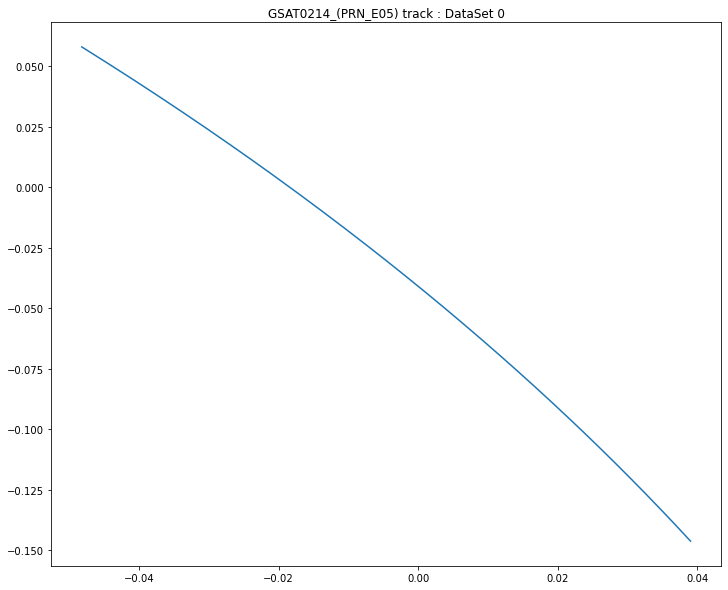

In [29]:
Theories[0].trackPlot(cut=[500,700],sats=['GSAT0214_(PRN_E05)'])

In [59]:
Theories[0].setParameters({'A{}_Cygnus_A_{}'.format(i+1,j):1e6})

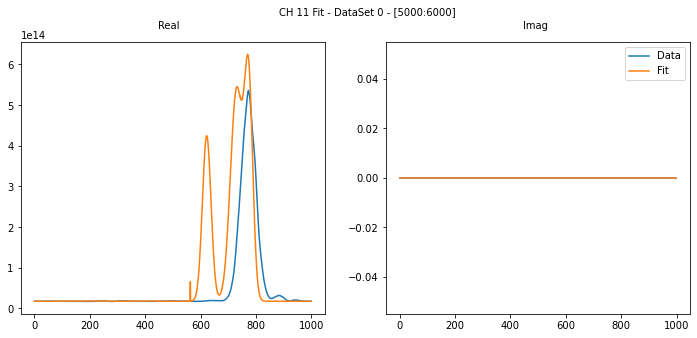

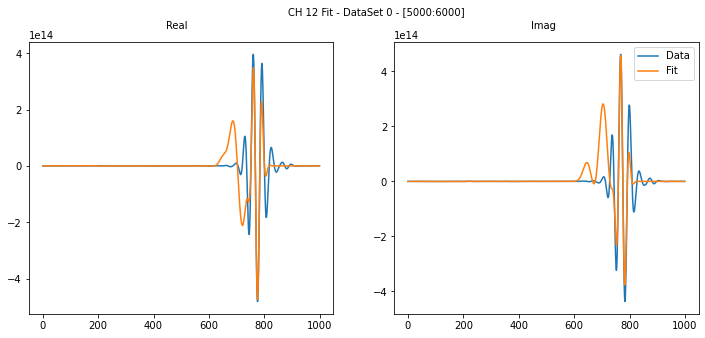

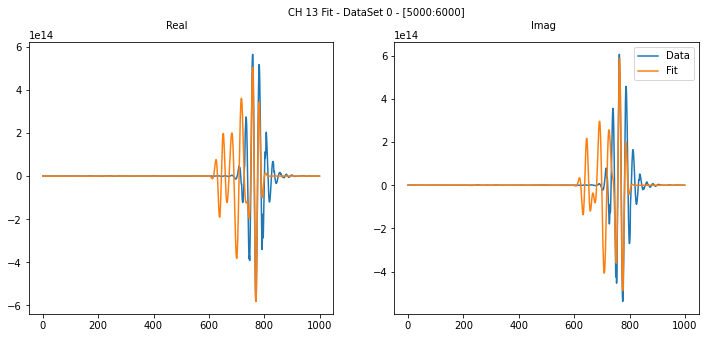

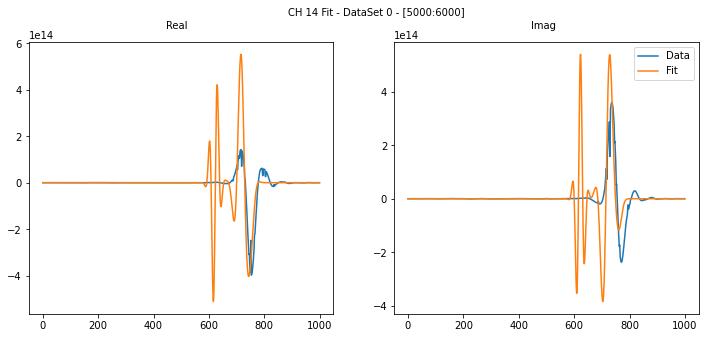

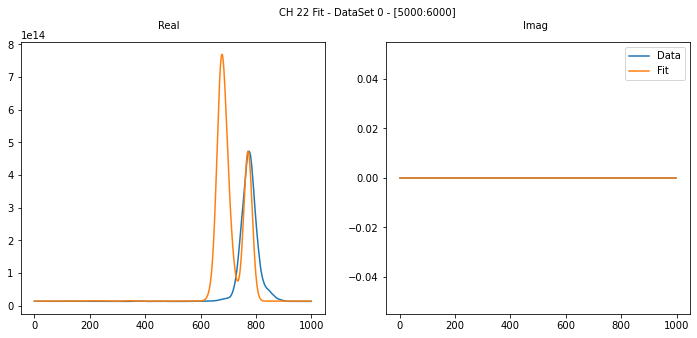

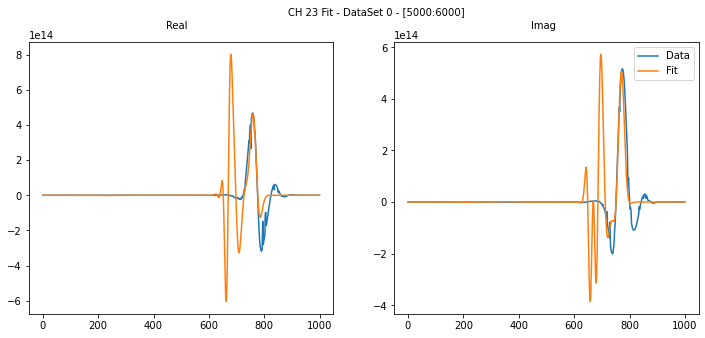

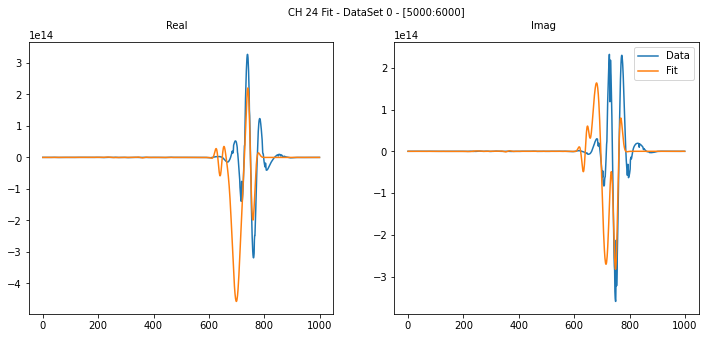

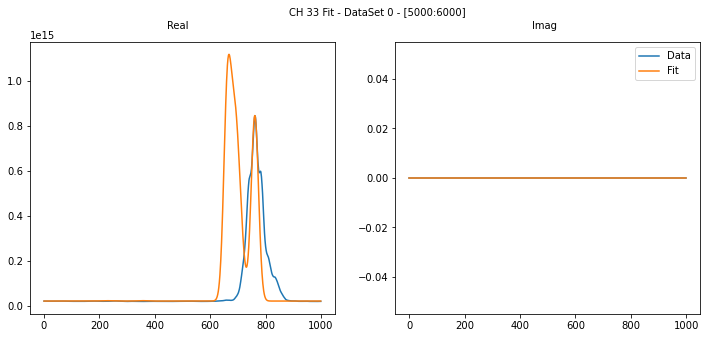

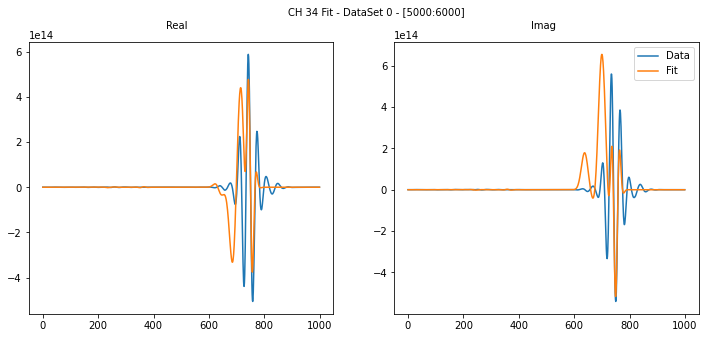

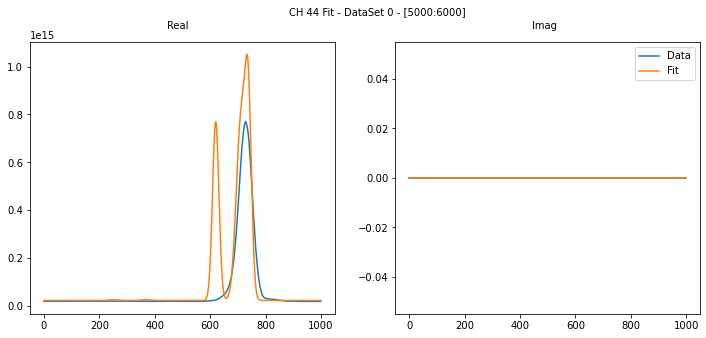

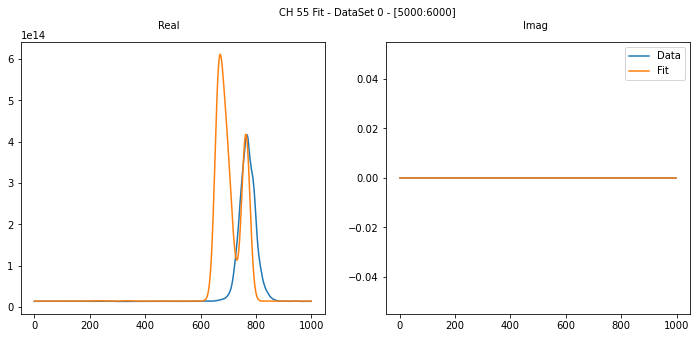

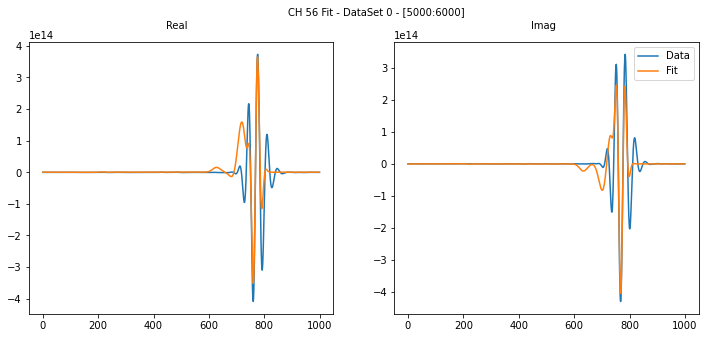

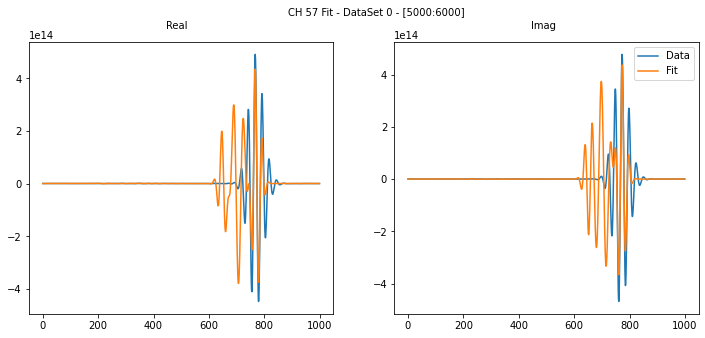

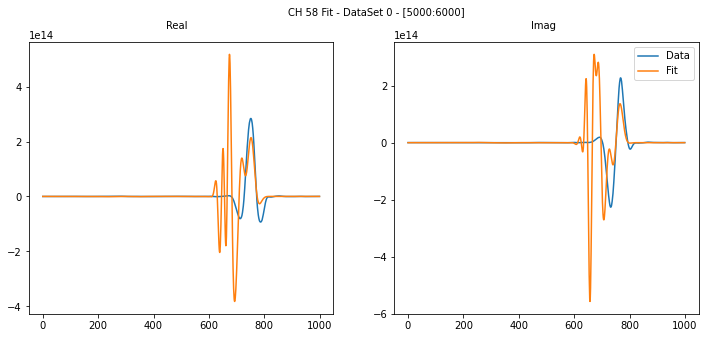

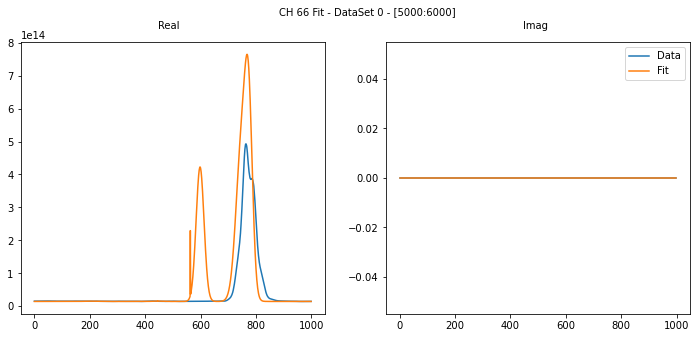

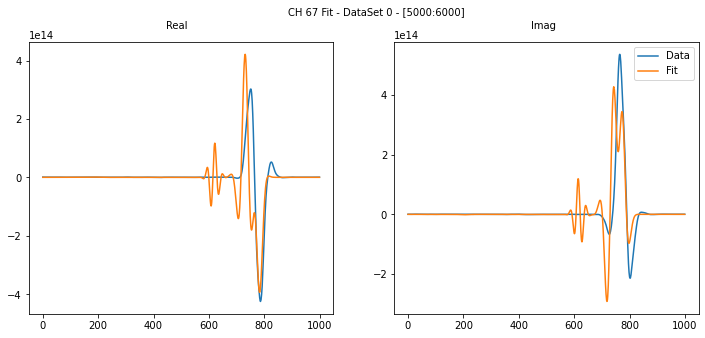

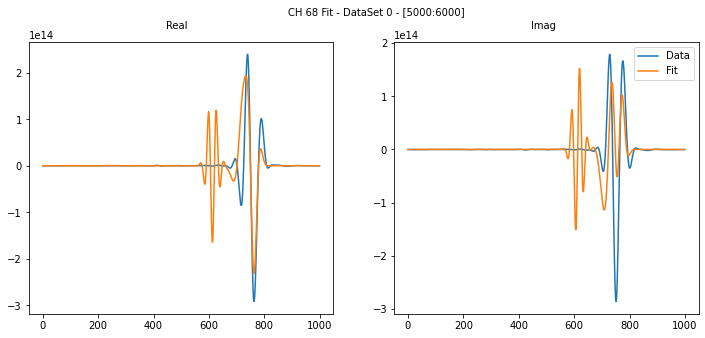

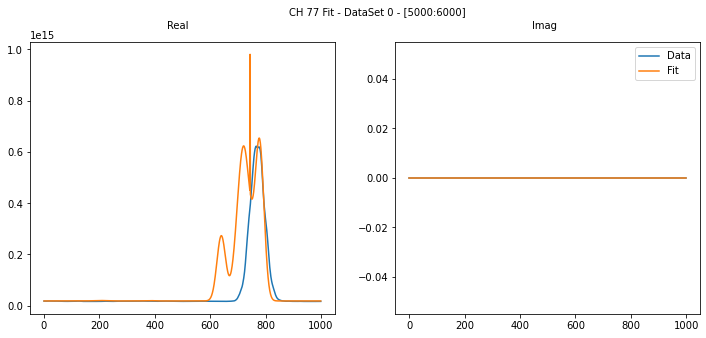

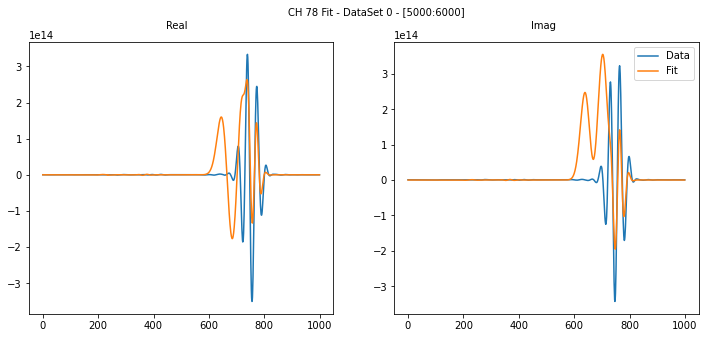

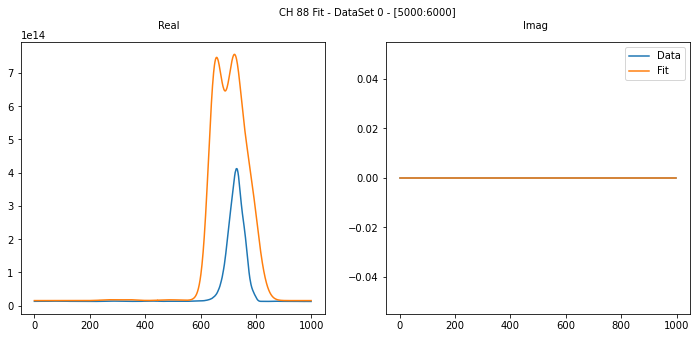

In [65]:
cut = [5000,6000]
channels = [11,12,13,14,22,23,24,33,34,44,55,56,57,58,66,67,68,77,78,88]
mode = 'all'

Theory.showFit(channels = channels, cut=cut,mode=mode, perSat=False)

In [20]:
for T in Theories:
    print(T.readParameters())
    print()

{'A1_GSAT0207_(PRN_E07)_0': 7811132.194367903, 'A2_GSAT0207_(PRN_E07)_0': 8337560.910041831, 'A3_GSAT0207_(PRN_E07)_0': 5559546.014797594, 'A4_GSAT0207_(PRN_E07)_0': 1335536.7802754492, 'A5_GSAT0207_(PRN_E07)_0': 5515942.358409666, 'A6_GSAT0207_(PRN_E07)_0': 8417147.39392825, 'A7_GSAT0207_(PRN_E07)_0': 6821567.6820422, 'A8_GSAT0207_(PRN_E07)_0': 1.1435458532590062, 'GSAT0207_(PRN_E07)_track_offset_x': 0.0, 'GSAT0207_(PRN_E07)_track_offset_y': 0.0, 'GSAT0207_(PRN_E07)_time_offset': 0, 'A1_GPS_BIIF-4__(PRN_27)_0': 145794.24548820034, 'A2_GPS_BIIF-4__(PRN_27)_0': 159308.13116774498, 'A3_GPS_BIIF-4__(PRN_27)_0': 274115.2286818648, 'A4_GPS_BIIF-4__(PRN_27)_0': 2029.3742600155674, 'A5_GPS_BIIF-4__(PRN_27)_0': 11222.909488820238, 'A6_GPS_BIIF-4__(PRN_27)_0': 956754.2055071815, 'A7_GPS_BIIF-4__(PRN_27)_0': 61431.24942290096, 'A8_GPS_BIIF-4__(PRN_27)_0': 582244.2514597626, 'GPS_BIIF-4__(PRN_27)_track_offset_x': 0.0, 'GPS_BIIF-4__(PRN_27)_track_offset_y': 0.0, 'GPS_BIIF-4__(PRN_27)_time_offset':

In [22]:
Theories[0].sigSats(8200)

{'GPS_BIIF-11_(PRN_10)'}

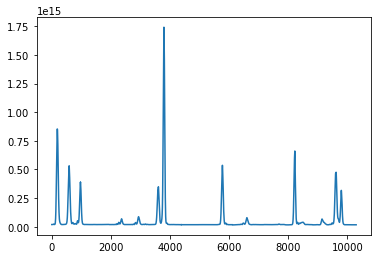

In [25]:
plt.plot(Theories[0].)

In [4]:
P = [
    {'D2_pos_x': 4.496720655923967, 'D2_pos_y': -0.6287600000433483, 'D2_phi': -0.2162769382554462, 'D3_pos_x': 0.3001220480458651, 'D3_pos_y': -5.027992542650962, 'D3_phi': 2.4221178826730054, 'D4_pos_x': -4.205341249150452, 'D4_pos_y': -0.8634242563413563, 'D4_phi': -0.360279571400098, 'D6_pos_x': 4.302920183195884, 'D6_pos_y': -0.30173473558525316, 'D6_phi': 2.7941999397976307, 'D7_pos_x': -0.11910451531087028, 'D7_pos_y': -4.367339677477533, 'D7_phi': -1.749506910188624, 'D8_pos_x': -5.115882137283665, 'D8_pos_y': -1.1103425854390399, 'D8_phi': 2.8637630024124805},
    {'D2_pos_x': 4.51328290094902, 'D2_pos_y': -0.5772916798757681, 'D2_phi': -0.24910016285190198, 'D3_pos_x': 0.5833898560167713, 'D3_pos_y': -4.860230781105983, 'D3_phi': 1.5576656715641568, 'D4_pos_x': -4.23678614745232, 'D4_pos_y': -0.5731806341881936, 'D4_phi': -1.1639513542163715, 'D6_pos_x': 4.396745500025717, 'D6_pos_y': -0.3400077323838728, 'D6_phi': 2.8336315912597936, 'D7_pos_x': -0.11996185184280196, 'D7_pos_y': -4.871861384745773, 'D7_phi': -1.465384870455939, 'D8_pos_x': -4.939572093306822, 'D8_pos_y': -0.5789959542041317, 'D8_phi': 2.9359492846132014},
    {'D2_pos_x': 4.541247000489112, 'D2_pos_y': -0.6021746922831518, 'D2_phi': -0.2496430542027421, 'D3_pos_x': 0.36059124486447086, 'D3_pos_y': -4.972908864726141, 'D3_phi': 0.6634949955203578, 'D4_pos_x': -4.548338836913454, 'D4_pos_y': -0.7900775391808744, 'D4_phi': -2.0566846469509974, 'D6_pos_x': 4.355663985415377, 'D6_pos_y': -0.387188952024975, 'D6_phi': 2.844265119068721, 'D7_pos_x': -0.005896882194541871, 'D7_pos_y': -4.435688122908201, 'D7_phi': -3.9595184724167214, 'D8_pos_x': -5.066543684393208, 'D8_pos_y': -0.9000312093224433, 'D8_phi': 0.4544019678199632},
]

P = np.array([list(p.values()) for p in P])
avg = P.sum(axis=0)/len(P)
sdv = np.sqrt(((P-avg)**2).sum(axis=0)/len(P))
print('Average:')
print(avg)
print('Standard Deviation:')
print(sdv)

Average:
[ 4.51708352 -0.60274212 -0.23834005  0.41470105 -4.95371073  1.54775952
 -4.33015541 -0.74222748 -1.19363852  4.35177656 -0.34297714  2.82403222
 -0.08165442 -4.5582964  -2.39147008 -5.04066597 -0.86312325  2.08470475]
Standard Deviation:
[0.01837539 0.02101568 0.01560255 0.12180877 0.06982086 0.71798896
 0.15481215 0.1232276  0.69287254 0.03840253 0.03494967 0.02153666
 0.05356981 0.22347279 1.11482828 0.07426776 0.21848563 1.15317477]


In [43]:
def approxPeaks(Theory, width=50):
    for i,D in enumerate(Theory.data):
        for n,t in zip(Theory.satNames[i],Theory.satTracks[i]):
            cos2 = (t**2).sum(axis=-1)
            peak = (np.arange(len(cos2))[cos2==min(cos2)])[0]
            for ch in range(8):
                if max(abs(D[11*(ch+1)][max(peak-width,0):min(peak+width,len(D[11])-1)]-Theory.offsets_r[i][11*(ch+1)])) < 0:
                    amp = 0
                else:
                    amp = np.sqrt(max(abs(D[11*(ch+1)][max(peak-width,0):min(peak+width,len(D[11])-1)]-Theory.offsets_r[i][11*(ch+1)])))
                if n == 'GSAT0205_(PRN_E24)':
                    print(amp)
                Theory.setParameters({'A{}_{}_{}'.format(ch+1,n,i):amp})

In [88]:
approxPeaks(Theories[0])

In [39]:
print(Theories[0].satNames)

[['GPS_BIII-4__(PRN_14)', 'GSAT0214_(PRN_E05)', 'BEIDOU-3_M21', 'BEIDOU-3_M9_(C23)', 'GPS_BIIF-11_(PRN_10)', 'GSAT0206_(PRN_E30)', 'GSAT0210_(PRN_E01)', 'BEIDOU-3_M12_(C26)', 'GPS_BIIF-9__(PRN_26)', 'GSAT0207_(PRN_E07)', 'GPS_BIIR-8__(PRN_16)', 'GPS_BIIF-10_(PRN_08)', 'GSAT0203_(PRN_E26)', 'GPS_BIIR-4__(PRN_20)', 'BEIDOU-3_M6_(C22)', 'BEIDOU_13_(C12)', 'GPS_BIII-3__(PRN_23)', 'BEIDOU_19_(C58)', 'GSAT0213_(PRN_E04)', 'GSAT0216_(PRN_E25)', 'BEIDOU-3_M5_(C21)', 'GSAT0202_(PRN_E14)', 'BEIDOU-3_M13_(C32)', 'GPS_BIIRM-8_(PRN_05)', 'BEIDOU-3_M7_(C29)', 'BEIDOU_15_(C14)', 'GPS_BIIRM-2_(PRN_31)', 'GSAT0221_(PRN_E15)', 'GPS_BIII-2__(PRN_18)', 'BEIDOU-3_M18_(C37)', 'BEIDOU-3_M19', 'GPS_BIIF-6__(PRN_06)', 'BEIDOU-3_M15_(C34)', 'GSAT0220_(PRN_E13)', 'GPS_BIIF-12_(PRN_32)', 'GPS_BIIR-11_(PRN_19)', 'GSAT0104_(PRN_E20)', 'GPS_BIIR-13_(PRN_02)', 'BEIDOU-3_M20', 'GPS_BIIF-4__(PRN_27)', 'Cygnus_A']]


In [57]:
print(Theories[0].satTracks[0])

[[[-1.56744391e-01  5.54254055e-01]
  [-1.56819910e-01  5.53440571e-01]
  [-1.56895354e-01  5.52626669e-01]
  ...
  [-6.08867824e-01 -4.39071506e-01]
  [-6.09513104e-01 -4.39129174e-01]
  [-6.10158920e-01 -4.39184934e-01]]

 [[-3.97617012e-01  3.74989092e-01]
  [-3.96814525e-01  3.74731719e-01]
  [-3.96011949e-01  3.74473184e-01]
  ...
  [-6.11691773e-01  7.60338128e-01]
  [-6.11804247e-01  7.60023773e-01]
  [-6.11916721e-01  7.59708703e-01]]

 [[ 6.12327635e-01  7.76643872e-01]
  [ 6.11671746e-01  7.77237058e-01]
  [ 6.11014843e-01  7.77829707e-01]
  ...
  [ 2.69703597e-01  9.47592497e-01]
  [ 2.69218504e-01  9.47591245e-01]
  [ 2.68734276e-01  9.47588861e-01]]

 ...

 [[ 5.79860151e-01 -5.46458542e-01]
  [ 5.79395771e-01 -5.46231449e-01]
  [ 5.78931689e-01 -5.46003342e-01]
  ...
  [ 5.92414260e-01 -2.50748426e-01]
  [ 5.92692435e-01 -2.49950305e-01]
  [ 5.92970908e-01 -2.49152064e-01]]

 [[-5.70163369e-01 -6.83585882e-01]
  [-5.69405377e-01 -6.84164286e-01]
  [-5.68647265e-01 -6.8474

In [62]:
def calculate(func, args):
    result = func(*args)
    return '%s says that %s%s = %s' % (
        multiprocessing.current_process().name,
        func.__name__, args, result
        )

def calculatestar(args):
    return calculate(*args)

def mul(a, b):
    time.sleep(0.5 * random.random())
    return a * b

def plus(a, b):
    time.sleep(0.5 * random.random())
    return a + b

def f(x):
    return 1.0 / (x - 5.0)

def pow3(x):
    return x ** 3

def noop(x):
    pass

#
# Test code
#

def test():
    PROCESSES = 4
    print('Creating pool with %d processes\n' % PROCESSES)

    with multiprocessing.Pool(PROCESSES) as pool:
        #
        # Tests
        #

        TASKS = [(mul, (i, 7)) for i in range(10)] + \
                [(plus, (i, 8)) for i in range(10)]

        results = [pool.apply_async(calculate, t) for t in TASKS]
        imap_it = pool.imap(calculatestar, TASKS)
        imap_unordered_it = pool.imap_unordered(calculatestar, TASKS)

        print('Ordered results using pool.apply_async():')
        for r in results:
            print('\t', r.get())
        print()

        print('Ordered results using pool.imap():')
        for x in imap_it:
            print('\t', x)
        print()

        print('Unordered results using pool.imap_unordered():')
        for x in imap_unordered_it:
            print('\t', x)
        print()

        print('Ordered results using pool.map() --- will block till complete:')
        for x in pool.map(calculatestar, TASKS):
            print('\t', x)
        print()

In [67]:
test()

Creating pool with 4 processes

Ordered results using pool.apply_async():
	 ForkPoolWorker-105 says that mul(0, 7) = 0
	 ForkPoolWorker-106 says that mul(1, 7) = 7
	 ForkPoolWorker-107 says that mul(2, 7) = 14
	 ForkPoolWorker-108 says that mul(3, 7) = 21
	 ForkPoolWorker-107 says that mul(4, 7) = 28
	 ForkPoolWorker-106 says that mul(5, 7) = 35
	 ForkPoolWorker-107 says that mul(6, 7) = 42
	 ForkPoolWorker-108 says that mul(7, 7) = 49
	 ForkPoolWorker-105 says that mul(8, 7) = 56
	 ForkPoolWorker-108 says that mul(9, 7) = 63
	 ForkPoolWorker-105 says that plus(0, 8) = 8
	 ForkPoolWorker-106 says that plus(1, 8) = 9
	 ForkPoolWorker-105 says that plus(2, 8) = 10
	 ForkPoolWorker-106 says that plus(3, 8) = 11
	 ForkPoolWorker-107 says that plus(4, 8) = 12
	 ForkPoolWorker-106 says that plus(5, 8) = 13
	 ForkPoolWorker-108 says that plus(6, 8) = 14
	 ForkPoolWorker-105 says that plus(7, 8) = 15
	 ForkPoolWorker-105 says that plus(8, 8) = 16
	 ForkPoolWorker-106 says that plus(9, 8) = 17
